# ACGAN Implementation for HAM10000 Dataset

This notebook implements ACGAN to augment the AKIEC, BCC, BKL, and MEL classes to handle imbalance in the HAM10000 dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ham_windsurf

/content/drive/MyDrive/ham_windsurf


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Add src directory to path
sys.path.append('../')
from src.gan.models import ACGANGenerator, ACGANDiscriminator, weights_init
from src.gan.utils.data import HAM10000GanDataset, create_class_balanced_loader
from src.gan.utils.metrics import calculate_fid ,calculate_fid_from_stats, InceptionV3Features, calculate_activation_statistics

In [4]:
output_dir = '/content/drive/MyDrive/ham_windsurf/results/acgan_modified'
os.makedirs(output_dir, exist_ok=True)

## Load Dataset

We'll load the filtered dataset with the 5 retained classes (NV, MEL, BKL, BCC, AKIEC).

In [5]:
# Configuration
csv_file = '/content/drive/MyDrive/ham_windsurf/archive/GroundTruth_filtered.csv'
img_dir = '/content/drive/MyDrive/ham_windsurf/archive/hair_removed_images'
batch_size = 64
image_size = 128
num_workers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create dataloader with class balancing
dataloader, class_weights, class_counts = create_class_balanced_loader(
    csv_file,
    img_dir,
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers
)

# Print dataset info
print(f"Number of samples: {len(dataloader.dataset)}")
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Number of classes
n_classes = len(class_counts)

Using device: cuda
Number of samples: 9758
Class counts: Counter({np.int64(0): 6705, np.int64(1): 1113, np.int64(2): 1099, np.int64(3): 514, np.int64(4): 327})
Class weights: tensor([0.1071, 0.6453, 0.6536, 1.3974, 2.1965])


## ACGAN Model Setup

Initialize the ACGAN generator and discriminator models.

In [6]:
# Model parameters
latent_dim = 100
channels = 3
ngf = 64  # Number of generator filters
ndf = 64  # Number of discriminator filters
lambda_aux = 1.0  # Weight for auxiliary classifier loss

# Training parameters
epochs = 300 #150
lr = 0.0005 # 0.0002
beta1 = 0.5
log_interval = 10
sample_interval = 100
save_interval = 10

# Initialize models
netG = ACGANGenerator(
    latent_dim=latent_dim,
    n_classes=n_classes,
    channels=channels,
    ngf=ngf
).to(device)

netD = ACGANDiscriminator(
    n_classes=n_classes,
    channels=channels,
    ndf=ndf
).to(device)

# Print model summary
print(f"Generator parameters: {sum(p.numel() for p in netG.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in netD.parameters())}")

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)

# Setup optimizers
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()
#auxiliary_loss = nn.CrossEntropyLoss(weight=class_weights.to(device))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32) # Convert to tensor
auxiliary_loss = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device)) # Use the tensor

# Fixed noise for visualization
fixed_noise = torch.randn(n_classes * 8, latent_dim).to(device)
fixed_labels = torch.tensor([i for i in range(n_classes) for _ in range(8)], dtype=torch.long).to(device)

Generator parameters: 14441844
Discriminator parameters: 11246336


<ipython-input-6-4a2fcea1799b>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32) # Convert to tensor


## Training Function

Define the training function for ACGAN.

In [7]:
# Create output directory
output_dir = '/content/drive/MyDrive/ham_windsurf/results/acgan_modified'
os.makedirs(output_dir, exist_ok=True)

# Function to save image grid
def save_image_grid(images, path, nrow=8, title=None):
    # Convert to numpy and transpose to (H, W, C)
    images = images.cpu().numpy().transpose(0, 2, 3, 1)

    # Create grid
    n_images = images.shape[0]
    rows = int(np.ceil(n_images / nrow))
    grid = np.zeros((rows * images.shape[1], nrow * images.shape[2], images.shape[3]))

    for i, image in enumerate(images):
        row = i // nrow
        col = i % nrow
        grid[row * images.shape[1]:(row + 1) * images.shape[1],
             col * images.shape[2]:(col + 1) * images.shape[2], :] = image

    # Plot and save
    plt.figure(figsize=(15, 15 * rows / nrow))
    plt.imshow(grid)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

# Training loop
def train_acgan():
    print("Starting training...")
    g_losses = []
    d_losses = []
    d_adv_losses = []
    d_aux_losses = []
    g_adv_losses = []
    g_aux_losses = []

    # Add list to store FID scores
    fid_scores = []
    epochs_with_fid = []

    start_time = time.time()

    # For FID: prepare real dataloader (subset of real images, same transform as generated images)
    real_dataset = HAM10000GanDataset(csv_file, img_dir, image_size=image_size)
    real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=64, shuffle=True, num_workers=2)
    inception = InceptionV3Features(device)
    # Precompute real stats
    mu_real, sigma_real = calculate_activation_statistics(real_loader, inception, device=device, max_samples=1000)

    for epoch in range(epochs):
        for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            real_images = batch['image'].to(device)
            real_labels = batch['label'].to(device)
            batch_size = real_images.size(0)

            # Create labels
            real_target = torch.ones(batch_size, device=device) * 0.9  # Label smoothing
            fake_target = torch.zeros(batch_size, device=device)

            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()

            # Real images
            real_pred, real_aux = netD(real_images)
            d_real_loss = adversarial_loss(real_pred, real_target)
            d_real_aux_loss = auxiliary_loss(real_aux, real_labels)

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
            fake_images = netG(z, fake_labels)

            fake_pred, fake_aux = netD(fake_images.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake_target)
            d_fake_aux_loss = auxiliary_loss(fake_aux, fake_labels)

            # Total discriminator loss
            d_adv_loss = d_real_loss + d_fake_loss
            d_aux_loss = d_real_aux_loss + d_fake_aux_loss
            d_loss = d_adv_loss + lambda_aux * d_aux_loss

            d_loss.backward()
            optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()

            # Generate new fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
            fake_images = netG(z, fake_labels)

            # Get discriminator predictions
            fake_pred, fake_aux = netD(fake_images)

            # Generator losses
            g_adv_loss = adversarial_loss(fake_pred, real_target)
            g_aux_loss = auxiliary_loss(fake_aux, fake_labels)
            g_lambda_aux = lambda_aux * 5.0  # Increase auxiliary loss weight for generator
            g_loss = g_adv_loss + g_lambda_aux * g_aux_loss

            g_loss.backward()
            optimizerG.step()

            # Save losses for plotting later
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            g_adv_losses.append(g_adv_loss.item())
            g_aux_losses.append(g_aux_loss.item())
            d_adv_losses.append(d_adv_loss.item())
            d_aux_losses.append(d_aux_loss.item())

            # Output training stats
            if i % log_interval == 0:
                elapsed = time.time() - start_time
                print(f'[{epoch+1}/{epochs}][{i}/{len(dataloader)}] '
                      f'Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f} '
                      f'D_adv: {d_adv_loss.item():.4f} D_aux: {d_aux_loss.item():.4f} '
                      f'G_adv: {g_adv_loss.item():.4f} G_aux: {g_aux_loss.item():.4f} '
                      f'Time: {elapsed:.2f}s')

            # Check how the generator is doing by saving G's output on fixed_noise
            if (i % sample_interval == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise, fixed_labels).detach().cpu()
                    # Normalize from [-1, 1] to [0, 1]
                    fake = (fake + 1) / 2

                    # Save images
                    save_image_grid(
                        fake,
                        os.path.join(output_dir, f'samples_epoch_{epoch+1}_iter_{i}.png'),
                        nrow=8,
                        title=f'ACGAN Samples - Epoch {epoch+1}, Iteration {i}'
                    )

        # Save model checkpoints
        if (epoch + 1) % save_interval == 0 or epoch == epochs - 1:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': netG.state_dict(),
                'discriminator_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'g_loss': g_loss.item(),
                'd_loss': d_loss.item(),
            }, os.path.join(output_dir, f'acgan_checkpoint_epoch_{epoch+1}.pt'))

        # Calculate FID score every 10 epochs or at the end
        if epoch % 10 == 0 or epoch == epochs - 1:
            # Generate a batch of images for FID calculation
            print(f"Calculating FID score for epoch {epoch+1}...")
            n_samples = 1000
            n_batches = n_samples // batch_size + 1
            fake_images = []

            with torch.no_grad():
                for i in range(n_batches):
                    z = torch.randn(batch_size, latent_dim).to(device)
                    labels = torch.randint(0, n_classes, (batch_size,)).to(device)
                    fake_batch = netG(z, labels).detach()
                    fake_images.append(fake_batch)

            fake_images = torch.cat(fake_images, dim=0)[:n_samples]

            # Create a dataloader for the fake images
            class FakeDataset(Dataset):
                def __init__(self, images):
                    self.images = images

                def __len__(self):
                    return len(self.images)

                def __getitem__(self, idx):
                    return {'image': self.images[idx]}

            fake_dataset = FakeDataset(fake_images)
            fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False)

            # Calculate FID
            mu_fake, sigma_fake = calculate_activation_statistics(fake_loader, inception, device=device)
            fid = calculate_fid_from_stats(mu_real, sigma_real, mu_fake, sigma_fake)
            print(f"FID score at epoch {epoch+1}: {fid:.4f}")

            # Store FID score for plotting
            fid_scores.append(fid)
            epochs_with_fid.append(epoch + 1)

    # Save loss plots with better styling
    plt.figure(figsize=(15, 10))

    # Main losses plot
    plt.subplot(2, 2, 1)
    plt.plot(g_losses, label='Generator', color='#2E86C1', alpha=0.8, linewidth=2)
    plt.plot(d_losses, label='Discriminator', color='#E74C3C', alpha=0.8, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Generator and Discriminator Losses', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Adversarial losses plot
    plt.subplot(2, 2, 2)
    plt.plot(g_adv_losses, label='G Adversarial', color='#2E86C1', alpha=0.8, linewidth=2)
    plt.plot(d_adv_losses, label='D Adversarial', color='#E74C3C', alpha=0.8, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Adversarial Losses', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Auxiliary losses plot
    plt.subplot(2, 2, 3)
    plt.plot(g_aux_losses, label='G Auxiliary', color='#2E86C1', alpha=0.8, linewidth=2)
    plt.plot(d_aux_losses, label='D Auxiliary', color='#E74C3C', alpha=0.8, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Auxiliary Losses', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Moving average for smoother curves
    window_size = 50
    if len(g_losses) > window_size:
        g_losses_smooth = np.convolve(g_losses, np.ones(window_size)/window_size, mode='valid')
        d_losses_smooth = np.convolve(d_losses, np.ones(window_size)/window_size, mode='valid')
        x_smooth = range(window_size-1, len(g_losses))

        plt.subplot(2, 2, 4)
        plt.plot(x_smooth, g_losses_smooth, label='Generator (Smoothed)', color='#2E86C1', linewidth=2)
        plt.plot(x_smooth, d_losses_smooth, label='Discriminator (Smoothed)', color='#E74C3C', linewidth=2)
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Smoothed Losses', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'loss_plots.png'), dpi=300)
    plt.close()

    # Plot FID scores
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_with_fid, fid_scores, marker='o', linestyle='-', color='#8E44AD', linewidth=2, markersize=8)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('FID Score', fontsize=12)
    plt.title('FID Score Progression', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(epochs_with_fid)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'fid_scores.png'), dpi=300)
    plt.close()

    # Save FID scores to file
    with open(os.path.join(output_dir, 'fid_scores.txt'), 'w') as f:
        for epoch, fid in zip(epochs_with_fid, fid_scores):
            f.write(f"Epoch {epoch}: {fid:.4f}\n")

    return netG, netD, fid_scores, epochs_with_fid

In [8]:
def generate_class_examples(generator, n_samples=10):
    """
    Generate and display examples for each class
    Args:
        generator: Trained generator model
        n_samples: Number of samples per class
    """
    generator.eval()

    # Create fixed noise for consistent generation
    fixed_noise = torch.randn(n_samples * n_classes, latent_dim).to(device)

    # For each class, generate n_samples images
    all_samples = []
    class_names = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC']

    plt.figure(figsize=(15, 3 * n_classes))

    with torch.no_grad():
        for class_idx in range(n_classes):
            # Create labels for this class
            labels = torch.full((n_samples,), class_idx, dtype=torch.long).to(device)

            # Use a slice of the fixed noise
            noise_slice = fixed_noise[class_idx * n_samples:(class_idx + 1) * n_samples]

            # Generate images
            fake = generator(noise_slice, labels)

            # Normalize from [-1, 1] to [0, 1]
            fake = (fake + 1) / 2

            # Create a grid of images
            img_grid = make_grid(fake.cpu(), nrow=n_samples, normalize=False, padding=2)

            # Plot
            plt.subplot(n_classes, 1, class_idx + 1)
            plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
            plt.title(f"Class: {class_names[class_idx]}", fontsize=14, fontweight='bold')
            plt.axis('off')

            # Save individual class examples
            save_image_grid(
                fake.cpu(),
                os.path.join(output_dir, f'class_{class_idx}_{class_names[class_idx]}_examples.png'),
                nrow=n_samples,
                title=f'Class {class_idx}: {class_names[class_idx]}'
            )

            all_samples.append(fake.cpu())

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'all_classes_examples.png'), dpi=300)
    plt.close()

    # Return all samples for further analysis if needed
    return torch.cat(all_samples)

## Train ACGAN

In [9]:
from torchvision.utils import make_grid

Starting training...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 200MB/s] 
Calculating statistics:  10%|▉         | 15/153 [08:02<1:13:59, 32.17s/it]


Epoch 1/300:   0%|          | 0/153 [00:00<?, ?it/s]

[1/300][0/153] Loss_D: 5.6196 Loss_G: 25.9387 D_adv: 1.3687 D_aux: 4.2509 G_adv: 23.2505 G_aux: 0.5376 Time: 533.36s
[1/300][10/153] Loss_D: 7.4052 Loss_G: 32.2518 D_adv: 3.8742 D_aux: 3.5311 G_adv: 32.1927 G_aux: 0.0118 Time: 619.64s
[1/300][20/153] Loss_D: 5.3118 Loss_G: 10.9452 D_adv: 3.8357 D_aux: 1.4761 G_adv: 10.4494 G_aux: 0.0992 Time: 708.58s
[1/300][30/153] Loss_D: 4.6233 Loss_G: 14.5657 D_adv: 2.6617 D_aux: 1.9616 G_adv: 14.1182 G_aux: 0.0895 Time: 784.49s
[1/300][40/153] Loss_D: 3.4540 Loss_G: 9.4332 D_adv: 2.2138 D_aux: 1.2402 G_adv: 9.1329 G_aux: 0.0600 Time: 842.48s
[1/300][50/153] Loss_D: 3.1484 Loss_G: 8.9837 D_adv: 1.8889 D_aux: 1.2595 G_adv: 8.5204 G_aux: 0.0927 Time: 918.02s
[1/300][60/153] Loss_D: 2.7949 Loss_G: 3.0656 D_adv: 0.7643 D_aux: 2.0307 G_adv: 2.9152 G_aux: 0.0301 Time: 968.45s
[1/300][70/153] Loss_D: 2.8886 Loss_G: 4.0769 D_adv: 0.8832 D_aux: 2.0054 G_adv: 3.9117 G_aux: 0.0330 Time: 1015.67s
[1/300][80/153] Loss_D: 1.7872 Loss_G: 4.4144 D_adv: 0.5689 D_au

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 46.57it/s]


FID score at epoch 1: 361.6621


Epoch 2/300:   0%|          | 0/153 [00:00<?, ?it/s]

[2/300][0/153] Loss_D: 2.2989 Loss_G: 2.6811 D_adv: 1.0986 D_aux: 1.2003 G_adv: 2.5392 G_aux: 0.0284 Time: 1323.82s
[2/300][10/153] Loss_D: 1.9547 Loss_G: 11.1459 D_adv: 0.9825 D_aux: 0.9722 G_adv: 11.0506 G_aux: 0.0191 Time: 1345.01s
[2/300][20/153] Loss_D: 3.3133 Loss_G: 6.3677 D_adv: 1.3104 D_aux: 2.0029 G_adv: 6.0787 G_aux: 0.0578 Time: 1381.70s
[2/300][30/153] Loss_D: 5.8698 Loss_G: 6.1151 D_adv: 4.3838 D_aux: 1.4859 G_adv: 5.8773 G_aux: 0.0476 Time: 1404.75s
[2/300][40/153] Loss_D: 3.6240 Loss_G: 7.9002 D_adv: 2.0955 D_aux: 1.5285 G_adv: 6.1223 G_aux: 0.3556 Time: 1435.41s
[2/300][50/153] Loss_D: 3.6568 Loss_G: 7.2945 D_adv: 0.9825 D_aux: 2.6743 G_adv: 7.1944 G_aux: 0.0200 Time: 1459.28s
[2/300][60/153] Loss_D: 5.6794 Loss_G: 6.7770 D_adv: 2.3321 D_aux: 3.3473 G_adv: 6.7346 G_aux: 0.0085 Time: 1480.68s
[2/300][70/153] Loss_D: 4.0898 Loss_G: 5.2842 D_adv: 1.5100 D_aux: 2.5797 G_adv: 5.0289 G_aux: 0.0510 Time: 1498.04s
[2/300][80/153] Loss_D: 4.2528 Loss_G: 8.3925 D_adv: 2.9115 D_a

Epoch 3/300:   0%|          | 0/153 [00:00<?, ?it/s]

[3/300][0/153] Loss_D: 2.7865 Loss_G: 5.1910 D_adv: 1.5729 D_aux: 1.2137 G_adv: 5.0858 G_aux: 0.0210 Time: 1653.64s
[3/300][10/153] Loss_D: 4.6605 Loss_G: 4.5475 D_adv: 1.8118 D_aux: 2.8487 G_adv: 4.2687 G_aux: 0.0558 Time: 1669.22s
[3/300][20/153] Loss_D: 1.5963 Loss_G: 3.6477 D_adv: 0.5416 D_aux: 1.0547 G_adv: 3.5412 G_aux: 0.0213 Time: 1686.23s
[3/300][30/153] Loss_D: 2.3526 Loss_G: 5.1368 D_adv: 0.4832 D_aux: 1.8694 G_adv: 4.9495 G_aux: 0.0374 Time: 1703.01s
[3/300][40/153] Loss_D: 2.9160 Loss_G: 2.3727 D_adv: 1.0028 D_aux: 1.9131 G_adv: 2.3302 G_aux: 0.0085 Time: 1716.55s
[3/300][50/153] Loss_D: 2.4628 Loss_G: 3.1684 D_adv: 1.3105 D_aux: 1.1523 G_adv: 3.0063 G_aux: 0.0324 Time: 1731.99s
[3/300][60/153] Loss_D: 2.8439 Loss_G: 4.5662 D_adv: 0.9556 D_aux: 1.8882 G_adv: 2.2389 G_aux: 0.4655 Time: 1743.88s
[3/300][70/153] Loss_D: 2.0034 Loss_G: 2.3881 D_adv: 0.7687 D_aux: 1.2346 G_adv: 1.7073 G_aux: 0.1362 Time: 1759.24s
[3/300][80/153] Loss_D: 1.9499 Loss_G: 3.8179 D_adv: 0.8045 D_aux

Epoch 4/300:   0%|          | 0/153 [00:00<?, ?it/s]

[4/300][0/153] Loss_D: 2.6956 Loss_G: 6.2122 D_adv: 1.7370 D_aux: 0.9586 G_adv: 6.0786 G_aux: 0.0267 Time: 1870.15s
[4/300][10/153] Loss_D: 2.0247 Loss_G: 4.1103 D_adv: 1.2052 D_aux: 0.8195 G_adv: 3.8763 G_aux: 0.0468 Time: 1881.31s
[4/300][20/153] Loss_D: 2.0634 Loss_G: 2.7593 D_adv: 0.5918 D_aux: 1.4716 G_adv: 2.7022 G_aux: 0.0114 Time: 1894.48s
[4/300][30/153] Loss_D: 2.5748 Loss_G: 3.2003 D_adv: 1.0446 D_aux: 1.5302 G_adv: 3.1442 G_aux: 0.0112 Time: 1907.90s
[4/300][40/153] Loss_D: 1.3763 Loss_G: 2.6362 D_adv: 0.6374 D_aux: 0.7389 G_adv: 2.4923 G_aux: 0.0288 Time: 1911.40s
[4/300][50/153] Loss_D: 3.7764 Loss_G: 5.9979 D_adv: 1.3879 D_aux: 2.3884 G_adv: 5.9566 G_aux: 0.0083 Time: 1927.05s
[4/300][60/153] Loss_D: 2.2016 Loss_G: 2.1500 D_adv: 1.1911 D_aux: 1.0104 G_adv: 2.0046 G_aux: 0.0291 Time: 1938.56s
[4/300][70/153] Loss_D: 2.1828 Loss_G: 6.3877 D_adv: 1.1499 D_aux: 1.0329 G_adv: 6.2744 G_aux: 0.0227 Time: 1952.24s
[4/300][80/153] Loss_D: 3.0141 Loss_G: 3.2527 D_adv: 1.8462 D_aux

Epoch 5/300:   0%|          | 0/153 [00:00<?, ?it/s]

[5/300][0/153] Loss_D: 2.4485 Loss_G: 6.8125 D_adv: 1.6228 D_aux: 0.8256 G_adv: 6.7455 G_aux: 0.0134 Time: 2042.26s
[5/300][10/153] Loss_D: 1.9797 Loss_G: 6.8144 D_adv: 0.6342 D_aux: 1.3455 G_adv: 6.4810 G_aux: 0.0667 Time: 2047.38s
[5/300][20/153] Loss_D: 2.0695 Loss_G: 4.4639 D_adv: 1.2361 D_aux: 0.8334 G_adv: 4.3650 G_aux: 0.0198 Time: 2055.94s
[5/300][30/153] Loss_D: 1.5495 Loss_G: 3.9788 D_adv: 0.6411 D_aux: 0.9084 G_adv: 3.8952 G_aux: 0.0167 Time: 2065.37s
[5/300][40/153] Loss_D: 1.3404 Loss_G: 2.7730 D_adv: 0.3986 D_aux: 0.9417 G_adv: 2.6914 G_aux: 0.0163 Time: 2073.42s
[5/300][50/153] Loss_D: 2.3519 Loss_G: 7.1032 D_adv: 1.2901 D_aux: 1.0618 G_adv: 7.0791 G_aux: 0.0048 Time: 2085.55s
[5/300][60/153] Loss_D: 3.8766 Loss_G: 2.2772 D_adv: 0.7154 D_aux: 3.1613 G_adv: 1.9422 G_aux: 0.0670 Time: 2090.16s
[5/300][70/153] Loss_D: 1.6657 Loss_G: 2.7873 D_adv: 0.5468 D_aux: 1.1189 G_adv: 2.6130 G_aux: 0.0348 Time: 2097.74s
[5/300][80/153] Loss_D: 2.3817 Loss_G: 4.5792 D_adv: 0.8793 D_aux

Epoch 6/300:   0%|          | 0/153 [00:00<?, ?it/s]

[6/300][0/153] Loss_D: 3.5195 Loss_G: 8.9010 D_adv: 1.4724 D_aux: 2.0471 G_adv: 8.7606 G_aux: 0.0281 Time: 2171.94s
[6/300][10/153] Loss_D: 2.2705 Loss_G: 4.7442 D_adv: 0.9246 D_aux: 1.3459 G_adv: 4.6010 G_aux: 0.0286 Time: 2177.36s
[6/300][20/153] Loss_D: 1.9877 Loss_G: 2.0736 D_adv: 0.6357 D_aux: 1.3520 G_adv: 1.9983 G_aux: 0.0151 Time: 2185.10s
[6/300][30/153] Loss_D: 1.4206 Loss_G: 9.5335 D_adv: 0.6141 D_aux: 0.8065 G_adv: 9.5037 G_aux: 0.0060 Time: 2192.98s
[6/300][40/153] Loss_D: 3.0569 Loss_G: 6.9792 D_adv: 1.6552 D_aux: 1.4017 G_adv: 6.8137 G_aux: 0.0331 Time: 2203.21s
[6/300][50/153] Loss_D: 1.7181 Loss_G: 13.8798 D_adv: 0.8170 D_aux: 0.9011 G_adv: 13.6828 G_aux: 0.0394 Time: 2208.55s
[6/300][60/153] Loss_D: 3.6125 Loss_G: 12.8547 D_adv: 0.8988 D_aux: 2.7137 G_adv: 12.8407 G_aux: 0.0028 Time: 2214.84s
[6/300][70/153] Loss_D: 2.0753 Loss_G: 10.3391 D_adv: 0.9906 D_aux: 1.0847 G_adv: 10.2484 G_aux: 0.0181 Time: 2221.66s
[6/300][80/153] Loss_D: 1.5263 Loss_G: 10.0748 D_adv: 0.620

Epoch 7/300:   0%|          | 0/153 [00:00<?, ?it/s]

[7/300][0/153] Loss_D: 2.0150 Loss_G: 5.6700 D_adv: 1.0351 D_aux: 0.9799 G_adv: 5.5766 G_aux: 0.0187 Time: 2274.56s
[7/300][10/153] Loss_D: 2.8538 Loss_G: 7.1783 D_adv: 1.8435 D_aux: 1.0102 G_adv: 7.0937 G_aux: 0.0169 Time: 2279.57s
[7/300][20/153] Loss_D: 2.1169 Loss_G: 3.8239 D_adv: 0.8052 D_aux: 1.3118 G_adv: 3.5638 G_aux: 0.0520 Time: 2286.96s
[7/300][30/153] Loss_D: 1.5675 Loss_G: 5.8462 D_adv: 0.7583 D_aux: 0.8091 G_adv: 5.7529 G_aux: 0.0186 Time: 2292.63s
[7/300][40/153] Loss_D: 1.6241 Loss_G: 3.2402 D_adv: 0.8470 D_aux: 0.7771 G_adv: 3.2133 G_aux: 0.0054 Time: 2300.18s
[7/300][50/153] Loss_D: 1.5963 Loss_G: 3.8826 D_adv: 0.7312 D_aux: 0.8651 G_adv: 3.5325 G_aux: 0.0700 Time: 2303.59s
[7/300][60/153] Loss_D: 1.4206 Loss_G: 3.4820 D_adv: 0.6188 D_aux: 0.8018 G_adv: 3.4341 G_aux: 0.0096 Time: 2315.69s
[7/300][70/153] Loss_D: 1.6023 Loss_G: 1.8737 D_adv: 0.5107 D_aux: 1.0916 G_adv: 1.7488 G_aux: 0.0250 Time: 2319.56s
[7/300][80/153] Loss_D: 1.5157 Loss_G: 4.2787 D_adv: 0.4857 D_aux

Epoch 8/300:   0%|          | 0/153 [00:00<?, ?it/s]

[8/300][0/153] Loss_D: 1.5910 Loss_G: 2.5169 D_adv: 0.5875 D_aux: 1.0035 G_adv: 2.3609 G_aux: 0.0312 Time: 2367.65s
[8/300][10/153] Loss_D: 1.5349 Loss_G: 4.0469 D_adv: 0.8581 D_aux: 0.6767 G_adv: 3.8821 G_aux: 0.0330 Time: 2372.61s
[8/300][20/153] Loss_D: 1.4511 Loss_G: 4.3345 D_adv: 0.5518 D_aux: 0.8993 G_adv: 4.2644 G_aux: 0.0140 Time: 2378.77s
[8/300][30/153] Loss_D: 1.9717 Loss_G: 5.8110 D_adv: 1.1933 D_aux: 0.7783 G_adv: 5.7937 G_aux: 0.0035 Time: 2384.00s
[8/300][40/153] Loss_D: 1.4684 Loss_G: 3.1813 D_adv: 0.4332 D_aux: 1.0352 G_adv: 2.9834 G_aux: 0.0396 Time: 2391.18s
[8/300][50/153] Loss_D: 2.7356 Loss_G: 4.4669 D_adv: 1.0039 D_aux: 1.7317 G_adv: 4.3539 G_aux: 0.0226 Time: 2395.71s
[8/300][60/153] Loss_D: 1.3830 Loss_G: 5.1265 D_adv: 0.6033 D_aux: 0.7797 G_adv: 5.0745 G_aux: 0.0104 Time: 2399.25s
[8/300][70/153] Loss_D: 1.8578 Loss_G: 7.9007 D_adv: 0.4056 D_aux: 1.4523 G_adv: 7.8470 G_aux: 0.0107 Time: 2401.85s
[8/300][80/153] Loss_D: 1.7088 Loss_G: 3.1594 D_adv: 0.7834 D_aux

Epoch 9/300:   0%|          | 0/153 [00:00<?, ?it/s]

[9/300][0/153] Loss_D: 1.5534 Loss_G: 6.9858 D_adv: 0.5548 D_aux: 0.9987 G_adv: 6.9322 G_aux: 0.0107 Time: 2441.80s
[9/300][10/153] Loss_D: 2.3203 Loss_G: 4.1953 D_adv: 1.4443 D_aux: 0.8760 G_adv: 4.0756 G_aux: 0.0239 Time: 2445.47s
[9/300][20/153] Loss_D: 1.4301 Loss_G: 4.0793 D_adv: 0.6687 D_aux: 0.7614 G_adv: 4.0325 G_aux: 0.0094 Time: 2449.48s
[9/300][30/153] Loss_D: 1.5716 Loss_G: 2.7955 D_adv: 0.5973 D_aux: 0.9743 G_adv: 2.7664 G_aux: 0.0058 Time: 2456.07s
[9/300][40/153] Loss_D: 1.7664 Loss_G: 4.5396 D_adv: 0.5679 D_aux: 1.1985 G_adv: 4.5114 G_aux: 0.0057 Time: 2461.03s
[9/300][50/153] Loss_D: 1.9780 Loss_G: 6.9973 D_adv: 0.7937 D_aux: 1.1842 G_adv: 6.9684 G_aux: 0.0058 Time: 2465.97s
[9/300][60/153] Loss_D: 2.3530 Loss_G: 3.7326 D_adv: 0.9681 D_aux: 1.3848 G_adv: 3.6607 G_aux: 0.0144 Time: 2469.07s
[9/300][70/153] Loss_D: 1.6229 Loss_G: 3.2456 D_adv: 0.5093 D_aux: 1.1135 G_adv: 3.1689 G_aux: 0.0153 Time: 2473.46s
[9/300][80/153] Loss_D: 2.5411 Loss_G: 4.8119 D_adv: 1.3071 D_aux

Epoch 10/300:   0%|          | 0/153 [00:00<?, ?it/s]

[10/300][0/153] Loss_D: 1.8641 Loss_G: 0.9906 D_adv: 0.5045 D_aux: 1.3596 G_adv: 0.7876 G_aux: 0.0406 Time: 2497.69s
[10/300][10/153] Loss_D: 1.7278 Loss_G: 3.5142 D_adv: 0.7689 D_aux: 0.9590 G_adv: 3.3364 G_aux: 0.0356 Time: 2501.09s
[10/300][20/153] Loss_D: 1.3386 Loss_G: 4.4461 D_adv: 0.6187 D_aux: 0.7199 G_adv: 4.3777 G_aux: 0.0137 Time: 2505.08s
[10/300][30/153] Loss_D: 1.3267 Loss_G: 4.5678 D_adv: 0.4625 D_aux: 0.8641 G_adv: 4.4814 G_aux: 0.0173 Time: 2509.87s
[10/300][40/153] Loss_D: 1.4712 Loss_G: 2.6645 D_adv: 0.5696 D_aux: 0.9016 G_adv: 2.6178 G_aux: 0.0093 Time: 2513.05s
[10/300][50/153] Loss_D: 2.3650 Loss_G: 3.5818 D_adv: 1.3795 D_aux: 0.9855 G_adv: 3.5338 G_aux: 0.0096 Time: 2516.13s
[10/300][60/153] Loss_D: 1.9713 Loss_G: 4.7650 D_adv: 0.9447 D_aux: 1.0267 G_adv: 4.7281 G_aux: 0.0074 Time: 2519.92s
[10/300][70/153] Loss_D: 2.4237 Loss_G: 7.1255 D_adv: 1.2625 D_aux: 1.1612 G_adv: 6.9804 G_aux: 0.0290 Time: 2523.12s
[10/300][80/153] Loss_D: 2.1064 Loss_G: 4.4795 D_adv: 0.8

Epoch 11/300:   0%|          | 0/153 [00:00<?, ?it/s]

[11/300][0/153] Loss_D: 1.5449 Loss_G: 1.8382 D_adv: 0.4144 D_aux: 1.1305 G_adv: 1.8056 G_aux: 0.0065 Time: 2552.68s
[11/300][10/153] Loss_D: 1.3895 Loss_G: 5.0075 D_adv: 0.5025 D_aux: 0.8869 G_adv: 4.9733 G_aux: 0.0068 Time: 2557.54s
[11/300][20/153] Loss_D: 1.7355 Loss_G: 3.3331 D_adv: 0.5944 D_aux: 1.1410 G_adv: 3.2859 G_aux: 0.0094 Time: 2558.55s
[11/300][30/153] Loss_D: 2.1366 Loss_G: 4.1095 D_adv: 0.7113 D_aux: 1.4253 G_adv: 4.0424 G_aux: 0.0134 Time: 2560.95s
[11/300][40/153] Loss_D: 2.7939 Loss_G: 5.3967 D_adv: 0.8360 D_aux: 1.9579 G_adv: 5.3806 G_aux: 0.0032 Time: 2565.28s
[11/300][50/153] Loss_D: 1.3951 Loss_G: 7.8877 D_adv: 0.5076 D_aux: 0.8875 G_adv: 7.8123 G_aux: 0.0151 Time: 2567.67s
[11/300][60/153] Loss_D: 1.0629 Loss_G: 2.4868 D_adv: 0.4186 D_aux: 0.6443 G_adv: 2.3957 G_aux: 0.0182 Time: 2569.64s
[11/300][70/153] Loss_D: 2.7552 Loss_G: 6.4427 D_adv: 1.6913 D_aux: 1.0639 G_adv: 6.0387 G_aux: 0.0808 Time: 2573.39s
[11/300][80/153] Loss_D: 1.6150 Loss_G: 2.3103 D_adv: 0.6

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.57it/s]


FID score at epoch 11: 369.3369


Epoch 12/300:   0%|          | 0/153 [00:00<?, ?it/s]

[12/300][0/153] Loss_D: 1.7636 Loss_G: 2.4901 D_adv: 0.9401 D_aux: 0.8235 G_adv: 2.3311 G_aux: 0.0318 Time: 2611.49s
[12/300][10/153] Loss_D: 1.6171 Loss_G: 3.8933 D_adv: 0.9167 D_aux: 0.7004 G_adv: 3.5987 G_aux: 0.0589 Time: 2614.42s
[12/300][20/153] Loss_D: 1.9938 Loss_G: 2.8947 D_adv: 0.7496 D_aux: 1.2442 G_adv: 2.4647 G_aux: 0.0860 Time: 2617.38s
[12/300][30/153] Loss_D: 3.1919 Loss_G: 2.2882 D_adv: 1.9281 D_aux: 1.2638 G_adv: 1.9959 G_aux: 0.0585 Time: 2619.36s
[12/300][40/153] Loss_D: 2.5235 Loss_G: 5.5002 D_adv: 1.1729 D_aux: 1.3506 G_adv: 5.2643 G_aux: 0.0472 Time: 2621.90s
[12/300][50/153] Loss_D: 2.5509 Loss_G: 3.1866 D_adv: 0.9265 D_aux: 1.6244 G_adv: 3.0462 G_aux: 0.0281 Time: 2623.94s
[12/300][60/153] Loss_D: 1.4493 Loss_G: 1.4885 D_adv: 0.7363 D_aux: 0.7130 G_adv: 1.2860 G_aux: 0.0405 Time: 2627.11s
[12/300][70/153] Loss_D: 2.2859 Loss_G: 4.1287 D_adv: 0.6216 D_aux: 1.6643 G_adv: 4.0924 G_aux: 0.0073 Time: 2629.60s
[12/300][80/153] Loss_D: 3.3856 Loss_G: 3.7635 D_adv: 2.4

Epoch 13/300:   0%|          | 0/153 [00:00<?, ?it/s]

[13/300][0/153] Loss_D: 2.4808 Loss_G: 5.3577 D_adv: 1.3076 D_aux: 1.1732 G_adv: 5.2709 G_aux: 0.0173 Time: 2652.63s
[13/300][10/153] Loss_D: 1.9227 Loss_G: 3.0593 D_adv: 0.9581 D_aux: 0.9646 G_adv: 2.9212 G_aux: 0.0276 Time: 2655.66s
[13/300][20/153] Loss_D: 3.1824 Loss_G: 6.0051 D_adv: 1.8739 D_aux: 1.3085 G_adv: 5.8435 G_aux: 0.0323 Time: 2658.74s
[13/300][30/153] Loss_D: 1.4344 Loss_G: 3.8697 D_adv: 0.6163 D_aux: 0.8181 G_adv: 3.6866 G_aux: 0.0366 Time: 2660.27s
[13/300][40/153] Loss_D: 2.2910 Loss_G: 1.5630 D_adv: 1.3059 D_aux: 0.9851 G_adv: 1.4406 G_aux: 0.0245 Time: 2661.97s
[13/300][50/153] Loss_D: 1.8747 Loss_G: 2.5670 D_adv: 1.1358 D_aux: 0.7389 G_adv: 2.4838 G_aux: 0.0167 Time: 2665.43s
[13/300][60/153] Loss_D: 1.9963 Loss_G: 2.8400 D_adv: 0.7399 D_aux: 1.2564 G_adv: 2.5812 G_aux: 0.0517 Time: 2667.01s
[13/300][70/153] Loss_D: 2.1457 Loss_G: 1.6426 D_adv: 0.8949 D_aux: 1.2508 G_adv: 1.4797 G_aux: 0.0326 Time: 2670.61s
[13/300][80/153] Loss_D: 1.3834 Loss_G: 2.4472 D_adv: 0.5

Epoch 14/300:   0%|          | 0/153 [00:00<?, ?it/s]

[14/300][0/153] Loss_D: 3.8643 Loss_G: 4.0881 D_adv: 2.1779 D_aux: 1.6864 G_adv: 3.9184 G_aux: 0.0339 Time: 2693.53s
[14/300][10/153] Loss_D: 2.0295 Loss_G: 1.9675 D_adv: 0.9874 D_aux: 1.0421 G_adv: 1.7361 G_aux: 0.0463 Time: 2696.35s
[14/300][20/153] Loss_D: 2.4084 Loss_G: 2.1097 D_adv: 0.9314 D_aux: 1.4770 G_adv: 1.9900 G_aux: 0.0239 Time: 2698.32s
[14/300][30/153] Loss_D: 2.0428 Loss_G: 1.7797 D_adv: 1.1939 D_aux: 0.8489 G_adv: 1.5633 G_aux: 0.0433 Time: 2702.57s
[14/300][40/153] Loss_D: 1.8651 Loss_G: 4.0150 D_adv: 1.0354 D_aux: 0.8297 G_adv: 3.9734 G_aux: 0.0083 Time: 2704.59s
[14/300][50/153] Loss_D: 1.8247 Loss_G: 3.5566 D_adv: 0.9040 D_aux: 0.9207 G_adv: 3.4752 G_aux: 0.0163 Time: 2707.05s
[14/300][60/153] Loss_D: 1.8628 Loss_G: 3.9266 D_adv: 0.7414 D_aux: 1.1214 G_adv: 3.5777 G_aux: 0.0698 Time: 2708.59s
[14/300][70/153] Loss_D: 1.6854 Loss_G: 3.7489 D_adv: 0.8887 D_aux: 0.7966 G_adv: 3.6322 G_aux: 0.0233 Time: 2710.26s
[14/300][80/153] Loss_D: 1.6091 Loss_G: 4.6903 D_adv: 0.5

Epoch 15/300:   0%|          | 0/153 [00:00<?, ?it/s]

[15/300][0/153] Loss_D: 2.0144 Loss_G: 3.2454 D_adv: 1.2281 D_aux: 0.7863 G_adv: 3.1379 G_aux: 0.0215 Time: 2727.55s
[15/300][10/153] Loss_D: 2.1427 Loss_G: 2.9464 D_adv: 1.0979 D_aux: 1.0448 G_adv: 2.8712 G_aux: 0.0150 Time: 2729.89s
[15/300][20/153] Loss_D: 1.9425 Loss_G: 3.4623 D_adv: 1.0358 D_aux: 0.9066 G_adv: 3.3721 G_aux: 0.0180 Time: 2734.29s
[15/300][30/153] Loss_D: 1.2385 Loss_G: 3.9361 D_adv: 0.4393 D_aux: 0.7992 G_adv: 3.9306 G_aux: 0.0011 Time: 2735.34s
[15/300][40/153] Loss_D: 1.3998 Loss_G: 1.9745 D_adv: 0.5464 D_aux: 0.8534 G_adv: 1.8836 G_aux: 0.0182 Time: 2737.86s
[15/300][50/153] Loss_D: 2.3447 Loss_G: 5.2605 D_adv: 0.7145 D_aux: 1.6302 G_adv: 5.2179 G_aux: 0.0085 Time: 2739.85s
[15/300][60/153] Loss_D: 1.8898 Loss_G: 4.6637 D_adv: 1.0339 D_aux: 0.8558 G_adv: 4.4578 G_aux: 0.0412 Time: 2745.78s
[15/300][70/153] Loss_D: 1.8243 Loss_G: 2.3576 D_adv: 1.1854 D_aux: 0.6388 G_adv: 2.3118 G_aux: 0.0092 Time: 2747.42s
[15/300][80/153] Loss_D: 1.2015 Loss_G: 4.1063 D_adv: 0.5

Epoch 16/300:   0%|          | 0/153 [00:00<?, ?it/s]

[16/300][0/153] Loss_D: 1.8432 Loss_G: 3.1087 D_adv: 0.7158 D_aux: 1.1274 G_adv: 3.0661 G_aux: 0.0085 Time: 2762.27s
[16/300][10/153] Loss_D: 1.4515 Loss_G: 11.0625 D_adv: 0.8116 D_aux: 0.6399 G_adv: 11.0458 G_aux: 0.0033 Time: 2764.27s
[16/300][20/153] Loss_D: 1.4966 Loss_G: 2.3106 D_adv: 0.7914 D_aux: 0.7052 G_adv: 2.2034 G_aux: 0.0214 Time: 2766.02s
[16/300][30/153] Loss_D: 1.2451 Loss_G: 4.0113 D_adv: 0.5065 D_aux: 0.7386 G_adv: 3.5116 G_aux: 0.0999 Time: 2767.40s
[16/300][40/153] Loss_D: 3.1382 Loss_G: 3.0347 D_adv: 0.9503 D_aux: 2.1879 G_adv: 2.8525 G_aux: 0.0364 Time: 2769.45s
[16/300][50/153] Loss_D: 1.9049 Loss_G: 2.6891 D_adv: 0.8009 D_aux: 1.1040 G_adv: 2.6233 G_aux: 0.0132 Time: 2771.05s
[16/300][60/153] Loss_D: 1.3950 Loss_G: 3.5920 D_adv: 0.6500 D_aux: 0.7450 G_adv: 3.5051 G_aux: 0.0174 Time: 2772.53s
[16/300][70/153] Loss_D: 1.7085 Loss_G: 2.4528 D_adv: 0.9083 D_aux: 0.8002 G_adv: 2.2825 G_aux: 0.0341 Time: 2774.09s
[16/300][80/153] Loss_D: 1.5253 Loss_G: 1.8623 D_adv: 0

Epoch 17/300:   0%|          | 0/153 [00:00<?, ?it/s]

[17/300][0/153] Loss_D: 1.7018 Loss_G: 4.5368 D_adv: 0.7052 D_aux: 0.9966 G_adv: 4.4085 G_aux: 0.0257 Time: 2788.65s
[17/300][10/153] Loss_D: 2.0914 Loss_G: 2.4641 D_adv: 0.6265 D_aux: 1.4649 G_adv: 2.4235 G_aux: 0.0081 Time: 2790.67s
[17/300][20/153] Loss_D: 1.1566 Loss_G: 2.7123 D_adv: 0.4928 D_aux: 0.6638 G_adv: 2.6476 G_aux: 0.0129 Time: 2791.86s
[17/300][30/153] Loss_D: 1.4345 Loss_G: 3.0585 D_adv: 0.7303 D_aux: 0.7043 G_adv: 2.7686 G_aux: 0.0580 Time: 2793.80s
[17/300][40/153] Loss_D: 1.2465 Loss_G: 4.1936 D_adv: 0.5722 D_aux: 0.6743 G_adv: 3.9052 G_aux: 0.0577 Time: 2795.46s
[17/300][50/153] Loss_D: 1.9166 Loss_G: 4.0317 D_adv: 1.1067 D_aux: 0.8099 G_adv: 3.6223 G_aux: 0.0819 Time: 2798.24s
[17/300][60/153] Loss_D: 1.3081 Loss_G: 5.3350 D_adv: 0.4467 D_aux: 0.8614 G_adv: 5.0890 G_aux: 0.0492 Time: 2800.59s
[17/300][70/153] Loss_D: 1.6173 Loss_G: 2.6453 D_adv: 0.8201 D_aux: 0.7972 G_adv: 2.5905 G_aux: 0.0109 Time: 2801.70s
[17/300][80/153] Loss_D: 1.7992 Loss_G: 2.8820 D_adv: 1.0

Epoch 18/300:   0%|          | 0/153 [00:00<?, ?it/s]

[18/300][0/153] Loss_D: 1.6708 Loss_G: 6.6583 D_adv: 0.8459 D_aux: 0.8249 G_adv: 6.6400 G_aux: 0.0037 Time: 2817.24s
[18/300][10/153] Loss_D: 1.7887 Loss_G: 9.9756 D_adv: 0.9954 D_aux: 0.7933 G_adv: 9.9168 G_aux: 0.0118 Time: 2819.18s
[18/300][20/153] Loss_D: 2.9573 Loss_G: 8.0202 D_adv: 1.6136 D_aux: 1.3437 G_adv: 8.0036 G_aux: 0.0033 Time: 2820.45s
[18/300][30/153] Loss_D: 3.2420 Loss_G: 8.0943 D_adv: 1.3718 D_aux: 1.8702 G_adv: 7.9482 G_aux: 0.0292 Time: 2822.41s
[18/300][40/153] Loss_D: 2.8301 Loss_G: 8.7474 D_adv: 1.0447 D_aux: 1.7854 G_adv: 6.6616 G_aux: 0.4172 Time: 2824.72s
[18/300][50/153] Loss_D: 2.3940 Loss_G: 5.1022 D_adv: 1.3538 D_aux: 1.0402 G_adv: 5.0593 G_aux: 0.0086 Time: 2825.81s
[18/300][60/153] Loss_D: 1.5871 Loss_G: 3.9632 D_adv: 0.4950 D_aux: 1.0922 G_adv: 3.8147 G_aux: 0.0297 Time: 2827.29s
[18/300][70/153] Loss_D: 1.8124 Loss_G: 4.8681 D_adv: 1.1373 D_aux: 0.6751 G_adv: 4.8415 G_aux: 0.0053 Time: 2828.44s
[18/300][80/153] Loss_D: 1.7155 Loss_G: 6.8952 D_adv: 0.6

Epoch 19/300:   0%|          | 0/153 [00:00<?, ?it/s]

[19/300][0/153] Loss_D: 1.4846 Loss_G: 3.4756 D_adv: 0.7394 D_aux: 0.7452 G_adv: 3.3783 G_aux: 0.0195 Time: 2842.18s
[19/300][10/153] Loss_D: 1.0097 Loss_G: 2.9967 D_adv: 0.5719 D_aux: 0.4378 G_adv: 2.8741 G_aux: 0.0245 Time: 2844.59s
[19/300][20/153] Loss_D: 1.5860 Loss_G: 3.5188 D_adv: 0.7104 D_aux: 0.8756 G_adv: 3.0696 G_aux: 0.0898 Time: 2846.59s
[19/300][30/153] Loss_D: 2.7955 Loss_G: 2.6372 D_adv: 1.7584 D_aux: 1.0371 G_adv: 2.4940 G_aux: 0.0286 Time: 2848.13s
[19/300][40/153] Loss_D: 1.6045 Loss_G: 2.3066 D_adv: 0.8295 D_aux: 0.7750 G_adv: 2.2086 G_aux: 0.0196 Time: 2849.33s
[19/300][50/153] Loss_D: 1.6137 Loss_G: 2.1105 D_adv: 0.9016 D_aux: 0.7121 G_adv: 2.0418 G_aux: 0.0137 Time: 2850.98s
[19/300][60/153] Loss_D: 1.7874 Loss_G: 6.3978 D_adv: 0.8873 D_aux: 0.9000 G_adv: 6.3827 G_aux: 0.0030 Time: 2851.93s
[19/300][70/153] Loss_D: 1.5158 Loss_G: 3.3352 D_adv: 0.8863 D_aux: 0.6295 G_adv: 3.0378 G_aux: 0.0595 Time: 2853.68s
[19/300][80/153] Loss_D: 2.1955 Loss_G: 5.0796 D_adv: 1.2

Epoch 20/300:   0%|          | 0/153 [00:00<?, ?it/s]

[20/300][0/153] Loss_D: 2.1275 Loss_G: 2.5111 D_adv: 0.8374 D_aux: 1.2900 G_adv: 2.3621 G_aux: 0.0298 Time: 2866.80s
[20/300][10/153] Loss_D: 1.3007 Loss_G: 3.5204 D_adv: 0.7319 D_aux: 0.5689 G_adv: 3.3904 G_aux: 0.0260 Time: 2868.80s
[20/300][20/153] Loss_D: 1.9947 Loss_G: 3.6066 D_adv: 0.9136 D_aux: 1.0811 G_adv: 3.5800 G_aux: 0.0053 Time: 2870.11s
[20/300][30/153] Loss_D: 2.1135 Loss_G: 3.5802 D_adv: 0.8974 D_aux: 1.2161 G_adv: 3.3394 G_aux: 0.0482 Time: 2871.50s
[20/300][40/153] Loss_D: 1.5025 Loss_G: 3.3240 D_adv: 0.6654 D_aux: 0.8371 G_adv: 3.2383 G_aux: 0.0171 Time: 2872.92s
[20/300][50/153] Loss_D: 1.5873 Loss_G: 4.3608 D_adv: 0.9730 D_aux: 0.6143 G_adv: 4.2795 G_aux: 0.0162 Time: 2874.20s
[20/300][60/153] Loss_D: 1.4371 Loss_G: 2.9407 D_adv: 0.8105 D_aux: 0.6266 G_adv: 2.7556 G_aux: 0.0370 Time: 2876.62s
[20/300][70/153] Loss_D: 1.8040 Loss_G: 2.5742 D_adv: 1.0467 D_aux: 0.7573 G_adv: 2.4744 G_aux: 0.0200 Time: 2877.82s
[20/300][80/153] Loss_D: 1.7856 Loss_G: 2.5021 D_adv: 0.8

Epoch 21/300:   0%|          | 0/153 [00:00<?, ?it/s]

[21/300][0/153] Loss_D: 3.0329 Loss_G: 4.0520 D_adv: 1.9282 D_aux: 1.1046 G_adv: 3.9274 G_aux: 0.0249 Time: 2891.99s
[21/300][10/153] Loss_D: 1.7920 Loss_G: 4.4279 D_adv: 0.9720 D_aux: 0.8199 G_adv: 4.3032 G_aux: 0.0249 Time: 2894.01s
[21/300][20/153] Loss_D: 1.4561 Loss_G: 2.7810 D_adv: 0.7568 D_aux: 0.6993 G_adv: 2.6659 G_aux: 0.0230 Time: 2895.11s
[21/300][30/153] Loss_D: 1.6396 Loss_G: 2.8788 D_adv: 0.9390 D_aux: 0.7006 G_adv: 2.7400 G_aux: 0.0277 Time: 2897.05s
[21/300][40/153] Loss_D: 1.8784 Loss_G: 2.0821 D_adv: 0.9994 D_aux: 0.8790 G_adv: 1.9399 G_aux: 0.0284 Time: 2898.62s
[21/300][50/153] Loss_D: 1.6321 Loss_G: 4.0411 D_adv: 0.8753 D_aux: 0.7568 G_adv: 3.2520 G_aux: 0.1578 Time: 2899.84s
[21/300][60/153] Loss_D: 1.5570 Loss_G: 2.5151 D_adv: 0.8655 D_aux: 0.6915 G_adv: 2.4587 G_aux: 0.0113 Time: 2901.38s
[21/300][70/153] Loss_D: 1.1738 Loss_G: 1.1964 D_adv: 0.5533 D_aux: 0.6205 G_adv: 1.1013 G_aux: 0.0190 Time: 2902.58s
[21/300][80/153] Loss_D: 2.1718 Loss_G: 1.5079 D_adv: 1.3

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.16it/s]


FID score at epoch 21: 304.6966


Epoch 22/300:   0%|          | 0/153 [00:00<?, ?it/s]

[22/300][0/153] Loss_D: 1.8558 Loss_G: 1.2925 D_adv: 1.1277 D_aux: 0.7281 G_adv: 1.2288 G_aux: 0.0127 Time: 2926.36s
[22/300][10/153] Loss_D: 1.8835 Loss_G: 4.6422 D_adv: 1.1962 D_aux: 0.6873 G_adv: 4.5960 G_aux: 0.0093 Time: 2928.45s
[22/300][20/153] Loss_D: 1.8299 Loss_G: 2.3351 D_adv: 1.2451 D_aux: 0.5848 G_adv: 2.2671 G_aux: 0.0136 Time: 2929.65s
[22/300][30/153] Loss_D: 1.3767 Loss_G: 4.2781 D_adv: 0.7056 D_aux: 0.6711 G_adv: 4.1804 G_aux: 0.0196 Time: 2931.07s
[22/300][40/153] Loss_D: 1.1332 Loss_G: 2.4871 D_adv: 0.7240 D_aux: 0.4093 G_adv: 2.3728 G_aux: 0.0229 Time: 2932.35s
[22/300][50/153] Loss_D: 2.0720 Loss_G: 2.9568 D_adv: 1.3226 D_aux: 0.7494 G_adv: 2.8027 G_aux: 0.0308 Time: 2933.86s
[22/300][60/153] Loss_D: 1.5945 Loss_G: 2.9862 D_adv: 0.9240 D_aux: 0.6705 G_adv: 2.9153 G_aux: 0.0142 Time: 2935.02s
[22/300][70/153] Loss_D: 1.7555 Loss_G: 4.1564 D_adv: 0.9437 D_aux: 0.8119 G_adv: 4.0392 G_aux: 0.0234 Time: 2936.88s
[22/300][80/153] Loss_D: 1.1350 Loss_G: 4.2428 D_adv: 0.5

Epoch 23/300:   0%|          | 0/153 [00:00<?, ?it/s]

[23/300][0/153] Loss_D: 3.2119 Loss_G: 4.2956 D_adv: 1.8232 D_aux: 1.3888 G_adv: 0.8979 G_aux: 0.6795 Time: 2950.05s
[23/300][10/153] Loss_D: 2.8180 Loss_G: 3.3842 D_adv: 0.9734 D_aux: 1.8447 G_adv: 3.3526 G_aux: 0.0063 Time: 2952.00s
[23/300][20/153] Loss_D: 1.6878 Loss_G: 3.0406 D_adv: 0.7278 D_aux: 0.9600 G_adv: 3.0229 G_aux: 0.0036 Time: 2953.27s
[23/300][30/153] Loss_D: 2.9551 Loss_G: 4.3586 D_adv: 1.0565 D_aux: 1.8986 G_adv: 4.2537 G_aux: 0.0210 Time: 2954.72s
[23/300][40/153] Loss_D: 1.6412 Loss_G: 3.9443 D_adv: 0.8793 D_aux: 0.7619 G_adv: 3.8464 G_aux: 0.0196 Time: 2955.96s
[23/300][50/153] Loss_D: 1.9161 Loss_G: 2.6072 D_adv: 0.9072 D_aux: 1.0089 G_adv: 2.4427 G_aux: 0.0329 Time: 2957.40s
[23/300][60/153] Loss_D: 1.6024 Loss_G: 2.2550 D_adv: 0.8800 D_aux: 0.7223 G_adv: 2.2286 G_aux: 0.0053 Time: 2958.67s
[23/300][70/153] Loss_D: 1.8806 Loss_G: 2.1506 D_adv: 1.2020 D_aux: 0.6786 G_adv: 2.0486 G_aux: 0.0204 Time: 2960.06s
[23/300][80/153] Loss_D: 1.9458 Loss_G: 3.1869 D_adv: 1.2

Epoch 24/300:   0%|          | 0/153 [00:00<?, ?it/s]

[24/300][0/153] Loss_D: 1.4559 Loss_G: 3.4388 D_adv: 0.6897 D_aux: 0.7662 G_adv: 3.4130 G_aux: 0.0052 Time: 2972.78s
[24/300][10/153] Loss_D: 2.0562 Loss_G: 3.6621 D_adv: 1.1120 D_aux: 0.9442 G_adv: 3.0388 G_aux: 0.1247 Time: 2974.93s
[24/300][20/153] Loss_D: 1.5336 Loss_G: 4.2509 D_adv: 0.8286 D_aux: 0.7050 G_adv: 4.1073 G_aux: 0.0287 Time: 2976.08s
[24/300][30/153] Loss_D: 1.9835 Loss_G: 3.5869 D_adv: 0.9585 D_aux: 1.0250 G_adv: 3.3741 G_aux: 0.0425 Time: 2977.44s
[24/300][40/153] Loss_D: 2.2594 Loss_G: 3.8419 D_adv: 1.1553 D_aux: 1.1041 G_adv: 3.8103 G_aux: 0.0063 Time: 2978.55s
[24/300][50/153] Loss_D: 2.0087 Loss_G: 3.0163 D_adv: 1.4429 D_aux: 0.5658 G_adv: 2.9494 G_aux: 0.0134 Time: 2980.08s
[24/300][60/153] Loss_D: 1.8044 Loss_G: 3.6615 D_adv: 0.8776 D_aux: 0.9268 G_adv: 3.4999 G_aux: 0.0323 Time: 2981.28s
[24/300][70/153] Loss_D: 1.6652 Loss_G: 3.3161 D_adv: 0.6709 D_aux: 0.9943 G_adv: 3.2178 G_aux: 0.0197 Time: 2982.76s
[24/300][80/153] Loss_D: 1.5617 Loss_G: 5.5524 D_adv: 0.6

Epoch 25/300:   0%|          | 0/153 [00:00<?, ?it/s]

[25/300][0/153] Loss_D: 1.8105 Loss_G: 2.2977 D_adv: 1.0656 D_aux: 0.7449 G_adv: 2.1830 G_aux: 0.0229 Time: 2995.22s
[25/300][10/153] Loss_D: 1.3488 Loss_G: 3.0490 D_adv: 0.8985 D_aux: 0.4503 G_adv: 2.9622 G_aux: 0.0174 Time: 2997.39s
[25/300][20/153] Loss_D: 1.6286 Loss_G: 2.7965 D_adv: 0.9951 D_aux: 0.6335 G_adv: 2.7891 G_aux: 0.0015 Time: 2998.64s
[25/300][30/153] Loss_D: 1.1980 Loss_G: 3.6272 D_adv: 0.7715 D_aux: 0.4265 G_adv: 3.5425 G_aux: 0.0169 Time: 3000.28s
[25/300][40/153] Loss_D: 1.8661 Loss_G: 2.8196 D_adv: 0.9594 D_aux: 0.9067 G_adv: 2.7053 G_aux: 0.0229 Time: 3001.38s
[25/300][50/153] Loss_D: 2.2282 Loss_G: 4.2370 D_adv: 1.5081 D_aux: 0.7200 G_adv: 4.1629 G_aux: 0.0148 Time: 3003.00s
[25/300][60/153] Loss_D: 1.9194 Loss_G: 1.0612 D_adv: 1.2486 D_aux: 0.6708 G_adv: 1.0024 G_aux: 0.0118 Time: 3004.05s
[25/300][70/153] Loss_D: 1.4497 Loss_G: 3.1385 D_adv: 0.9661 D_aux: 0.4836 G_adv: 2.7369 G_aux: 0.0803 Time: 3005.49s
[25/300][80/153] Loss_D: 1.0951 Loss_G: 2.8326 D_adv: 0.6

Epoch 26/300:   0%|          | 0/153 [00:00<?, ?it/s]

[26/300][0/153] Loss_D: 3.3100 Loss_G: 7.1042 D_adv: 1.6011 D_aux: 1.7089 G_adv: 6.8346 G_aux: 0.0539 Time: 3017.77s
[26/300][10/153] Loss_D: 1.9044 Loss_G: 1.9380 D_adv: 1.3593 D_aux: 0.5451 G_adv: 1.8851 G_aux: 0.0106 Time: 3019.82s
[26/300][20/153] Loss_D: 1.3394 Loss_G: 3.3616 D_adv: 0.9472 D_aux: 0.3922 G_adv: 3.2815 G_aux: 0.0160 Time: 3020.96s
[26/300][30/153] Loss_D: 1.4035 Loss_G: 1.9912 D_adv: 0.8719 D_aux: 0.5316 G_adv: 1.8694 G_aux: 0.0244 Time: 3022.53s
[26/300][40/153] Loss_D: 1.4271 Loss_G: 2.5532 D_adv: 0.7978 D_aux: 0.6293 G_adv: 2.4940 G_aux: 0.0118 Time: 3023.70s
[26/300][50/153] Loss_D: 1.6709 Loss_G: 2.0726 D_adv: 1.0431 D_aux: 0.6278 G_adv: 2.0401 G_aux: 0.0065 Time: 3025.37s
[26/300][60/153] Loss_D: 1.6887 Loss_G: 4.0023 D_adv: 1.1564 D_aux: 0.5323 G_adv: 3.9419 G_aux: 0.0121 Time: 3026.49s
[26/300][70/153] Loss_D: 1.7120 Loss_G: 1.9388 D_adv: 1.1038 D_aux: 0.6083 G_adv: 1.8227 G_aux: 0.0232 Time: 3028.74s
[26/300][80/153] Loss_D: 1.3350 Loss_G: 2.4008 D_adv: 0.9

Epoch 27/300:   0%|          | 0/153 [00:00<?, ?it/s]

[27/300][0/153] Loss_D: 1.2889 Loss_G: 2.7450 D_adv: 0.7467 D_aux: 0.5423 G_adv: 2.6944 G_aux: 0.0101 Time: 3040.69s
[27/300][10/153] Loss_D: 1.5917 Loss_G: 1.9961 D_adv: 1.1022 D_aux: 0.4895 G_adv: 1.8080 G_aux: 0.0376 Time: 3042.89s
[27/300][20/153] Loss_D: 2.1052 Loss_G: 4.1882 D_adv: 1.4588 D_aux: 0.6464 G_adv: 3.8265 G_aux: 0.0723 Time: 3044.07s
[27/300][30/153] Loss_D: 1.3417 Loss_G: 2.7870 D_adv: 0.6861 D_aux: 0.6555 G_adv: 2.7601 G_aux: 0.0054 Time: 3045.50s
[27/300][40/153] Loss_D: 1.7345 Loss_G: 1.9576 D_adv: 1.0025 D_aux: 0.7320 G_adv: 1.8156 G_aux: 0.0284 Time: 3046.54s
[27/300][50/153] Loss_D: 1.3887 Loss_G: 2.4980 D_adv: 0.7828 D_aux: 0.6059 G_adv: 2.4749 G_aux: 0.0046 Time: 3047.93s
[27/300][60/153] Loss_D: 1.3762 Loss_G: 2.9099 D_adv: 0.6867 D_aux: 0.6894 G_adv: 2.8070 G_aux: 0.0206 Time: 3049.18s
[27/300][70/153] Loss_D: 1.1930 Loss_G: 2.1963 D_adv: 0.6809 D_aux: 0.5121 G_adv: 2.0801 G_aux: 0.0232 Time: 3050.72s
[27/300][80/153] Loss_D: 1.9464 Loss_G: 3.6201 D_adv: 1.2

Epoch 28/300:   0%|          | 0/153 [00:00<?, ?it/s]

[28/300][0/153] Loss_D: 1.6143 Loss_G: 3.1878 D_adv: 0.9641 D_aux: 0.6502 G_adv: 3.0040 G_aux: 0.0368 Time: 3062.81s
[28/300][10/153] Loss_D: 1.5029 Loss_G: 3.4028 D_adv: 0.8365 D_aux: 0.6664 G_adv: 3.3610 G_aux: 0.0084 Time: 3064.86s
[28/300][20/153] Loss_D: 1.2097 Loss_G: 4.1046 D_adv: 0.7647 D_aux: 0.4450 G_adv: 4.0663 G_aux: 0.0076 Time: 3066.04s
[28/300][30/153] Loss_D: 1.5962 Loss_G: 2.5389 D_adv: 0.9906 D_aux: 0.6056 G_adv: 2.4274 G_aux: 0.0223 Time: 3067.45s
[28/300][40/153] Loss_D: 2.1709 Loss_G: 4.8715 D_adv: 1.5662 D_aux: 0.6047 G_adv: 4.8277 G_aux: 0.0087 Time: 3068.82s
[28/300][50/153] Loss_D: 1.1824 Loss_G: 2.9634 D_adv: 0.7266 D_aux: 0.4559 G_adv: 2.8861 G_aux: 0.0155 Time: 3070.21s
[28/300][60/153] Loss_D: 1.4163 Loss_G: 2.9373 D_adv: 0.7840 D_aux: 0.6324 G_adv: 2.8041 G_aux: 0.0266 Time: 3071.54s
[28/300][70/153] Loss_D: 1.7680 Loss_G: 2.0810 D_adv: 0.9459 D_aux: 0.8221 G_adv: 1.8785 G_aux: 0.0405 Time: 3072.86s
[28/300][80/153] Loss_D: 1.8626 Loss_G: 2.4437 D_adv: 1.3

Epoch 29/300:   0%|          | 0/153 [00:00<?, ?it/s]

[29/300][0/153] Loss_D: 2.2874 Loss_G: 3.6294 D_adv: 1.9078 D_aux: 0.3796 G_adv: 3.5901 G_aux: 0.0079 Time: 3085.73s
[29/300][10/153] Loss_D: 2.3251 Loss_G: 1.6801 D_adv: 1.7018 D_aux: 0.6233 G_adv: 1.5401 G_aux: 0.0280 Time: 3087.92s
[29/300][20/153] Loss_D: 1.2860 Loss_G: 3.0144 D_adv: 0.8129 D_aux: 0.4730 G_adv: 2.8791 G_aux: 0.0271 Time: 3089.02s
[29/300][30/153] Loss_D: 1.5049 Loss_G: 2.3365 D_adv: 1.1048 D_aux: 0.4001 G_adv: 2.2576 G_aux: 0.0158 Time: 3090.42s
[29/300][40/153] Loss_D: 1.5213 Loss_G: 2.6338 D_adv: 1.0291 D_aux: 0.4921 G_adv: 2.3849 G_aux: 0.0498 Time: 3091.67s
[29/300][50/153] Loss_D: 1.0658 Loss_G: 2.9544 D_adv: 0.7188 D_aux: 0.3470 G_adv: 2.9218 G_aux: 0.0065 Time: 3093.20s
[29/300][60/153] Loss_D: 2.1239 Loss_G: 3.1870 D_adv: 1.3860 D_aux: 0.7380 G_adv: 3.0506 G_aux: 0.0273 Time: 3094.39s
[29/300][70/153] Loss_D: 1.2792 Loss_G: 2.1172 D_adv: 0.6945 D_aux: 0.5847 G_adv: 2.0484 G_aux: 0.0138 Time: 3096.36s
[29/300][80/153] Loss_D: 1.4429 Loss_G: 2.0020 D_adv: 1.0

Epoch 30/300:   0%|          | 0/153 [00:00<?, ?it/s]

[30/300][0/153] Loss_D: 2.0339 Loss_G: 2.3664 D_adv: 1.1691 D_aux: 0.8647 G_adv: 2.3487 G_aux: 0.0035 Time: 3108.45s
[30/300][10/153] Loss_D: 1.1373 Loss_G: 2.6602 D_adv: 0.7993 D_aux: 0.3380 G_adv: 2.6144 G_aux: 0.0092 Time: 3110.70s
[30/300][20/153] Loss_D: 1.6848 Loss_G: 3.5012 D_adv: 1.1001 D_aux: 0.5847 G_adv: 3.3573 G_aux: 0.0288 Time: 3111.97s
[30/300][30/153] Loss_D: 1.1964 Loss_G: 3.2392 D_adv: 0.8273 D_aux: 0.3691 G_adv: 3.1500 G_aux: 0.0178 Time: 3113.60s
[30/300][40/153] Loss_D: 1.0433 Loss_G: 3.3531 D_adv: 0.5682 D_aux: 0.4751 G_adv: 3.2682 G_aux: 0.0170 Time: 3114.67s
[30/300][50/153] Loss_D: 2.5021 Loss_G: 4.4958 D_adv: 1.8902 D_aux: 0.6119 G_adv: 4.4338 G_aux: 0.0124 Time: 3116.13s
[30/300][60/153] Loss_D: 2.3860 Loss_G: 5.2729 D_adv: 1.3869 D_aux: 0.9991 G_adv: 5.2501 G_aux: 0.0046 Time: 3117.25s
[30/300][70/153] Loss_D: 1.1749 Loss_G: 4.3732 D_adv: 0.8664 D_aux: 0.3085 G_adv: 4.3484 G_aux: 0.0050 Time: 3118.88s
[30/300][80/153] Loss_D: 1.8481 Loss_G: 3.2961 D_adv: 1.2

Epoch 31/300:   0%|          | 0/153 [00:00<?, ?it/s]

[31/300][0/153] Loss_D: 1.4499 Loss_G: 3.2912 D_adv: 1.0847 D_aux: 0.3652 G_adv: 3.2515 G_aux: 0.0079 Time: 3131.66s
[31/300][10/153] Loss_D: 1.3360 Loss_G: 3.0838 D_adv: 0.8206 D_aux: 0.5154 G_adv: 3.0400 G_aux: 0.0088 Time: 3133.88s
[31/300][20/153] Loss_D: 1.8359 Loss_G: 4.0378 D_adv: 1.2231 D_aux: 0.6127 G_adv: 3.7831 G_aux: 0.0509 Time: 3135.05s
[31/300][30/153] Loss_D: 1.1194 Loss_G: 1.7397 D_adv: 0.8104 D_aux: 0.3090 G_adv: 1.6876 G_aux: 0.0104 Time: 3136.71s
[31/300][40/153] Loss_D: 1.4240 Loss_G: 3.3704 D_adv: 0.9689 D_aux: 0.4550 G_adv: 3.2444 G_aux: 0.0252 Time: 3137.91s
[31/300][50/153] Loss_D: 1.7002 Loss_G: 6.1786 D_adv: 1.1785 D_aux: 0.5217 G_adv: 6.1006 G_aux: 0.0156 Time: 3139.51s
[31/300][60/153] Loss_D: 1.3772 Loss_G: 2.3492 D_adv: 0.9575 D_aux: 0.4197 G_adv: 2.3196 G_aux: 0.0059 Time: 3140.66s
[31/300][70/153] Loss_D: 1.6723 Loss_G: 2.7677 D_adv: 0.9970 D_aux: 0.6752 G_adv: 2.6677 G_aux: 0.0200 Time: 3142.12s
[31/300][80/153] Loss_D: 1.4615 Loss_G: 4.0779 D_adv: 0.8

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.21it/s]


FID score at epoch 31: 214.1447


Epoch 32/300:   0%|          | 0/153 [00:00<?, ?it/s]

[32/300][0/153] Loss_D: 2.3777 Loss_G: 5.2302 D_adv: 1.6554 D_aux: 0.7223 G_adv: 5.2146 G_aux: 0.0031 Time: 3163.50s
[32/300][10/153] Loss_D: 1.3439 Loss_G: 1.5804 D_adv: 0.9953 D_aux: 0.3486 G_adv: 1.5409 G_aux: 0.0079 Time: 3165.69s
[32/300][20/153] Loss_D: 1.4437 Loss_G: 2.7075 D_adv: 1.1471 D_aux: 0.2966 G_adv: 2.6111 G_aux: 0.0193 Time: 3166.90s
[32/300][30/153] Loss_D: 1.6642 Loss_G: 2.5986 D_adv: 0.9829 D_aux: 0.6813 G_adv: 2.5205 G_aux: 0.0156 Time: 3168.33s
[32/300][40/153] Loss_D: 1.5497 Loss_G: 4.1411 D_adv: 1.1982 D_aux: 0.3515 G_adv: 4.1167 G_aux: 0.0049 Time: 3169.49s
[32/300][50/153] Loss_D: 1.0567 Loss_G: 3.6057 D_adv: 0.7388 D_aux: 0.3180 G_adv: 3.5257 G_aux: 0.0160 Time: 3170.90s
[32/300][60/153] Loss_D: 1.7066 Loss_G: 2.3800 D_adv: 1.1632 D_aux: 0.5433 G_adv: 2.3119 G_aux: 0.0136 Time: 3171.91s
[32/300][70/153] Loss_D: 1.5024 Loss_G: 2.7976 D_adv: 1.0647 D_aux: 0.4377 G_adv: 2.7580 G_aux: 0.0079 Time: 3173.45s
[32/300][80/153] Loss_D: 1.2149 Loss_G: 1.7481 D_adv: 0.8

Epoch 33/300:   0%|          | 0/153 [00:00<?, ?it/s]

[33/300][0/153] Loss_D: 1.2395 Loss_G: 3.1726 D_adv: 0.9097 D_aux: 0.3299 G_adv: 3.1566 G_aux: 0.0032 Time: 3185.70s
[33/300][10/153] Loss_D: 1.2969 Loss_G: 2.7822 D_adv: 0.7030 D_aux: 0.5938 G_adv: 2.6763 G_aux: 0.0212 Time: 3187.93s
[33/300][20/153] Loss_D: 1.1446 Loss_G: 4.3080 D_adv: 0.7696 D_aux: 0.3750 G_adv: 4.2646 G_aux: 0.0087 Time: 3189.12s
[33/300][30/153] Loss_D: 1.2687 Loss_G: 4.3882 D_adv: 0.7972 D_aux: 0.4715 G_adv: 4.3298 G_aux: 0.0117 Time: 3190.68s
[33/300][40/153] Loss_D: 1.1222 Loss_G: 3.1211 D_adv: 0.7436 D_aux: 0.3786 G_adv: 2.9288 G_aux: 0.0385 Time: 3191.90s
[33/300][50/153] Loss_D: 1.3328 Loss_G: 2.7978 D_adv: 0.9867 D_aux: 0.3461 G_adv: 2.7491 G_aux: 0.0097 Time: 3193.56s
[33/300][60/153] Loss_D: 1.1904 Loss_G: 2.7703 D_adv: 0.8404 D_aux: 0.3500 G_adv: 2.5806 G_aux: 0.0379 Time: 3194.70s
[33/300][70/153] Loss_D: 1.7500 Loss_G: 3.2363 D_adv: 1.1159 D_aux: 0.6341 G_adv: 3.1751 G_aux: 0.0122 Time: 3196.26s
[33/300][80/153] Loss_D: 1.6458 Loss_G: 3.5961 D_adv: 1.0

Epoch 34/300:   0%|          | 0/153 [00:00<?, ?it/s]

[34/300][0/153] Loss_D: 1.9775 Loss_G: 5.2720 D_adv: 1.4521 D_aux: 0.5254 G_adv: 5.2291 G_aux: 0.0086 Time: 3208.50s
[34/300][10/153] Loss_D: 2.0442 Loss_G: 3.2295 D_adv: 1.5893 D_aux: 0.4549 G_adv: 3.0354 G_aux: 0.0388 Time: 3210.68s
[34/300][20/153] Loss_D: 1.8888 Loss_G: 4.1884 D_adv: 1.5812 D_aux: 0.3076 G_adv: 4.1775 G_aux: 0.0022 Time: 3211.82s
[34/300][30/153] Loss_D: 1.4014 Loss_G: 2.9458 D_adv: 0.9615 D_aux: 0.4399 G_adv: 2.8811 G_aux: 0.0129 Time: 3213.33s
[34/300][40/153] Loss_D: 1.6954 Loss_G: 3.0866 D_adv: 1.2042 D_aux: 0.4912 G_adv: 2.9707 G_aux: 0.0232 Time: 3214.47s
[34/300][50/153] Loss_D: 2.9322 Loss_G: 4.2786 D_adv: 2.4905 D_aux: 0.4417 G_adv: 4.2467 G_aux: 0.0064 Time: 3216.20s
[34/300][60/153] Loss_D: 1.1146 Loss_G: 2.7635 D_adv: 0.7480 D_aux: 0.3666 G_adv: 2.7157 G_aux: 0.0096 Time: 3217.34s
[34/300][70/153] Loss_D: 1.6454 Loss_G: 2.4561 D_adv: 1.2241 D_aux: 0.4212 G_adv: 2.4209 G_aux: 0.0070 Time: 3218.90s
[34/300][80/153] Loss_D: 1.5292 Loss_G: 2.2368 D_adv: 1.1

Epoch 35/300:   0%|          | 0/153 [00:00<?, ?it/s]

[35/300][0/153] Loss_D: 1.3356 Loss_G: 2.4190 D_adv: 0.9503 D_aux: 0.3853 G_adv: 2.2226 G_aux: 0.0393 Time: 3231.19s
[35/300][10/153] Loss_D: 1.6196 Loss_G: 3.0248 D_adv: 0.9754 D_aux: 0.6442 G_adv: 2.9574 G_aux: 0.0135 Time: 3233.30s
[35/300][20/153] Loss_D: 1.2291 Loss_G: 3.6831 D_adv: 0.9170 D_aux: 0.3121 G_adv: 3.6018 G_aux: 0.0162 Time: 3235.66s
[35/300][30/153] Loss_D: 2.0911 Loss_G: 2.2517 D_adv: 1.5605 D_aux: 0.5306 G_adv: 2.1077 G_aux: 0.0288 Time: 3236.88s
[35/300][40/153] Loss_D: 1.7410 Loss_G: 1.8236 D_adv: 1.2541 D_aux: 0.4869 G_adv: 1.7872 G_aux: 0.0073 Time: 3238.49s
[35/300][50/153] Loss_D: 2.5717 Loss_G: 5.5193 D_adv: 2.1890 D_aux: 0.3828 G_adv: 5.4992 G_aux: 0.0040 Time: 3239.53s
[35/300][60/153] Loss_D: 1.9796 Loss_G: 1.3912 D_adv: 1.4723 D_aux: 0.5074 G_adv: 1.1645 G_aux: 0.0453 Time: 3240.85s
[35/300][70/153] Loss_D: 1.4845 Loss_G: 1.3977 D_adv: 1.0379 D_aux: 0.4466 G_adv: 1.3549 G_aux: 0.0085 Time: 3241.89s
[35/300][80/153] Loss_D: 1.4199 Loss_G: 2.8608 D_adv: 1.0

Epoch 36/300:   0%|          | 0/153 [00:00<?, ?it/s]

[36/300][0/153] Loss_D: 1.6542 Loss_G: 2.4328 D_adv: 1.0901 D_aux: 0.5640 G_adv: 2.3669 G_aux: 0.0132 Time: 3254.50s
[36/300][10/153] Loss_D: 1.5918 Loss_G: 2.8918 D_adv: 1.0052 D_aux: 0.5865 G_adv: 2.8498 G_aux: 0.0084 Time: 3256.66s
[36/300][20/153] Loss_D: 1.2092 Loss_G: 2.8214 D_adv: 0.8418 D_aux: 0.3674 G_adv: 2.7274 G_aux: 0.0188 Time: 3257.82s
[36/300][30/153] Loss_D: 1.8472 Loss_G: 1.7907 D_adv: 1.3008 D_aux: 0.5464 G_adv: 1.4943 G_aux: 0.0593 Time: 3259.33s
[36/300][40/153] Loss_D: 1.3519 Loss_G: 3.3270 D_adv: 0.9475 D_aux: 0.4044 G_adv: 2.9837 G_aux: 0.0687 Time: 3260.59s
[36/300][50/153] Loss_D: 1.2982 Loss_G: 3.5371 D_adv: 0.8612 D_aux: 0.4370 G_adv: 3.4881 G_aux: 0.0098 Time: 3262.16s
[36/300][60/153] Loss_D: 1.2688 Loss_G: 2.7860 D_adv: 0.9331 D_aux: 0.3357 G_adv: 2.6682 G_aux: 0.0236 Time: 3263.43s
[36/300][70/153] Loss_D: 1.2538 Loss_G: 1.4881 D_adv: 0.8293 D_aux: 0.4245 G_adv: 1.4296 G_aux: 0.0117 Time: 3264.95s
[36/300][80/153] Loss_D: 1.1674 Loss_G: 2.5967 D_adv: 0.8

Epoch 37/300:   0%|          | 0/153 [00:00<?, ?it/s]

[37/300][0/153] Loss_D: 1.2880 Loss_G: 1.8925 D_adv: 0.9395 D_aux: 0.3485 G_adv: 1.7682 G_aux: 0.0249 Time: 3277.40s
[37/300][10/153] Loss_D: 1.5311 Loss_G: 1.5428 D_adv: 1.2935 D_aux: 0.2376 G_adv: 1.5193 G_aux: 0.0047 Time: 3279.65s
[37/300][20/153] Loss_D: 1.0148 Loss_G: 3.1520 D_adv: 0.6459 D_aux: 0.3689 G_adv: 3.0954 G_aux: 0.0113 Time: 3280.79s
[37/300][30/153] Loss_D: 1.2518 Loss_G: 2.4987 D_adv: 0.8296 D_aux: 0.4222 G_adv: 2.4497 G_aux: 0.0098 Time: 3282.22s
[37/300][40/153] Loss_D: 1.8503 Loss_G: 2.4143 D_adv: 1.4178 D_aux: 0.4325 G_adv: 2.3352 G_aux: 0.0158 Time: 3283.28s
[37/300][50/153] Loss_D: 1.3721 Loss_G: 4.8802 D_adv: 1.1216 D_aux: 0.2505 G_adv: 4.8634 G_aux: 0.0034 Time: 3284.83s
[37/300][60/153] Loss_D: 1.1480 Loss_G: 2.6525 D_adv: 0.7950 D_aux: 0.3530 G_adv: 2.5650 G_aux: 0.0175 Time: 3286.06s
[37/300][70/153] Loss_D: 1.6632 Loss_G: 4.5194 D_adv: 1.3360 D_aux: 0.3272 G_adv: 4.4938 G_aux: 0.0051 Time: 3287.66s
[37/300][80/153] Loss_D: 1.4185 Loss_G: 3.5792 D_adv: 1.0

Epoch 38/300:   0%|          | 0/153 [00:00<?, ?it/s]

[38/300][0/153] Loss_D: 1.9640 Loss_G: 3.7416 D_adv: 1.5489 D_aux: 0.4151 G_adv: 3.6915 G_aux: 0.0100 Time: 3300.14s
[38/300][10/153] Loss_D: 1.3939 Loss_G: 2.5490 D_adv: 1.1503 D_aux: 0.2436 G_adv: 2.4935 G_aux: 0.0111 Time: 3302.68s
[38/300][20/153] Loss_D: 1.0216 Loss_G: 2.9532 D_adv: 0.6731 D_aux: 0.3485 G_adv: 2.8344 G_aux: 0.0238 Time: 3303.86s
[38/300][30/153] Loss_D: 1.4019 Loss_G: 2.1028 D_adv: 1.1487 D_aux: 0.2532 G_adv: 1.8391 G_aux: 0.0527 Time: 3305.33s
[38/300][40/153] Loss_D: 1.1379 Loss_G: 2.6811 D_adv: 0.7651 D_aux: 0.3728 G_adv: 2.3219 G_aux: 0.0718 Time: 3306.54s
[38/300][50/153] Loss_D: 1.4857 Loss_G: 3.6013 D_adv: 1.0809 D_aux: 0.4048 G_adv: 3.5066 G_aux: 0.0189 Time: 3308.03s
[38/300][60/153] Loss_D: 1.5132 Loss_G: 1.6619 D_adv: 1.3169 D_aux: 0.1963 G_adv: 1.6345 G_aux: 0.0055 Time: 3309.14s
[38/300][70/153] Loss_D: 1.2216 Loss_G: 1.3820 D_adv: 0.8854 D_aux: 0.3362 G_adv: 1.3439 G_aux: 0.0076 Time: 3310.49s
[38/300][80/153] Loss_D: 1.1405 Loss_G: 2.0607 D_adv: 0.7

Epoch 39/300:   0%|          | 0/153 [00:00<?, ?it/s]

[39/300][0/153] Loss_D: 1.4557 Loss_G: 3.6828 D_adv: 1.1398 D_aux: 0.3159 G_adv: 3.5971 G_aux: 0.0171 Time: 3322.81s
[39/300][10/153] Loss_D: 1.1585 Loss_G: 2.3405 D_adv: 0.7653 D_aux: 0.3932 G_adv: 2.2810 G_aux: 0.0119 Time: 3324.94s
[39/300][20/153] Loss_D: 1.3031 Loss_G: 2.2676 D_adv: 0.9774 D_aux: 0.3257 G_adv: 2.2383 G_aux: 0.0059 Time: 3326.16s
[39/300][30/153] Loss_D: 1.5607 Loss_G: 3.7833 D_adv: 1.3293 D_aux: 0.2314 G_adv: 3.7680 G_aux: 0.0030 Time: 3327.69s
[39/300][40/153] Loss_D: 1.4660 Loss_G: 2.0371 D_adv: 1.0340 D_aux: 0.4320 G_adv: 1.7998 G_aux: 0.0475 Time: 3328.94s
[39/300][50/153] Loss_D: 1.4222 Loss_G: 3.1012 D_adv: 1.1732 D_aux: 0.2490 G_adv: 3.0519 G_aux: 0.0099 Time: 3330.34s
[39/300][60/153] Loss_D: 0.9349 Loss_G: 3.3106 D_adv: 0.7124 D_aux: 0.2226 G_adv: 3.0801 G_aux: 0.0461 Time: 3331.65s
[39/300][70/153] Loss_D: 1.2592 Loss_G: 2.7817 D_adv: 0.8139 D_aux: 0.4453 G_adv: 2.7392 G_aux: 0.0085 Time: 3333.10s
[39/300][80/153] Loss_D: 1.1686 Loss_G: 2.1877 D_adv: 0.8

Epoch 40/300:   0%|          | 0/153 [00:00<?, ?it/s]

[40/300][0/153] Loss_D: 1.3983 Loss_G: 2.8573 D_adv: 1.0295 D_aux: 0.3688 G_adv: 2.8317 G_aux: 0.0051 Time: 3345.58s
[40/300][10/153] Loss_D: 1.7856 Loss_G: 1.1958 D_adv: 1.4398 D_aux: 0.3458 G_adv: 1.0787 G_aux: 0.0234 Time: 3347.83s
[40/300][20/153] Loss_D: 1.3489 Loss_G: 3.3083 D_adv: 1.0925 D_aux: 0.2564 G_adv: 3.2598 G_aux: 0.0097 Time: 3349.07s
[40/300][30/153] Loss_D: 1.3920 Loss_G: 2.9053 D_adv: 1.0154 D_aux: 0.3766 G_adv: 2.8164 G_aux: 0.0178 Time: 3350.58s
[40/300][40/153] Loss_D: 1.2501 Loss_G: 3.7178 D_adv: 0.9850 D_aux: 0.2651 G_adv: 3.6709 G_aux: 0.0094 Time: 3351.64s
[40/300][50/153] Loss_D: 1.4137 Loss_G: 3.0005 D_adv: 1.1520 D_aux: 0.2617 G_adv: 2.9664 G_aux: 0.0068 Time: 3353.06s
[40/300][60/153] Loss_D: 1.3827 Loss_G: 2.5933 D_adv: 0.8785 D_aux: 0.5041 G_adv: 2.4946 G_aux: 0.0197 Time: 3354.22s
[40/300][70/153] Loss_D: 1.2156 Loss_G: 3.0545 D_adv: 0.7887 D_aux: 0.4270 G_adv: 2.9587 G_aux: 0.0191 Time: 3355.89s
[40/300][80/153] Loss_D: 1.4831 Loss_G: 2.0146 D_adv: 1.1

Epoch 41/300:   0%|          | 0/153 [00:00<?, ?it/s]

[41/300][0/153] Loss_D: 1.1457 Loss_G: 2.5054 D_adv: 0.8037 D_aux: 0.3421 G_adv: 2.1619 G_aux: 0.0687 Time: 3368.85s
[41/300][10/153] Loss_D: 1.3829 Loss_G: 2.6524 D_adv: 0.9134 D_aux: 0.4694 G_adv: 2.6096 G_aux: 0.0086 Time: 3371.09s
[41/300][20/153] Loss_D: 1.8198 Loss_G: 3.6327 D_adv: 1.4474 D_aux: 0.3723 G_adv: 3.2478 G_aux: 0.0770 Time: 3373.21s
[41/300][30/153] Loss_D: 0.9964 Loss_G: 2.3610 D_adv: 0.7878 D_aux: 0.2086 G_adv: 2.3441 G_aux: 0.0034 Time: 3374.73s
[41/300][40/153] Loss_D: 1.3313 Loss_G: 2.2911 D_adv: 0.9116 D_aux: 0.4197 G_adv: 2.2345 G_aux: 0.0113 Time: 3375.83s
[41/300][50/153] Loss_D: 1.2128 Loss_G: 2.5167 D_adv: 0.8590 D_aux: 0.3538 G_adv: 2.4634 G_aux: 0.0107 Time: 3377.44s
[41/300][60/153] Loss_D: 1.3549 Loss_G: 1.6327 D_adv: 1.1338 D_aux: 0.2211 G_adv: 1.6092 G_aux: 0.0047 Time: 3378.48s
[41/300][70/153] Loss_D: 1.3404 Loss_G: 2.9251 D_adv: 0.8918 D_aux: 0.4486 G_adv: 2.8190 G_aux: 0.0212 Time: 3379.88s
[41/300][80/153] Loss_D: 1.1994 Loss_G: 3.4805 D_adv: 0.8

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.85it/s]


FID score at epoch 41: 176.1006


Epoch 42/300:   0%|          | 0/153 [00:00<?, ?it/s]

[42/300][0/153] Loss_D: 1.4605 Loss_G: 3.3366 D_adv: 1.1567 D_aux: 0.3038 G_adv: 3.2809 G_aux: 0.0111 Time: 3406.75s
[42/300][10/153] Loss_D: 1.6199 Loss_G: 2.8631 D_adv: 1.2912 D_aux: 0.3286 G_adv: 2.8332 G_aux: 0.0060 Time: 3408.97s
[42/300][20/153] Loss_D: 2.0403 Loss_G: 0.9029 D_adv: 1.6926 D_aux: 0.3477 G_adv: 0.8434 G_aux: 0.0119 Time: 3410.05s
[42/300][30/153] Loss_D: 1.5008 Loss_G: 4.3464 D_adv: 1.1689 D_aux: 0.3319 G_adv: 4.3265 G_aux: 0.0040 Time: 3411.71s
[42/300][40/153] Loss_D: 2.2831 Loss_G: 4.9797 D_adv: 1.7104 D_aux: 0.5727 G_adv: 4.8803 G_aux: 0.0199 Time: 3412.92s
[42/300][50/153] Loss_D: 1.4583 Loss_G: 2.3072 D_adv: 1.1734 D_aux: 0.2849 G_adv: 2.0338 G_aux: 0.0547 Time: 3414.50s
[42/300][60/153] Loss_D: 1.4435 Loss_G: 1.9095 D_adv: 1.0679 D_aux: 0.3756 G_adv: 1.8604 G_aux: 0.0098 Time: 3415.60s
[42/300][70/153] Loss_D: 1.2186 Loss_G: 3.0434 D_adv: 0.9459 D_aux: 0.2727 G_adv: 3.0347 G_aux: 0.0017 Time: 3417.15s
[42/300][80/153] Loss_D: 1.3429 Loss_G: 3.0398 D_adv: 1.0

Epoch 43/300:   0%|          | 0/153 [00:00<?, ?it/s]

[43/300][0/153] Loss_D: 1.2751 Loss_G: 2.3510 D_adv: 0.8657 D_aux: 0.4094 G_adv: 2.1871 G_aux: 0.0328 Time: 3429.32s
[43/300][10/153] Loss_D: 1.2576 Loss_G: 1.5871 D_adv: 0.8086 D_aux: 0.4491 G_adv: 1.5497 G_aux: 0.0075 Time: 3431.53s
[43/300][20/153] Loss_D: 1.3854 Loss_G: 2.8002 D_adv: 0.9376 D_aux: 0.4478 G_adv: 2.7264 G_aux: 0.0148 Time: 3432.68s
[43/300][30/153] Loss_D: 1.5932 Loss_G: 1.2947 D_adv: 1.3308 D_aux: 0.2624 G_adv: 1.2523 G_aux: 0.0085 Time: 3434.06s
[43/300][40/153] Loss_D: 1.2252 Loss_G: 2.6394 D_adv: 0.8278 D_aux: 0.3975 G_adv: 2.5178 G_aux: 0.0243 Time: 3435.20s
[43/300][50/153] Loss_D: 1.1106 Loss_G: 4.2248 D_adv: 0.8312 D_aux: 0.2794 G_adv: 1.5794 G_aux: 0.5291 Time: 3436.78s
[43/300][60/153] Loss_D: 1.0441 Loss_G: 3.3467 D_adv: 0.5753 D_aux: 0.4688 G_adv: 3.1960 G_aux: 0.0301 Time: 3438.03s
[43/300][70/153] Loss_D: 1.4277 Loss_G: 5.8933 D_adv: 1.0823 D_aux: 0.3454 G_adv: 5.8174 G_aux: 0.0152 Time: 3439.56s
[43/300][80/153] Loss_D: 1.1726 Loss_G: 4.6042 D_adv: 0.8

Epoch 44/300:   0%|          | 0/153 [00:00<?, ?it/s]

[44/300][0/153] Loss_D: 2.1389 Loss_G: 2.3196 D_adv: 1.6060 D_aux: 0.5329 G_adv: 2.2616 G_aux: 0.0116 Time: 3451.97s
[44/300][10/153] Loss_D: 1.4069 Loss_G: 3.5921 D_adv: 0.9489 D_aux: 0.4580 G_adv: 3.5766 G_aux: 0.0031 Time: 3454.21s
[44/300][20/153] Loss_D: 1.1053 Loss_G: 3.6702 D_adv: 0.8385 D_aux: 0.2668 G_adv: 3.6666 G_aux: 0.0007 Time: 3455.38s
[44/300][30/153] Loss_D: 0.9483 Loss_G: 2.7985 D_adv: 0.7150 D_aux: 0.2332 G_adv: 2.7288 G_aux: 0.0139 Time: 3456.85s
[44/300][40/153] Loss_D: 1.2710 Loss_G: 2.9648 D_adv: 0.9289 D_aux: 0.3421 G_adv: 2.8930 G_aux: 0.0144 Time: 3458.12s
[44/300][50/153] Loss_D: 1.3404 Loss_G: 4.2288 D_adv: 0.7443 D_aux: 0.5961 G_adv: 4.1836 G_aux: 0.0090 Time: 3459.59s
[44/300][60/153] Loss_D: 1.6207 Loss_G: 4.8781 D_adv: 1.0489 D_aux: 0.5718 G_adv: 4.8686 G_aux: 0.0019 Time: 3460.80s
[44/300][70/153] Loss_D: 1.3540 Loss_G: 3.9850 D_adv: 1.0349 D_aux: 0.3191 G_adv: 3.2861 G_aux: 0.1398 Time: 3462.18s
[44/300][80/153] Loss_D: 1.3773 Loss_G: 2.6365 D_adv: 0.8

Epoch 45/300:   0%|          | 0/153 [00:00<?, ?it/s]

[45/300][0/153] Loss_D: 1.6344 Loss_G: 2.3819 D_adv: 1.3831 D_aux: 0.2513 G_adv: 2.3153 G_aux: 0.0133 Time: 3474.72s
[45/300][10/153] Loss_D: 1.7166 Loss_G: 4.6162 D_adv: 1.3322 D_aux: 0.3845 G_adv: 4.5780 G_aux: 0.0077 Time: 3476.85s
[45/300][20/153] Loss_D: 1.5472 Loss_G: 2.5675 D_adv: 1.0357 D_aux: 0.5116 G_adv: 2.5328 G_aux: 0.0069 Time: 3478.09s
[45/300][30/153] Loss_D: 1.6812 Loss_G: 2.3179 D_adv: 1.2425 D_aux: 0.4386 G_adv: 2.2735 G_aux: 0.0089 Time: 3479.59s
[45/300][40/153] Loss_D: 1.0031 Loss_G: 3.1975 D_adv: 0.7710 D_aux: 0.2321 G_adv: 3.1668 G_aux: 0.0061 Time: 3480.82s
[45/300][50/153] Loss_D: 1.1127 Loss_G: 3.4983 D_adv: 0.9152 D_aux: 0.1975 G_adv: 3.4524 G_aux: 0.0092 Time: 3482.33s
[45/300][60/153] Loss_D: 1.1809 Loss_G: 2.8165 D_adv: 0.9000 D_aux: 0.2809 G_adv: 2.7445 G_aux: 0.0144 Time: 3483.62s
[45/300][70/153] Loss_D: 1.0328 Loss_G: 2.8159 D_adv: 0.8299 D_aux: 0.2029 G_adv: 2.7735 G_aux: 0.0085 Time: 3485.08s
[45/300][80/153] Loss_D: 1.2289 Loss_G: 2.6955 D_adv: 0.9

Epoch 46/300:   0%|          | 0/153 [00:00<?, ?it/s]

[46/300][0/153] Loss_D: 1.4655 Loss_G: 2.9044 D_adv: 1.2550 D_aux: 0.2105 G_adv: 2.8865 G_aux: 0.0036 Time: 3497.71s
[46/300][10/153] Loss_D: 1.4899 Loss_G: 4.6414 D_adv: 1.2044 D_aux: 0.2855 G_adv: 4.6243 G_aux: 0.0034 Time: 3499.96s
[46/300][20/153] Loss_D: 1.1490 Loss_G: 2.4581 D_adv: 0.7485 D_aux: 0.4005 G_adv: 2.4226 G_aux: 0.0071 Time: 3501.10s
[46/300][30/153] Loss_D: 1.3328 Loss_G: 2.2056 D_adv: 1.0959 D_aux: 0.2370 G_adv: 2.1413 G_aux: 0.0129 Time: 3502.55s
[46/300][40/153] Loss_D: 1.1696 Loss_G: 4.0718 D_adv: 0.8804 D_aux: 0.2892 G_adv: 4.0384 G_aux: 0.0067 Time: 3503.62s
[46/300][50/153] Loss_D: 1.3051 Loss_G: 0.9640 D_adv: 0.9561 D_aux: 0.3489 G_adv: 0.9046 G_aux: 0.0119 Time: 3505.08s
[46/300][60/153] Loss_D: 1.1939 Loss_G: 2.4923 D_adv: 1.0213 D_aux: 0.1726 G_adv: 2.3993 G_aux: 0.0186 Time: 3506.23s
[46/300][70/153] Loss_D: 1.4170 Loss_G: 3.2371 D_adv: 1.0667 D_aux: 0.3503 G_adv: 3.1180 G_aux: 0.0238 Time: 3507.86s
[46/300][80/153] Loss_D: 1.7240 Loss_G: 3.1277 D_adv: 1.3

Epoch 47/300:   0%|          | 0/153 [00:00<?, ?it/s]

[47/300][0/153] Loss_D: 1.3732 Loss_G: 2.8478 D_adv: 0.8616 D_aux: 0.5116 G_adv: 2.8051 G_aux: 0.0085 Time: 3520.20s
[47/300][10/153] Loss_D: 0.9250 Loss_G: 3.2238 D_adv: 0.8057 D_aux: 0.1193 G_adv: 3.2057 G_aux: 0.0036 Time: 3522.48s
[47/300][20/153] Loss_D: 1.2408 Loss_G: 4.3526 D_adv: 0.9494 D_aux: 0.2914 G_adv: 4.3062 G_aux: 0.0093 Time: 3523.66s
[47/300][30/153] Loss_D: 1.1363 Loss_G: 4.4550 D_adv: 0.8212 D_aux: 0.3152 G_adv: 4.4398 G_aux: 0.0030 Time: 3525.34s
[47/300][40/153] Loss_D: 1.4021 Loss_G: 3.3371 D_adv: 1.2041 D_aux: 0.1980 G_adv: 3.2782 G_aux: 0.0118 Time: 3526.49s
[47/300][50/153] Loss_D: 1.2383 Loss_G: 2.4835 D_adv: 0.8613 D_aux: 0.3770 G_adv: 2.3447 G_aux: 0.0278 Time: 3528.15s
[47/300][60/153] Loss_D: 1.1516 Loss_G: 2.0647 D_adv: 0.8418 D_aux: 0.3097 G_adv: 2.0445 G_aux: 0.0040 Time: 3529.26s
[47/300][70/153] Loss_D: 1.1987 Loss_G: 3.8583 D_adv: 0.9288 D_aux: 0.2700 G_adv: 3.7768 G_aux: 0.0163 Time: 3530.59s
[47/300][80/153] Loss_D: 1.3376 Loss_G: 3.7689 D_adv: 0.9

Epoch 48/300:   0%|          | 0/153 [00:00<?, ?it/s]

[48/300][0/153] Loss_D: 1.2107 Loss_G: 3.5043 D_adv: 0.9497 D_aux: 0.2610 G_adv: 3.4744 G_aux: 0.0060 Time: 3543.00s
[48/300][10/153] Loss_D: 1.0694 Loss_G: 3.1935 D_adv: 0.8791 D_aux: 0.1902 G_adv: 3.1814 G_aux: 0.0024 Time: 3545.12s
[48/300][20/153] Loss_D: 1.2868 Loss_G: 3.9420 D_adv: 0.7667 D_aux: 0.5200 G_adv: 3.9215 G_aux: 0.0041 Time: 3546.23s
[48/300][30/153] Loss_D: 1.0803 Loss_G: 2.7629 D_adv: 0.9343 D_aux: 0.1460 G_adv: 2.7376 G_aux: 0.0051 Time: 3547.77s
[48/300][40/153] Loss_D: 1.5127 Loss_G: 2.9500 D_adv: 1.0442 D_aux: 0.4685 G_adv: 2.9083 G_aux: 0.0084 Time: 3549.06s
[48/300][50/153] Loss_D: 1.4645 Loss_G: 2.1180 D_adv: 1.1424 D_aux: 0.3221 G_adv: 2.1002 G_aux: 0.0036 Time: 3550.58s
[48/300][60/153] Loss_D: 1.1410 Loss_G: 2.7956 D_adv: 0.8911 D_aux: 0.2499 G_adv: 2.6913 G_aux: 0.0209 Time: 3551.69s
[48/300][70/153] Loss_D: 1.1474 Loss_G: 2.3793 D_adv: 0.8315 D_aux: 0.3159 G_adv: 2.3338 G_aux: 0.0091 Time: 3553.26s
[48/300][80/153] Loss_D: 1.2687 Loss_G: 2.4076 D_adv: 0.8

Epoch 49/300:   0%|          | 0/153 [00:00<?, ?it/s]

[49/300][0/153] Loss_D: 1.4246 Loss_G: 4.4782 D_adv: 1.0869 D_aux: 0.3377 G_adv: 4.4437 G_aux: 0.0069 Time: 3565.73s
[49/300][10/153] Loss_D: 1.0901 Loss_G: 2.9014 D_adv: 0.8017 D_aux: 0.2885 G_adv: 2.8436 G_aux: 0.0116 Time: 3567.90s
[49/300][20/153] Loss_D: 1.2783 Loss_G: 2.1355 D_adv: 1.0435 D_aux: 0.2348 G_adv: 2.1125 G_aux: 0.0046 Time: 3569.12s
[49/300][30/153] Loss_D: 1.0966 Loss_G: 2.2682 D_adv: 0.7787 D_aux: 0.3179 G_adv: 2.2294 G_aux: 0.0078 Time: 3570.67s
[49/300][40/153] Loss_D: 1.0394 Loss_G: 2.2133 D_adv: 0.8397 D_aux: 0.1997 G_adv: 2.1609 G_aux: 0.0105 Time: 3571.73s
[49/300][50/153] Loss_D: 0.7274 Loss_G: 1.9702 D_adv: 0.5790 D_aux: 0.1484 G_adv: 1.9311 G_aux: 0.0078 Time: 3573.13s
[49/300][60/153] Loss_D: 1.0640 Loss_G: 2.3995 D_adv: 0.8590 D_aux: 0.2050 G_adv: 2.3803 G_aux: 0.0038 Time: 3574.41s
[49/300][70/153] Loss_D: 1.3911 Loss_G: 3.0339 D_adv: 1.0662 D_aux: 0.3249 G_adv: 3.0014 G_aux: 0.0065 Time: 3575.87s
[49/300][80/153] Loss_D: 1.5726 Loss_G: 3.6504 D_adv: 1.1

Epoch 50/300:   0%|          | 0/153 [00:00<?, ?it/s]

[50/300][0/153] Loss_D: 2.5383 Loss_G: 7.0358 D_adv: 2.1929 D_aux: 0.3454 G_adv: 6.9282 G_aux: 0.0215 Time: 3588.22s
[50/300][10/153] Loss_D: 1.2875 Loss_G: 1.9885 D_adv: 1.1446 D_aux: 0.1429 G_adv: 1.9458 G_aux: 0.0085 Time: 3590.50s
[50/300][20/153] Loss_D: 1.6040 Loss_G: 4.0862 D_adv: 1.3740 D_aux: 0.2300 G_adv: 4.0322 G_aux: 0.0108 Time: 3591.65s
[50/300][30/153] Loss_D: 1.3224 Loss_G: 2.5551 D_adv: 0.9028 D_aux: 0.4197 G_adv: 2.5437 G_aux: 0.0023 Time: 3593.15s
[50/300][40/153] Loss_D: 1.1585 Loss_G: 4.0114 D_adv: 0.9450 D_aux: 0.2135 G_adv: 3.9754 G_aux: 0.0072 Time: 3594.38s
[50/300][50/153] Loss_D: 1.1882 Loss_G: 2.7680 D_adv: 0.9192 D_aux: 0.2690 G_adv: 2.6635 G_aux: 0.0209 Time: 3595.76s
[50/300][60/153] Loss_D: 1.5623 Loss_G: 3.4634 D_adv: 1.3010 D_aux: 0.2613 G_adv: 3.4310 G_aux: 0.0065 Time: 3597.19s
[50/300][70/153] Loss_D: 1.3186 Loss_G: 3.7137 D_adv: 1.0784 D_aux: 0.2402 G_adv: 3.6826 G_aux: 0.0062 Time: 3598.48s
[50/300][80/153] Loss_D: 1.2454 Loss_G: 3.5761 D_adv: 0.9

Epoch 51/300:   0%|          | 0/153 [00:00<?, ?it/s]

[51/300][0/153] Loss_D: 1.8788 Loss_G: 3.8973 D_adv: 1.6430 D_aux: 0.2359 G_adv: 3.8603 G_aux: 0.0074 Time: 3611.77s
[51/300][10/153] Loss_D: 1.1600 Loss_G: 2.5852 D_adv: 0.9053 D_aux: 0.2547 G_adv: 2.5674 G_aux: 0.0035 Time: 3613.90s
[51/300][20/153] Loss_D: 1.4666 Loss_G: 2.8320 D_adv: 1.2485 D_aux: 0.2181 G_adv: 2.7989 G_aux: 0.0066 Time: 3614.92s
[51/300][30/153] Loss_D: 0.9738 Loss_G: 2.0750 D_adv: 0.7284 D_aux: 0.2454 G_adv: 2.0283 G_aux: 0.0093 Time: 3616.45s
[51/300][40/153] Loss_D: 1.4833 Loss_G: 3.6854 D_adv: 1.1365 D_aux: 0.3469 G_adv: 3.6742 G_aux: 0.0022 Time: 3617.57s
[51/300][50/153] Loss_D: 1.4016 Loss_G: 1.0942 D_adv: 1.1572 D_aux: 0.2445 G_adv: 1.0764 G_aux: 0.0036 Time: 3619.13s
[51/300][60/153] Loss_D: 1.3346 Loss_G: 3.7940 D_adv: 1.0601 D_aux: 0.2746 G_adv: 3.6878 G_aux: 0.0213 Time: 3620.29s
[51/300][70/153] Loss_D: 0.9531 Loss_G: 3.4800 D_adv: 0.7539 D_aux: 0.1992 G_adv: 3.4375 G_aux: 0.0085 Time: 3621.90s
[51/300][80/153] Loss_D: 0.9565 Loss_G: 1.8837 D_adv: 0.6

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.19it/s]


FID score at epoch 51: 182.4084


Epoch 52/300:   0%|          | 0/153 [00:00<?, ?it/s]

[52/300][0/153] Loss_D: 1.1470 Loss_G: 2.4268 D_adv: 0.8481 D_aux: 0.2990 G_adv: 2.3465 G_aux: 0.0161 Time: 3648.82s
[52/300][10/153] Loss_D: 1.3837 Loss_G: 4.3653 D_adv: 1.0991 D_aux: 0.2846 G_adv: 4.3378 G_aux: 0.0055 Time: 3651.05s
[52/300][20/153] Loss_D: 1.6009 Loss_G: 4.3848 D_adv: 1.4632 D_aux: 0.1377 G_adv: 4.3605 G_aux: 0.0049 Time: 3652.27s
[52/300][30/153] Loss_D: 1.4078 Loss_G: 3.1235 D_adv: 0.9511 D_aux: 0.4567 G_adv: 3.0914 G_aux: 0.0064 Time: 3653.80s
[52/300][40/153] Loss_D: 1.0027 Loss_G: 2.4356 D_adv: 0.7498 D_aux: 0.2529 G_adv: 2.4021 G_aux: 0.0067 Time: 3654.86s
[52/300][50/153] Loss_D: 2.1708 Loss_G: 5.5120 D_adv: 1.9512 D_aux: 0.2196 G_adv: 5.4433 G_aux: 0.0137 Time: 3656.28s
[52/300][60/153] Loss_D: 1.3972 Loss_G: 2.0916 D_adv: 1.2099 D_aux: 0.1872 G_adv: 2.0374 G_aux: 0.0108 Time: 3657.40s
[52/300][70/153] Loss_D: 1.4514 Loss_G: 4.9025 D_adv: 1.1743 D_aux: 0.2771 G_adv: 4.8547 G_aux: 0.0096 Time: 3658.92s
[52/300][80/153] Loss_D: 0.9115 Loss_G: 1.5320 D_adv: 0.7

Epoch 53/300:   0%|          | 0/153 [00:00<?, ?it/s]

[53/300][0/153] Loss_D: 1.3745 Loss_G: 4.1573 D_adv: 1.0832 D_aux: 0.2913 G_adv: 4.1019 G_aux: 0.0111 Time: 3671.08s
[53/300][10/153] Loss_D: 1.5638 Loss_G: 2.1970 D_adv: 0.9953 D_aux: 0.5685 G_adv: 2.1145 G_aux: 0.0165 Time: 3673.27s
[53/300][20/153] Loss_D: 1.2573 Loss_G: 2.1711 D_adv: 0.9191 D_aux: 0.3382 G_adv: 2.0959 G_aux: 0.0150 Time: 3674.43s
[53/300][30/153] Loss_D: 1.1012 Loss_G: 2.0145 D_adv: 0.9762 D_aux: 0.1251 G_adv: 1.9785 G_aux: 0.0072 Time: 3676.09s
[53/300][40/153] Loss_D: 1.3169 Loss_G: 1.7309 D_adv: 1.1713 D_aux: 0.1456 G_adv: 1.7090 G_aux: 0.0044 Time: 3677.28s
[53/300][50/153] Loss_D: 1.1205 Loss_G: 2.8575 D_adv: 0.9325 D_aux: 0.1879 G_adv: 2.8105 G_aux: 0.0094 Time: 3678.85s
[53/300][60/153] Loss_D: 1.8022 Loss_G: 1.5222 D_adv: 1.6356 D_aux: 0.1666 G_adv: 1.5006 G_aux: 0.0043 Time: 3679.98s
[53/300][70/153] Loss_D: 1.7019 Loss_G: 2.7153 D_adv: 1.3807 D_aux: 0.3212 G_adv: 2.6616 G_aux: 0.0107 Time: 3681.47s
[53/300][80/153] Loss_D: 1.4979 Loss_G: 4.1234 D_adv: 1.2

Epoch 54/300:   0%|          | 0/153 [00:00<?, ?it/s]

[54/300][0/153] Loss_D: 0.9197 Loss_G: 3.6047 D_adv: 0.4793 D_aux: 0.4405 G_adv: 3.1997 G_aux: 0.0810 Time: 3693.75s
[54/300][10/153] Loss_D: 1.0309 Loss_G: 2.9129 D_adv: 0.5333 D_aux: 0.4976 G_adv: 2.8895 G_aux: 0.0047 Time: 3695.80s
[54/300][20/153] Loss_D: 0.7221 Loss_G: 3.4390 D_adv: 0.5955 D_aux: 0.1266 G_adv: 3.4273 G_aux: 0.0023 Time: 3696.93s
[54/300][30/153] Loss_D: 1.5056 Loss_G: 4.1900 D_adv: 1.2324 D_aux: 0.2732 G_adv: 4.1628 G_aux: 0.0054 Time: 3698.31s
[54/300][40/153] Loss_D: 1.1386 Loss_G: 2.5494 D_adv: 0.8383 D_aux: 0.3003 G_adv: 2.3636 G_aux: 0.0372 Time: 3699.54s
[54/300][50/153] Loss_D: 1.6410 Loss_G: 2.2070 D_adv: 1.3715 D_aux: 0.2695 G_adv: 2.1533 G_aux: 0.0107 Time: 3701.00s
[54/300][60/153] Loss_D: 0.9599 Loss_G: 4.5589 D_adv: 0.7619 D_aux: 0.1980 G_adv: 4.5299 G_aux: 0.0058 Time: 3702.30s
[54/300][70/153] Loss_D: 2.0793 Loss_G: 3.4945 D_adv: 1.5530 D_aux: 0.5263 G_adv: 3.3924 G_aux: 0.0204 Time: 3703.70s
[54/300][80/153] Loss_D: 1.2565 Loss_G: 3.8368 D_adv: 0.9

Epoch 55/300:   0%|          | 0/153 [00:00<?, ?it/s]

[55/300][0/153] Loss_D: 0.8094 Loss_G: 4.6178 D_adv: 0.5849 D_aux: 0.2245 G_adv: 4.5523 G_aux: 0.0131 Time: 3716.19s
[55/300][10/153] Loss_D: 1.0978 Loss_G: 3.5885 D_adv: 0.7707 D_aux: 0.3271 G_adv: 3.4948 G_aux: 0.0187 Time: 3718.37s
[55/300][20/153] Loss_D: 1.3524 Loss_G: 4.2993 D_adv: 1.1267 D_aux: 0.2257 G_adv: 4.2838 G_aux: 0.0031 Time: 3719.51s
[55/300][30/153] Loss_D: 1.0626 Loss_G: 2.9556 D_adv: 0.8528 D_aux: 0.2098 G_adv: 2.9055 G_aux: 0.0100 Time: 3721.03s
[55/300][40/153] Loss_D: 0.9240 Loss_G: 2.2782 D_adv: 0.7306 D_aux: 0.1934 G_adv: 2.2259 G_aux: 0.0105 Time: 3722.26s
[55/300][50/153] Loss_D: 0.9714 Loss_G: 2.1142 D_adv: 0.7560 D_aux: 0.2154 G_adv: 2.0749 G_aux: 0.0079 Time: 3723.72s
[55/300][60/153] Loss_D: 1.9848 Loss_G: 6.5359 D_adv: 1.7453 D_aux: 0.2396 G_adv: 6.5014 G_aux: 0.0069 Time: 3724.86s
[55/300][70/153] Loss_D: 1.2886 Loss_G: 3.4192 D_adv: 1.0296 D_aux: 0.2590 G_adv: 3.2152 G_aux: 0.0408 Time: 3726.38s
[55/300][80/153] Loss_D: 1.2709 Loss_G: 2.1688 D_adv: 0.9

Epoch 56/300:   0%|          | 0/153 [00:00<?, ?it/s]

[56/300][0/153] Loss_D: 1.0733 Loss_G: 3.3048 D_adv: 0.7907 D_aux: 0.2826 G_adv: 3.2598 G_aux: 0.0090 Time: 3739.01s
[56/300][10/153] Loss_D: 1.0009 Loss_G: 2.3579 D_adv: 0.8435 D_aux: 0.1573 G_adv: 2.3213 G_aux: 0.0073 Time: 3741.19s
[56/300][20/153] Loss_D: 0.8261 Loss_G: 3.2911 D_adv: 0.6090 D_aux: 0.2171 G_adv: 3.1713 G_aux: 0.0240 Time: 3742.40s
[56/300][30/153] Loss_D: 0.9117 Loss_G: 3.2329 D_adv: 0.6923 D_aux: 0.2195 G_adv: 3.2122 G_aux: 0.0041 Time: 3744.02s
[56/300][40/153] Loss_D: 0.9984 Loss_G: 4.0724 D_adv: 0.8126 D_aux: 0.1858 G_adv: 4.0615 G_aux: 0.0022 Time: 3745.19s
[56/300][50/153] Loss_D: 1.6069 Loss_G: 1.3265 D_adv: 1.3308 D_aux: 0.2761 G_adv: 1.2966 G_aux: 0.0060 Time: 3746.71s
[56/300][60/153] Loss_D: 1.4905 Loss_G: 7.5455 D_adv: 1.2576 D_aux: 0.2329 G_adv: 5.0002 G_aux: 0.5091 Time: 3747.85s
[56/300][70/153] Loss_D: 0.8717 Loss_G: 2.6024 D_adv: 0.7488 D_aux: 0.1229 G_adv: 2.5823 G_aux: 0.0040 Time: 3749.36s
[56/300][80/153] Loss_D: 0.9882 Loss_G: 4.0206 D_adv: 0.7

Epoch 57/300:   0%|          | 0/153 [00:00<?, ?it/s]

[57/300][0/153] Loss_D: 1.7918 Loss_G: 5.3704 D_adv: 1.5621 D_aux: 0.2298 G_adv: 5.3336 G_aux: 0.0074 Time: 3761.93s
[57/300][10/153] Loss_D: 1.2181 Loss_G: 2.1201 D_adv: 0.9525 D_aux: 0.2656 G_adv: 2.1120 G_aux: 0.0016 Time: 3764.19s
[57/300][20/153] Loss_D: 1.0204 Loss_G: 4.3705 D_adv: 0.7875 D_aux: 0.2330 G_adv: 4.3446 G_aux: 0.0052 Time: 3765.30s
[57/300][30/153] Loss_D: 1.3059 Loss_G: 2.1795 D_adv: 1.0590 D_aux: 0.2469 G_adv: 2.1079 G_aux: 0.0143 Time: 3766.88s
[57/300][40/153] Loss_D: 1.2210 Loss_G: 3.0568 D_adv: 0.9868 D_aux: 0.2343 G_adv: 3.0288 G_aux: 0.0056 Time: 3767.90s
[57/300][50/153] Loss_D: 0.8211 Loss_G: 2.8780 D_adv: 0.4578 D_aux: 0.3633 G_adv: 2.7200 G_aux: 0.0316 Time: 3769.21s
[57/300][60/153] Loss_D: 1.5088 Loss_G: 5.9832 D_adv: 1.2506 D_aux: 0.2582 G_adv: 5.9751 G_aux: 0.0016 Time: 3770.43s
[57/300][70/153] Loss_D: 1.1433 Loss_G: 3.5517 D_adv: 0.8736 D_aux: 0.2696 G_adv: 3.5349 G_aux: 0.0034 Time: 3771.86s
[57/300][80/153] Loss_D: 1.0651 Loss_G: 3.2921 D_adv: 0.8

Epoch 58/300:   0%|          | 0/153 [00:00<?, ?it/s]

[58/300][0/153] Loss_D: 1.1031 Loss_G: 3.4838 D_adv: 0.8894 D_aux: 0.2136 G_adv: 3.4730 G_aux: 0.0022 Time: 3784.37s
[58/300][10/153] Loss_D: 1.2795 Loss_G: 3.0437 D_adv: 0.7286 D_aux: 0.5509 G_adv: 3.0306 G_aux: 0.0026 Time: 3786.57s
[58/300][20/153] Loss_D: 1.5043 Loss_G: 4.0687 D_adv: 1.3231 D_aux: 0.1812 G_adv: 4.0246 G_aux: 0.0088 Time: 3787.76s
[58/300][30/153] Loss_D: 1.3451 Loss_G: 3.4833 D_adv: 0.8982 D_aux: 0.4470 G_adv: 3.3569 G_aux: 0.0253 Time: 3789.36s
[58/300][40/153] Loss_D: 0.7842 Loss_G: 2.9776 D_adv: 0.5249 D_aux: 0.2593 G_adv: 2.9465 G_aux: 0.0062 Time: 3790.62s
[58/300][50/153] Loss_D: 1.1244 Loss_G: 2.8447 D_adv: 0.8898 D_aux: 0.2346 G_adv: 2.7909 G_aux: 0.0108 Time: 3792.16s
[58/300][60/153] Loss_D: 1.5071 Loss_G: 4.8193 D_adv: 1.2836 D_aux: 0.2235 G_adv: 4.7143 G_aux: 0.0210 Time: 3793.30s
[58/300][70/153] Loss_D: 1.3369 Loss_G: 3.2225 D_adv: 0.9760 D_aux: 0.3610 G_adv: 3.1841 G_aux: 0.0077 Time: 3794.85s
[58/300][80/153] Loss_D: 0.7735 Loss_G: 4.1743 D_adv: 0.6

Epoch 59/300:   0%|          | 0/153 [00:00<?, ?it/s]

[59/300][0/153] Loss_D: 1.2309 Loss_G: 3.1937 D_adv: 0.8711 D_aux: 0.3598 G_adv: 3.1729 G_aux: 0.0042 Time: 3807.32s
[59/300][10/153] Loss_D: 1.1352 Loss_G: 3.7125 D_adv: 0.9054 D_aux: 0.2298 G_adv: 3.6699 G_aux: 0.0085 Time: 3809.47s
[59/300][20/153] Loss_D: 0.7689 Loss_G: 2.7405 D_adv: 0.5949 D_aux: 0.1740 G_adv: 2.7043 G_aux: 0.0072 Time: 3810.59s
[59/300][30/153] Loss_D: 1.1625 Loss_G: 4.0967 D_adv: 0.8904 D_aux: 0.2721 G_adv: 4.0572 G_aux: 0.0079 Time: 3812.10s
[59/300][40/153] Loss_D: 1.5149 Loss_G: 2.5504 D_adv: 1.3107 D_aux: 0.2042 G_adv: 2.4766 G_aux: 0.0148 Time: 3813.38s
[59/300][50/153] Loss_D: 0.7328 Loss_G: 3.0778 D_adv: 0.5762 D_aux: 0.1566 G_adv: 3.0517 G_aux: 0.0052 Time: 3814.83s
[59/300][60/153] Loss_D: 1.0317 Loss_G: 2.9196 D_adv: 0.8335 D_aux: 0.1983 G_adv: 2.8696 G_aux: 0.0100 Time: 3816.09s
[59/300][70/153] Loss_D: 1.3591 Loss_G: 2.4636 D_adv: 0.9402 D_aux: 0.4189 G_adv: 2.4366 G_aux: 0.0054 Time: 3817.64s
[59/300][80/153] Loss_D: 1.3013 Loss_G: 2.2181 D_adv: 1.1

Epoch 60/300:   0%|          | 0/153 [00:00<?, ?it/s]

[60/300][0/153] Loss_D: 1.0115 Loss_G: 3.2318 D_adv: 0.8555 D_aux: 0.1559 G_adv: 3.2140 G_aux: 0.0036 Time: 3830.00s
[60/300][10/153] Loss_D: 1.7231 Loss_G: 2.4616 D_adv: 1.3235 D_aux: 0.3996 G_adv: 2.2524 G_aux: 0.0418 Time: 3832.25s
[60/300][20/153] Loss_D: 1.1384 Loss_G: 2.9572 D_adv: 0.8001 D_aux: 0.3383 G_adv: 2.9281 G_aux: 0.0058 Time: 3833.42s
[60/300][30/153] Loss_D: 0.9267 Loss_G: 3.0407 D_adv: 0.7447 D_aux: 0.1820 G_adv: 3.0303 G_aux: 0.0021 Time: 3834.92s
[60/300][40/153] Loss_D: 1.0805 Loss_G: 2.9217 D_adv: 0.8058 D_aux: 0.2747 G_adv: 2.8250 G_aux: 0.0193 Time: 3836.11s
[60/300][50/153] Loss_D: 1.4543 Loss_G: 4.3026 D_adv: 0.9731 D_aux: 0.4813 G_adv: 4.2761 G_aux: 0.0053 Time: 3837.65s
[60/300][60/153] Loss_D: 1.6049 Loss_G: 3.3673 D_adv: 1.3208 D_aux: 0.2840 G_adv: 3.3443 G_aux: 0.0046 Time: 3838.83s
[60/300][70/153] Loss_D: 1.5641 Loss_G: 2.1147 D_adv: 1.3895 D_aux: 0.1747 G_adv: 2.1001 G_aux: 0.0029 Time: 3840.30s
[60/300][80/153] Loss_D: 1.1613 Loss_G: 3.9444 D_adv: 1.0

Epoch 61/300:   0%|          | 0/153 [00:00<?, ?it/s]

[61/300][0/153] Loss_D: 1.4520 Loss_G: 4.5755 D_adv: 1.2189 D_aux: 0.2331 G_adv: 4.4673 G_aux: 0.0216 Time: 3853.73s
[61/300][10/153] Loss_D: 1.0405 Loss_G: 3.5844 D_adv: 0.9179 D_aux: 0.1226 G_adv: 3.3765 G_aux: 0.0416 Time: 3855.96s
[61/300][20/153] Loss_D: 0.9603 Loss_G: 3.7443 D_adv: 0.6355 D_aux: 0.3249 G_adv: 3.6952 G_aux: 0.0098 Time: 3857.17s
[61/300][30/153] Loss_D: 1.3310 Loss_G: 4.0272 D_adv: 1.1178 D_aux: 0.2131 G_adv: 4.0183 G_aux: 0.0018 Time: 3858.75s
[61/300][40/153] Loss_D: 1.1729 Loss_G: 3.3590 D_adv: 0.9654 D_aux: 0.2075 G_adv: 3.2673 G_aux: 0.0183 Time: 3859.91s
[61/300][50/153] Loss_D: 0.9671 Loss_G: 4.0850 D_adv: 0.8008 D_aux: 0.1663 G_adv: 4.0640 G_aux: 0.0042 Time: 3861.56s
[61/300][60/153] Loss_D: 1.0164 Loss_G: 3.8429 D_adv: 0.8644 D_aux: 0.1520 G_adv: 3.8142 G_aux: 0.0057 Time: 3862.76s
[61/300][70/153] Loss_D: 1.2657 Loss_G: 2.6943 D_adv: 0.8443 D_aux: 0.4214 G_adv: 2.6845 G_aux: 0.0020 Time: 3864.36s
[61/300][80/153] Loss_D: 0.9383 Loss_G: 2.8097 D_adv: 0.6

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.10it/s]


FID score at epoch 61: 143.2455


Epoch 62/300:   0%|          | 0/153 [00:00<?, ?it/s]

[62/300][0/153] Loss_D: 1.5471 Loss_G: 1.2088 D_adv: 1.1966 D_aux: 0.3504 G_adv: 1.1336 G_aux: 0.0151 Time: 3886.75s
[62/300][10/153] Loss_D: 1.1492 Loss_G: 3.2744 D_adv: 1.0062 D_aux: 0.1430 G_adv: 3.2597 G_aux: 0.0029 Time: 3889.02s
[62/300][20/153] Loss_D: 1.0297 Loss_G: 3.5136 D_adv: 0.8282 D_aux: 0.2015 G_adv: 3.4860 G_aux: 0.0055 Time: 3890.22s
[62/300][30/153] Loss_D: 1.4121 Loss_G: 4.7405 D_adv: 1.2271 D_aux: 0.1850 G_adv: 4.7070 G_aux: 0.0067 Time: 3891.58s
[62/300][40/153] Loss_D: 0.7542 Loss_G: 3.8086 D_adv: 0.5728 D_aux: 0.1813 G_adv: 3.7147 G_aux: 0.0188 Time: 3892.75s
[62/300][50/153] Loss_D: 1.3655 Loss_G: 2.9689 D_adv: 1.0057 D_aux: 0.3598 G_adv: 2.8458 G_aux: 0.0246 Time: 3894.01s
[62/300][60/153] Loss_D: 1.6610 Loss_G: 2.9925 D_adv: 0.5676 D_aux: 1.0934 G_adv: 2.9325 G_aux: 0.0120 Time: 3895.37s
[62/300][70/153] Loss_D: 1.3616 Loss_G: 2.7906 D_adv: 0.6130 D_aux: 0.7487 G_adv: 2.7627 G_aux: 0.0056 Time: 3896.80s
[62/300][80/153] Loss_D: 1.1816 Loss_G: 2.5639 D_adv: 0.8

Epoch 63/300:   0%|          | 0/153 [00:00<?, ?it/s]

[63/300][0/153] Loss_D: 1.2909 Loss_G: 3.6222 D_adv: 0.8671 D_aux: 0.4238 G_adv: 3.5757 G_aux: 0.0093 Time: 3909.24s
[63/300][10/153] Loss_D: 1.1622 Loss_G: 2.8180 D_adv: 0.8099 D_aux: 0.3523 G_adv: 2.8110 G_aux: 0.0014 Time: 3911.45s
[63/300][20/153] Loss_D: 1.1332 Loss_G: 3.2667 D_adv: 0.9707 D_aux: 0.1625 G_adv: 3.2393 G_aux: 0.0055 Time: 3912.70s
[63/300][30/153] Loss_D: 1.3176 Loss_G: 3.1557 D_adv: 1.0220 D_aux: 0.2956 G_adv: 3.1292 G_aux: 0.0053 Time: 3914.29s
[63/300][40/153] Loss_D: 1.1155 Loss_G: 2.5095 D_adv: 0.9600 D_aux: 0.1555 G_adv: 2.4998 G_aux: 0.0019 Time: 3915.47s
[63/300][50/153] Loss_D: 1.8557 Loss_G: 4.1884 D_adv: 1.6675 D_aux: 0.1882 G_adv: 4.1555 G_aux: 0.0066 Time: 3916.99s
[63/300][60/153] Loss_D: 1.1978 Loss_G: 1.7668 D_adv: 0.9697 D_aux: 0.2282 G_adv: 1.7430 G_aux: 0.0048 Time: 3918.21s
[63/300][70/153] Loss_D: 1.1989 Loss_G: 4.7800 D_adv: 0.9821 D_aux: 0.2168 G_adv: 4.7726 G_aux: 0.0015 Time: 3919.63s
[63/300][80/153] Loss_D: 1.0471 Loss_G: 2.9484 D_adv: 0.8

Epoch 64/300:   0%|          | 0/153 [00:00<?, ?it/s]

[64/300][0/153] Loss_D: 1.0651 Loss_G: 1.8282 D_adv: 0.8570 D_aux: 0.2081 G_adv: 1.8096 G_aux: 0.0037 Time: 3932.04s
[64/300][10/153] Loss_D: 1.1301 Loss_G: 1.4676 D_adv: 0.9696 D_aux: 0.1604 G_adv: 1.4422 G_aux: 0.0051 Time: 3934.20s
[64/300][20/153] Loss_D: 0.9980 Loss_G: 3.7051 D_adv: 0.7328 D_aux: 0.2652 G_adv: 3.6726 G_aux: 0.0065 Time: 3935.22s
[64/300][30/153] Loss_D: 1.2110 Loss_G: 2.4690 D_adv: 0.8609 D_aux: 0.3501 G_adv: 2.4607 G_aux: 0.0017 Time: 3936.83s
[64/300][40/153] Loss_D: 1.3851 Loss_G: 2.9238 D_adv: 1.2448 D_aux: 0.1402 G_adv: 2.9094 G_aux: 0.0029 Time: 3938.07s
[64/300][50/153] Loss_D: 1.2614 Loss_G: 4.2020 D_adv: 1.1572 D_aux: 0.1041 G_adv: 4.1922 G_aux: 0.0019 Time: 3939.66s
[64/300][60/153] Loss_D: 1.8188 Loss_G: 1.8025 D_adv: 1.5860 D_aux: 0.2328 G_adv: 1.7457 G_aux: 0.0113 Time: 3940.80s
[64/300][70/153] Loss_D: 1.7695 Loss_G: 5.1308 D_adv: 1.5363 D_aux: 0.2332 G_adv: 5.1050 G_aux: 0.0052 Time: 3942.36s
[64/300][80/153] Loss_D: 0.9035 Loss_G: 4.2215 D_adv: 0.6

Epoch 65/300:   0%|          | 0/153 [00:00<?, ?it/s]

[65/300][0/153] Loss_D: 1.1655 Loss_G: 3.4761 D_adv: 0.8749 D_aux: 0.2906 G_adv: 3.4595 G_aux: 0.0033 Time: 3954.86s
[65/300][10/153] Loss_D: 1.3630 Loss_G: 2.8278 D_adv: 1.1513 D_aux: 0.2117 G_adv: 2.8201 G_aux: 0.0015 Time: 3957.04s
[65/300][20/153] Loss_D: 1.4619 Loss_G: 2.1058 D_adv: 0.9749 D_aux: 0.4869 G_adv: 2.0846 G_aux: 0.0042 Time: 3958.25s
[65/300][30/153] Loss_D: 1.2642 Loss_G: 1.9743 D_adv: 1.0038 D_aux: 0.2604 G_adv: 1.8786 G_aux: 0.0191 Time: 3959.78s
[65/300][40/153] Loss_D: 1.1462 Loss_G: 3.2538 D_adv: 0.9150 D_aux: 0.2312 G_adv: 3.2171 G_aux: 0.0073 Time: 3960.98s
[65/300][50/153] Loss_D: 1.1992 Loss_G: 4.9897 D_adv: 0.7818 D_aux: 0.4175 G_adv: 4.9283 G_aux: 0.0123 Time: 3962.37s
[65/300][60/153] Loss_D: 1.2887 Loss_G: 2.5509 D_adv: 0.9757 D_aux: 0.3130 G_adv: 2.4466 G_aux: 0.0209 Time: 3963.60s
[65/300][70/153] Loss_D: 1.3187 Loss_G: 3.2567 D_adv: 1.1166 D_aux: 0.2020 G_adv: 3.2091 G_aux: 0.0095 Time: 3965.12s
[65/300][80/153] Loss_D: 1.3064 Loss_G: 3.4909 D_adv: 0.7

Epoch 66/300:   0%|          | 0/153 [00:00<?, ?it/s]

[66/300][0/153] Loss_D: 1.0565 Loss_G: 3.6671 D_adv: 0.8049 D_aux: 0.2517 G_adv: 3.6198 G_aux: 0.0094 Time: 3977.50s
[66/300][10/153] Loss_D: 1.3344 Loss_G: 3.9830 D_adv: 1.1743 D_aux: 0.1601 G_adv: 3.9731 G_aux: 0.0020 Time: 3980.14s
[66/300][20/153] Loss_D: 1.4201 Loss_G: 1.2998 D_adv: 1.2970 D_aux: 0.1231 G_adv: 1.2774 G_aux: 0.0045 Time: 3981.37s
[66/300][30/153] Loss_D: 0.9561 Loss_G: 2.0925 D_adv: 0.7687 D_aux: 0.1874 G_adv: 2.0444 G_aux: 0.0096 Time: 3982.80s
[66/300][40/153] Loss_D: 0.9120 Loss_G: 3.4691 D_adv: 0.7660 D_aux: 0.1460 G_adv: 3.4313 G_aux: 0.0075 Time: 3984.09s
[66/300][50/153] Loss_D: 1.2046 Loss_G: 3.5452 D_adv: 1.0217 D_aux: 0.1829 G_adv: 3.4997 G_aux: 0.0091 Time: 3985.48s
[66/300][60/153] Loss_D: 1.0478 Loss_G: 3.6175 D_adv: 0.9040 D_aux: 0.1438 G_adv: 3.5850 G_aux: 0.0065 Time: 3986.89s
[66/300][70/153] Loss_D: 1.0763 Loss_G: 2.5550 D_adv: 0.9596 D_aux: 0.1167 G_adv: 2.5111 G_aux: 0.0088 Time: 3988.26s
[66/300][80/153] Loss_D: 1.2125 Loss_G: 2.5395 D_adv: 0.8

Epoch 67/300:   0%|          | 0/153 [00:00<?, ?it/s]

[67/300][0/153] Loss_D: 1.3644 Loss_G: 3.9984 D_adv: 0.9949 D_aux: 0.3694 G_adv: 3.9816 G_aux: 0.0034 Time: 4000.95s
[67/300][10/153] Loss_D: 1.3553 Loss_G: 3.5811 D_adv: 1.0451 D_aux: 0.3102 G_adv: 3.5612 G_aux: 0.0040 Time: 4003.17s
[67/300][20/153] Loss_D: 1.0986 Loss_G: 5.7290 D_adv: 0.9374 D_aux: 0.1612 G_adv: 5.7156 G_aux: 0.0027 Time: 4004.30s
[67/300][30/153] Loss_D: 1.8706 Loss_G: 1.4898 D_adv: 1.4959 D_aux: 0.3748 G_adv: 1.3996 G_aux: 0.0180 Time: 4005.84s
[67/300][40/153] Loss_D: 1.4355 Loss_G: 3.4398 D_adv: 1.2484 D_aux: 0.1871 G_adv: 3.3272 G_aux: 0.0225 Time: 4006.94s
[67/300][50/153] Loss_D: 1.2222 Loss_G: 3.1359 D_adv: 0.9260 D_aux: 0.2963 G_adv: 3.0769 G_aux: 0.0118 Time: 4008.51s
[67/300][60/153] Loss_D: 1.6339 Loss_G: 5.0532 D_adv: 1.2535 D_aux: 0.3803 G_adv: 5.0206 G_aux: 0.0065 Time: 4009.69s
[67/300][70/153] Loss_D: 1.1284 Loss_G: 2.5908 D_adv: 0.9957 D_aux: 0.1327 G_adv: 2.5436 G_aux: 0.0094 Time: 4011.31s
[67/300][80/153] Loss_D: 1.0206 Loss_G: 3.1160 D_adv: 0.7

Epoch 68/300:   0%|          | 0/153 [00:00<?, ?it/s]

[68/300][0/153] Loss_D: 1.9159 Loss_G: 5.5421 D_adv: 1.7934 D_aux: 0.1225 G_adv: 5.5127 G_aux: 0.0059 Time: 4023.77s
[68/300][10/153] Loss_D: 0.8962 Loss_G: 2.0022 D_adv: 0.7227 D_aux: 0.1736 G_adv: 1.9900 G_aux: 0.0024 Time: 4026.08s
[68/300][20/153] Loss_D: 1.4018 Loss_G: 2.0331 D_adv: 1.0471 D_aux: 0.3546 G_adv: 2.0057 G_aux: 0.0055 Time: 4027.25s
[68/300][30/153] Loss_D: 1.1666 Loss_G: 2.5657 D_adv: 0.8369 D_aux: 0.3297 G_adv: 2.5568 G_aux: 0.0018 Time: 4028.83s
[68/300][40/153] Loss_D: 0.8587 Loss_G: 2.3585 D_adv: 0.7152 D_aux: 0.1434 G_adv: 2.3453 G_aux: 0.0027 Time: 4029.90s
[68/300][50/153] Loss_D: 1.0766 Loss_G: 2.7769 D_adv: 0.9109 D_aux: 0.1657 G_adv: 2.7378 G_aux: 0.0078 Time: 4031.26s
[68/300][60/153] Loss_D: 1.1618 Loss_G: 2.0111 D_adv: 0.8608 D_aux: 0.3011 G_adv: 1.9663 G_aux: 0.0090 Time: 4032.46s
[68/300][70/153] Loss_D: 1.8875 Loss_G: 5.6432 D_adv: 1.6865 D_aux: 0.2010 G_adv: 5.4067 G_aux: 0.0473 Time: 4033.97s
[68/300][80/153] Loss_D: 1.0448 Loss_G: 3.9909 D_adv: 0.8

Epoch 69/300:   0%|          | 0/153 [00:00<?, ?it/s]

[69/300][0/153] Loss_D: 1.0333 Loss_G: 3.0362 D_adv: 0.8179 D_aux: 0.2154 G_adv: 3.0233 G_aux: 0.0026 Time: 4046.45s
[69/300][10/153] Loss_D: 0.9484 Loss_G: 3.3949 D_adv: 0.7379 D_aux: 0.2105 G_adv: 3.3884 G_aux: 0.0013 Time: 4048.66s
[69/300][20/153] Loss_D: 1.0725 Loss_G: 1.5297 D_adv: 0.8745 D_aux: 0.1980 G_adv: 1.4978 G_aux: 0.0064 Time: 4049.89s
[69/300][30/153] Loss_D: 1.1830 Loss_G: 3.0012 D_adv: 0.7516 D_aux: 0.4314 G_adv: 2.9280 G_aux: 0.0146 Time: 4051.45s
[69/300][40/153] Loss_D: 1.2012 Loss_G: 3.1672 D_adv: 0.9509 D_aux: 0.2503 G_adv: 3.1443 G_aux: 0.0046 Time: 4052.70s
[69/300][50/153] Loss_D: 1.1901 Loss_G: 3.5343 D_adv: 1.0844 D_aux: 0.1057 G_adv: 3.5105 G_aux: 0.0048 Time: 4054.19s
[69/300][60/153] Loss_D: 1.3154 Loss_G: 3.2986 D_adv: 1.0715 D_aux: 0.2439 G_adv: 3.2382 G_aux: 0.0121 Time: 4055.37s
[69/300][70/153] Loss_D: 1.0680 Loss_G: 3.6952 D_adv: 0.7936 D_aux: 0.2745 G_adv: 3.5947 G_aux: 0.0201 Time: 4056.90s
[69/300][80/153] Loss_D: 1.0453 Loss_G: 2.3737 D_adv: 0.9

Epoch 70/300:   0%|          | 0/153 [00:00<?, ?it/s]

[70/300][0/153] Loss_D: 2.3790 Loss_G: 7.0782 D_adv: 2.0630 D_aux: 0.3161 G_adv: 7.0721 G_aux: 0.0012 Time: 4069.34s
[70/300][10/153] Loss_D: 0.8393 Loss_G: 2.6410 D_adv: 0.6583 D_aux: 0.1810 G_adv: 2.6099 G_aux: 0.0062 Time: 4071.45s
[70/300][20/153] Loss_D: 0.8485 Loss_G: 3.2523 D_adv: 0.7000 D_aux: 0.1485 G_adv: 3.0127 G_aux: 0.0479 Time: 4072.58s
[70/300][30/153] Loss_D: 1.1628 Loss_G: 2.8683 D_adv: 0.9303 D_aux: 0.2326 G_adv: 2.8518 G_aux: 0.0033 Time: 4074.11s
[70/300][40/153] Loss_D: 0.8361 Loss_G: 3.6168 D_adv: 0.7059 D_aux: 0.1302 G_adv: 3.5806 G_aux: 0.0072 Time: 4075.41s
[70/300][50/153] Loss_D: 1.0507 Loss_G: 3.0405 D_adv: 0.8522 D_aux: 0.1985 G_adv: 3.0026 G_aux: 0.0076 Time: 4076.99s
[70/300][60/153] Loss_D: 1.7837 Loss_G: 5.4124 D_adv: 1.6677 D_aux: 0.1160 G_adv: 5.3680 G_aux: 0.0089 Time: 4078.11s
[70/300][70/153] Loss_D: 0.8424 Loss_G: 2.5551 D_adv: 0.5937 D_aux: 0.2487 G_adv: 2.5226 G_aux: 0.0065 Time: 4079.58s
[70/300][80/153] Loss_D: 1.0266 Loss_G: 3.7176 D_adv: 0.7

Epoch 71/300:   0%|          | 0/153 [00:00<?, ?it/s]

[71/300][0/153] Loss_D: 1.0943 Loss_G: 4.9931 D_adv: 0.9470 D_aux: 0.1473 G_adv: 4.9631 G_aux: 0.0060 Time: 4093.00s
[71/300][10/153] Loss_D: 0.8977 Loss_G: 4.7372 D_adv: 0.7082 D_aux: 0.1895 G_adv: 4.5555 G_aux: 0.0363 Time: 4095.22s
[71/300][20/153] Loss_D: 0.9112 Loss_G: 3.7589 D_adv: 0.7792 D_aux: 0.1320 G_adv: 3.7406 G_aux: 0.0037 Time: 4096.36s
[71/300][30/153] Loss_D: 1.1583 Loss_G: 3.8943 D_adv: 0.9597 D_aux: 0.1986 G_adv: 3.8519 G_aux: 0.0085 Time: 4097.93s
[71/300][40/153] Loss_D: 1.2521 Loss_G: 3.1938 D_adv: 1.1728 D_aux: 0.0792 G_adv: 3.1558 G_aux: 0.0076 Time: 4099.00s
[71/300][50/153] Loss_D: 0.7172 Loss_G: 2.9856 D_adv: 0.5933 D_aux: 0.1238 G_adv: 2.9760 G_aux: 0.0019 Time: 4100.64s
[71/300][60/153] Loss_D: 0.8829 Loss_G: 4.1692 D_adv: 0.7524 D_aux: 0.1305 G_adv: 4.1488 G_aux: 0.0041 Time: 4101.85s
[71/300][70/153] Loss_D: 0.8726 Loss_G: 4.0748 D_adv: 0.7096 D_aux: 0.1630 G_adv: 4.0626 G_aux: 0.0024 Time: 4103.47s
[71/300][80/153] Loss_D: 1.1418 Loss_G: 2.8219 D_adv: 0.8

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 56.89it/s]


FID score at epoch 71: 182.4010


Epoch 72/300:   0%|          | 0/153 [00:00<?, ?it/s]

[72/300][0/153] Loss_D: 2.2542 Loss_G: 6.0228 D_adv: 1.4562 D_aux: 0.7980 G_adv: 6.0057 G_aux: 0.0034 Time: 4130.02s
[72/300][10/153] Loss_D: 0.9682 Loss_G: 4.2076 D_adv: 0.7361 D_aux: 0.2320 G_adv: 4.1946 G_aux: 0.0026 Time: 4132.33s
[72/300][20/153] Loss_D: 0.7133 Loss_G: 2.9630 D_adv: 0.5705 D_aux: 0.1429 G_adv: 2.9521 G_aux: 0.0022 Time: 4133.47s
[72/300][30/153] Loss_D: 1.0542 Loss_G: 3.0836 D_adv: 0.8273 D_aux: 0.2269 G_adv: 3.0464 G_aux: 0.0074 Time: 4135.14s
[72/300][40/153] Loss_D: 0.8810 Loss_G: 3.8086 D_adv: 0.6417 D_aux: 0.2393 G_adv: 3.8007 G_aux: 0.0016 Time: 4136.37s
[72/300][50/153] Loss_D: 0.6069 Loss_G: 3.4308 D_adv: 0.5184 D_aux: 0.0885 G_adv: 3.3829 G_aux: 0.0096 Time: 4137.95s
[72/300][60/153] Loss_D: 0.8738 Loss_G: 2.4250 D_adv: 0.7388 D_aux: 0.1350 G_adv: 2.4105 G_aux: 0.0029 Time: 4139.01s
[72/300][70/153] Loss_D: 1.3648 Loss_G: 2.8499 D_adv: 0.9851 D_aux: 0.3796 G_adv: 2.8119 G_aux: 0.0076 Time: 4140.43s
[72/300][80/153] Loss_D: 0.7850 Loss_G: 2.0696 D_adv: 0.6

Epoch 73/300:   0%|          | 0/153 [00:00<?, ?it/s]

[73/300][0/153] Loss_D: 1.4960 Loss_G: 6.2610 D_adv: 1.2129 D_aux: 0.2831 G_adv: 6.1659 G_aux: 0.0190 Time: 4152.80s
[73/300][10/153] Loss_D: 0.7970 Loss_G: 3.7158 D_adv: 0.6534 D_aux: 0.1436 G_adv: 3.6860 G_aux: 0.0060 Time: 4154.97s
[73/300][20/153] Loss_D: 1.0487 Loss_G: 3.6274 D_adv: 0.9186 D_aux: 0.1301 G_adv: 3.6044 G_aux: 0.0046 Time: 4156.21s
[73/300][30/153] Loss_D: 0.8704 Loss_G: 4.4916 D_adv: 0.6685 D_aux: 0.2019 G_adv: 4.4245 G_aux: 0.0134 Time: 4157.72s
[73/300][40/153] Loss_D: 1.1453 Loss_G: 3.5988 D_adv: 0.8213 D_aux: 0.3240 G_adv: 3.5754 G_aux: 0.0047 Time: 4158.89s
[73/300][50/153] Loss_D: 2.0512 Loss_G: 7.9664 D_adv: 1.8477 D_aux: 0.2035 G_adv: 7.9565 G_aux: 0.0020 Time: 4160.48s
[73/300][60/153] Loss_D: 0.7959 Loss_G: 4.1136 D_adv: 0.5631 D_aux: 0.2328 G_adv: 4.0778 G_aux: 0.0072 Time: 4161.72s
[73/300][70/153] Loss_D: 0.6581 Loss_G: 3.8077 D_adv: 0.5498 D_aux: 0.1083 G_adv: 3.7914 G_aux: 0.0033 Time: 4163.33s
[73/300][80/153] Loss_D: 1.0780 Loss_G: 3.5900 D_adv: 0.8

Epoch 74/300:   0%|          | 0/153 [00:00<?, ?it/s]

[74/300][0/153] Loss_D: 0.9127 Loss_G: 4.0806 D_adv: 0.7809 D_aux: 0.1318 G_adv: 4.0062 G_aux: 0.0149 Time: 4176.15s
[74/300][10/153] Loss_D: 0.9548 Loss_G: 4.0694 D_adv: 0.7471 D_aux: 0.2078 G_adv: 4.0581 G_aux: 0.0023 Time: 4178.38s
[74/300][20/153] Loss_D: 1.1161 Loss_G: 3.5225 D_adv: 0.8340 D_aux: 0.2821 G_adv: 3.4930 G_aux: 0.0059 Time: 4179.58s
[74/300][30/153] Loss_D: 0.9635 Loss_G: 2.8847 D_adv: 0.8121 D_aux: 0.1515 G_adv: 2.8179 G_aux: 0.0134 Time: 4181.01s
[74/300][40/153] Loss_D: 0.9542 Loss_G: 2.4789 D_adv: 0.7814 D_aux: 0.1728 G_adv: 2.4669 G_aux: 0.0024 Time: 4182.08s
[74/300][50/153] Loss_D: 1.0420 Loss_G: 3.9517 D_adv: 0.8112 D_aux: 0.2309 G_adv: 3.9054 G_aux: 0.0092 Time: 4183.64s
[74/300][60/153] Loss_D: 1.0556 Loss_G: 2.5747 D_adv: 0.8583 D_aux: 0.1973 G_adv: 2.5318 G_aux: 0.0086 Time: 4184.77s
[74/300][70/153] Loss_D: 1.4021 Loss_G: 3.3540 D_adv: 1.1466 D_aux: 0.2556 G_adv: 3.3468 G_aux: 0.0014 Time: 4186.46s
[74/300][80/153] Loss_D: 0.9304 Loss_G: 1.9091 D_adv: 0.8

Epoch 75/300:   0%|          | 0/153 [00:00<?, ?it/s]

[75/300][0/153] Loss_D: 0.7926 Loss_G: 2.5622 D_adv: 0.7087 D_aux: 0.0839 G_adv: 2.5360 G_aux: 0.0052 Time: 4198.97s
[75/300][10/153] Loss_D: 0.6231 Loss_G: 3.9299 D_adv: 0.5068 D_aux: 0.1163 G_adv: 3.9159 G_aux: 0.0028 Time: 4201.28s
[75/300][20/153] Loss_D: 1.1361 Loss_G: 1.8642 D_adv: 0.9339 D_aux: 0.2022 G_adv: 1.8165 G_aux: 0.0095 Time: 4202.46s
[75/300][30/153] Loss_D: 1.1424 Loss_G: 4.9340 D_adv: 0.8486 D_aux: 0.2939 G_adv: 4.9229 G_aux: 0.0022 Time: 4204.10s
[75/300][40/153] Loss_D: 1.5673 Loss_G: 6.2240 D_adv: 1.2861 D_aux: 0.2812 G_adv: 6.2096 G_aux: 0.0029 Time: 4205.26s
[75/300][50/153] Loss_D: 1.5519 Loss_G: 4.1416 D_adv: 1.0449 D_aux: 0.5070 G_adv: 4.0969 G_aux: 0.0089 Time: 4206.86s
[75/300][60/153] Loss_D: 0.9858 Loss_G: 3.3591 D_adv: 0.5629 D_aux: 0.4229 G_adv: 3.3461 G_aux: 0.0026 Time: 4207.90s
[75/300][70/153] Loss_D: 1.0099 Loss_G: 2.3110 D_adv: 0.7484 D_aux: 0.2614 G_adv: 2.2692 G_aux: 0.0084 Time: 4209.22s
[75/300][80/153] Loss_D: 1.1710 Loss_G: 2.9765 D_adv: 1.0

Epoch 76/300:   0%|          | 0/153 [00:00<?, ?it/s]

[76/300][0/153] Loss_D: 1.7552 Loss_G: 4.5963 D_adv: 1.4141 D_aux: 0.3411 G_adv: 4.5902 G_aux: 0.0012 Time: 4221.80s
[76/300][10/153] Loss_D: 1.2467 Loss_G: 3.8588 D_adv: 1.0375 D_aux: 0.2092 G_adv: 3.8462 G_aux: 0.0025 Time: 4224.12s
[76/300][20/153] Loss_D: 0.7503 Loss_G: 4.0285 D_adv: 0.5407 D_aux: 0.2096 G_adv: 4.0060 G_aux: 0.0045 Time: 4225.36s
[76/300][30/153] Loss_D: 1.0816 Loss_G: 3.8716 D_adv: 0.7658 D_aux: 0.3157 G_adv: 3.8040 G_aux: 0.0135 Time: 4226.83s
[76/300][40/153] Loss_D: 1.1581 Loss_G: 2.4672 D_adv: 0.7154 D_aux: 0.4427 G_adv: 2.4257 G_aux: 0.0083 Time: 4228.09s
[76/300][50/153] Loss_D: 0.9716 Loss_G: 2.5404 D_adv: 0.7887 D_aux: 0.1829 G_adv: 2.5034 G_aux: 0.0074 Time: 4229.45s
[76/300][60/153] Loss_D: 0.8793 Loss_G: 3.2096 D_adv: 0.6137 D_aux: 0.2657 G_adv: 3.1983 G_aux: 0.0023 Time: 4230.78s
[76/300][70/153] Loss_D: 0.8504 Loss_G: 3.0344 D_adv: 0.7198 D_aux: 0.1306 G_adv: 3.0060 G_aux: 0.0057 Time: 4232.07s
[76/300][80/153] Loss_D: 1.1142 Loss_G: 5.1718 D_adv: 0.9

Epoch 77/300:   0%|          | 0/153 [00:00<?, ?it/s]

[77/300][0/153] Loss_D: 0.9766 Loss_G: 3.9647 D_adv: 0.8080 D_aux: 0.1685 G_adv: 3.4243 G_aux: 0.1081 Time: 4244.77s
[77/300][10/153] Loss_D: 0.9243 Loss_G: 2.6058 D_adv: 0.7821 D_aux: 0.1422 G_adv: 2.5853 G_aux: 0.0041 Time: 4247.04s
[77/300][20/153] Loss_D: 0.9440 Loss_G: 2.1327 D_adv: 0.8104 D_aux: 0.1336 G_adv: 2.1058 G_aux: 0.0054 Time: 4248.22s
[77/300][30/153] Loss_D: 0.7190 Loss_G: 4.2128 D_adv: 0.5788 D_aux: 0.1402 G_adv: 4.1057 G_aux: 0.0214 Time: 4249.69s
[77/300][40/153] Loss_D: 1.3597 Loss_G: 6.2369 D_adv: 1.2261 D_aux: 0.1336 G_adv: 6.2233 G_aux: 0.0027 Time: 4250.80s
[77/300][50/153] Loss_D: 1.2794 Loss_G: 2.3739 D_adv: 1.0321 D_aux: 0.2474 G_adv: 2.3380 G_aux: 0.0072 Time: 4252.34s
[77/300][60/153] Loss_D: 0.6834 Loss_G: 3.1747 D_adv: 0.5480 D_aux: 0.1354 G_adv: 3.1559 G_aux: 0.0038 Time: 4253.51s
[77/300][70/153] Loss_D: 1.2085 Loss_G: 3.0274 D_adv: 0.9656 D_aux: 0.2430 G_adv: 2.9411 G_aux: 0.0173 Time: 4255.02s
[77/300][80/153] Loss_D: 0.8227 Loss_G: 4.5816 D_adv: 0.6

Epoch 78/300:   0%|          | 0/153 [00:00<?, ?it/s]

[78/300][0/153] Loss_D: 0.8917 Loss_G: 2.5613 D_adv: 0.6445 D_aux: 0.2472 G_adv: 2.5291 G_aux: 0.0064 Time: 4267.67s
[78/300][10/153] Loss_D: 1.1212 Loss_G: 4.0986 D_adv: 0.9425 D_aux: 0.1788 G_adv: 4.0748 G_aux: 0.0048 Time: 4269.88s
[78/300][20/153] Loss_D: 1.8924 Loss_G: 3.0867 D_adv: 1.7576 D_aux: 0.1347 G_adv: 3.0604 G_aux: 0.0053 Time: 4271.12s
[78/300][30/153] Loss_D: 1.4376 Loss_G: 3.6501 D_adv: 1.2678 D_aux: 0.1698 G_adv: 3.6053 G_aux: 0.0090 Time: 4272.64s
[78/300][40/153] Loss_D: 0.9034 Loss_G: 4.3856 D_adv: 0.7353 D_aux: 0.1681 G_adv: 4.3609 G_aux: 0.0050 Time: 4274.18s
[78/300][50/153] Loss_D: 0.9290 Loss_G: 2.4599 D_adv: 0.7431 D_aux: 0.1860 G_adv: 2.4403 G_aux: 0.0039 Time: 4275.59s
[78/300][60/153] Loss_D: 0.9262 Loss_G: 3.8087 D_adv: 0.7740 D_aux: 0.1522 G_adv: 3.7788 G_aux: 0.0060 Time: 4276.91s
[78/300][70/153] Loss_D: 0.9647 Loss_G: 3.2134 D_adv: 0.8320 D_aux: 0.1327 G_adv: 3.2087 G_aux: 0.0009 Time: 4278.19s
[78/300][80/153] Loss_D: 0.7928 Loss_G: 2.3642 D_adv: 0.7

Epoch 79/300:   0%|          | 0/153 [00:00<?, ?it/s]

[79/300][0/153] Loss_D: 0.7425 Loss_G: 2.6469 D_adv: 0.5852 D_aux: 0.1574 G_adv: 2.5755 G_aux: 0.0143 Time: 4291.24s
[79/300][10/153] Loss_D: 0.8894 Loss_G: 1.9055 D_adv: 0.7443 D_aux: 0.1451 G_adv: 1.8716 G_aux: 0.0068 Time: 4293.44s
[79/300][20/153] Loss_D: 0.9433 Loss_G: 4.0534 D_adv: 0.8147 D_aux: 0.1286 G_adv: 4.0404 G_aux: 0.0026 Time: 4294.64s
[79/300][30/153] Loss_D: 0.7971 Loss_G: 3.4952 D_adv: 0.6912 D_aux: 0.1059 G_adv: 3.4880 G_aux: 0.0014 Time: 4296.24s
[79/300][40/153] Loss_D: 1.4864 Loss_G: 3.7258 D_adv: 1.3720 D_aux: 0.1144 G_adv: 3.6676 G_aux: 0.0116 Time: 4297.46s
[79/300][50/153] Loss_D: 1.1121 Loss_G: 2.8932 D_adv: 0.9313 D_aux: 0.1808 G_adv: 2.8870 G_aux: 0.0012 Time: 4299.12s
[79/300][60/153] Loss_D: 0.9336 Loss_G: 3.5543 D_adv: 0.7827 D_aux: 0.1509 G_adv: 3.0013 G_aux: 0.1106 Time: 4300.28s
[79/300][70/153] Loss_D: 1.3578 Loss_G: 4.4229 D_adv: 1.1410 D_aux: 0.2168 G_adv: 4.4065 G_aux: 0.0033 Time: 4301.92s
[79/300][80/153] Loss_D: 0.8341 Loss_G: 3.4442 D_adv: 0.5

Epoch 80/300:   0%|          | 0/153 [00:00<?, ?it/s]

[80/300][0/153] Loss_D: 1.4478 Loss_G: 5.6463 D_adv: 1.3261 D_aux: 0.1217 G_adv: 5.6195 G_aux: 0.0054 Time: 4314.41s
[80/300][10/153] Loss_D: 0.7432 Loss_G: 2.5306 D_adv: 0.6271 D_aux: 0.1161 G_adv: 2.4643 G_aux: 0.0133 Time: 4316.64s
[80/300][20/153] Loss_D: 0.5975 Loss_G: 3.6543 D_adv: 0.5217 D_aux: 0.0758 G_adv: 3.6070 G_aux: 0.0095 Time: 4317.83s
[80/300][30/153] Loss_D: 1.5345 Loss_G: 3.1710 D_adv: 1.3182 D_aux: 0.2164 G_adv: 3.1428 G_aux: 0.0056 Time: 4319.28s
[80/300][40/153] Loss_D: 1.6099 Loss_G: 4.7231 D_adv: 1.4214 D_aux: 0.1885 G_adv: 4.7078 G_aux: 0.0031 Time: 4320.26s
[80/300][50/153] Loss_D: 0.8681 Loss_G: 3.1148 D_adv: 0.7101 D_aux: 0.1579 G_adv: 3.0984 G_aux: 0.0033 Time: 4321.80s
[80/300][60/153] Loss_D: 0.7858 Loss_G: 3.1280 D_adv: 0.4755 D_aux: 0.3103 G_adv: 3.1011 G_aux: 0.0054 Time: 4322.99s
[80/300][70/153] Loss_D: 0.6439 Loss_G: 2.5698 D_adv: 0.4983 D_aux: 0.1457 G_adv: 2.5604 G_aux: 0.0019 Time: 4324.67s
[80/300][80/153] Loss_D: 0.7540 Loss_G: 2.6968 D_adv: 0.6

Epoch 81/300:   0%|          | 0/153 [00:00<?, ?it/s]

[81/300][0/153] Loss_D: 1.0114 Loss_G: 4.2735 D_adv: 0.8873 D_aux: 0.1241 G_adv: 4.1988 G_aux: 0.0149 Time: 4337.69s
[81/300][10/153] Loss_D: 1.3701 Loss_G: 1.7486 D_adv: 1.1120 D_aux: 0.2580 G_adv: 1.7468 G_aux: 0.0004 Time: 4339.93s
[81/300][20/153] Loss_D: 0.9868 Loss_G: 5.1591 D_adv: 0.7993 D_aux: 0.1875 G_adv: 5.1484 G_aux: 0.0021 Time: 4341.14s
[81/300][30/153] Loss_D: 2.1153 Loss_G: 5.3486 D_adv: 1.7910 D_aux: 0.3243 G_adv: 5.3253 G_aux: 0.0047 Time: 4342.73s
[81/300][40/153] Loss_D: 0.9741 Loss_G: 2.3600 D_adv: 0.8958 D_aux: 0.0783 G_adv: 2.3479 G_aux: 0.0024 Time: 4343.86s
[81/300][50/153] Loss_D: 0.8240 Loss_G: 3.4046 D_adv: 0.7467 D_aux: 0.0773 G_adv: 3.4030 G_aux: 0.0003 Time: 4345.40s
[81/300][60/153] Loss_D: 0.9408 Loss_G: 3.6247 D_adv: 0.8276 D_aux: 0.1132 G_adv: 3.5541 G_aux: 0.0141 Time: 4346.56s
[81/300][70/153] Loss_D: 0.7689 Loss_G: 3.5763 D_adv: 0.6550 D_aux: 0.1139 G_adv: 3.5369 G_aux: 0.0079 Time: 4347.94s
[81/300][80/153] Loss_D: 0.7215 Loss_G: 3.8087 D_adv: 0.6

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.50it/s]


FID score at epoch 81: 117.9234


Epoch 82/300:   0%|          | 0/153 [00:00<?, ?it/s]

[82/300][0/153] Loss_D: 0.9172 Loss_G: 4.2222 D_adv: 0.7973 D_aux: 0.1200 G_adv: 4.2071 G_aux: 0.0030 Time: 4370.21s
[82/300][10/153] Loss_D: 0.6636 Loss_G: 2.4242 D_adv: 0.5358 D_aux: 0.1278 G_adv: 2.4134 G_aux: 0.0021 Time: 4372.39s
[82/300][20/153] Loss_D: 0.5874 Loss_G: 3.0165 D_adv: 0.5264 D_aux: 0.0610 G_adv: 2.5529 G_aux: 0.0927 Time: 4373.70s
[82/300][30/153] Loss_D: 1.0385 Loss_G: 2.2657 D_adv: 0.9906 D_aux: 0.0479 G_adv: 2.2477 G_aux: 0.0036 Time: 4375.15s
[82/300][40/153] Loss_D: 1.0837 Loss_G: 3.6042 D_adv: 0.8893 D_aux: 0.1944 G_adv: 3.5865 G_aux: 0.0035 Time: 4376.36s
[82/300][50/153] Loss_D: 1.0392 Loss_G: 4.7120 D_adv: 0.7642 D_aux: 0.2751 G_adv: 4.6369 G_aux: 0.0150 Time: 4377.78s
[82/300][60/153] Loss_D: 0.7430 Loss_G: 3.4205 D_adv: 0.5786 D_aux: 0.1644 G_adv: 3.3649 G_aux: 0.0111 Time: 4378.83s
[82/300][70/153] Loss_D: 0.6850 Loss_G: 2.9943 D_adv: 0.5107 D_aux: 0.1743 G_adv: 2.9888 G_aux: 0.0011 Time: 4380.38s
[82/300][80/153] Loss_D: 1.0713 Loss_G: 4.9187 D_adv: 0.6

Epoch 83/300:   0%|          | 0/153 [00:00<?, ?it/s]

[83/300][0/153] Loss_D: 0.9015 Loss_G: 3.5074 D_adv: 0.7746 D_aux: 0.1269 G_adv: 3.4950 G_aux: 0.0025 Time: 4392.69s
[83/300][10/153] Loss_D: 1.2055 Loss_G: 6.2295 D_adv: 1.0992 D_aux: 0.1064 G_adv: 6.2258 G_aux: 0.0007 Time: 4394.91s
[83/300][20/153] Loss_D: 1.4609 Loss_G: 6.0670 D_adv: 1.2988 D_aux: 0.1621 G_adv: 6.0567 G_aux: 0.0021 Time: 4396.06s
[83/300][30/153] Loss_D: 0.8426 Loss_G: 4.0422 D_adv: 0.7263 D_aux: 0.1163 G_adv: 4.0377 G_aux: 0.0009 Time: 4397.71s
[83/300][40/153] Loss_D: 1.5734 Loss_G: 4.6317 D_adv: 1.4008 D_aux: 0.1726 G_adv: 4.6167 G_aux: 0.0030 Time: 4398.94s
[83/300][50/153] Loss_D: 1.4288 Loss_G: 6.6182 D_adv: 1.2252 D_aux: 0.2036 G_adv: 6.6092 G_aux: 0.0018 Time: 4400.46s
[83/300][60/153] Loss_D: 1.7166 Loss_G: 6.1962 D_adv: 1.5984 D_aux: 0.1182 G_adv: 6.1679 G_aux: 0.0057 Time: 4401.56s
[83/300][70/153] Loss_D: 0.8308 Loss_G: 3.7293 D_adv: 0.7276 D_aux: 0.1031 G_adv: 3.7084 G_aux: 0.0042 Time: 4403.02s
[83/300][80/153] Loss_D: 1.1136 Loss_G: 3.8695 D_adv: 0.9

Epoch 84/300:   0%|          | 0/153 [00:00<?, ?it/s]

[84/300][0/153] Loss_D: 0.8315 Loss_G: 3.3947 D_adv: 0.6411 D_aux: 0.1903 G_adv: 3.3599 G_aux: 0.0070 Time: 4415.47s
[84/300][10/153] Loss_D: 1.7624 Loss_G: 5.5763 D_adv: 1.6665 D_aux: 0.0959 G_adv: 5.5355 G_aux: 0.0082 Time: 4417.60s
[84/300][20/153] Loss_D: 1.3029 Loss_G: 3.0556 D_adv: 1.0863 D_aux: 0.2166 G_adv: 3.0295 G_aux: 0.0052 Time: 4418.68s
[84/300][30/153] Loss_D: 1.1429 Loss_G: 5.5304 D_adv: 0.9989 D_aux: 0.1440 G_adv: 5.4901 G_aux: 0.0081 Time: 4420.03s
[84/300][40/153] Loss_D: 0.9782 Loss_G: 4.5722 D_adv: 0.7973 D_aux: 0.1810 G_adv: 4.5446 G_aux: 0.0055 Time: 4421.37s
[84/300][50/153] Loss_D: 0.9341 Loss_G: 3.0768 D_adv: 0.7576 D_aux: 0.1766 G_adv: 3.0363 G_aux: 0.0081 Time: 4422.78s
[84/300][60/153] Loss_D: 1.0171 Loss_G: 4.1516 D_adv: 0.9110 D_aux: 0.1061 G_adv: 4.1218 G_aux: 0.0060 Time: 4424.22s
[84/300][70/153] Loss_D: 0.8035 Loss_G: 3.4254 D_adv: 0.7090 D_aux: 0.0945 G_adv: 3.3466 G_aux: 0.0158 Time: 4425.57s
[84/300][80/153] Loss_D: 0.8921 Loss_G: 3.5318 D_adv: 0.7

Epoch 85/300:   0%|          | 0/153 [00:00<?, ?it/s]

[85/300][0/153] Loss_D: 0.7219 Loss_G: 2.7901 D_adv: 0.5925 D_aux: 0.1293 G_adv: 2.7705 G_aux: 0.0039 Time: 4438.20s
[85/300][10/153] Loss_D: 0.8312 Loss_G: 3.7775 D_adv: 0.6934 D_aux: 0.1378 G_adv: 3.7319 G_aux: 0.0091 Time: 4440.37s
[85/300][20/153] Loss_D: 0.8337 Loss_G: 3.0105 D_adv: 0.6430 D_aux: 0.1907 G_adv: 2.9947 G_aux: 0.0032 Time: 4441.57s
[85/300][30/153] Loss_D: 0.7799 Loss_G: 3.5563 D_adv: 0.5572 D_aux: 0.2226 G_adv: 3.5013 G_aux: 0.0110 Time: 4443.06s
[85/300][40/153] Loss_D: 0.7047 Loss_G: 3.9944 D_adv: 0.5610 D_aux: 0.1437 G_adv: 3.9887 G_aux: 0.0011 Time: 4444.29s
[85/300][50/153] Loss_D: 1.0011 Loss_G: 4.2282 D_adv: 0.8982 D_aux: 0.1029 G_adv: 4.1981 G_aux: 0.0060 Time: 4445.71s
[85/300][60/153] Loss_D: 0.9353 Loss_G: 4.0894 D_adv: 0.8185 D_aux: 0.1168 G_adv: 4.0671 G_aux: 0.0045 Time: 4446.87s
[85/300][70/153] Loss_D: 1.3176 Loss_G: 4.2207 D_adv: 1.1010 D_aux: 0.2165 G_adv: 4.2167 G_aux: 0.0008 Time: 4448.33s
[85/300][80/153] Loss_D: 0.9946 Loss_G: 4.1643 D_adv: 0.7

Epoch 86/300:   0%|          | 0/153 [00:00<?, ?it/s]

[86/300][0/153] Loss_D: 0.6505 Loss_G: 3.4700 D_adv: 0.5083 D_aux: 0.1421 G_adv: 3.4580 G_aux: 0.0024 Time: 4460.99s
[86/300][10/153] Loss_D: 0.7683 Loss_G: 3.3301 D_adv: 0.6624 D_aux: 0.1059 G_adv: 3.3215 G_aux: 0.0017 Time: 4463.23s
[86/300][20/153] Loss_D: 0.8914 Loss_G: 3.6392 D_adv: 0.6398 D_aux: 0.2516 G_adv: 3.5933 G_aux: 0.0092 Time: 4464.39s
[86/300][30/153] Loss_D: 0.8602 Loss_G: 3.4834 D_adv: 0.7326 D_aux: 0.1276 G_adv: 3.4545 G_aux: 0.0058 Time: 4466.09s
[86/300][40/153] Loss_D: 1.0630 Loss_G: 3.6987 D_adv: 0.8927 D_aux: 0.1703 G_adv: 3.6722 G_aux: 0.0053 Time: 4467.27s
[86/300][50/153] Loss_D: 1.0082 Loss_G: 5.6824 D_adv: 0.8934 D_aux: 0.1149 G_adv: 5.6522 G_aux: 0.0060 Time: 4468.81s
[86/300][60/153] Loss_D: 0.9486 Loss_G: 2.7217 D_adv: 0.7531 D_aux: 0.1955 G_adv: 2.6995 G_aux: 0.0044 Time: 4470.09s
[86/300][70/153] Loss_D: 1.2314 Loss_G: 4.3964 D_adv: 1.0330 D_aux: 0.1984 G_adv: 4.3550 G_aux: 0.0083 Time: 4471.75s
[86/300][80/153] Loss_D: 1.2370 Loss_G: 3.3608 D_adv: 1.1

Epoch 87/300:   0%|          | 0/153 [00:00<?, ?it/s]

[87/300][0/153] Loss_D: 0.7653 Loss_G: 3.0310 D_adv: 0.7009 D_aux: 0.0644 G_adv: 3.0180 G_aux: 0.0026 Time: 4484.14s
[87/300][10/153] Loss_D: 0.9430 Loss_G: 3.0083 D_adv: 0.8170 D_aux: 0.1260 G_adv: 3.0022 G_aux: 0.0012 Time: 4486.41s
[87/300][20/153] Loss_D: 1.0164 Loss_G: 3.4524 D_adv: 0.9079 D_aux: 0.1084 G_adv: 3.4231 G_aux: 0.0059 Time: 4487.46s
[87/300][30/153] Loss_D: 0.7353 Loss_G: 5.3009 D_adv: 0.6228 D_aux: 0.1125 G_adv: 5.2929 G_aux: 0.0016 Time: 4488.89s
[87/300][40/153] Loss_D: 1.0331 Loss_G: 4.6705 D_adv: 0.8595 D_aux: 0.1736 G_adv: 4.6669 G_aux: 0.0007 Time: 4490.06s
[87/300][50/153] Loss_D: 0.8511 Loss_G: 3.6448 D_adv: 0.6646 D_aux: 0.1866 G_adv: 3.6262 G_aux: 0.0037 Time: 4491.53s
[87/300][60/153] Loss_D: 0.5548 Loss_G: 3.4820 D_adv: 0.4787 D_aux: 0.0761 G_adv: 3.4724 G_aux: 0.0019 Time: 4492.79s
[87/300][70/153] Loss_D: 1.0681 Loss_G: 4.5613 D_adv: 0.9784 D_aux: 0.0897 G_adv: 4.5420 G_aux: 0.0039 Time: 4494.24s
[87/300][80/153] Loss_D: 1.2600 Loss_G: 5.9586 D_adv: 1.1

Epoch 88/300:   0%|          | 0/153 [00:00<?, ?it/s]

[88/300][0/153] Loss_D: 1.4727 Loss_G: 6.1313 D_adv: 1.1186 D_aux: 0.3542 G_adv: 6.1253 G_aux: 0.0012 Time: 4506.74s
[88/300][10/153] Loss_D: 1.5839 Loss_G: 6.4978 D_adv: 1.4277 D_aux: 0.1562 G_adv: 6.4912 G_aux: 0.0013 Time: 4508.97s
[88/300][20/153] Loss_D: 0.9735 Loss_G: 2.9374 D_adv: 0.8171 D_aux: 0.1563 G_adv: 2.9185 G_aux: 0.0038 Time: 4510.19s
[88/300][30/153] Loss_D: 0.6498 Loss_G: 5.6335 D_adv: 0.5805 D_aux: 0.0694 G_adv: 5.6207 G_aux: 0.0026 Time: 4511.79s
[88/300][40/153] Loss_D: 0.8715 Loss_G: 2.5298 D_adv: 0.7339 D_aux: 0.1376 G_adv: 2.5103 G_aux: 0.0039 Time: 4512.98s
[88/300][50/153] Loss_D: 0.9272 Loss_G: 4.0246 D_adv: 0.6856 D_aux: 0.2416 G_adv: 4.0132 G_aux: 0.0023 Time: 4514.34s
[88/300][60/153] Loss_D: 0.6371 Loss_G: 3.4094 D_adv: 0.4931 D_aux: 0.1440 G_adv: 3.3912 G_aux: 0.0036 Time: 4515.45s
[88/300][70/153] Loss_D: 0.9612 Loss_G: 5.1627 D_adv: 0.7891 D_aux: 0.1721 G_adv: 5.1439 G_aux: 0.0038 Time: 4516.88s
[88/300][80/153] Loss_D: 0.6741 Loss_G: 2.6509 D_adv: 0.5

Epoch 89/300:   0%|          | 0/153 [00:00<?, ?it/s]

[89/300][0/153] Loss_D: 0.8167 Loss_G: 3.7950 D_adv: 0.6403 D_aux: 0.1765 G_adv: 3.7661 G_aux: 0.0058 Time: 4529.43s
[89/300][10/153] Loss_D: 0.8185 Loss_G: 2.8883 D_adv: 0.6359 D_aux: 0.1825 G_adv: 2.8717 G_aux: 0.0033 Time: 4531.59s
[89/300][20/153] Loss_D: 0.9761 Loss_G: 4.0216 D_adv: 0.8087 D_aux: 0.1673 G_adv: 4.0102 G_aux: 0.0023 Time: 4532.75s
[89/300][30/153] Loss_D: 0.8833 Loss_G: 4.3482 D_adv: 0.7896 D_aux: 0.0937 G_adv: 4.3352 G_aux: 0.0026 Time: 4534.30s
[89/300][40/153] Loss_D: 0.7610 Loss_G: 2.6346 D_adv: 0.6453 D_aux: 0.1157 G_adv: 2.6280 G_aux: 0.0013 Time: 4535.64s
[89/300][50/153] Loss_D: 0.7494 Loss_G: 4.2198 D_adv: 0.6768 D_aux: 0.0727 G_adv: 4.2168 G_aux: 0.0006 Time: 4537.11s
[89/300][60/153] Loss_D: 0.9516 Loss_G: 3.5081 D_adv: 0.8162 D_aux: 0.1353 G_adv: 3.4931 G_aux: 0.0030 Time: 4538.39s
[89/300][70/153] Loss_D: 0.7931 Loss_G: 3.5650 D_adv: 0.5827 D_aux: 0.2104 G_adv: 3.5569 G_aux: 0.0016 Time: 4539.79s
[89/300][80/153] Loss_D: 0.6697 Loss_G: 2.2520 D_adv: 0.5

Epoch 90/300:   0%|          | 0/153 [00:00<?, ?it/s]

[90/300][0/153] Loss_D: 1.8780 Loss_G: 5.6561 D_adv: 1.6647 D_aux: 0.2133 G_adv: 5.6419 G_aux: 0.0028 Time: 4552.55s
[90/300][10/153] Loss_D: 0.9362 Loss_G: 3.3697 D_adv: 0.8307 D_aux: 0.1055 G_adv: 3.3245 G_aux: 0.0090 Time: 4554.76s
[90/300][20/153] Loss_D: 0.6215 Loss_G: 3.3780 D_adv: 0.5177 D_aux: 0.1038 G_adv: 3.3699 G_aux: 0.0016 Time: 4555.85s
[90/300][30/153] Loss_D: 1.1009 Loss_G: 4.8317 D_adv: 0.9252 D_aux: 0.1757 G_adv: 4.8256 G_aux: 0.0012 Time: 4557.18s
[90/300][40/153] Loss_D: 0.8354 Loss_G: 3.7110 D_adv: 0.6356 D_aux: 0.1998 G_adv: 3.7074 G_aux: 0.0007 Time: 4558.31s
[90/300][50/153] Loss_D: 0.9341 Loss_G: 3.8735 D_adv: 0.6993 D_aux: 0.2348 G_adv: 3.8453 G_aux: 0.0056 Time: 4559.87s
[90/300][60/153] Loss_D: 1.0159 Loss_G: 4.3711 D_adv: 0.7437 D_aux: 0.2722 G_adv: 4.2799 G_aux: 0.0182 Time: 4561.08s
[90/300][70/153] Loss_D: 1.1393 Loss_G: 2.8945 D_adv: 0.9472 D_aux: 0.1921 G_adv: 2.8826 G_aux: 0.0024 Time: 4562.67s
[90/300][80/153] Loss_D: 1.0262 Loss_G: 3.1842 D_adv: 0.7

Epoch 91/300:   0%|          | 0/153 [00:00<?, ?it/s]

[91/300][0/153] Loss_D: 0.7929 Loss_G: 4.6057 D_adv: 0.6436 D_aux: 0.1492 G_adv: 4.5867 G_aux: 0.0038 Time: 4575.96s
[91/300][10/153] Loss_D: 1.2753 Loss_G: 5.0875 D_adv: 0.9288 D_aux: 0.3465 G_adv: 5.0206 G_aux: 0.0134 Time: 4578.18s
[91/300][20/153] Loss_D: 1.3982 Loss_G: 2.7028 D_adv: 1.2019 D_aux: 0.1964 G_adv: 2.6965 G_aux: 0.0013 Time: 4579.37s
[91/300][30/153] Loss_D: 1.2510 Loss_G: 3.6912 D_adv: 0.9310 D_aux: 0.3200 G_adv: 3.6280 G_aux: 0.0127 Time: 4580.86s
[91/300][40/153] Loss_D: 0.9282 Loss_G: 2.0371 D_adv: 0.7683 D_aux: 0.1598 G_adv: 1.7137 G_aux: 0.0647 Time: 4582.05s
[91/300][50/153] Loss_D: 0.7011 Loss_G: 2.8807 D_adv: 0.6125 D_aux: 0.0886 G_adv: 2.8513 G_aux: 0.0059 Time: 4583.60s
[91/300][60/153] Loss_D: 1.2926 Loss_G: 2.5407 D_adv: 1.0180 D_aux: 0.2747 G_adv: 2.4950 G_aux: 0.0091 Time: 4584.68s
[91/300][70/153] Loss_D: 0.7694 Loss_G: 2.3709 D_adv: 0.5822 D_aux: 0.1872 G_adv: 2.3410 G_aux: 0.0060 Time: 4586.30s
[91/300][80/153] Loss_D: 1.1378 Loss_G: 1.8194 D_adv: 1.0

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 62.07it/s]


FID score at epoch 91: 125.2587


Epoch 92/300:   0%|          | 0/153 [00:00<?, ?it/s]

[92/300][0/153] Loss_D: 0.8010 Loss_G: 3.9216 D_adv: 0.6637 D_aux: 0.1373 G_adv: 3.8915 G_aux: 0.0060 Time: 4610.85s
[92/300][10/153] Loss_D: 0.9428 Loss_G: 2.0803 D_adv: 0.6748 D_aux: 0.2680 G_adv: 1.7707 G_aux: 0.0619 Time: 4613.00s
[92/300][20/153] Loss_D: 1.0764 Loss_G: 4.7502 D_adv: 0.8880 D_aux: 0.1884 G_adv: 4.7276 G_aux: 0.0045 Time: 4614.24s
[92/300][30/153] Loss_D: 0.9172 Loss_G: 2.1127 D_adv: 0.8029 D_aux: 0.1142 G_adv: 2.1064 G_aux: 0.0013 Time: 4615.84s
[92/300][40/153] Loss_D: 1.9097 Loss_G: 6.7905 D_adv: 1.7661 D_aux: 0.1435 G_adv: 6.7675 G_aux: 0.0046 Time: 4617.04s
[92/300][50/153] Loss_D: 1.1611 Loss_G: 3.8155 D_adv: 1.0167 D_aux: 0.1444 G_adv: 3.8128 G_aux: 0.0005 Time: 4618.61s
[92/300][60/153] Loss_D: 0.5733 Loss_G: 3.0068 D_adv: 0.4787 D_aux: 0.0945 G_adv: 2.9710 G_aux: 0.0072 Time: 4619.76s
[92/300][70/153] Loss_D: 1.0598 Loss_G: 3.8328 D_adv: 0.9209 D_aux: 0.1389 G_adv: 3.8033 G_aux: 0.0059 Time: 4621.31s
[92/300][80/153] Loss_D: 0.8842 Loss_G: 2.8427 D_adv: 0.7

Epoch 93/300:   0%|          | 0/153 [00:00<?, ?it/s]

[93/300][0/153] Loss_D: 1.1066 Loss_G: 3.8183 D_adv: 0.9007 D_aux: 0.2058 G_adv: 3.7666 G_aux: 0.0104 Time: 4633.94s
[93/300][10/153] Loss_D: 0.7802 Loss_G: 3.0394 D_adv: 0.6030 D_aux: 0.1772 G_adv: 3.0267 G_aux: 0.0025 Time: 4636.21s
[93/300][20/153] Loss_D: 1.0472 Loss_G: 4.4260 D_adv: 0.9079 D_aux: 0.1394 G_adv: 4.4226 G_aux: 0.0007 Time: 4637.45s
[93/300][30/153] Loss_D: 0.8155 Loss_G: 2.8163 D_adv: 0.7469 D_aux: 0.0686 G_adv: 2.7780 G_aux: 0.0077 Time: 4638.78s
[93/300][40/153] Loss_D: 0.9548 Loss_G: 3.5706 D_adv: 0.8746 D_aux: 0.0802 G_adv: 3.5604 G_aux: 0.0020 Time: 4639.94s
[93/300][50/153] Loss_D: 0.9718 Loss_G: 4.6438 D_adv: 0.8811 D_aux: 0.0907 G_adv: 4.6366 G_aux: 0.0014 Time: 4641.30s
[93/300][60/153] Loss_D: 0.9412 Loss_G: 4.8287 D_adv: 0.7725 D_aux: 0.1687 G_adv: 4.7628 G_aux: 0.0132 Time: 4642.63s
[93/300][70/153] Loss_D: 2.0364 Loss_G: 5.4277 D_adv: 1.7170 D_aux: 0.3194 G_adv: 5.4181 G_aux: 0.0019 Time: 4643.85s
[93/300][80/153] Loss_D: 1.4627 Loss_G: 3.3399 D_adv: 1.0

Epoch 94/300:   0%|          | 0/153 [00:00<?, ?it/s]

[94/300][0/153] Loss_D: 0.8504 Loss_G: 3.6208 D_adv: 0.7215 D_aux: 0.1289 G_adv: 3.6113 G_aux: 0.0019 Time: 4656.65s
[94/300][10/153] Loss_D: 0.7272 Loss_G: 2.7861 D_adv: 0.5950 D_aux: 0.1322 G_adv: 2.7811 G_aux: 0.0010 Time: 4658.92s
[94/300][20/153] Loss_D: 1.1666 Loss_G: 3.6555 D_adv: 1.0563 D_aux: 0.1102 G_adv: 3.6432 G_aux: 0.0025 Time: 4660.19s
[94/300][30/153] Loss_D: 1.2764 Loss_G: 2.5932 D_adv: 1.1989 D_aux: 0.0775 G_adv: 2.5875 G_aux: 0.0011 Time: 4661.75s
[94/300][40/153] Loss_D: 1.4475 Loss_G: 1.5738 D_adv: 1.3568 D_aux: 0.0907 G_adv: 1.5527 G_aux: 0.0042 Time: 4662.98s
[94/300][50/153] Loss_D: 1.3384 Loss_G: 3.3070 D_adv: 1.1648 D_aux: 0.1735 G_adv: 3.2820 G_aux: 0.0050 Time: 4664.50s
[94/300][60/153] Loss_D: 1.4536 Loss_G: 4.3838 D_adv: 1.3618 D_aux: 0.0918 G_adv: 4.3724 G_aux: 0.0023 Time: 4665.60s
[94/300][70/153] Loss_D: 1.1882 Loss_G: 2.5139 D_adv: 0.9249 D_aux: 0.2633 G_adv: 2.5052 G_aux: 0.0017 Time: 4667.01s
[94/300][80/153] Loss_D: 1.0342 Loss_G: 2.3745 D_adv: 0.8

Epoch 95/300:   0%|          | 0/153 [00:00<?, ?it/s]

[95/300][0/153] Loss_D: 0.6918 Loss_G: 1.8920 D_adv: 0.4838 D_aux: 0.2080 G_adv: 1.8088 G_aux: 0.0166 Time: 4679.55s
[95/300][10/153] Loss_D: 0.7918 Loss_G: 3.9813 D_adv: 0.6521 D_aux: 0.1396 G_adv: 3.9526 G_aux: 0.0057 Time: 4681.64s
[95/300][20/153] Loss_D: 0.9769 Loss_G: 3.2090 D_adv: 0.8119 D_aux: 0.1651 G_adv: 3.2023 G_aux: 0.0014 Time: 4682.79s
[95/300][30/153] Loss_D: 0.8757 Loss_G: 4.0096 D_adv: 0.6268 D_aux: 0.2489 G_adv: 3.9787 G_aux: 0.0062 Time: 4684.50s
[95/300][40/153] Loss_D: 0.7759 Loss_G: 1.9293 D_adv: 0.6095 D_aux: 0.1664 G_adv: 1.9047 G_aux: 0.0049 Time: 4685.72s
[95/300][50/153] Loss_D: 1.7629 Loss_G: 5.0535 D_adv: 1.6446 D_aux: 0.1183 G_adv: 5.0324 G_aux: 0.0042 Time: 4687.29s
[95/300][60/153] Loss_D: 0.7050 Loss_G: 2.9984 D_adv: 0.5568 D_aux: 0.1483 G_adv: 2.9748 G_aux: 0.0047 Time: 4688.46s
[95/300][70/153] Loss_D: 0.9217 Loss_G: 1.6911 D_adv: 0.7962 D_aux: 0.1255 G_adv: 1.6693 G_aux: 0.0044 Time: 4690.03s
[95/300][80/153] Loss_D: 0.7484 Loss_G: 3.2914 D_adv: 0.6

Epoch 96/300:   0%|          | 0/153 [00:00<?, ?it/s]

[96/300][0/153] Loss_D: 0.8040 Loss_G: 2.0567 D_adv: 0.6626 D_aux: 0.1414 G_adv: 2.0375 G_aux: 0.0038 Time: 4702.69s
[96/300][10/153] Loss_D: 1.0871 Loss_G: 3.4044 D_adv: 0.9817 D_aux: 0.1054 G_adv: 3.3530 G_aux: 0.0103 Time: 4704.92s
[96/300][20/153] Loss_D: 1.0363 Loss_G: 5.6091 D_adv: 0.8926 D_aux: 0.1437 G_adv: 5.6069 G_aux: 0.0005 Time: 4706.03s
[96/300][30/153] Loss_D: 1.0354 Loss_G: 5.8369 D_adv: 0.9536 D_aux: 0.0818 G_adv: 5.8263 G_aux: 0.0021 Time: 4707.58s
[96/300][40/153] Loss_D: 1.0725 Loss_G: 3.6420 D_adv: 0.9459 D_aux: 0.1266 G_adv: 3.6119 G_aux: 0.0060 Time: 4708.62s
[96/300][50/153] Loss_D: 1.1321 Loss_G: 2.4905 D_adv: 1.0452 D_aux: 0.0869 G_adv: 2.4433 G_aux: 0.0094 Time: 4710.25s
[96/300][60/153] Loss_D: 0.7488 Loss_G: 4.1057 D_adv: 0.6387 D_aux: 0.1101 G_adv: 4.0601 G_aux: 0.0091 Time: 4711.47s
[96/300][70/153] Loss_D: 0.6022 Loss_G: 4.0845 D_adv: 0.5469 D_aux: 0.0553 G_adv: 4.0629 G_aux: 0.0043 Time: 4713.06s
[96/300][80/153] Loss_D: 0.7822 Loss_G: 2.8324 D_adv: 0.6

Epoch 97/300:   0%|          | 0/153 [00:00<?, ?it/s]

[97/300][0/153] Loss_D: 0.9436 Loss_G: 3.5026 D_adv: 0.8066 D_aux: 0.1370 G_adv: 3.4767 G_aux: 0.0052 Time: 4725.34s
[97/300][10/153] Loss_D: 0.7804 Loss_G: 4.0524 D_adv: 0.6672 D_aux: 0.1132 G_adv: 4.0244 G_aux: 0.0056 Time: 4727.57s
[97/300][20/153] Loss_D: 0.8513 Loss_G: 3.4076 D_adv: 0.6993 D_aux: 0.1520 G_adv: 3.3994 G_aux: 0.0016 Time: 4728.80s
[97/300][30/153] Loss_D: 0.8332 Loss_G: 3.0140 D_adv: 0.7501 D_aux: 0.0832 G_adv: 3.0029 G_aux: 0.0022 Time: 4730.34s
[97/300][40/153] Loss_D: 1.1100 Loss_G: 3.8305 D_adv: 1.0086 D_aux: 0.1014 G_adv: 3.7695 G_aux: 0.0122 Time: 4731.48s
[97/300][50/153] Loss_D: 0.8653 Loss_G: 4.3623 D_adv: 0.7048 D_aux: 0.1606 G_adv: 4.3013 G_aux: 0.0122 Time: 4732.95s
[97/300][60/153] Loss_D: 0.6775 Loss_G: 4.3175 D_adv: 0.6193 D_aux: 0.0582 G_adv: 4.3081 G_aux: 0.0019 Time: 4734.26s
[97/300][70/153] Loss_D: 1.0217 Loss_G: 3.7458 D_adv: 0.8578 D_aux: 0.1639 G_adv: 3.7168 G_aux: 0.0058 Time: 4735.68s
[97/300][80/153] Loss_D: 0.5695 Loss_G: 4.0065 D_adv: 0.4

Epoch 98/300:   0%|          | 0/153 [00:00<?, ?it/s]

[98/300][0/153] Loss_D: 0.8318 Loss_G: 2.0178 D_adv: 0.6167 D_aux: 0.2151 G_adv: 1.9811 G_aux: 0.0073 Time: 4748.36s
[98/300][10/153] Loss_D: 0.7438 Loss_G: 2.8726 D_adv: 0.6275 D_aux: 0.1163 G_adv: 2.8430 G_aux: 0.0059 Time: 4750.51s
[98/300][20/153] Loss_D: 2.0864 Loss_G: 4.0721 D_adv: 1.9893 D_aux: 0.0970 G_adv: 4.0678 G_aux: 0.0009 Time: 4751.66s
[98/300][30/153] Loss_D: 1.1693 Loss_G: 4.2978 D_adv: 1.0484 D_aux: 0.1209 G_adv: 4.2944 G_aux: 0.0007 Time: 4753.19s
[98/300][40/153] Loss_D: 1.3562 Loss_G: 3.0979 D_adv: 1.2512 D_aux: 0.1050 G_adv: 3.0853 G_aux: 0.0025 Time: 4754.36s
[98/300][50/153] Loss_D: 0.6977 Loss_G: 2.9493 D_adv: 0.6112 D_aux: 0.0865 G_adv: 2.9065 G_aux: 0.0086 Time: 4755.93s
[98/300][60/153] Loss_D: 0.6092 Loss_G: 5.1226 D_adv: 0.5269 D_aux: 0.0824 G_adv: 5.1111 G_aux: 0.0023 Time: 4757.08s
[98/300][70/153] Loss_D: 0.8135 Loss_G: 3.7665 D_adv: 0.7270 D_aux: 0.0864 G_adv: 3.7482 G_aux: 0.0037 Time: 4758.70s
[98/300][80/153] Loss_D: 0.8437 Loss_G: 4.7986 D_adv: 0.7

Epoch 99/300:   0%|          | 0/153 [00:00<?, ?it/s]

[99/300][0/153] Loss_D: 1.1297 Loss_G: 4.1166 D_adv: 0.9956 D_aux: 0.1341 G_adv: 4.0418 G_aux: 0.0150 Time: 4771.42s
[99/300][10/153] Loss_D: 1.3338 Loss_G: 3.9694 D_adv: 1.1702 D_aux: 0.1636 G_adv: 3.9582 G_aux: 0.0023 Time: 4773.74s
[99/300][20/153] Loss_D: 0.8311 Loss_G: 2.5824 D_adv: 0.7636 D_aux: 0.0675 G_adv: 2.5735 G_aux: 0.0018 Time: 4774.97s
[99/300][30/153] Loss_D: 0.7549 Loss_G: 3.2656 D_adv: 0.5972 D_aux: 0.1577 G_adv: 3.2599 G_aux: 0.0011 Time: 4776.39s
[99/300][40/153] Loss_D: 0.9682 Loss_G: 4.2359 D_adv: 0.8845 D_aux: 0.0837 G_adv: 4.2297 G_aux: 0.0012 Time: 4777.45s
[99/300][50/153] Loss_D: 0.9156 Loss_G: 4.6278 D_adv: 0.8279 D_aux: 0.0877 G_adv: 4.6061 G_aux: 0.0043 Time: 4778.92s
[99/300][60/153] Loss_D: 0.6427 Loss_G: 4.9473 D_adv: 0.5526 D_aux: 0.0901 G_adv: 3.8810 G_aux: 0.2133 Time: 4780.02s
[99/300][70/153] Loss_D: 0.7539 Loss_G: 3.8399 D_adv: 0.5048 D_aux: 0.2491 G_adv: 3.8281 G_aux: 0.0024 Time: 4781.56s
[99/300][80/153] Loss_D: 0.6433 Loss_G: 4.0794 D_adv: 0.5

Epoch 100/300:   0%|          | 0/153 [00:00<?, ?it/s]

[100/300][0/153] Loss_D: 0.9302 Loss_G: 4.2187 D_adv: 0.7458 D_aux: 0.1844 G_adv: 4.1991 G_aux: 0.0039 Time: 4794.30s
[100/300][10/153] Loss_D: 0.9901 Loss_G: 1.5217 D_adv: 0.7959 D_aux: 0.1942 G_adv: 1.4952 G_aux: 0.0053 Time: 4797.11s
[100/300][20/153] Loss_D: 0.9988 Loss_G: 3.5082 D_adv: 0.9006 D_aux: 0.0981 G_adv: 3.4470 G_aux: 0.0122 Time: 4798.35s
[100/300][30/153] Loss_D: 0.9698 Loss_G: 2.5117 D_adv: 0.8565 D_aux: 0.1132 G_adv: 2.4762 G_aux: 0.0071 Time: 4800.01s
[100/300][40/153] Loss_D: 0.6390 Loss_G: 2.4127 D_adv: 0.5064 D_aux: 0.1325 G_adv: 2.4002 G_aux: 0.0025 Time: 4801.25s
[100/300][50/153] Loss_D: 1.2592 Loss_G: 3.1410 D_adv: 1.1782 D_aux: 0.0811 G_adv: 3.1265 G_aux: 0.0029 Time: 4802.84s
[100/300][60/153] Loss_D: 0.6789 Loss_G: 4.6426 D_adv: 0.6201 D_aux: 0.0588 G_adv: 4.4256 G_aux: 0.0434 Time: 4803.97s
[100/300][70/153] Loss_D: 1.5141 Loss_G: 4.1067 D_adv: 1.3375 D_aux: 0.1766 G_adv: 4.1050 G_aux: 0.0003 Time: 4805.33s
[100/300][80/153] Loss_D: 0.8137 Loss_G: 2.2064 D

Epoch 101/300:   0%|          | 0/153 [00:00<?, ?it/s]

[101/300][0/153] Loss_D: 0.7230 Loss_G: 3.7208 D_adv: 0.6545 D_aux: 0.0686 G_adv: 3.7167 G_aux: 0.0008 Time: 4818.56s
[101/300][10/153] Loss_D: 1.0020 Loss_G: 3.1694 D_adv: 0.9312 D_aux: 0.0708 G_adv: 3.1487 G_aux: 0.0041 Time: 4820.74s
[101/300][20/153] Loss_D: 0.6789 Loss_G: 2.2792 D_adv: 0.5472 D_aux: 0.1317 G_adv: 2.2019 G_aux: 0.0155 Time: 4821.97s
[101/300][30/153] Loss_D: 0.7931 Loss_G: 3.7461 D_adv: 0.5970 D_aux: 0.1960 G_adv: 3.7308 G_aux: 0.0031 Time: 4823.38s
[101/300][40/153] Loss_D: 0.8887 Loss_G: 3.8895 D_adv: 0.7719 D_aux: 0.1168 G_adv: 3.8724 G_aux: 0.0034 Time: 4824.64s
[101/300][50/153] Loss_D: 1.0477 Loss_G: 4.2439 D_adv: 0.8113 D_aux: 0.2364 G_adv: 4.1233 G_aux: 0.0241 Time: 4826.18s
[101/300][60/153] Loss_D: 0.8615 Loss_G: 3.2914 D_adv: 0.6620 D_aux: 0.1994 G_adv: 3.2726 G_aux: 0.0038 Time: 4827.45s
[101/300][70/153] Loss_D: 0.9605 Loss_G: 5.1573 D_adv: 0.8680 D_aux: 0.0925 G_adv: 5.1210 G_aux: 0.0073 Time: 4829.02s
[101/300][80/153] Loss_D: 0.6347 Loss_G: 3.6443 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.48it/s]


FID score at epoch 101: 137.5943


Epoch 102/300:   0%|          | 0/153 [00:00<?, ?it/s]

[102/300][0/153] Loss_D: 0.7460 Loss_G: 3.9591 D_adv: 0.5799 D_aux: 0.1661 G_adv: 3.9204 G_aux: 0.0077 Time: 4852.75s
[102/300][10/153] Loss_D: 0.6584 Loss_G: 3.3323 D_adv: 0.5271 D_aux: 0.1313 G_adv: 3.3295 G_aux: 0.0006 Time: 4854.92s
[102/300][20/153] Loss_D: 1.0959 Loss_G: 4.5469 D_adv: 0.9251 D_aux: 0.1708 G_adv: 4.4052 G_aux: 0.0284 Time: 4856.12s
[102/300][30/153] Loss_D: 0.7908 Loss_G: 3.0132 D_adv: 0.5752 D_aux: 0.2156 G_adv: 2.9999 G_aux: 0.0027 Time: 4857.59s
[102/300][40/153] Loss_D: 0.7779 Loss_G: 4.0540 D_adv: 0.6992 D_aux: 0.0787 G_adv: 4.0357 G_aux: 0.0037 Time: 4858.78s
[102/300][50/153] Loss_D: 0.6347 Loss_G: 3.8002 D_adv: 0.5778 D_aux: 0.0569 G_adv: 3.7807 G_aux: 0.0039 Time: 4860.45s
[102/300][60/153] Loss_D: 0.8642 Loss_G: 3.8595 D_adv: 0.7979 D_aux: 0.0663 G_adv: 3.8169 G_aux: 0.0085 Time: 4861.58s
[102/300][70/153] Loss_D: 1.8382 Loss_G: 6.4951 D_adv: 1.6894 D_aux: 0.1487 G_adv: 6.4904 G_aux: 0.0009 Time: 4862.96s
[102/300][80/153] Loss_D: 0.6972 Loss_G: 4.7332 D

Epoch 103/300:   0%|          | 0/153 [00:00<?, ?it/s]

[103/300][0/153] Loss_D: 2.6871 Loss_G: 6.8346 D_adv: 2.5692 D_aux: 0.1178 G_adv: 6.8258 G_aux: 0.0017 Time: 4875.70s
[103/300][10/153] Loss_D: 0.7648 Loss_G: 3.3873 D_adv: 0.6650 D_aux: 0.0998 G_adv: 3.3430 G_aux: 0.0089 Time: 4877.87s
[103/300][20/153] Loss_D: 0.5659 Loss_G: 3.2926 D_adv: 0.4943 D_aux: 0.0716 G_adv: 3.1629 G_aux: 0.0259 Time: 4879.05s
[103/300][30/153] Loss_D: 1.2667 Loss_G: 6.1259 D_adv: 1.1191 D_aux: 0.1476 G_adv: 6.0863 G_aux: 0.0079 Time: 4880.49s
[103/300][40/153] Loss_D: 0.9635 Loss_G: 4.1173 D_adv: 0.5816 D_aux: 0.3819 G_adv: 4.1102 G_aux: 0.0014 Time: 4881.81s
[103/300][50/153] Loss_D: 1.8097 Loss_G: 1.8665 D_adv: 1.7400 D_aux: 0.0697 G_adv: 1.8603 G_aux: 0.0012 Time: 4883.21s
[103/300][60/153] Loss_D: 0.9118 Loss_G: 4.5556 D_adv: 0.7224 D_aux: 0.1894 G_adv: 4.5165 G_aux: 0.0078 Time: 4884.55s
[103/300][70/153] Loss_D: 0.7595 Loss_G: 4.0495 D_adv: 0.5764 D_aux: 0.1832 G_adv: 4.0407 G_aux: 0.0018 Time: 4885.98s
[103/300][80/153] Loss_D: 1.0111 Loss_G: 2.8755 D

Epoch 104/300:   0%|          | 0/153 [00:00<?, ?it/s]

[104/300][0/153] Loss_D: 0.6391 Loss_G: 3.0307 D_adv: 0.5145 D_aux: 0.1246 G_adv: 3.0028 G_aux: 0.0056 Time: 4898.76s
[104/300][10/153] Loss_D: 0.7706 Loss_G: 4.0748 D_adv: 0.6575 D_aux: 0.1131 G_adv: 4.0603 G_aux: 0.0029 Time: 4901.01s
[104/300][20/153] Loss_D: 0.6845 Loss_G: 5.7216 D_adv: 0.5394 D_aux: 0.1451 G_adv: 5.7084 G_aux: 0.0026 Time: 4902.20s
[104/300][30/153] Loss_D: 0.7255 Loss_G: 4.6271 D_adv: 0.6589 D_aux: 0.0667 G_adv: 4.6218 G_aux: 0.0011 Time: 4903.65s
[104/300][40/153] Loss_D: 1.0734 Loss_G: 5.8674 D_adv: 0.9027 D_aux: 0.1706 G_adv: 5.8531 G_aux: 0.0029 Time: 4904.67s
[104/300][50/153] Loss_D: 1.0219 Loss_G: 5.1464 D_adv: 0.8573 D_aux: 0.1645 G_adv: 5.1298 G_aux: 0.0033 Time: 4906.24s
[104/300][60/153] Loss_D: 0.7316 Loss_G: 3.5420 D_adv: 0.6127 D_aux: 0.1189 G_adv: 3.4068 G_aux: 0.0270 Time: 4907.38s
[104/300][70/153] Loss_D: 0.6084 Loss_G: 4.8418 D_adv: 0.4612 D_aux: 0.1472 G_adv: 4.8329 G_aux: 0.0018 Time: 4908.97s
[104/300][80/153] Loss_D: 0.8333 Loss_G: 5.8390 D

Epoch 105/300:   0%|          | 0/153 [00:00<?, ?it/s]

[105/300][0/153] Loss_D: 0.8590 Loss_G: 4.3214 D_adv: 0.6391 D_aux: 0.2199 G_adv: 4.3172 G_aux: 0.0008 Time: 4921.53s
[105/300][10/153] Loss_D: 0.9683 Loss_G: 2.5331 D_adv: 0.9399 D_aux: 0.0284 G_adv: 2.5194 G_aux: 0.0027 Time: 4923.76s
[105/300][20/153] Loss_D: 1.4656 Loss_G: 2.9487 D_adv: 1.3903 D_aux: 0.0753 G_adv: 2.9389 G_aux: 0.0020 Time: 4924.97s
[105/300][30/153] Loss_D: 0.8793 Loss_G: 3.6463 D_adv: 0.7814 D_aux: 0.0978 G_adv: 3.6405 G_aux: 0.0012 Time: 4926.57s
[105/300][40/153] Loss_D: 1.2009 Loss_G: 4.4343 D_adv: 1.0054 D_aux: 0.1955 G_adv: 4.3960 G_aux: 0.0077 Time: 4927.79s
[105/300][50/153] Loss_D: 1.2440 Loss_G: 3.6897 D_adv: 1.0372 D_aux: 0.2067 G_adv: 3.6679 G_aux: 0.0044 Time: 4929.31s
[105/300][60/153] Loss_D: 0.9113 Loss_G: 2.9114 D_adv: 0.7763 D_aux: 0.1350 G_adv: 2.9050 G_aux: 0.0013 Time: 4930.39s
[105/300][70/153] Loss_D: 0.9242 Loss_G: 5.1753 D_adv: 0.8166 D_aux: 0.1075 G_adv: 5.1695 G_aux: 0.0012 Time: 4931.63s
[105/300][80/153] Loss_D: 1.1798 Loss_G: 3.6600 D

Epoch 106/300:   0%|          | 0/153 [00:00<?, ?it/s]

[106/300][0/153] Loss_D: 1.0725 Loss_G: 3.4867 D_adv: 0.9124 D_aux: 0.1601 G_adv: 3.4588 G_aux: 0.0056 Time: 4944.45s
[106/300][10/153] Loss_D: 1.0936 Loss_G: 2.9658 D_adv: 0.9721 D_aux: 0.1215 G_adv: 2.9097 G_aux: 0.0112 Time: 4946.64s
[106/300][20/153] Loss_D: 1.0117 Loss_G: 3.2766 D_adv: 0.8439 D_aux: 0.1678 G_adv: 3.2526 G_aux: 0.0048 Time: 4947.83s
[106/300][30/153] Loss_D: 1.0625 Loss_G: 3.2472 D_adv: 0.7229 D_aux: 0.3397 G_adv: 3.2292 G_aux: 0.0036 Time: 4949.34s
[106/300][40/153] Loss_D: 1.0651 Loss_G: 5.8065 D_adv: 0.9244 D_aux: 0.1407 G_adv: 5.7379 G_aux: 0.0137 Time: 4950.43s
[106/300][50/153] Loss_D: 0.7419 Loss_G: 4.4074 D_adv: 0.6787 D_aux: 0.0631 G_adv: 4.3759 G_aux: 0.0063 Time: 4951.93s
[106/300][60/153] Loss_D: 1.0298 Loss_G: 3.2968 D_adv: 0.6349 D_aux: 0.3949 G_adv: 3.2867 G_aux: 0.0020 Time: 4953.24s
[106/300][70/153] Loss_D: 0.6615 Loss_G: 2.0978 D_adv: 0.5108 D_aux: 0.1507 G_adv: 2.0945 G_aux: 0.0007 Time: 4954.69s
[106/300][80/153] Loss_D: 1.0202 Loss_G: 3.7363 D

Epoch 107/300:   0%|          | 0/153 [00:00<?, ?it/s]

[107/300][0/153] Loss_D: 1.4961 Loss_G: 6.1212 D_adv: 1.3412 D_aux: 0.1549 G_adv: 6.1022 G_aux: 0.0038 Time: 4967.44s
[107/300][10/153] Loss_D: 0.8970 Loss_G: 1.8057 D_adv: 0.7755 D_aux: 0.1215 G_adv: 1.7968 G_aux: 0.0018 Time: 4969.61s
[107/300][20/153] Loss_D: 0.8184 Loss_G: 3.0428 D_adv: 0.7482 D_aux: 0.0702 G_adv: 3.0267 G_aux: 0.0032 Time: 4970.95s
[107/300][30/153] Loss_D: 1.8416 Loss_G: 4.3251 D_adv: 1.7480 D_aux: 0.0935 G_adv: 4.2523 G_aux: 0.0146 Time: 4972.44s
[107/300][40/153] Loss_D: 0.7889 Loss_G: 3.7021 D_adv: 0.7052 D_aux: 0.0837 G_adv: 3.6694 G_aux: 0.0065 Time: 4973.58s
[107/300][50/153] Loss_D: 0.7454 Loss_G: 3.2269 D_adv: 0.6589 D_aux: 0.0865 G_adv: 3.2121 G_aux: 0.0030 Time: 4974.87s
[107/300][60/153] Loss_D: 0.6895 Loss_G: 2.7359 D_adv: 0.5355 D_aux: 0.1540 G_adv: 2.7287 G_aux: 0.0014 Time: 4976.15s
[107/300][70/153] Loss_D: 1.0140 Loss_G: 4.7562 D_adv: 0.9395 D_aux: 0.0745 G_adv: 4.7480 G_aux: 0.0017 Time: 4977.49s
[107/300][80/153] Loss_D: 0.5792 Loss_G: 3.0431 D

Epoch 108/300:   0%|          | 0/153 [00:00<?, ?it/s]

[108/300][0/153] Loss_D: 0.8067 Loss_G: 4.2647 D_adv: 0.6815 D_aux: 0.1251 G_adv: 4.2608 G_aux: 0.0008 Time: 4990.26s
[108/300][10/153] Loss_D: 0.7310 Loss_G: 3.1070 D_adv: 0.6241 D_aux: 0.1068 G_adv: 3.0815 G_aux: 0.0051 Time: 4992.45s
[108/300][20/153] Loss_D: 0.8302 Loss_G: 3.3130 D_adv: 0.6274 D_aux: 0.2028 G_adv: 3.2961 G_aux: 0.0034 Time: 4993.62s
[108/300][30/153] Loss_D: 1.0994 Loss_G: 3.1004 D_adv: 0.9604 D_aux: 0.1390 G_adv: 3.0468 G_aux: 0.0107 Time: 4995.31s
[108/300][40/153] Loss_D: 0.6564 Loss_G: 2.4916 D_adv: 0.5310 D_aux: 0.1254 G_adv: 2.4804 G_aux: 0.0022 Time: 4996.50s
[108/300][50/153] Loss_D: 0.6784 Loss_G: 4.1232 D_adv: 0.5834 D_aux: 0.0950 G_adv: 4.1164 G_aux: 0.0014 Time: 4998.04s
[108/300][60/153] Loss_D: 0.7024 Loss_G: 4.6529 D_adv: 0.5669 D_aux: 0.1356 G_adv: 4.6481 G_aux: 0.0010 Time: 4999.20s
[108/300][70/153] Loss_D: 0.6852 Loss_G: 3.6795 D_adv: 0.5947 D_aux: 0.0905 G_adv: 3.6610 G_aux: 0.0037 Time: 5000.72s
[108/300][80/153] Loss_D: 0.8806 Loss_G: 3.3329 D

Epoch 109/300:   0%|          | 0/153 [00:00<?, ?it/s]

[109/300][0/153] Loss_D: 1.0702 Loss_G: 4.2113 D_adv: 0.9555 D_aux: 0.1147 G_adv: 4.1949 G_aux: 0.0033 Time: 5013.39s
[109/300][10/153] Loss_D: 0.9842 Loss_G: 3.1556 D_adv: 0.9143 D_aux: 0.0699 G_adv: 3.1408 G_aux: 0.0030 Time: 5015.55s
[109/300][20/153] Loss_D: 0.7999 Loss_G: 3.3768 D_adv: 0.6725 D_aux: 0.1274 G_adv: 3.3654 G_aux: 0.0023 Time: 5016.61s
[109/300][30/153] Loss_D: 1.0250 Loss_G: 3.0985 D_adv: 0.7847 D_aux: 0.2402 G_adv: 3.0869 G_aux: 0.0023 Time: 5018.19s
[109/300][40/153] Loss_D: 0.7667 Loss_G: 3.2009 D_adv: 0.6552 D_aux: 0.1115 G_adv: 3.1540 G_aux: 0.0094 Time: 5019.33s
[109/300][50/153] Loss_D: 0.7471 Loss_G: 2.2438 D_adv: 0.5265 D_aux: 0.2206 G_adv: 2.2237 G_aux: 0.0040 Time: 5020.90s
[109/300][60/153] Loss_D: 0.6382 Loss_G: 3.3483 D_adv: 0.5351 D_aux: 0.1030 G_adv: 3.3377 G_aux: 0.0021 Time: 5022.11s
[109/300][70/153] Loss_D: 0.9090 Loss_G: 3.7704 D_adv: 0.8565 D_aux: 0.0525 G_adv: 3.7639 G_aux: 0.0013 Time: 5023.71s
[109/300][80/153] Loss_D: 0.6282 Loss_G: 3.5467 D

Epoch 110/300:   0%|          | 0/153 [00:00<?, ?it/s]

[110/300][0/153] Loss_D: 0.9833 Loss_G: 3.7641 D_adv: 0.8648 D_aux: 0.1185 G_adv: 3.7324 G_aux: 0.0064 Time: 5036.50s
[110/300][10/153] Loss_D: 1.2947 Loss_G: 4.6275 D_adv: 1.1281 D_aux: 0.1666 G_adv: 4.6230 G_aux: 0.0009 Time: 5038.70s
[110/300][20/153] Loss_D: 0.8894 Loss_G: 3.7877 D_adv: 0.6627 D_aux: 0.2267 G_adv: 3.4883 G_aux: 0.0599 Time: 5039.92s
[110/300][30/153] Loss_D: 1.1387 Loss_G: 3.2219 D_adv: 0.7747 D_aux: 0.3640 G_adv: 3.1791 G_aux: 0.0086 Time: 5041.31s
[110/300][40/153] Loss_D: 1.2066 Loss_G: 4.8327 D_adv: 1.0653 D_aux: 0.1413 G_adv: 4.7956 G_aux: 0.0074 Time: 5042.51s
[110/300][50/153] Loss_D: 0.6751 Loss_G: 4.0094 D_adv: 0.5539 D_aux: 0.1213 G_adv: 3.9845 G_aux: 0.0050 Time: 5043.93s
[110/300][60/153] Loss_D: 0.8367 Loss_G: 2.9847 D_adv: 0.6765 D_aux: 0.1601 G_adv: 2.9506 G_aux: 0.0068 Time: 5045.23s
[110/300][70/153] Loss_D: 0.7967 Loss_G: 2.8822 D_adv: 0.7335 D_aux: 0.0632 G_adv: 2.8719 G_aux: 0.0021 Time: 5046.76s
[110/300][80/153] Loss_D: 0.8268 Loss_G: 3.1481 D

Epoch 111/300:   0%|          | 0/153 [00:00<?, ?it/s]

[111/300][0/153] Loss_D: 1.1721 Loss_G: 3.3660 D_adv: 1.0817 D_aux: 0.0904 G_adv: 3.3620 G_aux: 0.0008 Time: 5060.13s
[111/300][10/153] Loss_D: 0.8169 Loss_G: 3.0724 D_adv: 0.6166 D_aux: 0.2003 G_adv: 3.0687 G_aux: 0.0007 Time: 5062.38s
[111/300][20/153] Loss_D: 0.8368 Loss_G: 4.1774 D_adv: 0.7716 D_aux: 0.0652 G_adv: 4.1615 G_aux: 0.0032 Time: 5063.53s
[111/300][30/153] Loss_D: 1.1824 Loss_G: 4.1672 D_adv: 0.9795 D_aux: 0.2029 G_adv: 4.1463 G_aux: 0.0042 Time: 5065.05s
[111/300][40/153] Loss_D: 0.7061 Loss_G: 2.8923 D_adv: 0.6017 D_aux: 0.1044 G_adv: 2.8824 G_aux: 0.0020 Time: 5066.23s
[111/300][50/153] Loss_D: 1.0187 Loss_G: 6.5133 D_adv: 0.9793 D_aux: 0.0394 G_adv: 6.4978 G_aux: 0.0031 Time: 5067.82s
[111/300][60/153] Loss_D: 0.7698 Loss_G: 3.1658 D_adv: 0.5949 D_aux: 0.1750 G_adv: 3.1377 G_aux: 0.0056 Time: 5069.14s
[111/300][70/153] Loss_D: 1.0797 Loss_G: 4.6621 D_adv: 0.9762 D_aux: 0.1035 G_adv: 4.6473 G_aux: 0.0030 Time: 5070.51s
[111/300][80/153] Loss_D: 0.7377 Loss_G: 3.5778 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 57.97it/s]


FID score at epoch 111: 125.1199


Epoch 112/300:   0%|          | 0/153 [00:00<?, ?it/s]

[112/300][0/153] Loss_D: 0.7705 Loss_G: 5.0094 D_adv: 0.7036 D_aux: 0.0669 G_adv: 5.0022 G_aux: 0.0014 Time: 5095.45s
[112/300][10/153] Loss_D: 0.6987 Loss_G: 3.2391 D_adv: 0.6136 D_aux: 0.0850 G_adv: 3.2073 G_aux: 0.0064 Time: 5097.68s
[112/300][20/153] Loss_D: 0.8340 Loss_G: 3.8543 D_adv: 0.7314 D_aux: 0.1026 G_adv: 3.8448 G_aux: 0.0019 Time: 5098.78s
[112/300][30/153] Loss_D: 0.7942 Loss_G: 4.4340 D_adv: 0.6738 D_aux: 0.1204 G_adv: 4.4235 G_aux: 0.0021 Time: 5100.40s
[112/300][40/153] Loss_D: 0.9197 Loss_G: 2.1288 D_adv: 0.7534 D_aux: 0.1664 G_adv: 1.9617 G_aux: 0.0334 Time: 5101.55s
[112/300][50/153] Loss_D: 0.8270 Loss_G: 2.6832 D_adv: 0.7061 D_aux: 0.1209 G_adv: 2.6333 G_aux: 0.0100 Time: 5103.10s
[112/300][60/153] Loss_D: 1.0562 Loss_G: 3.8704 D_adv: 0.9052 D_aux: 0.1511 G_adv: 3.8294 G_aux: 0.0082 Time: 5104.29s
[112/300][70/153] Loss_D: 1.0907 Loss_G: 3.1271 D_adv: 0.9150 D_aux: 0.1757 G_adv: 3.0956 G_aux: 0.0063 Time: 5105.91s
[112/300][80/153] Loss_D: 0.9595 Loss_G: 2.8738 D

Epoch 113/300:   0%|          | 0/153 [00:00<?, ?it/s]

[113/300][0/153] Loss_D: 0.8316 Loss_G: 3.4092 D_adv: 0.7854 D_aux: 0.0461 G_adv: 3.3618 G_aux: 0.0095 Time: 5118.60s
[113/300][10/153] Loss_D: 0.8334 Loss_G: 2.6347 D_adv: 0.7812 D_aux: 0.0521 G_adv: 2.6190 G_aux: 0.0031 Time: 5120.89s
[113/300][20/153] Loss_D: 0.7097 Loss_G: 3.7456 D_adv: 0.6735 D_aux: 0.0363 G_adv: 3.7287 G_aux: 0.0034 Time: 5122.13s
[113/300][30/153] Loss_D: 1.1633 Loss_G: 4.2583 D_adv: 1.0589 D_aux: 0.1043 G_adv: 4.2394 G_aux: 0.0038 Time: 5123.73s
[113/300][40/153] Loss_D: 0.7034 Loss_G: 4.2195 D_adv: 0.6516 D_aux: 0.0518 G_adv: 4.2132 G_aux: 0.0013 Time: 5124.78s
[113/300][50/153] Loss_D: 0.7564 Loss_G: 3.9425 D_adv: 0.5718 D_aux: 0.1846 G_adv: 3.9321 G_aux: 0.0021 Time: 5126.15s
[113/300][60/153] Loss_D: 0.6621 Loss_G: 4.4974 D_adv: 0.5446 D_aux: 0.1175 G_adv: 4.4906 G_aux: 0.0014 Time: 5127.38s
[113/300][70/153] Loss_D: 1.1201 Loss_G: 6.0201 D_adv: 1.0628 D_aux: 0.0573 G_adv: 6.0142 G_aux: 0.0012 Time: 5128.86s
[113/300][80/153] Loss_D: 0.7971 Loss_G: 3.2598 D

Epoch 114/300:   0%|          | 0/153 [00:00<?, ?it/s]

[114/300][0/153] Loss_D: 1.5689 Loss_G: 4.9471 D_adv: 1.4977 D_aux: 0.0711 G_adv: 4.9436 G_aux: 0.0007 Time: 5141.25s
[114/300][10/153] Loss_D: 0.9113 Loss_G: 4.9878 D_adv: 0.8121 D_aux: 0.0992 G_adv: 4.9758 G_aux: 0.0024 Time: 5143.45s
[114/300][20/153] Loss_D: 0.9027 Loss_G: 2.6644 D_adv: 0.7558 D_aux: 0.1469 G_adv: 2.6370 G_aux: 0.0055 Time: 5144.65s
[114/300][30/153] Loss_D: 0.8470 Loss_G: 2.7932 D_adv: 0.7687 D_aux: 0.0783 G_adv: 2.7828 G_aux: 0.0021 Time: 5146.15s
[114/300][40/153] Loss_D: 1.2309 Loss_G: 3.1675 D_adv: 1.1615 D_aux: 0.0694 G_adv: 3.1026 G_aux: 0.0130 Time: 5147.51s
[114/300][50/153] Loss_D: 1.2784 Loss_G: 3.4480 D_adv: 1.1485 D_aux: 0.1298 G_adv: 3.4315 G_aux: 0.0033 Time: 5148.93s
[114/300][60/153] Loss_D: 0.9830 Loss_G: 2.7059 D_adv: 0.7804 D_aux: 0.2026 G_adv: 2.6131 G_aux: 0.0186 Time: 5150.13s
[114/300][70/153] Loss_D: 0.7999 Loss_G: 3.7594 D_adv: 0.6199 D_aux: 0.1799 G_adv: 3.7437 G_aux: 0.0031 Time: 5151.65s
[114/300][80/153] Loss_D: 0.6299 Loss_G: 2.1629 D

Epoch 115/300:   0%|          | 0/153 [00:00<?, ?it/s]

[115/300][0/153] Loss_D: 0.5839 Loss_G: 3.2493 D_adv: 0.4636 D_aux: 0.1203 G_adv: 3.2407 G_aux: 0.0017 Time: 5164.29s
[115/300][10/153] Loss_D: 0.8293 Loss_G: 2.9185 D_adv: 0.7114 D_aux: 0.1178 G_adv: 2.9101 G_aux: 0.0017 Time: 5166.37s
[115/300][20/153] Loss_D: 0.7792 Loss_G: 1.7150 D_adv: 0.7412 D_aux: 0.0380 G_adv: 1.7037 G_aux: 0.0023 Time: 5167.50s
[115/300][30/153] Loss_D: 0.9438 Loss_G: 3.1276 D_adv: 0.7551 D_aux: 0.1887 G_adv: 3.0920 G_aux: 0.0071 Time: 5168.91s
[115/300][40/153] Loss_D: 0.7487 Loss_G: 2.8410 D_adv: 0.5942 D_aux: 0.1545 G_adv: 2.8235 G_aux: 0.0035 Time: 5170.20s
[115/300][50/153] Loss_D: 0.8833 Loss_G: 2.4272 D_adv: 0.6082 D_aux: 0.2751 G_adv: 2.4220 G_aux: 0.0010 Time: 5171.67s
[115/300][60/153] Loss_D: 1.0994 Loss_G: 1.7523 D_adv: 1.0480 D_aux: 0.0514 G_adv: 1.7290 G_aux: 0.0047 Time: 5172.92s
[115/300][70/153] Loss_D: 0.8073 Loss_G: 2.8688 D_adv: 0.6997 D_aux: 0.1076 G_adv: 2.8603 G_aux: 0.0017 Time: 5174.39s
[115/300][80/153] Loss_D: 0.9013 Loss_G: 4.1205 D

Epoch 116/300:   0%|          | 0/153 [00:00<?, ?it/s]

[116/300][0/153] Loss_D: 0.8099 Loss_G: 3.2048 D_adv: 0.6742 D_aux: 0.1357 G_adv: 3.0811 G_aux: 0.0247 Time: 5187.15s
[116/300][10/153] Loss_D: 0.9426 Loss_G: 4.6966 D_adv: 0.8450 D_aux: 0.0976 G_adv: 4.6861 G_aux: 0.0021 Time: 5189.37s
[116/300][20/153] Loss_D: 0.6706 Loss_G: 1.9644 D_adv: 0.5693 D_aux: 0.1013 G_adv: 1.9431 G_aux: 0.0042 Time: 5190.50s
[116/300][30/153] Loss_D: 0.9200 Loss_G: 3.1161 D_adv: 0.7579 D_aux: 0.1621 G_adv: 3.0619 G_aux: 0.0109 Time: 5192.04s
[116/300][40/153] Loss_D: 0.7746 Loss_G: 5.0479 D_adv: 0.6753 D_aux: 0.0993 G_adv: 5.0389 G_aux: 0.0018 Time: 5193.05s
[116/300][50/153] Loss_D: 0.8132 Loss_G: 2.6515 D_adv: 0.5939 D_aux: 0.2193 G_adv: 2.6406 G_aux: 0.0022 Time: 5194.39s
[116/300][60/153] Loss_D: 0.6091 Loss_G: 4.4506 D_adv: 0.4818 D_aux: 0.1273 G_adv: 4.4493 G_aux: 0.0003 Time: 5195.53s
[116/300][70/153] Loss_D: 0.8847 Loss_G: 3.8076 D_adv: 0.6168 D_aux: 0.2680 G_adv: 3.7731 G_aux: 0.0069 Time: 5197.23s
[116/300][80/153] Loss_D: 1.4869 Loss_G: 3.8781 D

Epoch 117/300:   0%|          | 0/153 [00:00<?, ?it/s]

[117/300][0/153] Loss_D: 0.7713 Loss_G: 3.7325 D_adv: 0.6393 D_aux: 0.1320 G_adv: 3.7139 G_aux: 0.0037 Time: 5209.75s
[117/300][10/153] Loss_D: 0.9019 Loss_G: 2.5838 D_adv: 0.7764 D_aux: 0.1255 G_adv: 2.5539 G_aux: 0.0060 Time: 5211.94s
[117/300][20/153] Loss_D: 0.7764 Loss_G: 3.5815 D_adv: 0.6096 D_aux: 0.1669 G_adv: 3.5550 G_aux: 0.0053 Time: 5213.11s
[117/300][30/153] Loss_D: 0.6525 Loss_G: 3.9477 D_adv: 0.5711 D_aux: 0.0814 G_adv: 3.8969 G_aux: 0.0102 Time: 5214.68s
[117/300][40/153] Loss_D: 0.8315 Loss_G: 3.4911 D_adv: 0.6674 D_aux: 0.1642 G_adv: 3.4639 G_aux: 0.0054 Time: 5215.78s
[117/300][50/153] Loss_D: 0.7094 Loss_G: 2.5962 D_adv: 0.5713 D_aux: 0.1381 G_adv: 2.5865 G_aux: 0.0019 Time: 5217.40s
[117/300][60/153] Loss_D: 1.2233 Loss_G: 2.1031 D_adv: 1.0193 D_aux: 0.2040 G_adv: 1.9884 G_aux: 0.0229 Time: 5218.53s
[117/300][70/153] Loss_D: 0.6741 Loss_G: 5.6633 D_adv: 0.5721 D_aux: 0.1020 G_adv: 5.6461 G_aux: 0.0034 Time: 5220.07s
[117/300][80/153] Loss_D: 0.9844 Loss_G: 4.4637 D

Epoch 118/300:   0%|          | 0/153 [00:00<?, ?it/s]

[118/300][0/153] Loss_D: 1.0684 Loss_G: 4.3974 D_adv: 0.6467 D_aux: 0.4217 G_adv: 4.3971 G_aux: 0.0001 Time: 5232.74s
[118/300][10/153] Loss_D: 1.2454 Loss_G: 3.6460 D_adv: 1.1336 D_aux: 0.1118 G_adv: 3.4951 G_aux: 0.0302 Time: 5234.86s
[118/300][20/153] Loss_D: 0.7434 Loss_G: 3.0734 D_adv: 0.6620 D_aux: 0.0813 G_adv: 3.0610 G_aux: 0.0025 Time: 5235.91s
[118/300][30/153] Loss_D: 1.1686 Loss_G: 6.7552 D_adv: 1.0568 D_aux: 0.1118 G_adv: 6.7521 G_aux: 0.0006 Time: 5237.37s
[118/300][40/153] Loss_D: 1.6332 Loss_G: 7.5624 D_adv: 1.5190 D_aux: 0.1142 G_adv: 7.5549 G_aux: 0.0015 Time: 5238.55s
[118/300][50/153] Loss_D: 0.7754 Loss_G: 2.8386 D_adv: 0.7378 D_aux: 0.0376 G_adv: 2.8211 G_aux: 0.0035 Time: 5240.02s
[118/300][60/153] Loss_D: 0.7667 Loss_G: 3.8059 D_adv: 0.6204 D_aux: 0.1462 G_adv: 3.4430 G_aux: 0.0726 Time: 5241.27s
[118/300][70/153] Loss_D: 0.6691 Loss_G: 3.6969 D_adv: 0.5613 D_aux: 0.1078 G_adv: 3.6895 G_aux: 0.0015 Time: 5242.72s
[118/300][80/153] Loss_D: 0.7431 Loss_G: 2.9292 D

Epoch 119/300:   0%|          | 0/153 [00:00<?, ?it/s]

[119/300][0/153] Loss_D: 0.9577 Loss_G: 3.5836 D_adv: 0.8554 D_aux: 0.1023 G_adv: 3.5401 G_aux: 0.0087 Time: 5255.39s
[119/300][10/153] Loss_D: 1.0110 Loss_G: 4.4098 D_adv: 0.9818 D_aux: 0.0292 G_adv: 4.3997 G_aux: 0.0020 Time: 5257.61s
[119/300][20/153] Loss_D: 0.7182 Loss_G: 2.8249 D_adv: 0.5964 D_aux: 0.1218 G_adv: 2.8198 G_aux: 0.0010 Time: 5258.86s
[119/300][30/153] Loss_D: 0.6931 Loss_G: 3.7169 D_adv: 0.6307 D_aux: 0.0624 G_adv: 3.7108 G_aux: 0.0012 Time: 5260.42s
[119/300][40/153] Loss_D: 0.9182 Loss_G: 2.6206 D_adv: 0.7729 D_aux: 0.1454 G_adv: 2.6036 G_aux: 0.0034 Time: 5261.47s
[119/300][50/153] Loss_D: 1.0855 Loss_G: 2.4957 D_adv: 1.0269 D_aux: 0.0587 G_adv: 2.4873 G_aux: 0.0017 Time: 5262.79s
[119/300][60/153] Loss_D: 0.8104 Loss_G: 2.9604 D_adv: 0.7252 D_aux: 0.0852 G_adv: 2.9481 G_aux: 0.0025 Time: 5264.06s
[119/300][70/153] Loss_D: 1.0535 Loss_G: 2.5564 D_adv: 1.0048 D_aux: 0.0487 G_adv: 2.5231 G_aux: 0.0067 Time: 5265.35s
[119/300][80/153] Loss_D: 0.9091 Loss_G: 1.8707 D

Epoch 120/300:   0%|          | 0/153 [00:00<?, ?it/s]

[120/300][0/153] Loss_D: 0.6724 Loss_G: 2.1632 D_adv: 0.6010 D_aux: 0.0715 G_adv: 2.1152 G_aux: 0.0096 Time: 5278.01s
[120/300][10/153] Loss_D: 1.3058 Loss_G: 4.0828 D_adv: 1.2106 D_aux: 0.0952 G_adv: 4.0567 G_aux: 0.0052 Time: 5280.14s
[120/300][20/153] Loss_D: 0.8190 Loss_G: 4.8119 D_adv: 0.6989 D_aux: 0.1202 G_adv: 4.8047 G_aux: 0.0014 Time: 5281.44s
[120/300][30/153] Loss_D: 0.7942 Loss_G: 4.4962 D_adv: 0.7408 D_aux: 0.0534 G_adv: 4.4912 G_aux: 0.0010 Time: 5282.98s
[120/300][40/153] Loss_D: 0.8616 Loss_G: 3.0885 D_adv: 0.6700 D_aux: 0.1916 G_adv: 3.0854 G_aux: 0.0006 Time: 5284.28s
[120/300][50/153] Loss_D: 1.3930 Loss_G: 4.8182 D_adv: 1.2364 D_aux: 0.1567 G_adv: 4.7658 G_aux: 0.0105 Time: 5285.77s
[120/300][60/153] Loss_D: 1.2911 Loss_G: 3.3324 D_adv: 1.0883 D_aux: 0.2028 G_adv: 3.3206 G_aux: 0.0024 Time: 5287.04s
[120/300][70/153] Loss_D: 0.8467 Loss_G: 3.4478 D_adv: 0.7159 D_aux: 0.1309 G_adv: 3.4258 G_aux: 0.0044 Time: 5288.42s
[120/300][80/153] Loss_D: 0.9042 Loss_G: 3.8088 D

Epoch 121/300:   0%|          | 0/153 [00:00<?, ?it/s]

[121/300][0/153] Loss_D: 1.3090 Loss_G: 3.5322 D_adv: 1.0765 D_aux: 0.2324 G_adv: 3.5145 G_aux: 0.0036 Time: 5301.97s
[121/300][10/153] Loss_D: 0.8776 Loss_G: 3.4845 D_adv: 0.7026 D_aux: 0.1750 G_adv: 3.4640 G_aux: 0.0041 Time: 5304.17s
[121/300][20/153] Loss_D: 1.4671 Loss_G: 4.4738 D_adv: 1.3679 D_aux: 0.0992 G_adv: 4.4443 G_aux: 0.0059 Time: 5305.32s
[121/300][30/153] Loss_D: 0.9130 Loss_G: 2.2234 D_adv: 0.6053 D_aux: 0.3077 G_adv: 2.2059 G_aux: 0.0035 Time: 5306.74s
[121/300][40/153] Loss_D: 0.8629 Loss_G: 1.6030 D_adv: 0.8187 D_aux: 0.0443 G_adv: 1.5586 G_aux: 0.0089 Time: 5308.11s
[121/300][50/153] Loss_D: 0.8234 Loss_G: 6.3749 D_adv: 0.6898 D_aux: 0.1336 G_adv: 6.3557 G_aux: 0.0038 Time: 5309.53s
[121/300][60/153] Loss_D: 0.7582 Loss_G: 3.6979 D_adv: 0.6904 D_aux: 0.0678 G_adv: 3.6499 G_aux: 0.0096 Time: 5310.96s
[121/300][70/153] Loss_D: 0.5274 Loss_G: 3.5765 D_adv: 0.4611 D_aux: 0.0663 G_adv: 3.5638 G_aux: 0.0025 Time: 5312.40s
[121/300][80/153] Loss_D: 0.7948 Loss_G: 2.6547 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.18it/s]


FID score at epoch 121: 109.4716


Epoch 122/300:   0%|          | 0/153 [00:00<?, ?it/s]

[122/300][0/153] Loss_D: 1.0526 Loss_G: 3.9509 D_adv: 0.7410 D_aux: 0.3116 G_adv: 3.9431 G_aux: 0.0016 Time: 5336.93s
[122/300][10/153] Loss_D: 0.6480 Loss_G: 4.8212 D_adv: 0.4785 D_aux: 0.1695 G_adv: 4.8154 G_aux: 0.0012 Time: 5339.15s
[122/300][20/153] Loss_D: 0.9799 Loss_G: 3.3491 D_adv: 0.9287 D_aux: 0.0511 G_adv: 3.3395 G_aux: 0.0019 Time: 5340.33s
[122/300][30/153] Loss_D: 0.7871 Loss_G: 2.3447 D_adv: 0.7070 D_aux: 0.0801 G_adv: 2.3395 G_aux: 0.0010 Time: 5341.88s
[122/300][40/153] Loss_D: 0.8646 Loss_G: 5.7278 D_adv: 0.6774 D_aux: 0.1871 G_adv: 5.7231 G_aux: 0.0009 Time: 5343.08s
[122/300][50/153] Loss_D: 0.8175 Loss_G: 3.6299 D_adv: 0.6703 D_aux: 0.1472 G_adv: 3.5753 G_aux: 0.0109 Time: 5344.74s
[122/300][60/153] Loss_D: 0.8936 Loss_G: 2.9870 D_adv: 0.7882 D_aux: 0.1054 G_adv: 2.9364 G_aux: 0.0101 Time: 5345.86s
[122/300][70/153] Loss_D: 0.5187 Loss_G: 2.1901 D_adv: 0.4162 D_aux: 0.1025 G_adv: 2.1371 G_aux: 0.0106 Time: 5347.32s
[122/300][80/153] Loss_D: 0.8206 Loss_G: 3.5846 D

Epoch 123/300:   0%|          | 0/153 [00:00<?, ?it/s]

[123/300][0/153] Loss_D: 1.3004 Loss_G: 7.9887 D_adv: 1.2368 D_aux: 0.0636 G_adv: 7.9859 G_aux: 0.0006 Time: 5360.24s
[123/300][10/153] Loss_D: 1.8576 Loss_G: 2.5567 D_adv: 1.6832 D_aux: 0.1744 G_adv: 2.4883 G_aux: 0.0137 Time: 5362.42s
[123/300][20/153] Loss_D: 0.6134 Loss_G: 2.4818 D_adv: 0.5080 D_aux: 0.1054 G_adv: 2.4693 G_aux: 0.0025 Time: 5363.58s
[123/300][30/153] Loss_D: 0.9324 Loss_G: 5.2511 D_adv: 0.8840 D_aux: 0.0484 G_adv: 5.2378 G_aux: 0.0027 Time: 5365.05s
[123/300][40/153] Loss_D: 0.7114 Loss_G: 2.8315 D_adv: 0.6409 D_aux: 0.0705 G_adv: 2.8209 G_aux: 0.0021 Time: 5366.26s
[123/300][50/153] Loss_D: 1.4487 Loss_G: 3.7035 D_adv: 1.3491 D_aux: 0.0996 G_adv: 3.6906 G_aux: 0.0026 Time: 5367.76s
[123/300][60/153] Loss_D: 0.9806 Loss_G: 3.4695 D_adv: 0.9103 D_aux: 0.0703 G_adv: 3.4464 G_aux: 0.0046 Time: 5369.03s
[123/300][70/153] Loss_D: 0.4973 Loss_G: 5.5726 D_adv: 0.4408 D_aux: 0.0565 G_adv: 5.4851 G_aux: 0.0175 Time: 5370.53s
[123/300][80/153] Loss_D: 0.9023 Loss_G: 2.4022 D

Epoch 124/300:   0%|          | 0/153 [00:00<?, ?it/s]

[124/300][0/153] Loss_D: 0.9533 Loss_G: 3.6378 D_adv: 0.6917 D_aux: 0.2616 G_adv: 3.5700 G_aux: 0.0136 Time: 5383.14s
[124/300][10/153] Loss_D: 0.5382 Loss_G: 3.3269 D_adv: 0.4618 D_aux: 0.0765 G_adv: 3.2854 G_aux: 0.0083 Time: 5385.40s
[124/300][20/153] Loss_D: 0.7019 Loss_G: 4.4372 D_adv: 0.6312 D_aux: 0.0707 G_adv: 4.4283 G_aux: 0.0018 Time: 5386.63s
[124/300][30/153] Loss_D: 0.6024 Loss_G: 4.3199 D_adv: 0.4872 D_aux: 0.1152 G_adv: 4.3120 G_aux: 0.0016 Time: 5388.08s
[124/300][40/153] Loss_D: 0.6190 Loss_G: 3.0560 D_adv: 0.5066 D_aux: 0.1123 G_adv: 3.0376 G_aux: 0.0037 Time: 5389.10s
[124/300][50/153] Loss_D: 1.7055 Loss_G: 6.9637 D_adv: 1.6393 D_aux: 0.0662 G_adv: 6.9522 G_aux: 0.0023 Time: 5390.66s
[124/300][60/153] Loss_D: 1.2610 Loss_G: 5.1257 D_adv: 1.1142 D_aux: 0.1467 G_adv: 5.0924 G_aux: 0.0067 Time: 5391.85s
[124/300][70/153] Loss_D: 0.9050 Loss_G: 2.9735 D_adv: 0.7686 D_aux: 0.1364 G_adv: 2.9635 G_aux: 0.0020 Time: 5393.43s
[124/300][80/153] Loss_D: 1.6910 Loss_G: 4.2496 D

Epoch 125/300:   0%|          | 0/153 [00:00<?, ?it/s]

[125/300][0/153] Loss_D: 1.9095 Loss_G: 5.6404 D_adv: 1.7691 D_aux: 0.1404 G_adv: 5.6141 G_aux: 0.0053 Time: 5406.12s
[125/300][10/153] Loss_D: 0.8027 Loss_G: 3.5558 D_adv: 0.7203 D_aux: 0.0824 G_adv: 3.5491 G_aux: 0.0013 Time: 5408.37s
[125/300][20/153] Loss_D: 0.7256 Loss_G: 4.0886 D_adv: 0.6391 D_aux: 0.0865 G_adv: 4.0745 G_aux: 0.0028 Time: 5409.57s
[125/300][30/153] Loss_D: 0.6710 Loss_G: 3.8492 D_adv: 0.5846 D_aux: 0.0864 G_adv: 3.8388 G_aux: 0.0021 Time: 5411.15s
[125/300][40/153] Loss_D: 0.8700 Loss_G: 4.0681 D_adv: 0.7945 D_aux: 0.0754 G_adv: 4.0642 G_aux: 0.0008 Time: 5412.41s
[125/300][50/153] Loss_D: 0.9526 Loss_G: 4.0332 D_adv: 0.4413 D_aux: 0.5113 G_adv: 4.0276 G_aux: 0.0011 Time: 5413.87s
[125/300][60/153] Loss_D: 0.7864 Loss_G: 3.7656 D_adv: 0.6152 D_aux: 0.1713 G_adv: 3.7641 G_aux: 0.0003 Time: 5415.15s
[125/300][70/153] Loss_D: 0.7329 Loss_G: 2.3842 D_adv: 0.6375 D_aux: 0.0953 G_adv: 2.3640 G_aux: 0.0040 Time: 5416.30s
[125/300][80/153] Loss_D: 0.8921 Loss_G: 3.6220 D

Epoch 126/300:   0%|          | 0/153 [00:00<?, ?it/s]

[126/300][0/153] Loss_D: 1.6289 Loss_G: 3.7829 D_adv: 0.7694 D_aux: 0.8595 G_adv: 3.0835 G_aux: 0.1399 Time: 5429.26s
[126/300][10/153] Loss_D: 1.0108 Loss_G: 3.7374 D_adv: 0.6528 D_aux: 0.3580 G_adv: 3.7335 G_aux: 0.0008 Time: 5431.54s
[126/300][20/153] Loss_D: 0.7375 Loss_G: 2.4537 D_adv: 0.6501 D_aux: 0.0874 G_adv: 2.4421 G_aux: 0.0023 Time: 5432.80s
[126/300][30/153] Loss_D: 0.6716 Loss_G: 2.9059 D_adv: 0.5556 D_aux: 0.1160 G_adv: 2.8948 G_aux: 0.0022 Time: 5434.39s
[126/300][40/153] Loss_D: 0.6356 Loss_G: 4.1707 D_adv: 0.5847 D_aux: 0.0509 G_adv: 4.1602 G_aux: 0.0021 Time: 5435.59s
[126/300][50/153] Loss_D: 1.1284 Loss_G: 1.7568 D_adv: 0.9783 D_aux: 0.1501 G_adv: 1.7142 G_aux: 0.0085 Time: 5437.15s
[126/300][60/153] Loss_D: 0.7355 Loss_G: 2.8993 D_adv: 0.6160 D_aux: 0.1195 G_adv: 2.8883 G_aux: 0.0022 Time: 5438.27s
[126/300][70/153] Loss_D: 0.8966 Loss_G: 2.5414 D_adv: 0.6523 D_aux: 0.2443 G_adv: 2.4790 G_aux: 0.0125 Time: 5439.79s
[126/300][80/153] Loss_D: 0.8875 Loss_G: 3.2097 D

Epoch 127/300:   0%|          | 0/153 [00:00<?, ?it/s]

[127/300][0/153] Loss_D: 0.5979 Loss_G: 3.9343 D_adv: 0.5264 D_aux: 0.0715 G_adv: 3.9199 G_aux: 0.0029 Time: 5452.40s
[127/300][10/153] Loss_D: 1.5605 Loss_G: 2.3678 D_adv: 1.4993 D_aux: 0.0612 G_adv: 2.3164 G_aux: 0.0103 Time: 5454.56s
[127/300][20/153] Loss_D: 1.0009 Loss_G: 2.6000 D_adv: 0.9575 D_aux: 0.0434 G_adv: 2.4982 G_aux: 0.0204 Time: 5455.76s
[127/300][30/153] Loss_D: 0.7036 Loss_G: 3.6498 D_adv: 0.6161 D_aux: 0.0876 G_adv: 3.6415 G_aux: 0.0017 Time: 5457.25s
[127/300][40/153] Loss_D: 0.9228 Loss_G: 3.6617 D_adv: 0.8056 D_aux: 0.1173 G_adv: 3.6245 G_aux: 0.0075 Time: 5458.45s
[127/300][50/153] Loss_D: 1.3500 Loss_G: 2.3423 D_adv: 1.2265 D_aux: 0.1235 G_adv: 2.2383 G_aux: 0.0208 Time: 5460.06s
[127/300][60/153] Loss_D: 1.2215 Loss_G: 2.8313 D_adv: 1.0868 D_aux: 0.1346 G_adv: 2.8166 G_aux: 0.0029 Time: 5461.19s
[127/300][70/153] Loss_D: 0.8584 Loss_G: 3.2640 D_adv: 0.7723 D_aux: 0.0861 G_adv: 3.2611 G_aux: 0.0006 Time: 5462.78s
[127/300][80/153] Loss_D: 0.6863 Loss_G: 5.3579 D

Epoch 128/300:   0%|          | 0/153 [00:00<?, ?it/s]

[128/300][0/153] Loss_D: 0.7130 Loss_G: 4.1820 D_adv: 0.6538 D_aux: 0.0592 G_adv: 4.1780 G_aux: 0.0008 Time: 5475.26s
[128/300][10/153] Loss_D: 0.7346 Loss_G: 2.8225 D_adv: 0.6379 D_aux: 0.0967 G_adv: 2.7962 G_aux: 0.0053 Time: 5477.49s
[128/300][20/153] Loss_D: 1.2347 Loss_G: 6.0739 D_adv: 1.1962 D_aux: 0.0385 G_adv: 6.0631 G_aux: 0.0022 Time: 5478.61s
[128/300][30/153] Loss_D: 0.9543 Loss_G: 4.9432 D_adv: 0.9133 D_aux: 0.0410 G_adv: 4.9298 G_aux: 0.0027 Time: 5480.16s
[128/300][40/153] Loss_D: 0.7609 Loss_G: 3.4402 D_adv: 0.6021 D_aux: 0.1588 G_adv: 3.4270 G_aux: 0.0026 Time: 5481.31s
[128/300][50/153] Loss_D: 0.6081 Loss_G: 3.4962 D_adv: 0.4898 D_aux: 0.1183 G_adv: 3.4895 G_aux: 0.0013 Time: 5482.94s
[128/300][60/153] Loss_D: 1.1067 Loss_G: 5.3142 D_adv: 1.0714 D_aux: 0.0353 G_adv: 5.3010 G_aux: 0.0027 Time: 5484.05s
[128/300][70/153] Loss_D: 0.8952 Loss_G: 4.9578 D_adv: 0.7596 D_aux: 0.1356 G_adv: 4.9525 G_aux: 0.0011 Time: 5485.48s
[128/300][80/153] Loss_D: 1.0616 Loss_G: 3.7046 D

Epoch 129/300:   0%|          | 0/153 [00:00<?, ?it/s]

[129/300][0/153] Loss_D: 0.6069 Loss_G: 3.2680 D_adv: 0.5445 D_aux: 0.0624 G_adv: 3.2488 G_aux: 0.0038 Time: 5498.08s
[129/300][10/153] Loss_D: 1.1791 Loss_G: 2.2473 D_adv: 1.0996 D_aux: 0.0796 G_adv: 2.2347 G_aux: 0.0025 Time: 5500.31s
[129/300][20/153] Loss_D: 0.8817 Loss_G: 2.2243 D_adv: 0.7281 D_aux: 0.1535 G_adv: 2.1183 G_aux: 0.0212 Time: 5501.46s
[129/300][30/153] Loss_D: 0.6153 Loss_G: 4.2108 D_adv: 0.5502 D_aux: 0.0651 G_adv: 4.2009 G_aux: 0.0020 Time: 5502.95s
[129/300][40/153] Loss_D: 0.7893 Loss_G: 3.5463 D_adv: 0.7037 D_aux: 0.0856 G_adv: 3.5290 G_aux: 0.0034 Time: 5504.19s
[129/300][50/153] Loss_D: 0.6020 Loss_G: 4.3090 D_adv: 0.4956 D_aux: 0.1065 G_adv: 4.2937 G_aux: 0.0031 Time: 5505.72s
[129/300][60/153] Loss_D: 0.8975 Loss_G: 3.5917 D_adv: 0.8173 D_aux: 0.0802 G_adv: 3.5863 G_aux: 0.0011 Time: 5507.00s
[129/300][70/153] Loss_D: 0.7124 Loss_G: 4.3678 D_adv: 0.6225 D_aux: 0.0899 G_adv: 4.3660 G_aux: 0.0003 Time: 5508.56s
[129/300][80/153] Loss_D: 0.8765 Loss_G: 3.8186 D

Epoch 130/300:   0%|          | 0/153 [00:00<?, ?it/s]

[130/300][0/153] Loss_D: 0.8411 Loss_G: 2.5243 D_adv: 0.6560 D_aux: 0.1852 G_adv: 2.5052 G_aux: 0.0038 Time: 5521.31s
[130/300][10/153] Loss_D: 0.8067 Loss_G: 1.7597 D_adv: 0.7210 D_aux: 0.0857 G_adv: 1.7297 G_aux: 0.0060 Time: 5523.54s
[130/300][20/153] Loss_D: 1.0411 Loss_G: 3.2469 D_adv: 0.8528 D_aux: 0.1883 G_adv: 3.2429 G_aux: 0.0008 Time: 5524.75s
[130/300][30/153] Loss_D: 1.0318 Loss_G: 3.4200 D_adv: 0.9440 D_aux: 0.0879 G_adv: 3.4025 G_aux: 0.0035 Time: 5526.22s
[130/300][40/153] Loss_D: 1.0536 Loss_G: 4.4397 D_adv: 0.9709 D_aux: 0.0827 G_adv: 4.4232 G_aux: 0.0033 Time: 5527.27s
[130/300][50/153] Loss_D: 0.7544 Loss_G: 3.4976 D_adv: 0.6928 D_aux: 0.0616 G_adv: 3.4947 G_aux: 0.0006 Time: 5528.72s
[130/300][60/153] Loss_D: 2.3809 Loss_G: 2.1885 D_adv: 2.3192 D_aux: 0.0617 G_adv: 2.1753 G_aux: 0.0026 Time: 5529.85s
[130/300][70/153] Loss_D: 0.6856 Loss_G: 3.8481 D_adv: 0.6264 D_aux: 0.0592 G_adv: 3.8430 G_aux: 0.0010 Time: 5531.46s
[130/300][80/153] Loss_D: 1.0513 Loss_G: 3.0264 D

Epoch 131/300:   0%|          | 0/153 [00:00<?, ?it/s]

[131/300][0/153] Loss_D: 1.6224 Loss_G: 5.7744 D_adv: 1.5153 D_aux: 0.1071 G_adv: 5.7210 G_aux: 0.0107 Time: 5544.86s
[131/300][10/153] Loss_D: 0.6607 Loss_G: 2.0689 D_adv: 0.6074 D_aux: 0.0533 G_adv: 2.0590 G_aux: 0.0020 Time: 5547.15s
[131/300][20/153] Loss_D: 0.6922 Loss_G: 3.7253 D_adv: 0.6537 D_aux: 0.0384 G_adv: 3.7232 G_aux: 0.0004 Time: 5548.33s
[131/300][30/153] Loss_D: 0.6500 Loss_G: 3.1328 D_adv: 0.5326 D_aux: 0.1175 G_adv: 3.1157 G_aux: 0.0034 Time: 5549.90s
[131/300][40/153] Loss_D: 1.2324 Loss_G: 5.1255 D_adv: 1.1282 D_aux: 0.1042 G_adv: 5.1198 G_aux: 0.0011 Time: 5551.09s
[131/300][50/153] Loss_D: 0.7952 Loss_G: 3.4182 D_adv: 0.5962 D_aux: 0.1990 G_adv: 3.4009 G_aux: 0.0035 Time: 5552.65s
[131/300][60/153] Loss_D: 0.7106 Loss_G: 3.3053 D_adv: 0.6704 D_aux: 0.0402 G_adv: 3.3014 G_aux: 0.0008 Time: 5553.74s
[131/300][70/153] Loss_D: 0.9426 Loss_G: 2.9909 D_adv: 0.7473 D_aux: 0.1954 G_adv: 2.9453 G_aux: 0.0091 Time: 5555.35s
[131/300][80/153] Loss_D: 0.7239 Loss_G: 4.2495 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.33it/s]


FID score at epoch 131: 116.2301


Epoch 132/300:   0%|          | 0/153 [00:00<?, ?it/s]

[132/300][0/153] Loss_D: 0.7295 Loss_G: 4.1460 D_adv: 0.6153 D_aux: 0.1142 G_adv: 4.0257 G_aux: 0.0240 Time: 5582.44s
[132/300][10/153] Loss_D: 0.9084 Loss_G: 2.3248 D_adv: 0.8239 D_aux: 0.0845 G_adv: 2.3198 G_aux: 0.0010 Time: 5584.63s
[132/300][20/153] Loss_D: 1.0741 Loss_G: 5.2422 D_adv: 1.0334 D_aux: 0.0407 G_adv: 5.2265 G_aux: 0.0031 Time: 5585.89s
[132/300][30/153] Loss_D: 0.6229 Loss_G: 2.9097 D_adv: 0.5713 D_aux: 0.0516 G_adv: 2.9059 G_aux: 0.0008 Time: 5587.44s
[132/300][40/153] Loss_D: 1.0926 Loss_G: 5.1794 D_adv: 0.9613 D_aux: 0.1313 G_adv: 5.1694 G_aux: 0.0020 Time: 5588.59s
[132/300][50/153] Loss_D: 0.7057 Loss_G: 3.4399 D_adv: 0.6452 D_aux: 0.0605 G_adv: 3.4323 G_aux: 0.0015 Time: 5590.03s
[132/300][60/153] Loss_D: 0.9022 Loss_G: 4.4130 D_adv: 0.8429 D_aux: 0.0593 G_adv: 4.4067 G_aux: 0.0013 Time: 5591.40s
[132/300][70/153] Loss_D: 0.7074 Loss_G: 2.9655 D_adv: 0.6273 D_aux: 0.0802 G_adv: 2.9578 G_aux: 0.0016 Time: 5592.80s
[132/300][80/153] Loss_D: 0.9205 Loss_G: 3.9282 D

Epoch 133/300:   0%|          | 0/153 [00:00<?, ?it/s]

[133/300][0/153] Loss_D: 0.8536 Loss_G: 2.3570 D_adv: 0.7892 D_aux: 0.0644 G_adv: 2.3417 G_aux: 0.0031 Time: 5605.66s
[133/300][10/153] Loss_D: 0.9368 Loss_G: 2.6800 D_adv: 0.7841 D_aux: 0.1527 G_adv: 2.6760 G_aux: 0.0008 Time: 5607.70s
[133/300][20/153] Loss_D: 0.6401 Loss_G: 6.8277 D_adv: 0.5417 D_aux: 0.0984 G_adv: 6.8054 G_aux: 0.0044 Time: 5608.85s
[133/300][30/153] Loss_D: 0.6481 Loss_G: 3.1976 D_adv: 0.5981 D_aux: 0.0500 G_adv: 3.1918 G_aux: 0.0012 Time: 5610.35s
[133/300][40/153] Loss_D: 0.9951 Loss_G: 4.8798 D_adv: 0.9140 D_aux: 0.0811 G_adv: 4.8761 G_aux: 0.0007 Time: 5611.58s
[133/300][50/153] Loss_D: 0.5299 Loss_G: 3.7072 D_adv: 0.4813 D_aux: 0.0486 G_adv: 3.6712 G_aux: 0.0072 Time: 5613.00s
[133/300][60/153] Loss_D: 0.6880 Loss_G: 2.8219 D_adv: 0.6062 D_aux: 0.0818 G_adv: 2.8154 G_aux: 0.0013 Time: 5614.32s
[133/300][70/153] Loss_D: 0.9350 Loss_G: 3.6228 D_adv: 0.8122 D_aux: 0.1229 G_adv: 3.6193 G_aux: 0.0007 Time: 5615.70s
[133/300][80/153] Loss_D: 1.3987 Loss_G: 4.3165 D

Epoch 134/300:   0%|          | 0/153 [00:00<?, ?it/s]

[134/300][0/153] Loss_D: 0.8659 Loss_G: 3.4147 D_adv: 0.7158 D_aux: 0.1501 G_adv: 3.4080 G_aux: 0.0013 Time: 5628.63s
[134/300][10/153] Loss_D: 0.8901 Loss_G: 3.6417 D_adv: 0.8417 D_aux: 0.0483 G_adv: 3.6360 G_aux: 0.0011 Time: 5630.77s
[134/300][20/153] Loss_D: 1.3372 Loss_G: 4.0637 D_adv: 1.3184 D_aux: 0.0188 G_adv: 4.0580 G_aux: 0.0011 Time: 5631.98s
[134/300][30/153] Loss_D: 1.1982 Loss_G: 6.1125 D_adv: 1.1209 D_aux: 0.0773 G_adv: 6.1088 G_aux: 0.0007 Time: 5633.54s
[134/300][40/153] Loss_D: 0.6711 Loss_G: 4.9528 D_adv: 0.6235 D_aux: 0.0477 G_adv: 4.9391 G_aux: 0.0027 Time: 5634.61s
[134/300][50/153] Loss_D: 1.0028 Loss_G: 3.9943 D_adv: 0.8313 D_aux: 0.1715 G_adv: 3.9776 G_aux: 0.0033 Time: 5635.99s
[134/300][60/153] Loss_D: 0.8014 Loss_G: 5.1561 D_adv: 0.7089 D_aux: 0.0924 G_adv: 5.1504 G_aux: 0.0011 Time: 5637.31s
[134/300][70/153] Loss_D: 0.8841 Loss_G: 2.1113 D_adv: 0.7516 D_aux: 0.1325 G_adv: 2.0965 G_aux: 0.0030 Time: 5638.76s
[134/300][80/153] Loss_D: 0.6816 Loss_G: 4.4454 D

Epoch 135/300:   0%|          | 0/153 [00:00<?, ?it/s]

[135/300][0/153] Loss_D: 0.8239 Loss_G: 3.2852 D_adv: 0.7195 D_aux: 0.1044 G_adv: 3.2106 G_aux: 0.0149 Time: 5651.50s
[135/300][10/153] Loss_D: 0.8892 Loss_G: 3.2978 D_adv: 0.8356 D_aux: 0.0537 G_adv: 3.2646 G_aux: 0.0066 Time: 5653.66s
[135/300][20/153] Loss_D: 0.8489 Loss_G: 1.8514 D_adv: 0.7274 D_aux: 0.1215 G_adv: 1.8410 G_aux: 0.0021 Time: 5654.84s
[135/300][30/153] Loss_D: 1.4196 Loss_G: 5.3784 D_adv: 1.2238 D_aux: 0.1959 G_adv: 5.3621 G_aux: 0.0033 Time: 5656.44s
[135/300][40/153] Loss_D: 0.7871 Loss_G: 1.3487 D_adv: 0.6751 D_aux: 0.1120 G_adv: 1.3350 G_aux: 0.0027 Time: 5657.63s
[135/300][50/153] Loss_D: 0.9688 Loss_G: 4.3975 D_adv: 0.9008 D_aux: 0.0680 G_adv: 4.3764 G_aux: 0.0042 Time: 5659.13s
[135/300][60/153] Loss_D: 1.0126 Loss_G: 3.5249 D_adv: 0.8869 D_aux: 0.1256 G_adv: 3.5076 G_aux: 0.0035 Time: 5660.40s
[135/300][70/153] Loss_D: 1.0663 Loss_G: 1.0723 D_adv: 1.0057 D_aux: 0.0606 G_adv: 1.0238 G_aux: 0.0097 Time: 5661.78s
[135/300][80/153] Loss_D: 0.9019 Loss_G: 2.7446 D

Epoch 136/300:   0%|          | 0/153 [00:00<?, ?it/s]

[136/300][0/153] Loss_D: 0.6853 Loss_G: 2.7294 D_adv: 0.5635 D_aux: 0.1218 G_adv: 2.7242 G_aux: 0.0010 Time: 5674.78s
[136/300][10/153] Loss_D: 1.0213 Loss_G: 4.5170 D_adv: 0.9590 D_aux: 0.0623 G_adv: 4.4733 G_aux: 0.0088 Time: 5676.85s
[136/300][20/153] Loss_D: 0.9825 Loss_G: 3.5696 D_adv: 0.8632 D_aux: 0.1193 G_adv: 3.5365 G_aux: 0.0066 Time: 5678.03s
[136/300][30/153] Loss_D: 0.7596 Loss_G: 4.9854 D_adv: 0.7121 D_aux: 0.0475 G_adv: 4.9810 G_aux: 0.0009 Time: 5679.43s
[136/300][40/153] Loss_D: 0.9533 Loss_G: 3.9184 D_adv: 0.7627 D_aux: 0.1906 G_adv: 3.9041 G_aux: 0.0029 Time: 5680.65s
[136/300][50/153] Loss_D: 0.6111 Loss_G: 3.9541 D_adv: 0.5149 D_aux: 0.0962 G_adv: 3.8079 G_aux: 0.0292 Time: 5682.13s
[136/300][60/153] Loss_D: 0.8714 Loss_G: 3.9797 D_adv: 0.7934 D_aux: 0.0780 G_adv: 3.9598 G_aux: 0.0040 Time: 5683.42s
[136/300][70/153] Loss_D: 0.9485 Loss_G: 1.9529 D_adv: 0.8812 D_aux: 0.0674 G_adv: 1.9369 G_aux: 0.0032 Time: 5685.04s
[136/300][80/153] Loss_D: 0.6493 Loss_G: 3.6938 D

Epoch 137/300:   0%|          | 0/153 [00:00<?, ?it/s]

[137/300][0/153] Loss_D: 1.5348 Loss_G: 5.9312 D_adv: 1.4117 D_aux: 0.1230 G_adv: 5.7649 G_aux: 0.0333 Time: 5697.85s
[137/300][10/153] Loss_D: 0.7977 Loss_G: 2.2239 D_adv: 0.7200 D_aux: 0.0777 G_adv: 2.1941 G_aux: 0.0060 Time: 5700.04s
[137/300][20/153] Loss_D: 0.7133 Loss_G: 3.2287 D_adv: 0.6431 D_aux: 0.0702 G_adv: 3.2000 G_aux: 0.0057 Time: 5701.22s
[137/300][30/153] Loss_D: 0.5896 Loss_G: 3.5692 D_adv: 0.5298 D_aux: 0.0598 G_adv: 3.5173 G_aux: 0.0104 Time: 5702.67s
[137/300][40/153] Loss_D: 1.0321 Loss_G: 4.5886 D_adv: 0.9870 D_aux: 0.0451 G_adv: 4.5677 G_aux: 0.0042 Time: 5703.91s
[137/300][50/153] Loss_D: 0.6568 Loss_G: 2.1360 D_adv: 0.5819 D_aux: 0.0749 G_adv: 2.0785 G_aux: 0.0115 Time: 5705.20s
[137/300][60/153] Loss_D: 1.1503 Loss_G: 6.3166 D_adv: 1.0363 D_aux: 0.1139 G_adv: 6.3133 G_aux: 0.0006 Time: 5706.51s
[137/300][70/153] Loss_D: 1.0999 Loss_G: 4.8102 D_adv: 1.0481 D_aux: 0.0518 G_adv: 4.8023 G_aux: 0.0016 Time: 5707.90s
[137/300][80/153] Loss_D: 0.9807 Loss_G: 4.4189 D

Epoch 138/300:   0%|          | 0/153 [00:00<?, ?it/s]

[138/300][0/153] Loss_D: 0.8470 Loss_G: 2.4194 D_adv: 0.7359 D_aux: 0.1112 G_adv: 2.4074 G_aux: 0.0024 Time: 5721.26s
[138/300][10/153] Loss_D: 0.6066 Loss_G: 4.0901 D_adv: 0.5537 D_aux: 0.0529 G_adv: 4.0857 G_aux: 0.0009 Time: 5723.52s
[138/300][20/153] Loss_D: 0.7953 Loss_G: 2.9008 D_adv: 0.6620 D_aux: 0.1333 G_adv: 2.8934 G_aux: 0.0015 Time: 5724.59s
[138/300][30/153] Loss_D: 0.6540 Loss_G: 4.0326 D_adv: 0.5934 D_aux: 0.0606 G_adv: 4.0044 G_aux: 0.0056 Time: 5726.14s
[138/300][40/153] Loss_D: 0.6506 Loss_G: 3.8169 D_adv: 0.6247 D_aux: 0.0259 G_adv: 3.8072 G_aux: 0.0019 Time: 5727.36s
[138/300][50/153] Loss_D: 0.6364 Loss_G: 3.5666 D_adv: 0.5904 D_aux: 0.0460 G_adv: 3.5249 G_aux: 0.0083 Time: 5728.81s
[138/300][60/153] Loss_D: 0.7805 Loss_G: 2.9238 D_adv: 0.7234 D_aux: 0.0572 G_adv: 2.9183 G_aux: 0.0011 Time: 5730.15s
[138/300][70/153] Loss_D: 0.8869 Loss_G: 3.4372 D_adv: 0.7593 D_aux: 0.1276 G_adv: 3.4067 G_aux: 0.0061 Time: 5731.41s
[138/300][80/153] Loss_D: 1.1773 Loss_G: 6.0248 D

Epoch 139/300:   0%|          | 0/153 [00:00<?, ?it/s]

[139/300][0/153] Loss_D: 0.7730 Loss_G: 3.9379 D_adv: 0.6786 D_aux: 0.0944 G_adv: 3.9178 G_aux: 0.0040 Time: 5744.31s
[139/300][10/153] Loss_D: 0.8160 Loss_G: 3.3098 D_adv: 0.7253 D_aux: 0.0907 G_adv: 3.3043 G_aux: 0.0011 Time: 5746.40s
[139/300][20/153] Loss_D: 0.6663 Loss_G: 3.6637 D_adv: 0.5601 D_aux: 0.1062 G_adv: 3.6574 G_aux: 0.0013 Time: 5747.69s
[139/300][30/153] Loss_D: 0.6495 Loss_G: 3.9717 D_adv: 0.5582 D_aux: 0.0913 G_adv: 3.9628 G_aux: 0.0018 Time: 5749.13s
[139/300][40/153] Loss_D: 0.6928 Loss_G: 3.2065 D_adv: 0.6508 D_aux: 0.0421 G_adv: 3.2010 G_aux: 0.0011 Time: 5750.41s
[139/300][50/153] Loss_D: 0.8664 Loss_G: 2.5446 D_adv: 0.7568 D_aux: 0.1096 G_adv: 2.5314 G_aux: 0.0026 Time: 5751.84s
[139/300][60/153] Loss_D: 0.9654 Loss_G: 3.5925 D_adv: 0.9210 D_aux: 0.0444 G_adv: 3.5512 G_aux: 0.0083 Time: 5753.07s
[139/300][70/153] Loss_D: 0.6929 Loss_G: 5.1639 D_adv: 0.4987 D_aux: 0.1943 G_adv: 5.1587 G_aux: 0.0010 Time: 5754.49s
[139/300][80/153] Loss_D: 0.8324 Loss_G: 3.9572 D

Epoch 140/300:   0%|          | 0/153 [00:00<?, ?it/s]

[140/300][0/153] Loss_D: 0.9158 Loss_G: 4.1195 D_adv: 0.8613 D_aux: 0.0545 G_adv: 4.1117 G_aux: 0.0015 Time: 5767.40s
[140/300][10/153] Loss_D: 1.0571 Loss_G: 4.8381 D_adv: 0.9863 D_aux: 0.0708 G_adv: 4.8335 G_aux: 0.0009 Time: 5769.57s
[140/300][20/153] Loss_D: 0.5728 Loss_G: 2.3502 D_adv: 0.5302 D_aux: 0.0427 G_adv: 2.2793 G_aux: 0.0142 Time: 5770.79s
[140/300][30/153] Loss_D: 0.9794 Loss_G: 3.0999 D_adv: 0.9022 D_aux: 0.0772 G_adv: 3.0920 G_aux: 0.0016 Time: 5772.28s
[140/300][40/153] Loss_D: 0.6976 Loss_G: 4.1809 D_adv: 0.5985 D_aux: 0.0991 G_adv: 4.1772 G_aux: 0.0007 Time: 5773.28s
[140/300][50/153] Loss_D: 0.7917 Loss_G: 3.3094 D_adv: 0.6837 D_aux: 0.1080 G_adv: 3.2603 G_aux: 0.0098 Time: 5774.80s
[140/300][60/153] Loss_D: 0.7166 Loss_G: 2.9949 D_adv: 0.6450 D_aux: 0.0716 G_adv: 2.9839 G_aux: 0.0022 Time: 5776.07s
[140/300][70/153] Loss_D: 1.2851 Loss_G: 4.1287 D_adv: 1.2175 D_aux: 0.0676 G_adv: 4.1196 G_aux: 0.0018 Time: 5777.49s
[140/300][80/153] Loss_D: 1.5550 Loss_G: 5.8734 D

Epoch 141/300:   0%|          | 0/153 [00:00<?, ?it/s]

[141/300][0/153] Loss_D: 0.5515 Loss_G: 3.3834 D_adv: 0.4818 D_aux: 0.0697 G_adv: 3.3609 G_aux: 0.0045 Time: 5790.84s
[141/300][10/153] Loss_D: 0.7392 Loss_G: 3.4246 D_adv: 0.6255 D_aux: 0.1138 G_adv: 3.4053 G_aux: 0.0039 Time: 5793.00s
[141/300][20/153] Loss_D: 0.5192 Loss_G: 3.7911 D_adv: 0.4080 D_aux: 0.1112 G_adv: 3.7765 G_aux: 0.0029 Time: 5794.28s
[141/300][30/153] Loss_D: 0.9234 Loss_G: 2.4461 D_adv: 0.7855 D_aux: 0.1379 G_adv: 2.4432 G_aux: 0.0006 Time: 5795.78s
[141/300][40/153] Loss_D: 0.9270 Loss_G: 4.3090 D_adv: 0.7795 D_aux: 0.1475 G_adv: 4.2832 G_aux: 0.0051 Time: 5797.17s
[141/300][50/153] Loss_D: 0.8786 Loss_G: 3.2652 D_adv: 0.7209 D_aux: 0.1577 G_adv: 3.1338 G_aux: 0.0263 Time: 5798.51s
[141/300][60/153] Loss_D: 0.9887 Loss_G: 2.4741 D_adv: 0.8166 D_aux: 0.1721 G_adv: 2.4582 G_aux: 0.0032 Time: 5799.78s
[141/300][70/153] Loss_D: 0.5651 Loss_G: 3.0173 D_adv: 0.4765 D_aux: 0.0886 G_adv: 2.9929 G_aux: 0.0049 Time: 5801.10s
[141/300][80/153] Loss_D: 1.1108 Loss_G: 6.8881 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.23it/s]


FID score at epoch 141: 128.7747


Epoch 142/300:   0%|          | 0/153 [00:00<?, ?it/s]

[142/300][0/153] Loss_D: 1.0332 Loss_G: 4.8448 D_adv: 0.8889 D_aux: 0.1443 G_adv: 4.8068 G_aux: 0.0076 Time: 5825.94s
[142/300][10/153] Loss_D: 0.8777 Loss_G: 2.7620 D_adv: 0.7427 D_aux: 0.1350 G_adv: 2.7572 G_aux: 0.0010 Time: 5828.67s
[142/300][20/153] Loss_D: 1.4006 Loss_G: 3.9311 D_adv: 1.3035 D_aux: 0.0971 G_adv: 3.7354 G_aux: 0.0391 Time: 5829.83s
[142/300][30/153] Loss_D: 0.7574 Loss_G: 2.7231 D_adv: 0.7018 D_aux: 0.0556 G_adv: 2.7145 G_aux: 0.0017 Time: 5831.41s
[142/300][40/153] Loss_D: 0.6419 Loss_G: 2.2874 D_adv: 0.5806 D_aux: 0.0613 G_adv: 2.2725 G_aux: 0.0030 Time: 5832.53s
[142/300][50/153] Loss_D: 1.1660 Loss_G: 4.6772 D_adv: 1.0960 D_aux: 0.0700 G_adv: 4.6541 G_aux: 0.0046 Time: 5834.09s
[142/300][60/153] Loss_D: 0.5930 Loss_G: 4.5067 D_adv: 0.4770 D_aux: 0.1160 G_adv: 4.4687 G_aux: 0.0076 Time: 5835.41s
[142/300][70/153] Loss_D: 0.8936 Loss_G: 2.2420 D_adv: 0.7698 D_aux: 0.1238 G_adv: 2.2060 G_aux: 0.0072 Time: 5836.86s
[142/300][80/153] Loss_D: 0.5670 Loss_G: 3.3849 D

Epoch 143/300:   0%|          | 0/153 [00:00<?, ?it/s]

[143/300][0/153] Loss_D: 0.9510 Loss_G: 4.0804 D_adv: 0.8600 D_aux: 0.0911 G_adv: 4.0733 G_aux: 0.0014 Time: 5849.72s
[143/300][10/153] Loss_D: 0.8159 Loss_G: 3.7867 D_adv: 0.7065 D_aux: 0.1094 G_adv: 3.7834 G_aux: 0.0007 Time: 5851.89s
[143/300][20/153] Loss_D: 1.6031 Loss_G: 5.8101 D_adv: 1.5062 D_aux: 0.0970 G_adv: 5.7830 G_aux: 0.0054 Time: 5852.99s
[143/300][30/153] Loss_D: 1.2725 Loss_G: 3.1599 D_adv: 1.1740 D_aux: 0.0985 G_adv: 3.1244 G_aux: 0.0071 Time: 5854.46s
[143/300][40/153] Loss_D: 0.9645 Loss_G: 5.5252 D_adv: 0.8542 D_aux: 0.1104 G_adv: 5.4683 G_aux: 0.0114 Time: 5855.65s
[143/300][50/153] Loss_D: 0.7879 Loss_G: 3.6181 D_adv: 0.6832 D_aux: 0.1047 G_adv: 3.6086 G_aux: 0.0019 Time: 5856.86s
[143/300][60/153] Loss_D: 1.3684 Loss_G: 7.2929 D_adv: 1.2209 D_aux: 0.1475 G_adv: 7.2814 G_aux: 0.0023 Time: 5858.14s
[143/300][70/153] Loss_D: 0.8634 Loss_G: 4.5501 D_adv: 0.7461 D_aux: 0.1173 G_adv: 4.5451 G_aux: 0.0010 Time: 5859.75s
[143/300][80/153] Loss_D: 0.6000 Loss_G: 3.2182 D

Epoch 144/300:   0%|          | 0/153 [00:00<?, ?it/s]

[144/300][0/153] Loss_D: 0.7102 Loss_G: 2.4977 D_adv: 0.6610 D_aux: 0.0492 G_adv: 2.4534 G_aux: 0.0089 Time: 5872.56s
[144/300][10/153] Loss_D: 0.7361 Loss_G: 3.9880 D_adv: 0.6502 D_aux: 0.0860 G_adv: 3.9135 G_aux: 0.0149 Time: 5874.80s
[144/300][20/153] Loss_D: 0.7548 Loss_G: 4.2853 D_adv: 0.6602 D_aux: 0.0946 G_adv: 4.2811 G_aux: 0.0008 Time: 5875.91s
[144/300][30/153] Loss_D: 0.5969 Loss_G: 5.8892 D_adv: 0.5407 D_aux: 0.0562 G_adv: 5.8830 G_aux: 0.0013 Time: 5877.44s
[144/300][40/153] Loss_D: 0.4784 Loss_G: 5.1594 D_adv: 0.4378 D_aux: 0.0405 G_adv: 5.1564 G_aux: 0.0006 Time: 5878.63s
[144/300][50/153] Loss_D: 0.7785 Loss_G: 2.3867 D_adv: 0.7076 D_aux: 0.0708 G_adv: 2.3767 G_aux: 0.0020 Time: 5880.21s
[144/300][60/153] Loss_D: 0.7399 Loss_G: 3.5571 D_adv: 0.5025 D_aux: 0.2374 G_adv: 3.5544 G_aux: 0.0005 Time: 5881.43s
[144/300][70/153] Loss_D: 0.5296 Loss_G: 2.2689 D_adv: 0.4958 D_aux: 0.0338 G_adv: 2.2638 G_aux: 0.0010 Time: 5882.80s
[144/300][80/153] Loss_D: 0.6853 Loss_G: 4.5178 D

Epoch 145/300:   0%|          | 0/153 [00:00<?, ?it/s]

[145/300][0/153] Loss_D: 0.7855 Loss_G: 4.5522 D_adv: 0.6134 D_aux: 0.1721 G_adv: 4.5355 G_aux: 0.0033 Time: 5895.80s
[145/300][10/153] Loss_D: 0.7685 Loss_G: 2.9301 D_adv: 0.6513 D_aux: 0.1172 G_adv: 2.9222 G_aux: 0.0016 Time: 5897.94s
[145/300][20/153] Loss_D: 0.7472 Loss_G: 3.1282 D_adv: 0.7077 D_aux: 0.0395 G_adv: 3.1208 G_aux: 0.0015 Time: 5899.18s
[145/300][30/153] Loss_D: 0.6674 Loss_G: 3.5424 D_adv: 0.6258 D_aux: 0.0416 G_adv: 3.5366 G_aux: 0.0012 Time: 5900.65s
[145/300][40/153] Loss_D: 0.7429 Loss_G: 2.4995 D_adv: 0.5700 D_aux: 0.1729 G_adv: 2.4747 G_aux: 0.0050 Time: 5901.97s
[145/300][50/153] Loss_D: 0.8655 Loss_G: 5.2794 D_adv: 0.5012 D_aux: 0.3643 G_adv: 5.1708 G_aux: 0.0217 Time: 5903.37s
[145/300][60/153] Loss_D: 0.5846 Loss_G: 2.8520 D_adv: 0.4703 D_aux: 0.1143 G_adv: 2.8450 G_aux: 0.0014 Time: 5904.67s
[145/300][70/153] Loss_D: 0.7654 Loss_G: 4.5589 D_adv: 0.7223 D_aux: 0.0431 G_adv: 4.5579 G_aux: 0.0002 Time: 5906.05s
[145/300][80/153] Loss_D: 0.7839 Loss_G: 4.5245 D

Epoch 146/300:   0%|          | 0/153 [00:00<?, ?it/s]

[146/300][0/153] Loss_D: 0.7325 Loss_G: 3.6875 D_adv: 0.5651 D_aux: 0.1674 G_adv: 3.6761 G_aux: 0.0023 Time: 5919.02s
[146/300][10/153] Loss_D: 0.6667 Loss_G: 4.3264 D_adv: 0.6142 D_aux: 0.0526 G_adv: 4.3194 G_aux: 0.0014 Time: 5921.26s
[146/300][20/153] Loss_D: 0.6183 Loss_G: 3.2165 D_adv: 0.5620 D_aux: 0.0563 G_adv: 3.2102 G_aux: 0.0012 Time: 5922.47s
[146/300][30/153] Loss_D: 0.8836 Loss_G: 2.9238 D_adv: 0.7551 D_aux: 0.1285 G_adv: 2.9118 G_aux: 0.0024 Time: 5923.84s
[146/300][40/153] Loss_D: 0.9506 Loss_G: 2.4083 D_adv: 0.8181 D_aux: 0.1324 G_adv: 2.3656 G_aux: 0.0085 Time: 5924.91s
[146/300][50/153] Loss_D: 0.6749 Loss_G: 4.1188 D_adv: 0.5819 D_aux: 0.0930 G_adv: 4.0926 G_aux: 0.0053 Time: 5926.46s
[146/300][60/153] Loss_D: 0.8583 Loss_G: 3.5368 D_adv: 0.7710 D_aux: 0.0874 G_adv: 3.5137 G_aux: 0.0046 Time: 5927.71s
[146/300][70/153] Loss_D: 0.6048 Loss_G: 2.2669 D_adv: 0.4386 D_aux: 0.1662 G_adv: 2.2216 G_aux: 0.0091 Time: 5929.19s
[146/300][80/153] Loss_D: 0.9701 Loss_G: 3.7035 D

Epoch 147/300:   0%|          | 0/153 [00:00<?, ?it/s]

[147/300][0/153] Loss_D: 0.8594 Loss_G: 3.9297 D_adv: 0.6858 D_aux: 0.1736 G_adv: 3.8921 G_aux: 0.0075 Time: 5942.18s
[147/300][10/153] Loss_D: 0.8740 Loss_G: 3.5562 D_adv: 0.8316 D_aux: 0.0424 G_adv: 3.5484 G_aux: 0.0016 Time: 5944.36s
[147/300][20/153] Loss_D: 0.5545 Loss_G: 2.0938 D_adv: 0.4946 D_aux: 0.0599 G_adv: 2.0919 G_aux: 0.0004 Time: 5945.51s
[147/300][30/153] Loss_D: 0.6362 Loss_G: 4.4743 D_adv: 0.4866 D_aux: 0.1496 G_adv: 4.4606 G_aux: 0.0027 Time: 5947.19s
[147/300][40/153] Loss_D: 0.8825 Loss_G: 2.1055 D_adv: 0.7894 D_aux: 0.0931 G_adv: 2.0650 G_aux: 0.0081 Time: 5948.36s
[147/300][50/153] Loss_D: 0.7479 Loss_G: 5.1083 D_adv: 0.7026 D_aux: 0.0453 G_adv: 5.0996 G_aux: 0.0017 Time: 5949.83s
[147/300][60/153] Loss_D: 1.2938 Loss_G: 3.2683 D_adv: 1.1983 D_aux: 0.0954 G_adv: 3.1871 G_aux: 0.0162 Time: 5950.91s
[147/300][70/153] Loss_D: 1.0920 Loss_G: 2.9002 D_adv: 0.8434 D_aux: 0.2486 G_adv: 2.8690 G_aux: 0.0062 Time: 5952.28s
[147/300][80/153] Loss_D: 0.7083 Loss_G: 5.3232 D

Epoch 148/300:   0%|          | 0/153 [00:00<?, ?it/s]

[148/300][0/153] Loss_D: 1.0640 Loss_G: 3.6162 D_adv: 0.9585 D_aux: 0.1055 G_adv: 3.5596 G_aux: 0.0113 Time: 5965.06s
[148/300][10/153] Loss_D: 1.4467 Loss_G: 4.8571 D_adv: 1.3853 D_aux: 0.0614 G_adv: 4.8465 G_aux: 0.0021 Time: 5967.36s
[148/300][20/153] Loss_D: 0.9152 Loss_G: 2.9714 D_adv: 0.7753 D_aux: 0.1400 G_adv: 2.9657 G_aux: 0.0011 Time: 5968.58s
[148/300][30/153] Loss_D: 0.9739 Loss_G: 3.8757 D_adv: 0.9377 D_aux: 0.0363 G_adv: 3.8726 G_aux: 0.0006 Time: 5970.16s
[148/300][40/153] Loss_D: 0.6381 Loss_G: 2.9711 D_adv: 0.5045 D_aux: 0.1336 G_adv: 2.9138 G_aux: 0.0114 Time: 5971.52s
[148/300][50/153] Loss_D: 0.7023 Loss_G: 4.3597 D_adv: 0.5795 D_aux: 0.1228 G_adv: 4.3461 G_aux: 0.0027 Time: 5973.09s
[148/300][60/153] Loss_D: 0.7409 Loss_G: 2.9722 D_adv: 0.6881 D_aux: 0.0528 G_adv: 2.9602 G_aux: 0.0024 Time: 5974.24s
[148/300][70/153] Loss_D: 0.6496 Loss_G: 2.1669 D_adv: 0.5806 D_aux: 0.0690 G_adv: 2.1012 G_aux: 0.0131 Time: 5975.87s
[148/300][80/153] Loss_D: 0.7018 Loss_G: 4.2477 D

Epoch 149/300:   0%|          | 0/153 [00:00<?, ?it/s]

[149/300][0/153] Loss_D: 0.8404 Loss_G: 3.1024 D_adv: 0.6462 D_aux: 0.1942 G_adv: 3.0748 G_aux: 0.0055 Time: 5988.56s
[149/300][10/153] Loss_D: 0.9006 Loss_G: 1.5798 D_adv: 0.7425 D_aux: 0.1581 G_adv: 1.5444 G_aux: 0.0071 Time: 5990.75s
[149/300][20/153] Loss_D: 0.6447 Loss_G: 2.8621 D_adv: 0.5474 D_aux: 0.0973 G_adv: 2.8580 G_aux: 0.0008 Time: 5991.80s
[149/300][30/153] Loss_D: 0.6237 Loss_G: 2.9609 D_adv: 0.5798 D_aux: 0.0439 G_adv: 2.9277 G_aux: 0.0066 Time: 5993.21s
[149/300][40/153] Loss_D: 0.6351 Loss_G: 2.6217 D_adv: 0.5707 D_aux: 0.0644 G_adv: 2.6154 G_aux: 0.0013 Time: 5994.40s
[149/300][50/153] Loss_D: 0.8465 Loss_G: 4.0720 D_adv: 0.7887 D_aux: 0.0578 G_adv: 4.0295 G_aux: 0.0085 Time: 5995.93s
[149/300][60/153] Loss_D: 0.5682 Loss_G: 3.2456 D_adv: 0.5224 D_aux: 0.0458 G_adv: 3.2388 G_aux: 0.0014 Time: 5997.17s
[149/300][70/153] Loss_D: 0.6379 Loss_G: 3.8170 D_adv: 0.6158 D_aux: 0.0221 G_adv: 3.8078 G_aux: 0.0018 Time: 5998.68s
[149/300][80/153] Loss_D: 1.1687 Loss_G: 7.2575 D

Epoch 150/300:   0%|          | 0/153 [00:00<?, ?it/s]

[150/300][0/153] Loss_D: 1.0352 Loss_G: 5.5210 D_adv: 0.9237 D_aux: 0.1115 G_adv: 5.5113 G_aux: 0.0019 Time: 6011.51s
[150/300][10/153] Loss_D: 0.9349 Loss_G: 2.6409 D_adv: 0.8315 D_aux: 0.1034 G_adv: 2.6351 G_aux: 0.0012 Time: 6013.72s
[150/300][20/153] Loss_D: 0.8340 Loss_G: 5.0170 D_adv: 0.7639 D_aux: 0.0701 G_adv: 4.9820 G_aux: 0.0070 Time: 6014.96s
[150/300][30/153] Loss_D: 0.9618 Loss_G: 6.0384 D_adv: 0.7772 D_aux: 0.1846 G_adv: 6.0338 G_aux: 0.0009 Time: 6016.51s
[150/300][40/153] Loss_D: 0.8881 Loss_G: 4.6051 D_adv: 0.8240 D_aux: 0.0641 G_adv: 4.5973 G_aux: 0.0016 Time: 6017.64s
[150/300][50/153] Loss_D: 1.2323 Loss_G: 4.9900 D_adv: 0.8701 D_aux: 0.3623 G_adv: 4.9845 G_aux: 0.0011 Time: 6019.09s
[150/300][60/153] Loss_D: 0.6971 Loss_G: 3.1079 D_adv: 0.4864 D_aux: 0.2107 G_adv: 3.0652 G_aux: 0.0085 Time: 6020.17s
[150/300][70/153] Loss_D: 0.7683 Loss_G: 4.3592 D_adv: 0.6598 D_aux: 0.1084 G_adv: 4.3571 G_aux: 0.0004 Time: 6021.86s
[150/300][80/153] Loss_D: 0.7381 Loss_G: 6.6607 D

Epoch 151/300:   0%|          | 0/153 [00:00<?, ?it/s]

[151/300][0/153] Loss_D: 2.6066 Loss_G: 7.5304 D_adv: 2.5251 D_aux: 0.0815 G_adv: 7.5170 G_aux: 0.0027 Time: 6035.46s
[151/300][10/153] Loss_D: 0.6580 Loss_G: 4.5368 D_adv: 0.5498 D_aux: 0.1082 G_adv: 4.5313 G_aux: 0.0011 Time: 6037.67s
[151/300][20/153] Loss_D: 0.8208 Loss_G: 2.8520 D_adv: 0.7696 D_aux: 0.0512 G_adv: 2.8051 G_aux: 0.0094 Time: 6038.90s
[151/300][30/153] Loss_D: 1.0705 Loss_G: 5.5143 D_adv: 0.9986 D_aux: 0.0719 G_adv: 5.4962 G_aux: 0.0036 Time: 6040.47s
[151/300][40/153] Loss_D: 0.6233 Loss_G: 3.5876 D_adv: 0.5359 D_aux: 0.0874 G_adv: 3.5820 G_aux: 0.0011 Time: 6041.65s
[151/300][50/153] Loss_D: 0.6710 Loss_G: 3.1374 D_adv: 0.6021 D_aux: 0.0689 G_adv: 3.1195 G_aux: 0.0036 Time: 6043.26s
[151/300][60/153] Loss_D: 0.8552 Loss_G: 4.8845 D_adv: 0.7405 D_aux: 0.1147 G_adv: 4.8735 G_aux: 0.0022 Time: 6044.43s
[151/300][70/153] Loss_D: 0.6298 Loss_G: 4.5597 D_adv: 0.5046 D_aux: 0.1252 G_adv: 4.5520 G_aux: 0.0015 Time: 6046.08s
[151/300][80/153] Loss_D: 0.7920 Loss_G: 2.8859 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 57.43it/s]


FID score at epoch 151: 121.4136


Epoch 152/300:   0%|          | 0/153 [00:00<?, ?it/s]

[152/300][0/153] Loss_D: 0.7994 Loss_G: 4.2089 D_adv: 0.7453 D_aux: 0.0541 G_adv: 4.2067 G_aux: 0.0004 Time: 6071.61s
[152/300][10/153] Loss_D: 0.9297 Loss_G: 3.6632 D_adv: 0.8930 D_aux: 0.0367 G_adv: 3.6592 G_aux: 0.0008 Time: 6073.78s
[152/300][20/153] Loss_D: 1.2656 Loss_G: 4.9661 D_adv: 1.1429 D_aux: 0.1227 G_adv: 4.9548 G_aux: 0.0023 Time: 6074.83s
[152/300][30/153] Loss_D: 1.0961 Loss_G: 3.1979 D_adv: 1.0347 D_aux: 0.0614 G_adv: 3.1881 G_aux: 0.0020 Time: 6076.28s
[152/300][40/153] Loss_D: 0.9976 Loss_G: 3.4458 D_adv: 0.9292 D_aux: 0.0684 G_adv: 3.4400 G_aux: 0.0012 Time: 6077.43s
[152/300][50/153] Loss_D: 0.5809 Loss_G: 3.7285 D_adv: 0.4782 D_aux: 0.1027 G_adv: 3.7031 G_aux: 0.0051 Time: 6078.95s
[152/300][60/153] Loss_D: 0.7430 Loss_G: 3.9183 D_adv: 0.6098 D_aux: 0.1332 G_adv: 3.8923 G_aux: 0.0052 Time: 6080.21s
[152/300][70/153] Loss_D: 0.8568 Loss_G: 3.4187 D_adv: 0.7868 D_aux: 0.0700 G_adv: 3.3193 G_aux: 0.0199 Time: 6081.79s
[152/300][80/153] Loss_D: 1.5081 Loss_G: 5.5401 D

Epoch 153/300:   0%|          | 0/153 [00:00<?, ?it/s]

[153/300][0/153] Loss_D: 0.9712 Loss_G: 3.5777 D_adv: 0.5282 D_aux: 0.4429 G_adv: 3.5312 G_aux: 0.0093 Time: 6094.40s
[153/300][10/153] Loss_D: 0.6269 Loss_G: 2.7723 D_adv: 0.5822 D_aux: 0.0448 G_adv: 2.7530 G_aux: 0.0039 Time: 6096.63s
[153/300][20/153] Loss_D: 0.5491 Loss_G: 2.4979 D_adv: 0.4942 D_aux: 0.0549 G_adv: 2.4724 G_aux: 0.0051 Time: 6097.85s
[153/300][30/153] Loss_D: 0.8058 Loss_G: 2.4700 D_adv: 0.6191 D_aux: 0.1867 G_adv: 2.4383 G_aux: 0.0063 Time: 6099.52s
[153/300][40/153] Loss_D: 0.6962 Loss_G: 3.3268 D_adv: 0.5611 D_aux: 0.1352 G_adv: 3.3197 G_aux: 0.0014 Time: 6100.57s
[153/300][50/153] Loss_D: 0.6840 Loss_G: 4.0892 D_adv: 0.5020 D_aux: 0.1820 G_adv: 4.0570 G_aux: 0.0064 Time: 6101.93s
[153/300][60/153] Loss_D: 1.2251 Loss_G: 2.8949 D_adv: 0.9210 D_aux: 0.3042 G_adv: 2.8752 G_aux: 0.0039 Time: 6103.03s
[153/300][70/153] Loss_D: 0.7087 Loss_G: 3.0593 D_adv: 0.5898 D_aux: 0.1189 G_adv: 3.0090 G_aux: 0.0101 Time: 6104.58s
[153/300][80/153] Loss_D: 0.6392 Loss_G: 2.4441 D

Epoch 154/300:   0%|          | 0/153 [00:00<?, ?it/s]

[154/300][0/153] Loss_D: 0.7568 Loss_G: 2.6427 D_adv: 0.6586 D_aux: 0.0981 G_adv: 2.6124 G_aux: 0.0061 Time: 6117.12s
[154/300][10/153] Loss_D: 0.7745 Loss_G: 5.2571 D_adv: 0.7156 D_aux: 0.0589 G_adv: 5.2256 G_aux: 0.0063 Time: 6119.33s
[154/300][20/153] Loss_D: 1.0489 Loss_G: 5.0113 D_adv: 0.8962 D_aux: 0.1528 G_adv: 4.9972 G_aux: 0.0028 Time: 6120.58s
[154/300][30/153] Loss_D: 0.7470 Loss_G: 5.4064 D_adv: 0.6360 D_aux: 0.1109 G_adv: 5.3957 G_aux: 0.0021 Time: 6122.29s
[154/300][40/153] Loss_D: 0.5749 Loss_G: 3.5625 D_adv: 0.4407 D_aux: 0.1343 G_adv: 3.5604 G_aux: 0.0004 Time: 6123.52s
[154/300][50/153] Loss_D: 0.6658 Loss_G: 2.7051 D_adv: 0.6207 D_aux: 0.0451 G_adv: 2.7010 G_aux: 0.0008 Time: 6125.13s
[154/300][60/153] Loss_D: 0.9318 Loss_G: 6.1040 D_adv: 0.8437 D_aux: 0.0881 G_adv: 6.0858 G_aux: 0.0037 Time: 6126.28s
[154/300][70/153] Loss_D: 0.5978 Loss_G: 4.0734 D_adv: 0.5583 D_aux: 0.0395 G_adv: 4.0638 G_aux: 0.0019 Time: 6127.83s
[154/300][80/153] Loss_D: 0.7894 Loss_G: 3.6767 D

Epoch 155/300:   0%|          | 0/153 [00:00<?, ?it/s]

[155/300][0/153] Loss_D: 1.2277 Loss_G: 4.5731 D_adv: 1.1285 D_aux: 0.0991 G_adv: 4.5399 G_aux: 0.0066 Time: 6140.49s
[155/300][10/153] Loss_D: 1.3958 Loss_G: 3.1904 D_adv: 1.3476 D_aux: 0.0482 G_adv: 3.1704 G_aux: 0.0040 Time: 6142.62s
[155/300][20/153] Loss_D: 0.6040 Loss_G: 3.5865 D_adv: 0.5784 D_aux: 0.0256 G_adv: 2.9083 G_aux: 0.1356 Time: 6143.71s
[155/300][30/153] Loss_D: 1.1098 Loss_G: 4.1600 D_adv: 1.0604 D_aux: 0.0494 G_adv: 4.1521 G_aux: 0.0016 Time: 6145.36s
[155/300][40/153] Loss_D: 0.6689 Loss_G: 1.8366 D_adv: 0.6217 D_aux: 0.0472 G_adv: 1.8160 G_aux: 0.0041 Time: 6146.50s
[155/300][50/153] Loss_D: 1.1692 Loss_G: 4.1260 D_adv: 1.0485 D_aux: 0.1207 G_adv: 4.1127 G_aux: 0.0027 Time: 6148.11s
[155/300][60/153] Loss_D: 0.8659 Loss_G: 3.0665 D_adv: 0.6308 D_aux: 0.2350 G_adv: 3.0630 G_aux: 0.0007 Time: 6149.29s
[155/300][70/153] Loss_D: 0.5625 Loss_G: 3.4264 D_adv: 0.5065 D_aux: 0.0560 G_adv: 3.3236 G_aux: 0.0206 Time: 6150.85s
[155/300][80/153] Loss_D: 0.7045 Loss_G: 2.7723 D

Epoch 156/300:   0%|          | 0/153 [00:00<?, ?it/s]

[156/300][0/153] Loss_D: 0.7978 Loss_G: 2.8749 D_adv: 0.7268 D_aux: 0.0709 G_adv: 2.8683 G_aux: 0.0013 Time: 6163.57s
[156/300][10/153] Loss_D: 0.8696 Loss_G: 2.6496 D_adv: 0.8199 D_aux: 0.0497 G_adv: 2.6247 G_aux: 0.0050 Time: 6165.70s
[156/300][20/153] Loss_D: 0.6873 Loss_G: 3.3344 D_adv: 0.6045 D_aux: 0.0828 G_adv: 3.3080 G_aux: 0.0053 Time: 6166.92s
[156/300][30/153] Loss_D: 0.6237 Loss_G: 3.2625 D_adv: 0.5654 D_aux: 0.0583 G_adv: 3.2557 G_aux: 0.0014 Time: 6168.39s
[156/300][40/153] Loss_D: 1.0031 Loss_G: 3.9892 D_adv: 0.8833 D_aux: 0.1197 G_adv: 3.9786 G_aux: 0.0021 Time: 6169.56s
[156/300][50/153] Loss_D: 0.8005 Loss_G: 4.2770 D_adv: 0.7355 D_aux: 0.0650 G_adv: 4.2729 G_aux: 0.0008 Time: 6170.92s
[156/300][60/153] Loss_D: 0.9118 Loss_G: 0.5549 D_adv: 0.8399 D_aux: 0.0719 G_adv: 0.5498 G_aux: 0.0010 Time: 6172.27s
[156/300][70/153] Loss_D: 1.2903 Loss_G: 4.3314 D_adv: 1.1885 D_aux: 0.1018 G_adv: 4.3108 G_aux: 0.0041 Time: 6173.67s
[156/300][80/153] Loss_D: 0.6351 Loss_G: 2.6229 D

Epoch 157/300:   0%|          | 0/153 [00:00<?, ?it/s]

[157/300][0/153] Loss_D: 1.0803 Loss_G: 2.7060 D_adv: 1.0035 D_aux: 0.0768 G_adv: 2.6963 G_aux: 0.0019 Time: 6186.44s
[157/300][10/153] Loss_D: 0.7992 Loss_G: 3.2727 D_adv: 0.6549 D_aux: 0.1443 G_adv: 3.2261 G_aux: 0.0093 Time: 6188.74s
[157/300][20/153] Loss_D: 0.7728 Loss_G: 4.6410 D_adv: 0.7054 D_aux: 0.0674 G_adv: 4.6306 G_aux: 0.0021 Time: 6189.99s
[157/300][30/153] Loss_D: 0.6297 Loss_G: 3.3486 D_adv: 0.5630 D_aux: 0.0666 G_adv: 3.3395 G_aux: 0.0018 Time: 6191.53s
[157/300][40/153] Loss_D: 1.6647 Loss_G: 5.9232 D_adv: 1.5849 D_aux: 0.0798 G_adv: 5.5508 G_aux: 0.0745 Time: 6192.79s
[157/300][50/153] Loss_D: 0.8341 Loss_G: 4.7741 D_adv: 0.7774 D_aux: 0.0566 G_adv: 4.7693 G_aux: 0.0010 Time: 6194.20s
[157/300][60/153] Loss_D: 1.1379 Loss_G: 3.2158 D_adv: 0.9425 D_aux: 0.1954 G_adv: 3.0669 G_aux: 0.0298 Time: 6195.60s
[157/300][70/153] Loss_D: 0.6648 Loss_G: 5.2324 D_adv: 0.6334 D_aux: 0.0314 G_adv: 5.2255 G_aux: 0.0014 Time: 6197.03s
[157/300][80/153] Loss_D: 0.6090 Loss_G: 2.5261 D

Epoch 158/300:   0%|          | 0/153 [00:00<?, ?it/s]

[158/300][0/153] Loss_D: 0.9240 Loss_G: 4.3076 D_adv: 0.8666 D_aux: 0.0574 G_adv: 4.2945 G_aux: 0.0026 Time: 6209.83s
[158/300][10/153] Loss_D: 1.0443 Loss_G: 3.2763 D_adv: 0.9821 D_aux: 0.0621 G_adv: 3.2550 G_aux: 0.0043 Time: 6211.95s
[158/300][20/153] Loss_D: 0.9565 Loss_G: 4.8676 D_adv: 0.8566 D_aux: 0.0999 G_adv: 4.8533 G_aux: 0.0029 Time: 6213.16s
[158/300][30/153] Loss_D: 0.9163 Loss_G: 3.8182 D_adv: 0.7915 D_aux: 0.1248 G_adv: 3.7954 G_aux: 0.0046 Time: 6214.65s
[158/300][40/153] Loss_D: 0.5565 Loss_G: 3.3300 D_adv: 0.4941 D_aux: 0.0623 G_adv: 3.2621 G_aux: 0.0136 Time: 6215.84s
[158/300][50/153] Loss_D: 0.6490 Loss_G: 2.6282 D_adv: 0.6036 D_aux: 0.0455 G_adv: 2.6165 G_aux: 0.0023 Time: 6217.32s
[158/300][60/153] Loss_D: 1.2161 Loss_G: 2.9009 D_adv: 1.1036 D_aux: 0.1125 G_adv: 2.8909 G_aux: 0.0020 Time: 6218.56s
[158/300][70/153] Loss_D: 0.6871 Loss_G: 3.7408 D_adv: 0.5672 D_aux: 0.1199 G_adv: 3.7304 G_aux: 0.0021 Time: 6220.11s
[158/300][80/153] Loss_D: 0.7407 Loss_G: 5.9098 D

Epoch 159/300:   0%|          | 0/153 [00:00<?, ?it/s]

[159/300][0/153] Loss_D: 0.7649 Loss_G: 6.7239 D_adv: 0.6436 D_aux: 0.1212 G_adv: 6.7212 G_aux: 0.0005 Time: 6233.20s
[159/300][10/153] Loss_D: 0.5870 Loss_G: 3.9152 D_adv: 0.4622 D_aux: 0.1248 G_adv: 3.8987 G_aux: 0.0033 Time: 6235.47s
[159/300][20/153] Loss_D: 0.7970 Loss_G: 3.6827 D_adv: 0.6478 D_aux: 0.1492 G_adv: 3.6609 G_aux: 0.0044 Time: 6236.65s
[159/300][30/153] Loss_D: 0.6425 Loss_G: 4.8271 D_adv: 0.5565 D_aux: 0.0859 G_adv: 4.8218 G_aux: 0.0011 Time: 6238.08s
[159/300][40/153] Loss_D: 0.8604 Loss_G: 5.2929 D_adv: 0.6961 D_aux: 0.1643 G_adv: 4.8039 G_aux: 0.0978 Time: 6239.14s
[159/300][50/153] Loss_D: 0.9050 Loss_G: 2.6859 D_adv: 0.8425 D_aux: 0.0625 G_adv: 2.6748 G_aux: 0.0022 Time: 6240.58s
[159/300][60/153] Loss_D: 1.2633 Loss_G: 5.5207 D_adv: 1.2262 D_aux: 0.0371 G_adv: 5.5082 G_aux: 0.0025 Time: 6241.70s
[159/300][70/153] Loss_D: 0.9072 Loss_G: 2.7428 D_adv: 0.8594 D_aux: 0.0478 G_adv: 2.7373 G_aux: 0.0011 Time: 6243.23s
[159/300][80/153] Loss_D: 1.2195 Loss_G: 5.7305 D

Epoch 160/300:   0%|          | 0/153 [00:00<?, ?it/s]

[160/300][0/153] Loss_D: 0.5611 Loss_G: 4.5917 D_adv: 0.5119 D_aux: 0.0492 G_adv: 4.5900 G_aux: 0.0004 Time: 6255.88s
[160/300][10/153] Loss_D: 0.7824 Loss_G: 2.6212 D_adv: 0.6689 D_aux: 0.1135 G_adv: 2.5894 G_aux: 0.0064 Time: 6258.15s
[160/300][20/153] Loss_D: 0.8891 Loss_G: 3.9902 D_adv: 0.8248 D_aux: 0.0644 G_adv: 3.9835 G_aux: 0.0013 Time: 6259.41s
[160/300][30/153] Loss_D: 1.0977 Loss_G: 2.5862 D_adv: 0.9045 D_aux: 0.1932 G_adv: 2.5796 G_aux: 0.0013 Time: 6260.90s
[160/300][40/153] Loss_D: 0.6097 Loss_G: 2.2388 D_adv: 0.5310 D_aux: 0.0788 G_adv: 2.2115 G_aux: 0.0055 Time: 6262.09s
[160/300][50/153] Loss_D: 0.7123 Loss_G: 3.5291 D_adv: 0.6302 D_aux: 0.0820 G_adv: 3.5170 G_aux: 0.0024 Time: 6263.65s
[160/300][60/153] Loss_D: 0.6089 Loss_G: 5.2998 D_adv: 0.5061 D_aux: 0.1028 G_adv: 5.2873 G_aux: 0.0025 Time: 6264.79s
[160/300][70/153] Loss_D: 0.6748 Loss_G: 4.5674 D_adv: 0.5502 D_aux: 0.1246 G_adv: 4.5603 G_aux: 0.0014 Time: 6266.24s
[160/300][80/153] Loss_D: 0.7933 Loss_G: 2.9847 D

Epoch 161/300:   0%|          | 0/153 [00:00<?, ?it/s]

[161/300][0/153] Loss_D: 0.8179 Loss_G: 5.0082 D_adv: 0.6951 D_aux: 0.1229 G_adv: 5.0039 G_aux: 0.0009 Time: 6279.68s
[161/300][10/153] Loss_D: 0.7637 Loss_G: 4.2263 D_adv: 0.6061 D_aux: 0.1577 G_adv: 4.2128 G_aux: 0.0027 Time: 6281.90s
[161/300][20/153] Loss_D: 0.4935 Loss_G: 3.3282 D_adv: 0.4446 D_aux: 0.0490 G_adv: 3.3233 G_aux: 0.0010 Time: 6283.09s
[161/300][30/153] Loss_D: 0.6873 Loss_G: 3.2343 D_adv: 0.6491 D_aux: 0.0383 G_adv: 3.2289 G_aux: 0.0011 Time: 6284.70s
[161/300][40/153] Loss_D: 0.5532 Loss_G: 2.0972 D_adv: 0.5007 D_aux: 0.0525 G_adv: 2.0621 G_aux: 0.0070 Time: 6285.90s
[161/300][50/153] Loss_D: 0.6258 Loss_G: 3.5822 D_adv: 0.5502 D_aux: 0.0756 G_adv: 3.5738 G_aux: 0.0017 Time: 6287.57s
[161/300][60/153] Loss_D: 0.7061 Loss_G: 2.5245 D_adv: 0.6171 D_aux: 0.0890 G_adv: 2.4747 G_aux: 0.0100 Time: 6288.79s
[161/300][70/153] Loss_D: 0.8230 Loss_G: 3.4831 D_adv: 0.5152 D_aux: 0.3078 G_adv: 3.4726 G_aux: 0.0021 Time: 6290.44s
[161/300][80/153] Loss_D: 0.4862 Loss_G: 3.7051 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.25it/s]


FID score at epoch 161: 136.9503


Epoch 162/300:   0%|          | 0/153 [00:00<?, ?it/s]

[162/300][0/153] Loss_D: 0.5336 Loss_G: 3.3743 D_adv: 0.4613 D_aux: 0.0724 G_adv: 3.3619 G_aux: 0.0025 Time: 6316.41s
[162/300][10/153] Loss_D: 0.5802 Loss_G: 3.6239 D_adv: 0.5003 D_aux: 0.0799 G_adv: 3.5999 G_aux: 0.0048 Time: 6318.61s
[162/300][20/153] Loss_D: 0.4912 Loss_G: 2.9651 D_adv: 0.4389 D_aux: 0.0523 G_adv: 2.9445 G_aux: 0.0041 Time: 6319.69s
[162/300][30/153] Loss_D: 1.0840 Loss_G: 1.7953 D_adv: 0.9093 D_aux: 0.1747 G_adv: 1.7852 G_aux: 0.0020 Time: 6321.16s
[162/300][40/153] Loss_D: 0.7191 Loss_G: 3.7687 D_adv: 0.4903 D_aux: 0.2288 G_adv: 3.7470 G_aux: 0.0043 Time: 6322.36s
[162/300][50/153] Loss_D: 0.8975 Loss_G: 3.4872 D_adv: 0.7805 D_aux: 0.1170 G_adv: 3.4696 G_aux: 0.0035 Time: 6324.00s
[162/300][60/153] Loss_D: 0.4977 Loss_G: 3.5492 D_adv: 0.4434 D_aux: 0.0544 G_adv: 3.4995 G_aux: 0.0099 Time: 6325.09s
[162/300][70/153] Loss_D: 0.6954 Loss_G: 3.7920 D_adv: 0.6180 D_aux: 0.0774 G_adv: 3.7892 G_aux: 0.0006 Time: 6326.64s
[162/300][80/153] Loss_D: 0.7397 Loss_G: 2.8751 D

Epoch 163/300:   0%|          | 0/153 [00:00<?, ?it/s]

[163/300][0/153] Loss_D: 0.7318 Loss_G: 2.7738 D_adv: 0.5887 D_aux: 0.1431 G_adv: 2.7676 G_aux: 0.0012 Time: 6339.37s
[163/300][10/153] Loss_D: 1.1456 Loss_G: 2.7209 D_adv: 1.0342 D_aux: 0.1114 G_adv: 2.7100 G_aux: 0.0022 Time: 6341.60s
[163/300][20/153] Loss_D: 0.6757 Loss_G: 2.4464 D_adv: 0.5365 D_aux: 0.1392 G_adv: 2.4273 G_aux: 0.0038 Time: 6342.87s
[163/300][30/153] Loss_D: 0.6946 Loss_G: 4.2448 D_adv: 0.6413 D_aux: 0.0534 G_adv: 4.2276 G_aux: 0.0034 Time: 6344.40s
[163/300][40/153] Loss_D: 0.8054 Loss_G: 5.8974 D_adv: 0.7459 D_aux: 0.0595 G_adv: 5.8824 G_aux: 0.0030 Time: 6345.63s
[163/300][50/153] Loss_D: 0.5779 Loss_G: 5.1957 D_adv: 0.5438 D_aux: 0.0341 G_adv: 5.1936 G_aux: 0.0004 Time: 6347.15s
[163/300][60/153] Loss_D: 0.9905 Loss_G: 1.3802 D_adv: 0.8569 D_aux: 0.1336 G_adv: 1.3781 G_aux: 0.0004 Time: 6348.42s
[163/300][70/153] Loss_D: 1.3334 Loss_G: 3.0803 D_adv: 1.2521 D_aux: 0.0813 G_adv: 3.0510 G_aux: 0.0059 Time: 6349.66s
[163/300][80/153] Loss_D: 0.7940 Loss_G: 2.4328 D

Epoch 164/300:   0%|          | 0/153 [00:00<?, ?it/s]

[164/300][0/153] Loss_D: 0.9980 Loss_G: 4.7434 D_adv: 0.9545 D_aux: 0.0435 G_adv: 4.7329 G_aux: 0.0021 Time: 6362.70s
[164/300][10/153] Loss_D: 0.5256 Loss_G: 4.5521 D_adv: 0.4811 D_aux: 0.0445 G_adv: 4.5466 G_aux: 0.0011 Time: 6364.87s
[164/300][20/153] Loss_D: 1.0115 Loss_G: 5.6871 D_adv: 0.9764 D_aux: 0.0352 G_adv: 5.6842 G_aux: 0.0006 Time: 6366.01s
[164/300][30/153] Loss_D: 0.6318 Loss_G: 3.5025 D_adv: 0.6037 D_aux: 0.0281 G_adv: 3.4740 G_aux: 0.0057 Time: 6367.51s
[164/300][40/153] Loss_D: 1.6676 Loss_G: 2.2418 D_adv: 1.6026 D_aux: 0.0650 G_adv: 2.2343 G_aux: 0.0015 Time: 6368.73s
[164/300][50/153] Loss_D: 1.5085 Loss_G: 4.7737 D_adv: 1.4702 D_aux: 0.0383 G_adv: 4.7470 G_aux: 0.0053 Time: 6370.26s
[164/300][60/153] Loss_D: 0.8892 Loss_G: 8.1685 D_adv: 0.8370 D_aux: 0.0523 G_adv: 8.1443 G_aux: 0.0048 Time: 6371.48s
[164/300][70/153] Loss_D: 0.7483 Loss_G: 3.5930 D_adv: 0.7100 D_aux: 0.0383 G_adv: 3.5878 G_aux: 0.0010 Time: 6373.16s
[164/300][80/153] Loss_D: 1.0668 Loss_G: 2.8589 D

Epoch 165/300:   0%|          | 0/153 [00:00<?, ?it/s]

[165/300][0/153] Loss_D: 0.7472 Loss_G: 3.5353 D_adv: 0.4571 D_aux: 0.2901 G_adv: 3.5091 G_aux: 0.0052 Time: 6385.95s
[165/300][10/153] Loss_D: 0.5139 Loss_G: 1.9954 D_adv: 0.4790 D_aux: 0.0349 G_adv: 1.9934 G_aux: 0.0004 Time: 6388.08s
[165/300][20/153] Loss_D: 1.0017 Loss_G: 1.8407 D_adv: 0.6328 D_aux: 0.3689 G_adv: 1.8152 G_aux: 0.0051 Time: 6389.23s
[165/300][30/153] Loss_D: 1.0830 Loss_G: 3.1185 D_adv: 0.9774 D_aux: 0.1057 G_adv: 3.1064 G_aux: 0.0024 Time: 6390.58s
[165/300][40/153] Loss_D: 0.8597 Loss_G: 4.7649 D_adv: 0.6990 D_aux: 0.1607 G_adv: 4.7334 G_aux: 0.0063 Time: 6391.80s
[165/300][50/153] Loss_D: 0.4604 Loss_G: 6.8149 D_adv: 0.3989 D_aux: 0.0615 G_adv: 6.8092 G_aux: 0.0011 Time: 6393.26s
[165/300][60/153] Loss_D: 0.5687 Loss_G: 3.8583 D_adv: 0.5079 D_aux: 0.0608 G_adv: 3.8561 G_aux: 0.0004 Time: 6394.36s
[165/300][70/153] Loss_D: 1.1112 Loss_G: 3.6522 D_adv: 0.8563 D_aux: 0.2549 G_adv: 3.6496 G_aux: 0.0005 Time: 6395.90s
[165/300][80/153] Loss_D: 1.5652 Loss_G: 3.5061 D

Epoch 166/300:   0%|          | 0/153 [00:00<?, ?it/s]

[166/300][0/153] Loss_D: 0.7101 Loss_G: 3.5979 D_adv: 0.6590 D_aux: 0.0511 G_adv: 3.5910 G_aux: 0.0014 Time: 6408.58s
[166/300][10/153] Loss_D: 0.6980 Loss_G: 5.0095 D_adv: 0.6052 D_aux: 0.0928 G_adv: 5.0027 G_aux: 0.0014 Time: 6410.90s
[166/300][20/153] Loss_D: 0.6266 Loss_G: 4.0772 D_adv: 0.4660 D_aux: 0.1605 G_adv: 4.0358 G_aux: 0.0083 Time: 6412.13s
[166/300][30/153] Loss_D: 1.0399 Loss_G: 4.1036 D_adv: 0.9890 D_aux: 0.0509 G_adv: 4.0956 G_aux: 0.0016 Time: 6413.77s
[166/300][40/153] Loss_D: 0.6413 Loss_G: 3.4399 D_adv: 0.5301 D_aux: 0.1112 G_adv: 3.4322 G_aux: 0.0015 Time: 6414.96s
[166/300][50/153] Loss_D: 0.8037 Loss_G: 2.3855 D_adv: 0.7854 D_aux: 0.0183 G_adv: 2.3712 G_aux: 0.0029 Time: 6416.50s
[166/300][60/153] Loss_D: 0.7471 Loss_G: 6.7206 D_adv: 0.6084 D_aux: 0.1387 G_adv: 6.7036 G_aux: 0.0034 Time: 6417.59s
[166/300][70/153] Loss_D: 0.6292 Loss_G: 3.8663 D_adv: 0.5846 D_aux: 0.0446 G_adv: 3.8496 G_aux: 0.0034 Time: 6419.10s
[166/300][80/153] Loss_D: 1.2275 Loss_G: 5.6273 D

Epoch 167/300:   0%|          | 0/153 [00:00<?, ?it/s]

[167/300][0/153] Loss_D: 0.7220 Loss_G: 3.5047 D_adv: 0.6737 D_aux: 0.0483 G_adv: 3.4948 G_aux: 0.0020 Time: 6431.96s
[167/300][10/153] Loss_D: 0.6316 Loss_G: 4.2551 D_adv: 0.5068 D_aux: 0.1248 G_adv: 4.2507 G_aux: 0.0009 Time: 6434.21s
[167/300][20/153] Loss_D: 1.1845 Loss_G: 3.2036 D_adv: 0.8310 D_aux: 0.3535 G_adv: 3.1913 G_aux: 0.0025 Time: 6435.40s
[167/300][30/153] Loss_D: 1.2104 Loss_G: 3.7876 D_adv: 1.1027 D_aux: 0.1076 G_adv: 3.7767 G_aux: 0.0022 Time: 6436.97s
[167/300][40/153] Loss_D: 0.5961 Loss_G: 3.0686 D_adv: 0.5276 D_aux: 0.0685 G_adv: 3.0648 G_aux: 0.0008 Time: 6438.14s
[167/300][50/153] Loss_D: 0.7243 Loss_G: 4.2481 D_adv: 0.5113 D_aux: 0.2130 G_adv: 4.2438 G_aux: 0.0009 Time: 6439.73s
[167/300][60/153] Loss_D: 0.5323 Loss_G: 3.2086 D_adv: 0.5097 D_aux: 0.0226 G_adv: 3.2071 G_aux: 0.0003 Time: 6440.90s
[167/300][70/153] Loss_D: 0.7520 Loss_G: 3.1937 D_adv: 0.6478 D_aux: 0.1041 G_adv: 3.1840 G_aux: 0.0019 Time: 6442.55s
[167/300][80/153] Loss_D: 1.2182 Loss_G: 1.6926 D

Epoch 168/300:   0%|          | 0/153 [00:00<?, ?it/s]

[168/300][0/153] Loss_D: 1.5509 Loss_G: 7.4842 D_adv: 1.5010 D_aux: 0.0499 G_adv: 7.2347 G_aux: 0.0499 Time: 6455.35s
[168/300][10/153] Loss_D: 0.7783 Loss_G: 3.9346 D_adv: 0.7380 D_aux: 0.0403 G_adv: 3.9153 G_aux: 0.0039 Time: 6457.43s
[168/300][20/153] Loss_D: 0.7419 Loss_G: 4.2169 D_adv: 0.6700 D_aux: 0.0719 G_adv: 4.2105 G_aux: 0.0013 Time: 6458.52s
[168/300][30/153] Loss_D: 0.9790 Loss_G: 3.9552 D_adv: 0.8861 D_aux: 0.0928 G_adv: 3.9475 G_aux: 0.0015 Time: 6460.08s
[168/300][40/153] Loss_D: 0.8648 Loss_G: 2.0263 D_adv: 0.7485 D_aux: 0.1162 G_adv: 2.0191 G_aux: 0.0014 Time: 6461.26s
[168/300][50/153] Loss_D: 0.8391 Loss_G: 4.5142 D_adv: 0.7236 D_aux: 0.1155 G_adv: 4.5074 G_aux: 0.0014 Time: 6462.81s
[168/300][60/153] Loss_D: 0.5777 Loss_G: 3.2864 D_adv: 0.5322 D_aux: 0.0455 G_adv: 3.2668 G_aux: 0.0039 Time: 6464.04s
[168/300][70/153] Loss_D: 0.8671 Loss_G: 1.1738 D_adv: 0.7789 D_aux: 0.0882 G_adv: 1.1667 G_aux: 0.0014 Time: 6465.62s
[168/300][80/153] Loss_D: 0.5176 Loss_G: 3.2977 D

Epoch 169/300:   0%|          | 0/153 [00:00<?, ?it/s]

[169/300][0/153] Loss_D: 0.6530 Loss_G: 3.4128 D_adv: 0.5291 D_aux: 0.1239 G_adv: 3.3989 G_aux: 0.0028 Time: 6478.71s
[169/300][10/153] Loss_D: 0.8263 Loss_G: 6.9108 D_adv: 0.7887 D_aux: 0.0376 G_adv: 6.9037 G_aux: 0.0014 Time: 6480.86s
[169/300][20/153] Loss_D: 0.6729 Loss_G: 5.2337 D_adv: 0.5683 D_aux: 0.1046 G_adv: 5.2255 G_aux: 0.0016 Time: 6482.13s
[169/300][30/153] Loss_D: 0.6389 Loss_G: 3.6438 D_adv: 0.5805 D_aux: 0.0584 G_adv: 3.6191 G_aux: 0.0049 Time: 6483.75s
[169/300][40/153] Loss_D: 0.8814 Loss_G: 5.1087 D_adv: 0.8130 D_aux: 0.0684 G_adv: 5.0845 G_aux: 0.0048 Time: 6484.95s
[169/300][50/153] Loss_D: 0.6754 Loss_G: 3.0347 D_adv: 0.6206 D_aux: 0.0549 G_adv: 3.0213 G_aux: 0.0027 Time: 6486.32s
[169/300][60/153] Loss_D: 0.4683 Loss_G: 4.6978 D_adv: 0.3950 D_aux: 0.0733 G_adv: 4.6953 G_aux: 0.0005 Time: 6487.50s
[169/300][70/153] Loss_D: 0.7884 Loss_G: 5.2627 D_adv: 0.6758 D_aux: 0.1125 G_adv: 5.2605 G_aux: 0.0004 Time: 6489.00s
[169/300][80/153] Loss_D: 1.0704 Loss_G: 2.5841 D

Epoch 170/300:   0%|          | 0/153 [00:00<?, ?it/s]

[170/300][0/153] Loss_D: 0.5304 Loss_G: 4.0706 D_adv: 0.4726 D_aux: 0.0578 G_adv: 4.0679 G_aux: 0.0005 Time: 6501.90s
[170/300][10/153] Loss_D: 0.6881 Loss_G: 3.9758 D_adv: 0.6433 D_aux: 0.0448 G_adv: 3.9110 G_aux: 0.0130 Time: 6504.10s
[170/300][20/153] Loss_D: 0.5677 Loss_G: 3.8566 D_adv: 0.5140 D_aux: 0.0538 G_adv: 3.8491 G_aux: 0.0015 Time: 6505.27s
[170/300][30/153] Loss_D: 0.9014 Loss_G: 2.5806 D_adv: 0.8336 D_aux: 0.0678 G_adv: 2.5638 G_aux: 0.0034 Time: 6506.79s
[170/300][40/153] Loss_D: 0.6891 Loss_G: 4.7417 D_adv: 0.6014 D_aux: 0.0877 G_adv: 4.7360 G_aux: 0.0011 Time: 6508.15s
[170/300][50/153] Loss_D: 0.6680 Loss_G: 3.4609 D_adv: 0.5982 D_aux: 0.0698 G_adv: 3.4500 G_aux: 0.0022 Time: 6509.79s
[170/300][60/153] Loss_D: 0.6562 Loss_G: 3.1349 D_adv: 0.6013 D_aux: 0.0549 G_adv: 3.0586 G_aux: 0.0153 Time: 6511.07s
[170/300][70/153] Loss_D: 0.5276 Loss_G: 4.2791 D_adv: 0.4408 D_aux: 0.0867 G_adv: 4.2748 G_aux: 0.0009 Time: 6512.46s
[170/300][80/153] Loss_D: 0.6685 Loss_G: 3.6013 D

Epoch 171/300:   0%|          | 0/153 [00:00<?, ?it/s]

[171/300][0/153] Loss_D: 0.5843 Loss_G: 2.0440 D_adv: 0.5412 D_aux: 0.0431 G_adv: 2.0014 G_aux: 0.0085 Time: 6526.33s
[171/300][10/153] Loss_D: 0.8070 Loss_G: 3.6412 D_adv: 0.7275 D_aux: 0.0795 G_adv: 3.5908 G_aux: 0.0101 Time: 6528.56s
[171/300][20/153] Loss_D: 0.6987 Loss_G: 2.9558 D_adv: 0.6341 D_aux: 0.0646 G_adv: 2.9509 G_aux: 0.0010 Time: 6529.72s
[171/300][30/153] Loss_D: 0.8220 Loss_G: 3.0644 D_adv: 0.7254 D_aux: 0.0966 G_adv: 3.0544 G_aux: 0.0020 Time: 6531.33s
[171/300][40/153] Loss_D: 0.7367 Loss_G: 5.0330 D_adv: 0.7020 D_aux: 0.0347 G_adv: 4.8612 G_aux: 0.0344 Time: 6532.55s
[171/300][50/153] Loss_D: 1.0626 Loss_G: 3.9776 D_adv: 0.9580 D_aux: 0.1046 G_adv: 3.9649 G_aux: 0.0025 Time: 6534.26s
[171/300][60/153] Loss_D: 0.7434 Loss_G: 1.4541 D_adv: 0.6805 D_aux: 0.0628 G_adv: 1.4389 G_aux: 0.0030 Time: 6535.49s
[171/300][70/153] Loss_D: 1.0001 Loss_G: 4.9558 D_adv: 0.8454 D_aux: 0.1546 G_adv: 4.9307 G_aux: 0.0050 Time: 6537.08s
[171/300][80/153] Loss_D: 0.7056 Loss_G: 4.0916 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 58.93it/s]


FID score at epoch 171: 115.6579


Epoch 172/300:   0%|          | 0/153 [00:00<?, ?it/s]

[172/300][0/153] Loss_D: 1.0322 Loss_G: 4.1738 D_adv: 0.8645 D_aux: 0.1676 G_adv: 4.1452 G_aux: 0.0057 Time: 6560.89s
[172/300][10/153] Loss_D: 0.6992 Loss_G: 3.9979 D_adv: 0.6661 D_aux: 0.0331 G_adv: 3.9654 G_aux: 0.0065 Time: 6563.11s
[172/300][20/153] Loss_D: 0.9447 Loss_G: 4.3927 D_adv: 0.8537 D_aux: 0.0911 G_adv: 4.3782 G_aux: 0.0029 Time: 6564.34s
[172/300][30/153] Loss_D: 0.9005 Loss_G: 3.9878 D_adv: 0.7868 D_aux: 0.1137 G_adv: 3.9781 G_aux: 0.0019 Time: 6565.88s
[172/300][40/153] Loss_D: 1.0233 Loss_G: 5.6855 D_adv: 0.9491 D_aux: 0.0741 G_adv: 5.1560 G_aux: 0.1059 Time: 6567.13s
[172/300][50/153] Loss_D: 0.6748 Loss_G: 3.9122 D_adv: 0.6088 D_aux: 0.0660 G_adv: 3.8613 G_aux: 0.0102 Time: 6568.71s
[172/300][60/153] Loss_D: 0.9427 Loss_G: 4.1517 D_adv: 0.7992 D_aux: 0.1434 G_adv: 4.1378 G_aux: 0.0028 Time: 6569.85s
[172/300][70/153] Loss_D: 0.7675 Loss_G: 4.1505 D_adv: 0.7418 D_aux: 0.0257 G_adv: 4.1377 G_aux: 0.0026 Time: 6571.36s
[172/300][80/153] Loss_D: 0.6883 Loss_G: 4.2834 D

Epoch 173/300:   0%|          | 0/153 [00:00<?, ?it/s]

[173/300][0/153] Loss_D: 0.6829 Loss_G: 2.8369 D_adv: 0.6544 D_aux: 0.0285 G_adv: 2.8188 G_aux: 0.0036 Time: 6584.32s
[173/300][10/153] Loss_D: 0.7007 Loss_G: 4.2149 D_adv: 0.6338 D_aux: 0.0669 G_adv: 4.2068 G_aux: 0.0016 Time: 6586.62s
[173/300][20/153] Loss_D: 1.1192 Loss_G: 3.2289 D_adv: 0.9915 D_aux: 0.1277 G_adv: 3.2252 G_aux: 0.0007 Time: 6587.80s
[173/300][30/153] Loss_D: 0.6820 Loss_G: 6.5460 D_adv: 0.5970 D_aux: 0.0850 G_adv: 6.5397 G_aux: 0.0013 Time: 6589.46s
[173/300][40/153] Loss_D: 0.6297 Loss_G: 2.1132 D_adv: 0.5543 D_aux: 0.0754 G_adv: 2.0859 G_aux: 0.0055 Time: 6590.53s
[173/300][50/153] Loss_D: 0.8559 Loss_G: 2.9629 D_adv: 0.5917 D_aux: 0.2642 G_adv: 2.9610 G_aux: 0.0004 Time: 6592.16s
[173/300][60/153] Loss_D: 0.6701 Loss_G: 2.1544 D_adv: 0.6310 D_aux: 0.0392 G_adv: 2.1411 G_aux: 0.0027 Time: 6593.25s
[173/300][70/153] Loss_D: 0.8576 Loss_G: 3.5905 D_adv: 0.7658 D_aux: 0.0918 G_adv: 3.5854 G_aux: 0.0010 Time: 6594.79s
[173/300][80/153] Loss_D: 0.7209 Loss_G: 3.5852 D

Epoch 174/300:   0%|          | 0/153 [00:00<?, ?it/s]

[174/300][0/153] Loss_D: 0.9318 Loss_G: 4.2542 D_adv: 0.8419 D_aux: 0.0899 G_adv: 4.2491 G_aux: 0.0010 Time: 6607.69s
[174/300][10/153] Loss_D: 0.7150 Loss_G: 4.8752 D_adv: 0.6249 D_aux: 0.0901 G_adv: 4.8715 G_aux: 0.0007 Time: 6609.87s
[174/300][20/153] Loss_D: 0.6329 Loss_G: 3.4426 D_adv: 0.5716 D_aux: 0.0613 G_adv: 3.4121 G_aux: 0.0061 Time: 6611.06s
[174/300][30/153] Loss_D: 0.9658 Loss_G: 3.3077 D_adv: 0.6721 D_aux: 0.2937 G_adv: 3.2885 G_aux: 0.0038 Time: 6612.39s
[174/300][40/153] Loss_D: 0.5867 Loss_G: 5.4575 D_adv: 0.4463 D_aux: 0.1404 G_adv: 5.4235 G_aux: 0.0068 Time: 6613.62s
[174/300][50/153] Loss_D: 0.6783 Loss_G: 3.9269 D_adv: 0.5940 D_aux: 0.0843 G_adv: 3.7562 G_aux: 0.0341 Time: 6615.14s
[174/300][60/153] Loss_D: 1.5978 Loss_G: 2.2955 D_adv: 1.5569 D_aux: 0.0409 G_adv: 2.2824 G_aux: 0.0026 Time: 6616.39s
[174/300][70/153] Loss_D: 1.0148 Loss_G: 3.5568 D_adv: 0.9032 D_aux: 0.1116 G_adv: 3.5425 G_aux: 0.0029 Time: 6617.95s
[174/300][80/153] Loss_D: 0.4594 Loss_G: 4.9794 D

Epoch 175/300:   0%|          | 0/153 [00:00<?, ?it/s]

[175/300][0/153] Loss_D: 0.6239 Loss_G: 4.6026 D_adv: 0.5470 D_aux: 0.0769 G_adv: 4.5666 G_aux: 0.0072 Time: 6630.99s
[175/300][10/153] Loss_D: 0.8785 Loss_G: 3.4332 D_adv: 0.8568 D_aux: 0.0217 G_adv: 3.4002 G_aux: 0.0066 Time: 6633.28s
[175/300][20/153] Loss_D: 0.6550 Loss_G: 3.0950 D_adv: 0.5372 D_aux: 0.1178 G_adv: 3.0888 G_aux: 0.0012 Time: 6634.52s
[175/300][30/153] Loss_D: 1.5066 Loss_G: 1.0350 D_adv: 1.4027 D_aux: 0.1040 G_adv: 1.0311 G_aux: 0.0008 Time: 6636.05s
[175/300][40/153] Loss_D: 0.6310 Loss_G: 3.0063 D_adv: 0.5275 D_aux: 0.1035 G_adv: 2.9970 G_aux: 0.0019 Time: 6637.27s
[175/300][50/153] Loss_D: 0.6422 Loss_G: 2.0362 D_adv: 0.5530 D_aux: 0.0892 G_adv: 2.0262 G_aux: 0.0020 Time: 6638.76s
[175/300][60/153] Loss_D: 1.0376 Loss_G: 3.5742 D_adv: 0.9359 D_aux: 0.1018 G_adv: 3.5653 G_aux: 0.0018 Time: 6639.89s
[175/300][70/153] Loss_D: 0.5299 Loss_G: 4.0303 D_adv: 0.4509 D_aux: 0.0790 G_adv: 4.0022 G_aux: 0.0056 Time: 6641.38s
[175/300][80/153] Loss_D: 0.6812 Loss_G: 4.5195 D

Epoch 176/300:   0%|          | 0/153 [00:00<?, ?it/s]

[176/300][0/153] Loss_D: 0.7766 Loss_G: 4.6693 D_adv: 0.6062 D_aux: 0.1703 G_adv: 4.6612 G_aux: 0.0016 Time: 6654.25s
[176/300][10/153] Loss_D: 0.8807 Loss_G: 4.7615 D_adv: 0.7062 D_aux: 0.1746 G_adv: 4.7235 G_aux: 0.0076 Time: 6656.49s
[176/300][20/153] Loss_D: 1.4215 Loss_G: 7.0436 D_adv: 1.0878 D_aux: 0.3337 G_adv: 6.9717 G_aux: 0.0144 Time: 6657.73s
[176/300][30/153] Loss_D: 0.6761 Loss_G: 2.2171 D_adv: 0.5925 D_aux: 0.0836 G_adv: 2.1233 G_aux: 0.0188 Time: 6659.30s
[176/300][40/153] Loss_D: 0.6555 Loss_G: 5.9299 D_adv: 0.5536 D_aux: 0.1019 G_adv: 5.9274 G_aux: 0.0005 Time: 6660.54s
[176/300][50/153] Loss_D: 0.6816 Loss_G: 3.0565 D_adv: 0.5258 D_aux: 0.1558 G_adv: 3.0492 G_aux: 0.0015 Time: 6662.06s
[176/300][60/153] Loss_D: 0.7249 Loss_G: 6.3847 D_adv: 0.5902 D_aux: 0.1348 G_adv: 6.2701 G_aux: 0.0229 Time: 6663.23s
[176/300][70/153] Loss_D: 0.5860 Loss_G: 4.6697 D_adv: 0.4690 D_aux: 0.1170 G_adv: 4.6684 G_aux: 0.0003 Time: 6664.77s
[176/300][80/153] Loss_D: 0.7137 Loss_G: 5.6967 D

Epoch 177/300:   0%|          | 0/153 [00:00<?, ?it/s]

[177/300][0/153] Loss_D: 1.4582 Loss_G: 6.5632 D_adv: 1.4309 D_aux: 0.0273 G_adv: 6.5592 G_aux: 0.0008 Time: 6677.62s
[177/300][10/153] Loss_D: 0.4757 Loss_G: 3.2686 D_adv: 0.4329 D_aux: 0.0428 G_adv: 3.2496 G_aux: 0.0038 Time: 6679.76s
[177/300][20/153] Loss_D: 1.0040 Loss_G: 4.6986 D_adv: 0.9812 D_aux: 0.0229 G_adv: 4.6743 G_aux: 0.0049 Time: 6680.80s
[177/300][30/153] Loss_D: 0.6544 Loss_G: 4.1967 D_adv: 0.5729 D_aux: 0.0815 G_adv: 4.1918 G_aux: 0.0010 Time: 6682.26s
[177/300][40/153] Loss_D: 0.6554 Loss_G: 3.6589 D_adv: 0.5970 D_aux: 0.0584 G_adv: 3.6488 G_aux: 0.0020 Time: 6683.49s
[177/300][50/153] Loss_D: 0.6399 Loss_G: 3.8891 D_adv: 0.5459 D_aux: 0.0939 G_adv: 3.8683 G_aux: 0.0042 Time: 6685.05s
[177/300][60/153] Loss_D: 0.8251 Loss_G: 3.0562 D_adv: 0.6318 D_aux: 0.1932 G_adv: 2.9769 G_aux: 0.0158 Time: 6686.30s
[177/300][70/153] Loss_D: 0.6724 Loss_G: 2.3779 D_adv: 0.6233 D_aux: 0.0491 G_adv: 2.3724 G_aux: 0.0011 Time: 6687.69s
[177/300][80/153] Loss_D: 0.4872 Loss_G: 3.2653 D

Epoch 178/300:   0%|          | 0/153 [00:00<?, ?it/s]

[178/300][0/153] Loss_D: 0.6722 Loss_G: 4.7623 D_adv: 0.5876 D_aux: 0.0846 G_adv: 4.7109 G_aux: 0.0103 Time: 6700.78s
[178/300][10/153] Loss_D: 1.5420 Loss_G: 2.9001 D_adv: 1.4787 D_aux: 0.0633 G_adv: 2.8105 G_aux: 0.0179 Time: 6703.02s
[178/300][20/153] Loss_D: 0.5119 Loss_G: 5.3339 D_adv: 0.4668 D_aux: 0.0450 G_adv: 5.3280 G_aux: 0.0012 Time: 6704.20s
[178/300][30/153] Loss_D: 0.5090 Loss_G: 4.4545 D_adv: 0.4736 D_aux: 0.0355 G_adv: 4.4221 G_aux: 0.0065 Time: 6705.77s
[178/300][40/153] Loss_D: 1.1935 Loss_G: 5.1700 D_adv: 1.1093 D_aux: 0.0842 G_adv: 5.1403 G_aux: 0.0059 Time: 6707.04s
[178/300][50/153] Loss_D: 0.8606 Loss_G: 2.7517 D_adv: 0.7727 D_aux: 0.0879 G_adv: 2.7470 G_aux: 0.0009 Time: 6708.41s
[178/300][60/153] Loss_D: 0.6025 Loss_G: 2.9958 D_adv: 0.5749 D_aux: 0.0275 G_adv: 2.9789 G_aux: 0.0034 Time: 6709.69s
[178/300][70/153] Loss_D: 0.5311 Loss_G: 4.5695 D_adv: 0.5010 D_aux: 0.0300 G_adv: 4.5608 G_aux: 0.0017 Time: 6711.11s
[178/300][80/153] Loss_D: 0.5665 Loss_G: 4.0547 D

Epoch 179/300:   0%|          | 0/153 [00:00<?, ?it/s]

[179/300][0/153] Loss_D: 0.4887 Loss_G: 4.2542 D_adv: 0.4487 D_aux: 0.0399 G_adv: 4.2508 G_aux: 0.0007 Time: 6724.21s
[179/300][10/153] Loss_D: 0.8166 Loss_G: 4.4070 D_adv: 0.7598 D_aux: 0.0568 G_adv: 4.3529 G_aux: 0.0108 Time: 6726.44s
[179/300][20/153] Loss_D: 0.8285 Loss_G: 3.9396 D_adv: 0.7444 D_aux: 0.0841 G_adv: 3.9369 G_aux: 0.0005 Time: 6727.75s
[179/300][30/153] Loss_D: 0.4939 Loss_G: 4.1222 D_adv: 0.4558 D_aux: 0.0382 G_adv: 4.0962 G_aux: 0.0052 Time: 6729.25s
[179/300][40/153] Loss_D: 0.7182 Loss_G: 3.1446 D_adv: 0.6356 D_aux: 0.0826 G_adv: 3.1270 G_aux: 0.0035 Time: 6730.49s
[179/300][50/153] Loss_D: 0.5071 Loss_G: 3.8204 D_adv: 0.4707 D_aux: 0.0364 G_adv: 3.8145 G_aux: 0.0012 Time: 6732.07s
[179/300][60/153] Loss_D: 0.6743 Loss_G: 3.3361 D_adv: 0.5886 D_aux: 0.0857 G_adv: 3.2951 G_aux: 0.0082 Time: 6733.42s
[179/300][70/153] Loss_D: 0.6386 Loss_G: 4.4394 D_adv: 0.6077 D_aux: 0.0309 G_adv: 4.4233 G_aux: 0.0032 Time: 6734.84s
[179/300][80/153] Loss_D: 0.6085 Loss_G: 6.3434 D

Epoch 180/300:   0%|          | 0/153 [00:00<?, ?it/s]

[180/300][0/153] Loss_D: 0.5369 Loss_G: 3.3217 D_adv: 0.4126 D_aux: 0.1242 G_adv: 3.3161 G_aux: 0.0011 Time: 6747.99s
[180/300][10/153] Loss_D: 0.4737 Loss_G: 4.1799 D_adv: 0.4462 D_aux: 0.0274 G_adv: 4.1567 G_aux: 0.0047 Time: 6750.07s
[180/300][20/153] Loss_D: 0.5468 Loss_G: 4.0994 D_adv: 0.4271 D_aux: 0.1197 G_adv: 4.0901 G_aux: 0.0018 Time: 6751.28s
[180/300][30/153] Loss_D: 2.0559 Loss_G: 2.0919 D_adv: 1.9497 D_aux: 0.1062 G_adv: 2.0870 G_aux: 0.0010 Time: 6752.74s
[180/300][40/153] Loss_D: 0.8799 Loss_G: 4.1769 D_adv: 0.8289 D_aux: 0.0510 G_adv: 4.1123 G_aux: 0.0129 Time: 6754.01s
[180/300][50/153] Loss_D: 0.7762 Loss_G: 3.8015 D_adv: 0.7210 D_aux: 0.0552 G_adv: 3.7994 G_aux: 0.0004 Time: 6755.52s
[180/300][60/153] Loss_D: 0.7449 Loss_G: 2.5155 D_adv: 0.7159 D_aux: 0.0290 G_adv: 2.4847 G_aux: 0.0062 Time: 6756.79s
[180/300][70/153] Loss_D: 1.2563 Loss_G: 7.5642 D_adv: 1.1131 D_aux: 0.1432 G_adv: 7.5550 G_aux: 0.0018 Time: 6758.26s
[180/300][80/153] Loss_D: 0.7602 Loss_G: 3.1537 D

Epoch 181/300:   0%|          | 0/153 [00:00<?, ?it/s]

[181/300][0/153] Loss_D: 0.9349 Loss_G: 4.4991 D_adv: 0.8632 D_aux: 0.0717 G_adv: 4.4485 G_aux: 0.0101 Time: 6772.06s
[181/300][10/153] Loss_D: 0.7398 Loss_G: 4.1267 D_adv: 0.7235 D_aux: 0.0164 G_adv: 3.9201 G_aux: 0.0413 Time: 6774.24s
[181/300][20/153] Loss_D: 0.5445 Loss_G: 4.2018 D_adv: 0.4418 D_aux: 0.1026 G_adv: 4.1794 G_aux: 0.0045 Time: 6775.35s
[181/300][30/153] Loss_D: 0.5960 Loss_G: 3.1283 D_adv: 0.5628 D_aux: 0.0333 G_adv: 3.1178 G_aux: 0.0021 Time: 6776.86s
[181/300][40/153] Loss_D: 0.9146 Loss_G: 2.6402 D_adv: 0.8523 D_aux: 0.0623 G_adv: 2.5962 G_aux: 0.0088 Time: 6777.95s
[181/300][50/153] Loss_D: 1.0816 Loss_G: 4.7116 D_adv: 0.8518 D_aux: 0.2297 G_adv: 4.7020 G_aux: 0.0019 Time: 6779.57s
[181/300][60/153] Loss_D: 0.9832 Loss_G: 2.1381 D_adv: 0.9026 D_aux: 0.0805 G_adv: 2.1227 G_aux: 0.0031 Time: 6780.75s
[181/300][70/153] Loss_D: 0.9933 Loss_G: 3.4488 D_adv: 0.8238 D_aux: 0.1695 G_adv: 3.4431 G_aux: 0.0011 Time: 6782.36s
[181/300][80/153] Loss_D: 0.7632 Loss_G: 4.1434 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.53it/s]


FID score at epoch 181: 149.1224


Epoch 182/300:   0%|          | 0/153 [00:00<?, ?it/s]

[182/300][0/153] Loss_D: 0.5499 Loss_G: 5.2442 D_adv: 0.4598 D_aux: 0.0901 G_adv: 5.2111 G_aux: 0.0066 Time: 6807.12s
[182/300][10/153] Loss_D: 1.0386 Loss_G: 4.0472 D_adv: 0.9260 D_aux: 0.1126 G_adv: 4.0367 G_aux: 0.0021 Time: 6809.35s
[182/300][20/153] Loss_D: 1.1235 Loss_G: 5.0507 D_adv: 1.0865 D_aux: 0.0370 G_adv: 5.0362 G_aux: 0.0029 Time: 6810.57s
[182/300][30/153] Loss_D: 0.4890 Loss_G: 4.3955 D_adv: 0.3991 D_aux: 0.0899 G_adv: 4.3618 G_aux: 0.0067 Time: 6812.20s
[182/300][40/153] Loss_D: 0.7703 Loss_G: 3.1775 D_adv: 0.6856 D_aux: 0.0847 G_adv: 3.1724 G_aux: 0.0010 Time: 6813.33s
[182/300][50/153] Loss_D: 1.0232 Loss_G: 2.5606 D_adv: 0.9011 D_aux: 0.1221 G_adv: 2.5460 G_aux: 0.0029 Time: 6814.92s
[182/300][60/153] Loss_D: 0.5604 Loss_G: 3.5903 D_adv: 0.5018 D_aux: 0.0586 G_adv: 3.5857 G_aux: 0.0009 Time: 6816.08s
[182/300][70/153] Loss_D: 0.6501 Loss_G: 2.4795 D_adv: 0.5586 D_aux: 0.0915 G_adv: 2.4685 G_aux: 0.0022 Time: 6817.56s
[182/300][80/153] Loss_D: 0.7876 Loss_G: 2.8618 D

Epoch 183/300:   0%|          | 0/153 [00:00<?, ?it/s]

[183/300][0/153] Loss_D: 0.7864 Loss_G: 3.3486 D_adv: 0.7471 D_aux: 0.0393 G_adv: 3.3229 G_aux: 0.0051 Time: 6830.41s
[183/300][10/153] Loss_D: 0.7621 Loss_G: 3.0172 D_adv: 0.6672 D_aux: 0.0950 G_adv: 2.9996 G_aux: 0.0035 Time: 6832.52s
[183/300][20/153] Loss_D: 0.8599 Loss_G: 2.5991 D_adv: 0.7540 D_aux: 0.1059 G_adv: 2.5761 G_aux: 0.0046 Time: 6833.71s
[183/300][30/153] Loss_D: 0.5901 Loss_G: 2.6363 D_adv: 0.5055 D_aux: 0.0845 G_adv: 2.6307 G_aux: 0.0011 Time: 6835.46s
[183/300][40/153] Loss_D: 0.6200 Loss_G: 2.5255 D_adv: 0.4998 D_aux: 0.1203 G_adv: 2.5151 G_aux: 0.0021 Time: 6836.68s
[183/300][50/153] Loss_D: 0.8988 Loss_G: 6.3704 D_adv: 0.6040 D_aux: 0.2948 G_adv: 5.2834 G_aux: 0.2174 Time: 6838.29s
[183/300][60/153] Loss_D: 0.9304 Loss_G: 1.0622 D_adv: 0.8105 D_aux: 0.1199 G_adv: 1.0549 G_aux: 0.0015 Time: 6839.45s
[183/300][70/153] Loss_D: 0.6554 Loss_G: 3.9498 D_adv: 0.5597 D_aux: 0.0957 G_adv: 3.9343 G_aux: 0.0031 Time: 6841.01s
[183/300][80/153] Loss_D: 0.6995 Loss_G: 5.5405 D

Epoch 184/300:   0%|          | 0/153 [00:00<?, ?it/s]

[184/300][0/153] Loss_D: 0.4973 Loss_G: 3.0948 D_adv: 0.4470 D_aux: 0.0503 G_adv: 3.0625 G_aux: 0.0065 Time: 6853.96s
[184/300][10/153] Loss_D: 0.6323 Loss_G: 4.0405 D_adv: 0.5864 D_aux: 0.0458 G_adv: 4.0284 G_aux: 0.0024 Time: 6856.10s
[184/300][20/153] Loss_D: 0.9080 Loss_G: 3.6569 D_adv: 0.6788 D_aux: 0.2292 G_adv: 3.6504 G_aux: 0.0013 Time: 6857.29s
[184/300][30/153] Loss_D: 0.6086 Loss_G: 3.3459 D_adv: 0.4392 D_aux: 0.1693 G_adv: 3.3261 G_aux: 0.0040 Time: 6858.75s
[184/300][40/153] Loss_D: 0.8723 Loss_G: 4.7893 D_adv: 0.7165 D_aux: 0.1558 G_adv: 4.7628 G_aux: 0.0053 Time: 6859.90s
[184/300][50/153] Loss_D: 0.5505 Loss_G: 4.2453 D_adv: 0.4694 D_aux: 0.0811 G_adv: 4.2388 G_aux: 0.0013 Time: 6861.48s
[184/300][60/153] Loss_D: 0.7748 Loss_G: 2.1849 D_adv: 0.7150 D_aux: 0.0598 G_adv: 2.1743 G_aux: 0.0021 Time: 6862.65s
[184/300][70/153] Loss_D: 0.6555 Loss_G: 3.6161 D_adv: 0.5375 D_aux: 0.1180 G_adv: 3.5727 G_aux: 0.0087 Time: 6864.21s
[184/300][80/153] Loss_D: 0.6975 Loss_G: 3.8038 D

Epoch 185/300:   0%|          | 0/153 [00:00<?, ?it/s]

[185/300][0/153] Loss_D: 1.1193 Loss_G: 5.0107 D_adv: 1.0674 D_aux: 0.0519 G_adv: 4.9959 G_aux: 0.0030 Time: 6876.99s
[185/300][10/153] Loss_D: 0.7711 Loss_G: 3.0902 D_adv: 0.4970 D_aux: 0.2741 G_adv: 3.0577 G_aux: 0.0065 Time: 6879.26s
[185/300][20/153] Loss_D: 0.6569 Loss_G: 5.8649 D_adv: 0.6025 D_aux: 0.0544 G_adv: 5.8540 G_aux: 0.0022 Time: 6880.37s
[185/300][30/153] Loss_D: 0.8815 Loss_G: 6.7245 D_adv: 0.8600 D_aux: 0.0215 G_adv: 6.7171 G_aux: 0.0015 Time: 6881.89s
[185/300][40/153] Loss_D: 1.1641 Loss_G: 2.9907 D_adv: 0.7147 D_aux: 0.4494 G_adv: 2.9492 G_aux: 0.0083 Time: 6883.03s
[185/300][50/153] Loss_D: 0.7565 Loss_G: 2.7830 D_adv: 0.4766 D_aux: 0.2799 G_adv: 2.7569 G_aux: 0.0052 Time: 6884.62s
[185/300][60/153] Loss_D: 0.8907 Loss_G: 3.8799 D_adv: 0.8286 D_aux: 0.0621 G_adv: 3.8683 G_aux: 0.0023 Time: 6885.79s
[185/300][70/153] Loss_D: 0.8546 Loss_G: 4.3196 D_adv: 0.7435 D_aux: 0.1111 G_adv: 4.3095 G_aux: 0.0020 Time: 6887.13s
[185/300][80/153] Loss_D: 0.5970 Loss_G: 3.5213 D

Epoch 186/300:   0%|          | 0/153 [00:00<?, ?it/s]

[186/300][0/153] Loss_D: 3.3604 Loss_G: 6.6555 D_adv: 3.2471 D_aux: 0.1133 G_adv: 6.6544 G_aux: 0.0002 Time: 6900.23s
[186/300][10/153] Loss_D: 0.7618 Loss_G: 2.4610 D_adv: 0.7146 D_aux: 0.0471 G_adv: 2.4279 G_aux: 0.0066 Time: 6902.43s
[186/300][20/153] Loss_D: 1.3083 Loss_G: 4.8121 D_adv: 1.0460 D_aux: 0.2624 G_adv: 4.7917 G_aux: 0.0041 Time: 6903.63s
[186/300][30/153] Loss_D: 0.7634 Loss_G: 2.3700 D_adv: 0.5616 D_aux: 0.2018 G_adv: 2.3686 G_aux: 0.0003 Time: 6905.15s
[186/300][40/153] Loss_D: 0.8079 Loss_G: 3.0827 D_adv: 0.6314 D_aux: 0.1765 G_adv: 3.0792 G_aux: 0.0007 Time: 6906.30s
[186/300][50/153] Loss_D: 0.6453 Loss_G: 5.0756 D_adv: 0.5936 D_aux: 0.0517 G_adv: 5.0683 G_aux: 0.0015 Time: 6907.87s
[186/300][60/153] Loss_D: 0.8157 Loss_G: 3.7845 D_adv: 0.7554 D_aux: 0.0602 G_adv: 3.7796 G_aux: 0.0010 Time: 6909.02s
[186/300][70/153] Loss_D: 0.5133 Loss_G: 3.4238 D_adv: 0.3960 D_aux: 0.1174 G_adv: 3.4125 G_aux: 0.0022 Time: 6910.70s
[186/300][80/153] Loss_D: 0.5195 Loss_G: 4.5572 D

Epoch 187/300:   0%|          | 0/153 [00:00<?, ?it/s]

[187/300][0/153] Loss_D: 0.5792 Loss_G: 2.6679 D_adv: 0.4977 D_aux: 0.0815 G_adv: 2.6665 G_aux: 0.0003 Time: 6923.27s
[187/300][10/153] Loss_D: 0.5849 Loss_G: 4.1741 D_adv: 0.5224 D_aux: 0.0625 G_adv: 4.1548 G_aux: 0.0039 Time: 6925.48s
[187/300][20/153] Loss_D: 0.6077 Loss_G: 2.9968 D_adv: 0.5457 D_aux: 0.0621 G_adv: 2.9882 G_aux: 0.0017 Time: 6926.51s
[187/300][30/153] Loss_D: 0.9611 Loss_G: 3.0976 D_adv: 0.9298 D_aux: 0.0313 G_adv: 3.0399 G_aux: 0.0116 Time: 6927.91s
[187/300][40/153] Loss_D: 0.7676 Loss_G: 3.6618 D_adv: 0.6884 D_aux: 0.0792 G_adv: 3.6252 G_aux: 0.0073 Time: 6929.02s
[187/300][50/153] Loss_D: 1.1604 Loss_G: 2.5245 D_adv: 1.0986 D_aux: 0.0618 G_adv: 2.5217 G_aux: 0.0006 Time: 6930.53s
[187/300][60/153] Loss_D: 0.6419 Loss_G: 3.0759 D_adv: 0.6046 D_aux: 0.0374 G_adv: 3.0531 G_aux: 0.0046 Time: 6931.75s
[187/300][70/153] Loss_D: 0.8831 Loss_G: 2.5389 D_adv: 0.7775 D_aux: 0.1056 G_adv: 2.5305 G_aux: 0.0017 Time: 6933.24s
[187/300][80/153] Loss_D: 1.4461 Loss_G: 2.0932 D

Epoch 188/300:   0%|          | 0/153 [00:00<?, ?it/s]

[188/300][0/153] Loss_D: 0.5512 Loss_G: 3.9861 D_adv: 0.4899 D_aux: 0.0612 G_adv: 3.9748 G_aux: 0.0023 Time: 6946.09s
[188/300][10/153] Loss_D: 0.8107 Loss_G: 2.4780 D_adv: 0.7818 D_aux: 0.0289 G_adv: 2.4713 G_aux: 0.0014 Time: 6948.29s
[188/300][20/153] Loss_D: 0.5423 Loss_G: 4.3340 D_adv: 0.4715 D_aux: 0.0708 G_adv: 3.6444 G_aux: 0.1379 Time: 6949.51s
[188/300][30/153] Loss_D: 0.5626 Loss_G: 4.0664 D_adv: 0.5155 D_aux: 0.0470 G_adv: 4.0640 G_aux: 0.0005 Time: 6950.97s
[188/300][40/153] Loss_D: 0.5674 Loss_G: 3.4413 D_adv: 0.4592 D_aux: 0.1082 G_adv: 3.4403 G_aux: 0.0002 Time: 6952.23s
[188/300][50/153] Loss_D: 0.7085 Loss_G: 2.2137 D_adv: 0.6308 D_aux: 0.0777 G_adv: 2.1632 G_aux: 0.0101 Time: 6953.69s
[188/300][60/153] Loss_D: 0.9735 Loss_G: 2.7462 D_adv: 0.8821 D_aux: 0.0913 G_adv: 2.7357 G_aux: 0.0021 Time: 6954.95s
[188/300][70/153] Loss_D: 1.5025 Loss_G: 5.6431 D_adv: 1.4487 D_aux: 0.0538 G_adv: 5.6393 G_aux: 0.0007 Time: 6956.29s
[188/300][80/153] Loss_D: 1.0087 Loss_G: 1.7084 D

Epoch 189/300:   0%|          | 0/153 [00:00<?, ?it/s]

[189/300][0/153] Loss_D: 1.6895 Loss_G: 5.9388 D_adv: 1.3841 D_aux: 0.3054 G_adv: 5.9364 G_aux: 0.0005 Time: 6969.45s
[189/300][10/153] Loss_D: 1.8922 Loss_G: 1.8615 D_adv: 0.6542 D_aux: 1.2380 G_adv: 1.8089 G_aux: 0.0105 Time: 6971.70s
[189/300][20/153] Loss_D: 0.7010 Loss_G: 3.0591 D_adv: 0.4735 D_aux: 0.2275 G_adv: 3.0510 G_aux: 0.0016 Time: 6972.93s
[189/300][30/153] Loss_D: 0.7201 Loss_G: 2.6076 D_adv: 0.6438 D_aux: 0.0763 G_adv: 2.6021 G_aux: 0.0011 Time: 6974.49s
[189/300][40/153] Loss_D: 1.0780 Loss_G: 3.8179 D_adv: 0.8874 D_aux: 0.1906 G_adv: 3.7962 G_aux: 0.0043 Time: 6975.66s
[189/300][50/153] Loss_D: 0.6156 Loss_G: 3.7147 D_adv: 0.5637 D_aux: 0.0519 G_adv: 3.6574 G_aux: 0.0114 Time: 6977.18s
[189/300][60/153] Loss_D: 0.8676 Loss_G: 2.7373 D_adv: 0.7323 D_aux: 0.1353 G_adv: 2.7305 G_aux: 0.0014 Time: 6978.36s
[189/300][70/153] Loss_D: 0.5931 Loss_G: 3.0647 D_adv: 0.5456 D_aux: 0.0475 G_adv: 3.0584 G_aux: 0.0013 Time: 6979.88s
[189/300][80/153] Loss_D: 0.6260 Loss_G: 4.2039 D

Epoch 190/300:   0%|          | 0/153 [00:00<?, ?it/s]

[190/300][0/153] Loss_D: 0.4771 Loss_G: 2.8318 D_adv: 0.4453 D_aux: 0.0319 G_adv: 2.8122 G_aux: 0.0039 Time: 6992.92s
[190/300][10/153] Loss_D: 0.6084 Loss_G: 3.1021 D_adv: 0.4910 D_aux: 0.1174 G_adv: 3.0944 G_aux: 0.0015 Time: 6995.03s
[190/300][20/153] Loss_D: 0.6883 Loss_G: 3.4622 D_adv: 0.6383 D_aux: 0.0500 G_adv: 3.4495 G_aux: 0.0025 Time: 6996.16s
[190/300][30/153] Loss_D: 0.5465 Loss_G: 3.7335 D_adv: 0.4945 D_aux: 0.0521 G_adv: 3.7205 G_aux: 0.0026 Time: 6997.81s
[190/300][40/153] Loss_D: 0.4959 Loss_G: 4.6317 D_adv: 0.4484 D_aux: 0.0475 G_adv: 4.6217 G_aux: 0.0020 Time: 6998.97s
[190/300][50/153] Loss_D: 0.7603 Loss_G: 4.4547 D_adv: 0.7073 D_aux: 0.0530 G_adv: 4.4494 G_aux: 0.0011 Time: 7000.50s
[190/300][60/153] Loss_D: 0.5163 Loss_G: 3.4409 D_adv: 0.4464 D_aux: 0.0699 G_adv: 3.4270 G_aux: 0.0028 Time: 7001.74s
[190/300][70/153] Loss_D: 0.6590 Loss_G: 3.7029 D_adv: 0.5615 D_aux: 0.0975 G_adv: 3.6891 G_aux: 0.0028 Time: 7003.18s
[190/300][80/153] Loss_D: 0.7076 Loss_G: 2.7701 D

Epoch 191/300:   0%|          | 0/153 [00:00<?, ?it/s]

[191/300][0/153] Loss_D: 0.5361 Loss_G: 3.2464 D_adv: 0.4860 D_aux: 0.0501 G_adv: 3.2414 G_aux: 0.0010 Time: 7017.08s
[191/300][10/153] Loss_D: 0.9650 Loss_G: 2.9886 D_adv: 0.8062 D_aux: 0.1588 G_adv: 2.9839 G_aux: 0.0009 Time: 7019.30s
[191/300][20/153] Loss_D: 0.4484 Loss_G: 4.7524 D_adv: 0.4256 D_aux: 0.0228 G_adv: 4.7446 G_aux: 0.0015 Time: 7020.54s
[191/300][30/153] Loss_D: 0.5543 Loss_G: 4.1887 D_adv: 0.4755 D_aux: 0.0788 G_adv: 4.1066 G_aux: 0.0164 Time: 7022.06s
[191/300][40/153] Loss_D: 0.8929 Loss_G: 4.4647 D_adv: 0.5969 D_aux: 0.2960 G_adv: 4.4493 G_aux: 0.0031 Time: 7023.09s
[191/300][50/153] Loss_D: 0.9957 Loss_G: 4.1239 D_adv: 0.9577 D_aux: 0.0380 G_adv: 4.1179 G_aux: 0.0012 Time: 7024.67s
[191/300][60/153] Loss_D: 0.9488 Loss_G: 3.3912 D_adv: 0.9153 D_aux: 0.0335 G_adv: 3.3875 G_aux: 0.0007 Time: 7025.84s
[191/300][70/153] Loss_D: 0.7904 Loss_G: 4.4953 D_adv: 0.7366 D_aux: 0.0538 G_adv: 4.4711 G_aux: 0.0048 Time: 7027.47s
[191/300][80/153] Loss_D: 0.5883 Loss_G: 5.1562 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 57.12it/s]


FID score at epoch 191: 132.6176


Epoch 192/300:   0%|          | 0/153 [00:00<?, ?it/s]

[192/300][0/153] Loss_D: 1.0461 Loss_G: 5.0598 D_adv: 0.9682 D_aux: 0.0779 G_adv: 5.0502 G_aux: 0.0019 Time: 7058.07s
[192/300][10/153] Loss_D: 0.5634 Loss_G: 3.4805 D_adv: 0.5353 D_aux: 0.0281 G_adv: 2.4210 G_aux: 0.2119 Time: 7060.31s
[192/300][20/153] Loss_D: 0.5721 Loss_G: 3.7545 D_adv: 0.5354 D_aux: 0.0367 G_adv: 3.7475 G_aux: 0.0014 Time: 7061.61s
[192/300][30/153] Loss_D: 0.8823 Loss_G: 4.0819 D_adv: 0.7721 D_aux: 0.1103 G_adv: 4.0279 G_aux: 0.0108 Time: 7063.06s
[192/300][40/153] Loss_D: 0.8290 Loss_G: 4.0125 D_adv: 0.7809 D_aux: 0.0481 G_adv: 3.9872 G_aux: 0.0051 Time: 7064.10s
[192/300][50/153] Loss_D: 0.6151 Loss_G: 2.8475 D_adv: 0.5343 D_aux: 0.0808 G_adv: 2.8419 G_aux: 0.0011 Time: 7065.61s
[192/300][60/153] Loss_D: 0.6400 Loss_G: 4.4361 D_adv: 0.6015 D_aux: 0.0385 G_adv: 4.4286 G_aux: 0.0015 Time: 7066.79s
[192/300][70/153] Loss_D: 1.0977 Loss_G: 5.1192 D_adv: 1.0277 D_aux: 0.0700 G_adv: 5.0694 G_aux: 0.0100 Time: 7068.26s
[192/300][80/153] Loss_D: 0.5776 Loss_G: 2.0103 D

Epoch 193/300:   0%|          | 0/153 [00:00<?, ?it/s]

[193/300][0/153] Loss_D: 0.4851 Loss_G: 3.4200 D_adv: 0.4367 D_aux: 0.0484 G_adv: 3.4027 G_aux: 0.0035 Time: 7081.12s
[193/300][10/153] Loss_D: 0.5700 Loss_G: 2.5074 D_adv: 0.5319 D_aux: 0.0381 G_adv: 2.4537 G_aux: 0.0107 Time: 7083.31s
[193/300][20/153] Loss_D: 0.9432 Loss_G: 5.0548 D_adv: 0.8759 D_aux: 0.0673 G_adv: 5.0512 G_aux: 0.0007 Time: 7084.51s
[193/300][30/153] Loss_D: 0.6013 Loss_G: 3.3840 D_adv: 0.5607 D_aux: 0.0405 G_adv: 3.3825 G_aux: 0.0003 Time: 7086.16s
[193/300][40/153] Loss_D: 0.7199 Loss_G: 2.6533 D_adv: 0.5976 D_aux: 0.1223 G_adv: 2.6305 G_aux: 0.0046 Time: 7087.44s
[193/300][50/153] Loss_D: 0.5684 Loss_G: 1.6392 D_adv: 0.5186 D_aux: 0.0498 G_adv: 1.6186 G_aux: 0.0041 Time: 7088.93s
[193/300][60/153] Loss_D: 0.5009 Loss_G: 4.2041 D_adv: 0.4540 D_aux: 0.0468 G_adv: 4.2012 G_aux: 0.0006 Time: 7090.03s
[193/300][70/153] Loss_D: 0.5421 Loss_G: 3.3425 D_adv: 0.4953 D_aux: 0.0468 G_adv: 3.3382 G_aux: 0.0009 Time: 7091.38s
[193/300][80/153] Loss_D: 0.5317 Loss_G: 3.6543 D

Epoch 194/300:   0%|          | 0/153 [00:00<?, ?it/s]

[194/300][0/153] Loss_D: 0.5604 Loss_G: 1.5266 D_adv: 0.5237 D_aux: 0.0367 G_adv: 1.5054 G_aux: 0.0042 Time: 7104.97s
[194/300][10/153] Loss_D: 0.4990 Loss_G: 3.7132 D_adv: 0.4499 D_aux: 0.0491 G_adv: 3.7100 G_aux: 0.0006 Time: 7107.18s
[194/300][20/153] Loss_D: 0.5897 Loss_G: 2.9414 D_adv: 0.5625 D_aux: 0.0273 G_adv: 2.9353 G_aux: 0.0012 Time: 7108.31s
[194/300][30/153] Loss_D: 0.6313 Loss_G: 3.5938 D_adv: 0.5060 D_aux: 0.1253 G_adv: 3.5860 G_aux: 0.0016 Time: 7109.97s
[194/300][40/153] Loss_D: 0.5360 Loss_G: 3.0630 D_adv: 0.5117 D_aux: 0.0243 G_adv: 3.0601 G_aux: 0.0006 Time: 7111.21s
[194/300][50/153] Loss_D: 0.7092 Loss_G: 3.6084 D_adv: 0.4694 D_aux: 0.2398 G_adv: 3.5767 G_aux: 0.0063 Time: 7112.73s
[194/300][60/153] Loss_D: 0.6413 Loss_G: 3.0111 D_adv: 0.5984 D_aux: 0.0429 G_adv: 2.9927 G_aux: 0.0037 Time: 7113.94s
[194/300][70/153] Loss_D: 0.8134 Loss_G: 5.4933 D_adv: 0.6820 D_aux: 0.1315 G_adv: 5.4092 G_aux: 0.0168 Time: 7115.50s
[194/300][80/153] Loss_D: 0.6423 Loss_G: 4.4211 D

Epoch 195/300:   0%|          | 0/153 [00:00<?, ?it/s]

[195/300][0/153] Loss_D: 0.6615 Loss_G: 3.9983 D_adv: 0.6195 D_aux: 0.0420 G_adv: 3.9886 G_aux: 0.0019 Time: 7128.39s
[195/300][10/153] Loss_D: 0.4814 Loss_G: 4.2636 D_adv: 0.4416 D_aux: 0.0399 G_adv: 4.2513 G_aux: 0.0025 Time: 7130.60s
[195/300][20/153] Loss_D: 0.7650 Loss_G: 2.7604 D_adv: 0.6393 D_aux: 0.1257 G_adv: 2.7217 G_aux: 0.0077 Time: 7131.66s
[195/300][30/153] Loss_D: 0.6435 Loss_G: 4.3527 D_adv: 0.5861 D_aux: 0.0574 G_adv: 4.3409 G_aux: 0.0023 Time: 7133.14s
[195/300][40/153] Loss_D: 1.2927 Loss_G: 2.2009 D_adv: 1.2763 D_aux: 0.0164 G_adv: 2.1979 G_aux: 0.0006 Time: 7134.34s
[195/300][50/153] Loss_D: 1.3123 Loss_G: 1.8885 D_adv: 0.5652 D_aux: 0.7472 G_adv: 1.7513 G_aux: 0.0274 Time: 7136.03s
[195/300][60/153] Loss_D: 1.0455 Loss_G: 3.7421 D_adv: 0.8412 D_aux: 0.2043 G_adv: 3.7365 G_aux: 0.0011 Time: 7137.22s
[195/300][70/153] Loss_D: 0.5476 Loss_G: 3.6885 D_adv: 0.5009 D_aux: 0.0467 G_adv: 3.6866 G_aux: 0.0004 Time: 7138.83s
[195/300][80/153] Loss_D: 0.9016 Loss_G: 3.9176 D

Epoch 196/300:   0%|          | 0/153 [00:00<?, ?it/s]

[196/300][0/153] Loss_D: 0.7541 Loss_G: 2.8724 D_adv: 0.7015 D_aux: 0.0526 G_adv: 2.8531 G_aux: 0.0039 Time: 7151.82s
[196/300][10/153] Loss_D: 0.8933 Loss_G: 5.4804 D_adv: 0.8346 D_aux: 0.0587 G_adv: 5.4626 G_aux: 0.0036 Time: 7153.96s
[196/300][20/153] Loss_D: 0.6209 Loss_G: 4.6615 D_adv: 0.5978 D_aux: 0.0231 G_adv: 4.6523 G_aux: 0.0018 Time: 7155.14s
[196/300][30/153] Loss_D: 0.8305 Loss_G: 4.2723 D_adv: 0.7818 D_aux: 0.0487 G_adv: 4.2618 G_aux: 0.0021 Time: 7156.68s
[196/300][40/153] Loss_D: 0.5351 Loss_G: 3.9300 D_adv: 0.4596 D_aux: 0.0755 G_adv: 3.9253 G_aux: 0.0009 Time: 7157.83s
[196/300][50/153] Loss_D: 1.0849 Loss_G: 3.8104 D_adv: 0.9491 D_aux: 0.1359 G_adv: 3.7993 G_aux: 0.0022 Time: 7159.11s
[196/300][60/153] Loss_D: 0.8621 Loss_G: 3.8688 D_adv: 0.7391 D_aux: 0.1230 G_adv: 3.8645 G_aux: 0.0009 Time: 7160.45s
[196/300][70/153] Loss_D: 0.5191 Loss_G: 3.6275 D_adv: 0.4533 D_aux: 0.0657 G_adv: 3.6162 G_aux: 0.0023 Time: 7161.93s
[196/300][80/153] Loss_D: 0.7559 Loss_G: 4.1251 D

Epoch 197/300:   0%|          | 0/153 [00:00<?, ?it/s]

[197/300][0/153] Loss_D: 0.8742 Loss_G: 3.5215 D_adv: 0.8249 D_aux: 0.0492 G_adv: 3.5177 G_aux: 0.0008 Time: 7175.25s
[197/300][10/153] Loss_D: 0.6059 Loss_G: 4.7244 D_adv: 0.5770 D_aux: 0.0289 G_adv: 4.7238 G_aux: 0.0001 Time: 7177.46s
[197/300][20/153] Loss_D: 0.6738 Loss_G: 3.2762 D_adv: 0.4826 D_aux: 0.1912 G_adv: 3.2588 G_aux: 0.0035 Time: 7178.72s
[197/300][30/153] Loss_D: 0.6888 Loss_G: 5.5538 D_adv: 0.6601 D_aux: 0.0287 G_adv: 5.5514 G_aux: 0.0005 Time: 7180.33s
[197/300][40/153] Loss_D: 0.6204 Loss_G: 2.7401 D_adv: 0.5889 D_aux: 0.0315 G_adv: 2.7389 G_aux: 0.0002 Time: 7181.47s
[197/300][50/153] Loss_D: 0.5527 Loss_G: 5.1743 D_adv: 0.4481 D_aux: 0.1045 G_adv: 5.1512 G_aux: 0.0046 Time: 7182.93s
[197/300][60/153] Loss_D: 0.5814 Loss_G: 3.2738 D_adv: 0.5591 D_aux: 0.0222 G_adv: 3.2495 G_aux: 0.0048 Time: 7184.11s
[197/300][70/153] Loss_D: 0.5606 Loss_G: 4.4320 D_adv: 0.5101 D_aux: 0.0505 G_adv: 4.4298 G_aux: 0.0005 Time: 7185.61s
[197/300][80/153] Loss_D: 0.7643 Loss_G: 2.1093 D

Epoch 198/300:   0%|          | 0/153 [00:00<?, ?it/s]

[198/300][0/153] Loss_D: 0.7213 Loss_G: 3.5931 D_adv: 0.6745 D_aux: 0.0468 G_adv: 3.5767 G_aux: 0.0033 Time: 7198.63s
[198/300][10/153] Loss_D: 0.5715 Loss_G: 2.6628 D_adv: 0.5062 D_aux: 0.0653 G_adv: 2.6481 G_aux: 0.0029 Time: 7200.80s
[198/300][20/153] Loss_D: 0.8843 Loss_G: 3.7153 D_adv: 0.8438 D_aux: 0.0405 G_adv: 3.7124 G_aux: 0.0006 Time: 7202.00s
[198/300][30/153] Loss_D: 0.5066 Loss_G: 2.6781 D_adv: 0.4497 D_aux: 0.0569 G_adv: 2.6657 G_aux: 0.0025 Time: 7203.63s
[198/300][40/153] Loss_D: 0.5918 Loss_G: 2.9400 D_adv: 0.5351 D_aux: 0.0567 G_adv: 2.9337 G_aux: 0.0013 Time: 7204.79s
[198/300][50/153] Loss_D: 0.5993 Loss_G: 4.1623 D_adv: 0.5643 D_aux: 0.0350 G_adv: 4.1041 G_aux: 0.0116 Time: 7206.26s
[198/300][60/153] Loss_D: 0.6865 Loss_G: 3.5017 D_adv: 0.5504 D_aux: 0.1361 G_adv: 3.4235 G_aux: 0.0156 Time: 7207.52s
[198/300][70/153] Loss_D: 0.6431 Loss_G: 3.4872 D_adv: 0.5712 D_aux: 0.0719 G_adv: 3.4858 G_aux: 0.0003 Time: 7209.03s
[198/300][80/153] Loss_D: 1.8938 Loss_G: 4.8877 D

Epoch 199/300:   0%|          | 0/153 [00:00<?, ?it/s]

[199/300][0/153] Loss_D: 1.0025 Loss_G: 3.4588 D_adv: 0.8854 D_aux: 0.1171 G_adv: 3.3602 G_aux: 0.0197 Time: 7222.25s
[199/300][10/153] Loss_D: 0.5689 Loss_G: 1.9473 D_adv: 0.5168 D_aux: 0.0522 G_adv: 1.9219 G_aux: 0.0051 Time: 7224.46s
[199/300][20/153] Loss_D: 0.5553 Loss_G: 2.6575 D_adv: 0.5096 D_aux: 0.0457 G_adv: 2.6361 G_aux: 0.0043 Time: 7225.60s
[199/300][30/153] Loss_D: 0.7700 Loss_G: 2.6548 D_adv: 0.7428 D_aux: 0.0272 G_adv: 2.6537 G_aux: 0.0002 Time: 7226.98s
[199/300][40/153] Loss_D: 1.1078 Loss_G: 3.4265 D_adv: 0.8156 D_aux: 0.2922 G_adv: 3.4115 G_aux: 0.0030 Time: 7228.13s
[199/300][50/153] Loss_D: 0.7721 Loss_G: 3.7166 D_adv: 0.5486 D_aux: 0.2235 G_adv: 3.7156 G_aux: 0.0002 Time: 7229.75s
[199/300][60/153] Loss_D: 0.7355 Loss_G: 7.3355 D_adv: 0.5878 D_aux: 0.1477 G_adv: 7.3306 G_aux: 0.0010 Time: 7230.92s
[199/300][70/153] Loss_D: 0.5987 Loss_G: 3.8560 D_adv: 0.5483 D_aux: 0.0504 G_adv: 3.7842 G_aux: 0.0144 Time: 7232.43s
[199/300][80/153] Loss_D: 0.4633 Loss_G: 3.5556 D

Epoch 200/300:   0%|          | 0/153 [00:00<?, ?it/s]

[200/300][0/153] Loss_D: 0.8790 Loss_G: 4.1011 D_adv: 0.5702 D_aux: 0.3088 G_adv: 4.0874 G_aux: 0.0027 Time: 7245.27s
[200/300][10/153] Loss_D: 0.8016 Loss_G: 3.2126 D_adv: 0.7672 D_aux: 0.0344 G_adv: 3.2052 G_aux: 0.0015 Time: 7247.60s
[200/300][20/153] Loss_D: 0.5796 Loss_G: 3.9337 D_adv: 0.5635 D_aux: 0.0160 G_adv: 3.9273 G_aux: 0.0013 Time: 7248.76s
[200/300][30/153] Loss_D: 0.6886 Loss_G: 3.7838 D_adv: 0.6329 D_aux: 0.0557 G_adv: 3.7583 G_aux: 0.0051 Time: 7250.37s
[200/300][40/153] Loss_D: 0.7637 Loss_G: 4.6189 D_adv: 0.7255 D_aux: 0.0382 G_adv: 4.6162 G_aux: 0.0005 Time: 7251.46s
[200/300][50/153] Loss_D: 0.8448 Loss_G: 3.6081 D_adv: 0.8054 D_aux: 0.0393 G_adv: 3.5847 G_aux: 0.0047 Time: 7252.97s
[200/300][60/153] Loss_D: 1.0589 Loss_G: 8.0051 D_adv: 0.9627 D_aux: 0.0961 G_adv: 7.9644 G_aux: 0.0081 Time: 7253.96s
[200/300][70/153] Loss_D: 1.0991 Loss_G: 2.3429 D_adv: 1.0252 D_aux: 0.0739 G_adv: 2.3258 G_aux: 0.0034 Time: 7255.39s
[200/300][80/153] Loss_D: 0.4645 Loss_G: 4.5540 D

Epoch 201/300:   0%|          | 0/153 [00:00<?, ?it/s]

[201/300][0/153] Loss_D: 0.5982 Loss_G: 3.1257 D_adv: 0.5514 D_aux: 0.0468 G_adv: 3.1143 G_aux: 0.0023 Time: 7269.31s
[201/300][10/153] Loss_D: 0.5481 Loss_G: 2.9630 D_adv: 0.5225 D_aux: 0.0255 G_adv: 2.9573 G_aux: 0.0012 Time: 7271.59s
[201/300][20/153] Loss_D: 0.4685 Loss_G: 2.3998 D_adv: 0.4587 D_aux: 0.0098 G_adv: 2.3888 G_aux: 0.0022 Time: 7272.82s
[201/300][30/153] Loss_D: 0.6341 Loss_G: 6.1219 D_adv: 0.5395 D_aux: 0.0946 G_adv: 6.1190 G_aux: 0.0006 Time: 7274.36s
[201/300][40/153] Loss_D: 0.6562 Loss_G: 2.8115 D_adv: 0.4886 D_aux: 0.1676 G_adv: 2.7244 G_aux: 0.0174 Time: 7275.62s
[201/300][50/153] Loss_D: 0.5931 Loss_G: 3.1570 D_adv: 0.5191 D_aux: 0.0740 G_adv: 3.1449 G_aux: 0.0024 Time: 7277.21s
[201/300][60/153] Loss_D: 0.9643 Loss_G: 3.3721 D_adv: 0.9182 D_aux: 0.0461 G_adv: 3.3640 G_aux: 0.0016 Time: 7278.38s
[201/300][70/153] Loss_D: 0.5314 Loss_G: 4.4247 D_adv: 0.4991 D_aux: 0.0324 G_adv: 4.4075 G_aux: 0.0034 Time: 7279.79s
[201/300][80/153] Loss_D: 0.9588 Loss_G: 4.1005 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 56.74it/s]


FID score at epoch 201: 130.8989


Epoch 202/300:   0%|          | 0/153 [00:00<?, ?it/s]

[202/300][0/153] Loss_D: 0.7601 Loss_G: 4.1397 D_adv: 0.6165 D_aux: 0.1436 G_adv: 4.0640 G_aux: 0.0152 Time: 7308.46s
[202/300][10/153] Loss_D: 0.6011 Loss_G: 4.5577 D_adv: 0.5312 D_aux: 0.0699 G_adv: 4.5534 G_aux: 0.0009 Time: 7310.69s
[202/300][20/153] Loss_D: 0.6378 Loss_G: 3.5204 D_adv: 0.5696 D_aux: 0.0683 G_adv: 3.5121 G_aux: 0.0017 Time: 7311.89s
[202/300][30/153] Loss_D: 0.8571 Loss_G: 3.8805 D_adv: 0.7054 D_aux: 0.1517 G_adv: 3.8656 G_aux: 0.0030 Time: 7313.52s
[202/300][40/153] Loss_D: 0.7016 Loss_G: 4.5139 D_adv: 0.6358 D_aux: 0.0658 G_adv: 4.5047 G_aux: 0.0018 Time: 7314.71s
[202/300][50/153] Loss_D: 0.4942 Loss_G: 4.7013 D_adv: 0.4478 D_aux: 0.0464 G_adv: 4.6965 G_aux: 0.0010 Time: 7316.20s
[202/300][60/153] Loss_D: 0.5792 Loss_G: 4.1434 D_adv: 0.5323 D_aux: 0.0469 G_adv: 4.1392 G_aux: 0.0008 Time: 7317.45s
[202/300][70/153] Loss_D: 0.6800 Loss_G: 7.3960 D_adv: 0.6240 D_aux: 0.0560 G_adv: 7.3864 G_aux: 0.0019 Time: 7318.84s
[202/300][80/153] Loss_D: 1.1468 Loss_G: 5.6550 D

Epoch 203/300:   0%|          | 0/153 [00:00<?, ?it/s]

[203/300][0/153] Loss_D: 0.6737 Loss_G: 1.6629 D_adv: 0.6082 D_aux: 0.0656 G_adv: 1.5794 G_aux: 0.0167 Time: 7332.07s
[203/300][10/153] Loss_D: 0.5799 Loss_G: 3.6724 D_adv: 0.4605 D_aux: 0.1194 G_adv: 3.6660 G_aux: 0.0013 Time: 7334.14s
[203/300][20/153] Loss_D: 0.5604 Loss_G: 4.2619 D_adv: 0.5349 D_aux: 0.0255 G_adv: 4.2544 G_aux: 0.0015 Time: 7335.27s
[203/300][30/153] Loss_D: 0.6093 Loss_G: 2.9754 D_adv: 0.5656 D_aux: 0.0437 G_adv: 2.9501 G_aux: 0.0051 Time: 7336.76s
[203/300][40/153] Loss_D: 0.8725 Loss_G: 3.4464 D_adv: 0.7377 D_aux: 0.1347 G_adv: 3.4289 G_aux: 0.0035 Time: 7338.11s
[203/300][50/153] Loss_D: 1.1299 Loss_G: 1.6144 D_adv: 1.1061 D_aux: 0.0238 G_adv: 1.5946 G_aux: 0.0040 Time: 7339.63s
[203/300][60/153] Loss_D: 0.6568 Loss_G: 1.6168 D_adv: 0.6284 D_aux: 0.0283 G_adv: 1.6105 G_aux: 0.0013 Time: 7340.91s
[203/300][70/153] Loss_D: 0.5469 Loss_G: 2.7852 D_adv: 0.5046 D_aux: 0.0423 G_adv: 2.6322 G_aux: 0.0306 Time: 7342.36s
[203/300][80/153] Loss_D: 0.7463 Loss_G: 3.9062 D

Epoch 204/300:   0%|          | 0/153 [00:00<?, ?it/s]

[204/300][0/153] Loss_D: 0.9083 Loss_G: 5.3365 D_adv: 0.7453 D_aux: 0.1630 G_adv: 5.3344 G_aux: 0.0004 Time: 7355.43s
[204/300][10/153] Loss_D: 0.7262 Loss_G: 4.6605 D_adv: 0.6367 D_aux: 0.0895 G_adv: 4.6513 G_aux: 0.0018 Time: 7357.66s
[204/300][20/153] Loss_D: 0.7928 Loss_G: 4.9398 D_adv: 0.7306 D_aux: 0.0622 G_adv: 4.9294 G_aux: 0.0021 Time: 7358.83s
[204/300][30/153] Loss_D: 0.4894 Loss_G: 3.5396 D_adv: 0.4530 D_aux: 0.0364 G_adv: 3.5289 G_aux: 0.0021 Time: 7360.43s
[204/300][40/153] Loss_D: 0.8287 Loss_G: 4.6823 D_adv: 0.7484 D_aux: 0.0804 G_adv: 4.6787 G_aux: 0.0007 Time: 7361.58s
[204/300][50/153] Loss_D: 0.6329 Loss_G: 4.3637 D_adv: 0.6036 D_aux: 0.0292 G_adv: 4.3603 G_aux: 0.0007 Time: 7363.19s
[204/300][60/153] Loss_D: 0.8373 Loss_G: 5.8694 D_adv: 0.7961 D_aux: 0.0413 G_adv: 5.8669 G_aux: 0.0005 Time: 7364.40s
[204/300][70/153] Loss_D: 0.7365 Loss_G: 5.2694 D_adv: 0.6666 D_aux: 0.0698 G_adv: 5.2346 G_aux: 0.0070 Time: 7365.95s
[204/300][80/153] Loss_D: 0.7641 Loss_G: 4.3394 D

Epoch 205/300:   0%|          | 0/153 [00:00<?, ?it/s]

[205/300][0/153] Loss_D: 0.5978 Loss_G: 2.9392 D_adv: 0.5484 D_aux: 0.0494 G_adv: 2.9183 G_aux: 0.0042 Time: 7378.80s
[205/300][10/153] Loss_D: 0.7778 Loss_G: 2.4821 D_adv: 0.6631 D_aux: 0.1147 G_adv: 2.4572 G_aux: 0.0050 Time: 7381.00s
[205/300][20/153] Loss_D: 0.4948 Loss_G: 4.0253 D_adv: 0.4686 D_aux: 0.0262 G_adv: 4.0141 G_aux: 0.0022 Time: 7382.15s
[205/300][30/153] Loss_D: 0.6546 Loss_G: 4.9460 D_adv: 0.6227 D_aux: 0.0319 G_adv: 4.5839 G_aux: 0.0724 Time: 7383.80s
[205/300][40/153] Loss_D: 0.7817 Loss_G: 4.0287 D_adv: 0.7508 D_aux: 0.0309 G_adv: 4.0244 G_aux: 0.0009 Time: 7384.96s
[205/300][50/153] Loss_D: 0.4387 Loss_G: 5.9283 D_adv: 0.3981 D_aux: 0.0407 G_adv: 5.8434 G_aux: 0.0170 Time: 7386.63s
[205/300][60/153] Loss_D: 0.8093 Loss_G: 2.2364 D_adv: 0.7623 D_aux: 0.0470 G_adv: 2.2188 G_aux: 0.0035 Time: 7387.78s
[205/300][70/153] Loss_D: 0.7297 Loss_G: 5.0287 D_adv: 0.6757 D_aux: 0.0540 G_adv: 5.0270 G_aux: 0.0003 Time: 7389.18s
[205/300][80/153] Loss_D: 0.8299 Loss_G: 4.4609 D

Epoch 206/300:   0%|          | 0/153 [00:00<?, ?it/s]

[206/300][0/153] Loss_D: 0.5505 Loss_G: 4.6869 D_adv: 0.4444 D_aux: 0.1061 G_adv: 4.5778 G_aux: 0.0218 Time: 7402.30s
[206/300][10/153] Loss_D: 0.9849 Loss_G: 2.7373 D_adv: 0.8867 D_aux: 0.0982 G_adv: 2.7273 G_aux: 0.0020 Time: 7404.45s
[206/300][20/153] Loss_D: 0.8741 Loss_G: 3.7436 D_adv: 0.7338 D_aux: 0.1403 G_adv: 3.7407 G_aux: 0.0006 Time: 7405.64s
[206/300][30/153] Loss_D: 0.6565 Loss_G: 2.7286 D_adv: 0.4665 D_aux: 0.1899 G_adv: 2.7274 G_aux: 0.0002 Time: 7407.23s
[206/300][40/153] Loss_D: 0.7244 Loss_G: 2.7737 D_adv: 0.6304 D_aux: 0.0940 G_adv: 2.7667 G_aux: 0.0014 Time: 7408.44s
[206/300][50/153] Loss_D: 0.4648 Loss_G: 4.5579 D_adv: 0.4095 D_aux: 0.0554 G_adv: 4.5527 G_aux: 0.0010 Time: 7409.91s
[206/300][60/153] Loss_D: 0.5079 Loss_G: 4.4898 D_adv: 0.4492 D_aux: 0.0587 G_adv: 4.4855 G_aux: 0.0009 Time: 7411.18s
[206/300][70/153] Loss_D: 0.5939 Loss_G: 4.5563 D_adv: 0.5369 D_aux: 0.0570 G_adv: 4.5501 G_aux: 0.0012 Time: 7412.77s
[206/300][80/153] Loss_D: 0.4867 Loss_G: 2.6538 D

Epoch 207/300:   0%|          | 0/153 [00:00<?, ?it/s]

[207/300][0/153] Loss_D: 0.7586 Loss_G: 2.9570 D_adv: 0.6710 D_aux: 0.0876 G_adv: 2.9522 G_aux: 0.0010 Time: 7425.70s
[207/300][10/153] Loss_D: 0.9338 Loss_G: 3.9988 D_adv: 0.8950 D_aux: 0.0388 G_adv: 3.9868 G_aux: 0.0024 Time: 7427.95s
[207/300][20/153] Loss_D: 0.4307 Loss_G: 4.0654 D_adv: 0.3986 D_aux: 0.0321 G_adv: 4.0325 G_aux: 0.0066 Time: 7429.06s
[207/300][30/153] Loss_D: 0.6271 Loss_G: 3.1823 D_adv: 0.5818 D_aux: 0.0453 G_adv: 3.1629 G_aux: 0.0039 Time: 7430.50s
[207/300][40/153] Loss_D: 0.5594 Loss_G: 4.0448 D_adv: 0.5094 D_aux: 0.0500 G_adv: 4.0200 G_aux: 0.0050 Time: 7431.60s
[207/300][50/153] Loss_D: 0.5335 Loss_G: 3.4049 D_adv: 0.4839 D_aux: 0.0496 G_adv: 3.3979 G_aux: 0.0014 Time: 7433.20s
[207/300][60/153] Loss_D: 0.4731 Loss_G: 5.2056 D_adv: 0.4245 D_aux: 0.0486 G_adv: 5.2026 G_aux: 0.0006 Time: 7434.37s
[207/300][70/153] Loss_D: 0.5553 Loss_G: 4.3496 D_adv: 0.4799 D_aux: 0.0754 G_adv: 4.3330 G_aux: 0.0033 Time: 7435.94s
[207/300][80/153] Loss_D: 0.4193 Loss_G: 4.3056 D

Epoch 208/300:   0%|          | 0/153 [00:00<?, ?it/s]

[208/300][0/153] Loss_D: 0.8133 Loss_G: 7.0633 D_adv: 0.7011 D_aux: 0.1123 G_adv: 7.0041 G_aux: 0.0118 Time: 7449.02s
[208/300][10/153] Loss_D: 0.7024 Loss_G: 3.6168 D_adv: 0.6728 D_aux: 0.0297 G_adv: 3.6111 G_aux: 0.0011 Time: 7451.27s
[208/300][20/153] Loss_D: 0.6162 Loss_G: 5.0753 D_adv: 0.5912 D_aux: 0.0251 G_adv: 5.0709 G_aux: 0.0009 Time: 7452.49s
[208/300][30/153] Loss_D: 0.4936 Loss_G: 5.1419 D_adv: 0.4135 D_aux: 0.0801 G_adv: 5.1168 G_aux: 0.0050 Time: 7453.95s
[208/300][40/153] Loss_D: 0.5472 Loss_G: 4.5807 D_adv: 0.4577 D_aux: 0.0896 G_adv: 4.5582 G_aux: 0.0045 Time: 7455.14s
[208/300][50/153] Loss_D: 1.0413 Loss_G: 5.1187 D_adv: 0.9865 D_aux: 0.0548 G_adv: 5.0473 G_aux: 0.0143 Time: 7456.68s
[208/300][60/153] Loss_D: 0.5528 Loss_G: 5.6945 D_adv: 0.5188 D_aux: 0.0340 G_adv: 5.6767 G_aux: 0.0036 Time: 7457.75s
[208/300][70/153] Loss_D: 1.1605 Loss_G: 4.1076 D_adv: 0.8693 D_aux: 0.2912 G_adv: 4.1000 G_aux: 0.0015 Time: 7459.24s
[208/300][80/153] Loss_D: 0.6424 Loss_G: 3.5281 D

Epoch 209/300:   0%|          | 0/153 [00:00<?, ?it/s]

[209/300][0/153] Loss_D: 0.6965 Loss_G: 4.4506 D_adv: 0.5800 D_aux: 0.1165 G_adv: 4.4261 G_aux: 0.0049 Time: 7472.13s
[209/300][10/153] Loss_D: 0.6257 Loss_G: 2.8983 D_adv: 0.5742 D_aux: 0.0515 G_adv: 2.7898 G_aux: 0.0217 Time: 7474.38s
[209/300][20/153] Loss_D: 1.1663 Loss_G: 5.0808 D_adv: 1.0901 D_aux: 0.0763 G_adv: 5.0711 G_aux: 0.0019 Time: 7475.60s
[209/300][30/153] Loss_D: 0.7594 Loss_G: 2.0016 D_adv: 0.6894 D_aux: 0.0699 G_adv: 1.9578 G_aux: 0.0088 Time: 7477.23s
[209/300][40/153] Loss_D: 0.4680 Loss_G: 2.9853 D_adv: 0.4361 D_aux: 0.0318 G_adv: 2.9557 G_aux: 0.0059 Time: 7478.40s
[209/300][50/153] Loss_D: 0.5820 Loss_G: 3.5570 D_adv: 0.5108 D_aux: 0.0712 G_adv: 3.5183 G_aux: 0.0077 Time: 7479.95s
[209/300][60/153] Loss_D: 0.5727 Loss_G: 5.1973 D_adv: 0.4840 D_aux: 0.0887 G_adv: 5.1791 G_aux: 0.0036 Time: 7481.06s
[209/300][70/153] Loss_D: 1.3273 Loss_G: 2.6543 D_adv: 1.2896 D_aux: 0.0376 G_adv: 2.6470 G_aux: 0.0015 Time: 7482.73s
[209/300][80/153] Loss_D: 0.6218 Loss_G: 2.9241 D

Epoch 210/300:   0%|          | 0/153 [00:00<?, ?it/s]

[210/300][0/153] Loss_D: 1.1579 Loss_G: 5.0141 D_adv: 1.1093 D_aux: 0.0487 G_adv: 5.0098 G_aux: 0.0009 Time: 7495.85s
[210/300][10/153] Loss_D: 0.6997 Loss_G: 4.7278 D_adv: 0.6338 D_aux: 0.0659 G_adv: 4.6660 G_aux: 0.0124 Time: 7497.93s
[210/300][20/153] Loss_D: 0.8250 Loss_G: 2.7255 D_adv: 0.7724 D_aux: 0.0526 G_adv: 2.7003 G_aux: 0.0050 Time: 7499.08s
[210/300][30/153] Loss_D: 0.6171 Loss_G: 3.0923 D_adv: 0.6010 D_aux: 0.0161 G_adv: 3.0876 G_aux: 0.0009 Time: 7500.67s
[210/300][40/153] Loss_D: 0.9102 Loss_G: 2.3708 D_adv: 0.8455 D_aux: 0.0647 G_adv: 2.3624 G_aux: 0.0017 Time: 7501.80s
[210/300][50/153] Loss_D: 0.7535 Loss_G: 4.6433 D_adv: 0.7263 D_aux: 0.0272 G_adv: 4.6363 G_aux: 0.0014 Time: 7503.22s
[210/300][60/153] Loss_D: 1.0316 Loss_G: 4.1916 D_adv: 0.8065 D_aux: 0.2251 G_adv: 4.1859 G_aux: 0.0011 Time: 7504.34s
[210/300][70/153] Loss_D: 1.1758 Loss_G: 6.9718 D_adv: 1.1641 D_aux: 0.0116 G_adv: 6.9700 G_aux: 0.0004 Time: 7505.84s
[210/300][80/153] Loss_D: 0.6356 Loss_G: 4.8659 D

Epoch 211/300:   0%|          | 0/153 [00:00<?, ?it/s]

[211/300][0/153] Loss_D: 0.9906 Loss_G: 5.6208 D_adv: 0.9311 D_aux: 0.0594 G_adv: 5.5908 G_aux: 0.0060 Time: 7519.65s
[211/300][10/153] Loss_D: 0.6015 Loss_G: 4.0666 D_adv: 0.5277 D_aux: 0.0738 G_adv: 4.0545 G_aux: 0.0024 Time: 7521.82s
[211/300][20/153] Loss_D: 0.4867 Loss_G: 4.3049 D_adv: 0.4421 D_aux: 0.0446 G_adv: 4.3001 G_aux: 0.0010 Time: 7523.08s
[211/300][30/153] Loss_D: 0.6056 Loss_G: 3.0340 D_adv: 0.5916 D_aux: 0.0140 G_adv: 3.0283 G_aux: 0.0011 Time: 7524.75s
[211/300][40/153] Loss_D: 0.4600 Loss_G: 3.1667 D_adv: 0.4197 D_aux: 0.0403 G_adv: 3.1583 G_aux: 0.0017 Time: 7525.91s
[211/300][50/153] Loss_D: 0.5443 Loss_G: 3.4147 D_adv: 0.4806 D_aux: 0.0636 G_adv: 3.3746 G_aux: 0.0080 Time: 7527.38s
[211/300][60/153] Loss_D: 0.4742 Loss_G: 4.9337 D_adv: 0.4291 D_aux: 0.0451 G_adv: 4.9236 G_aux: 0.0020 Time: 7528.49s
[211/300][70/153] Loss_D: 0.5618 Loss_G: 3.6091 D_adv: 0.4932 D_aux: 0.0686 G_adv: 3.5961 G_aux: 0.0026 Time: 7530.09s
[211/300][80/153] Loss_D: 0.6238 Loss_G: 5.7164 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.59it/s]


FID score at epoch 211: 117.9215


Epoch 212/300:   0%|          | 0/153 [00:00<?, ?it/s]

[212/300][0/153] Loss_D: 1.0943 Loss_G: 4.6718 D_adv: 1.0806 D_aux: 0.0137 G_adv: 4.6453 G_aux: 0.0053 Time: 7556.03s
[212/300][10/153] Loss_D: 1.1375 Loss_G: 4.1917 D_adv: 1.0917 D_aux: 0.0457 G_adv: 4.1210 G_aux: 0.0141 Time: 7558.27s
[212/300][20/153] Loss_D: 0.5628 Loss_G: 2.5724 D_adv: 0.4756 D_aux: 0.0872 G_adv: 2.5559 G_aux: 0.0033 Time: 7559.45s
[212/300][30/153] Loss_D: 0.5914 Loss_G: 3.3791 D_adv: 0.5281 D_aux: 0.0633 G_adv: 3.3751 G_aux: 0.0008 Time: 7560.95s
[212/300][40/153] Loss_D: 1.0703 Loss_G: 2.3204 D_adv: 0.9711 D_aux: 0.0992 G_adv: 2.2766 G_aux: 0.0088 Time: 7562.11s
[212/300][50/153] Loss_D: 0.6928 Loss_G: 4.6463 D_adv: 0.6198 D_aux: 0.0731 G_adv: 4.6387 G_aux: 0.0015 Time: 7563.77s
[212/300][60/153] Loss_D: 0.5960 Loss_G: 5.3940 D_adv: 0.4955 D_aux: 0.1005 G_adv: 5.3498 G_aux: 0.0088 Time: 7564.90s
[212/300][70/153] Loss_D: 0.7764 Loss_G: 2.3749 D_adv: 0.7259 D_aux: 0.0506 G_adv: 2.3673 G_aux: 0.0015 Time: 7566.51s
[212/300][80/153] Loss_D: 0.8074 Loss_G: 4.8327 D

Epoch 213/300:   0%|          | 0/153 [00:00<?, ?it/s]

[213/300][0/153] Loss_D: 0.5437 Loss_G: 3.9628 D_adv: 0.4131 D_aux: 0.1306 G_adv: 3.9250 G_aux: 0.0076 Time: 7579.61s
[213/300][10/153] Loss_D: 0.5918 Loss_G: 3.6674 D_adv: 0.5348 D_aux: 0.0570 G_adv: 3.6512 G_aux: 0.0032 Time: 7581.85s
[213/300][20/153] Loss_D: 0.6318 Loss_G: 5.1081 D_adv: 0.6059 D_aux: 0.0258 G_adv: 5.1062 G_aux: 0.0004 Time: 7583.05s
[213/300][30/153] Loss_D: 0.9607 Loss_G: 7.0819 D_adv: 0.8755 D_aux: 0.0852 G_adv: 7.0746 G_aux: 0.0015 Time: 7584.53s
[213/300][40/153] Loss_D: 0.6063 Loss_G: 2.4038 D_adv: 0.5625 D_aux: 0.0438 G_adv: 2.3931 G_aux: 0.0021 Time: 7585.61s
[213/300][50/153] Loss_D: 0.6442 Loss_G: 4.9125 D_adv: 0.5939 D_aux: 0.0503 G_adv: 4.8925 G_aux: 0.0040 Time: 7587.21s
[213/300][60/153] Loss_D: 0.5246 Loss_G: 3.2784 D_adv: 0.4911 D_aux: 0.0336 G_adv: 3.2716 G_aux: 0.0013 Time: 7588.40s
[213/300][70/153] Loss_D: 0.6119 Loss_G: 4.5714 D_adv: 0.5775 D_aux: 0.0344 G_adv: 4.5614 G_aux: 0.0020 Time: 7589.95s
[213/300][80/153] Loss_D: 0.5626 Loss_G: 4.1454 D

Epoch 214/300:   0%|          | 0/153 [00:00<?, ?it/s]

[214/300][0/153] Loss_D: 0.8218 Loss_G: 5.5881 D_adv: 0.7263 D_aux: 0.0955 G_adv: 5.4476 G_aux: 0.0281 Time: 7602.88s
[214/300][10/153] Loss_D: 0.8766 Loss_G: 2.1478 D_adv: 0.7556 D_aux: 0.1210 G_adv: 2.1431 G_aux: 0.0009 Time: 7604.99s
[214/300][20/153] Loss_D: 0.6053 Loss_G: 3.9565 D_adv: 0.5839 D_aux: 0.0214 G_adv: 3.9495 G_aux: 0.0014 Time: 7606.20s
[214/300][30/153] Loss_D: 0.5734 Loss_G: 3.6722 D_adv: 0.5243 D_aux: 0.0491 G_adv: 3.6660 G_aux: 0.0012 Time: 7607.74s
[214/300][40/153] Loss_D: 0.5746 Loss_G: 2.5679 D_adv: 0.5306 D_aux: 0.0440 G_adv: 2.5648 G_aux: 0.0006 Time: 7608.93s
[214/300][50/153] Loss_D: 0.4930 Loss_G: 4.7961 D_adv: 0.4521 D_aux: 0.0409 G_adv: 4.7945 G_aux: 0.0003 Time: 7610.48s
[214/300][60/153] Loss_D: 0.5596 Loss_G: 3.0986 D_adv: 0.5278 D_aux: 0.0317 G_adv: 3.0930 G_aux: 0.0011 Time: 7611.55s
[214/300][70/153] Loss_D: 0.6883 Loss_G: 3.9032 D_adv: 0.6306 D_aux: 0.0578 G_adv: 3.9009 G_aux: 0.0005 Time: 7613.01s
[214/300][80/153] Loss_D: 0.5868 Loss_G: 3.9052 D

Epoch 215/300:   0%|          | 0/153 [00:00<?, ?it/s]

[215/300][0/153] Loss_D: 0.9744 Loss_G: 6.5515 D_adv: 0.9434 D_aux: 0.0310 G_adv: 6.5501 G_aux: 0.0003 Time: 7626.09s
[215/300][10/153] Loss_D: 0.5798 Loss_G: 4.6899 D_adv: 0.5197 D_aux: 0.0601 G_adv: 4.6794 G_aux: 0.0021 Time: 7628.22s
[215/300][20/153] Loss_D: 0.6398 Loss_G: 2.6573 D_adv: 0.5339 D_aux: 0.1059 G_adv: 2.6429 G_aux: 0.0029 Time: 7629.38s
[215/300][30/153] Loss_D: 0.4531 Loss_G: 6.0639 D_adv: 0.4319 D_aux: 0.0212 G_adv: 6.0598 G_aux: 0.0008 Time: 7630.93s
[215/300][40/153] Loss_D: 0.5859 Loss_G: 4.2270 D_adv: 0.4233 D_aux: 0.1626 G_adv: 4.2190 G_aux: 0.0016 Time: 7632.12s
[215/300][50/153] Loss_D: 0.6239 Loss_G: 3.4308 D_adv: 0.5947 D_aux: 0.0292 G_adv: 3.4232 G_aux: 0.0015 Time: 7633.72s
[215/300][60/153] Loss_D: 0.7141 Loss_G: 3.4064 D_adv: 0.6422 D_aux: 0.0719 G_adv: 3.4055 G_aux: 0.0002 Time: 7634.84s
[215/300][70/153] Loss_D: 1.2695 Loss_G: 4.3390 D_adv: 1.1740 D_aux: 0.0955 G_adv: 4.3315 G_aux: 0.0015 Time: 7636.43s
[215/300][80/153] Loss_D: 0.5440 Loss_G: 4.1521 D

Epoch 216/300:   0%|          | 0/153 [00:00<?, ?it/s]

[216/300][0/153] Loss_D: 0.8348 Loss_G: 4.2566 D_adv: 0.7500 D_aux: 0.0848 G_adv: 4.2496 G_aux: 0.0014 Time: 7649.57s
[216/300][10/153] Loss_D: 0.5908 Loss_G: 4.5294 D_adv: 0.5476 D_aux: 0.0432 G_adv: 4.1005 G_aux: 0.0858 Time: 7651.78s
[216/300][20/153] Loss_D: 0.5045 Loss_G: 4.3073 D_adv: 0.4451 D_aux: 0.0594 G_adv: 4.3015 G_aux: 0.0012 Time: 7652.97s
[216/300][30/153] Loss_D: 0.8558 Loss_G: 2.9934 D_adv: 0.7334 D_aux: 0.1223 G_adv: 2.9733 G_aux: 0.0040 Time: 7654.44s
[216/300][40/153] Loss_D: 1.0496 Loss_G: 6.3631 D_adv: 1.0231 D_aux: 0.0265 G_adv: 6.3560 G_aux: 0.0014 Time: 7655.47s
[216/300][50/153] Loss_D: 1.8328 Loss_G: 4.9772 D_adv: 1.7854 D_aux: 0.0474 G_adv: 4.9668 G_aux: 0.0021 Time: 7657.04s
[216/300][60/153] Loss_D: 0.7041 Loss_G: 4.4343 D_adv: 0.6488 D_aux: 0.0554 G_adv: 4.4329 G_aux: 0.0003 Time: 7658.23s
[216/300][70/153] Loss_D: 0.5845 Loss_G: 5.2242 D_adv: 0.5504 D_aux: 0.0341 G_adv: 5.2112 G_aux: 0.0026 Time: 7659.83s
[216/300][80/153] Loss_D: 0.6610 Loss_G: 4.5192 D

Epoch 217/300:   0%|          | 0/153 [00:00<?, ?it/s]

[217/300][0/153] Loss_D: 0.9514 Loss_G: 3.9641 D_adv: 0.9411 D_aux: 0.0103 G_adv: 3.9432 G_aux: 0.0042 Time: 7672.81s
[217/300][10/153] Loss_D: 0.7207 Loss_G: 4.7178 D_adv: 0.6816 D_aux: 0.0391 G_adv: 4.7139 G_aux: 0.0008 Time: 7675.06s
[217/300][20/153] Loss_D: 0.7813 Loss_G: 5.5108 D_adv: 0.7216 D_aux: 0.0598 G_adv: 5.4975 G_aux: 0.0026 Time: 7676.25s
[217/300][30/153] Loss_D: 0.6988 Loss_G: 2.8560 D_adv: 0.6457 D_aux: 0.0531 G_adv: 2.8547 G_aux: 0.0003 Time: 7677.87s
[217/300][40/153] Loss_D: 0.6361 Loss_G: 2.7152 D_adv: 0.5915 D_aux: 0.0446 G_adv: 2.7139 G_aux: 0.0003 Time: 7678.98s
[217/300][50/153] Loss_D: 0.5457 Loss_G: 4.9435 D_adv: 0.5226 D_aux: 0.0232 G_adv: 4.9422 G_aux: 0.0003 Time: 7680.48s
[217/300][60/153] Loss_D: 0.7663 Loss_G: 3.8548 D_adv: 0.7157 D_aux: 0.0507 G_adv: 3.8417 G_aux: 0.0026 Time: 7681.53s
[217/300][70/153] Loss_D: 0.9616 Loss_G: 4.7591 D_adv: 0.8565 D_aux: 0.1051 G_adv: 4.7528 G_aux: 0.0013 Time: 7682.93s
[217/300][80/153] Loss_D: 0.6217 Loss_G: 5.9236 D

Epoch 218/300:   0%|          | 0/153 [00:00<?, ?it/s]

[218/300][0/153] Loss_D: 1.0068 Loss_G: 3.7381 D_adv: 0.7598 D_aux: 0.2470 G_adv: 3.6003 G_aux: 0.0276 Time: 7696.01s
[218/300][10/153] Loss_D: 0.9456 Loss_G: 5.8586 D_adv: 0.7966 D_aux: 0.1489 G_adv: 5.8244 G_aux: 0.0068 Time: 7698.15s
[218/300][20/153] Loss_D: 0.6031 Loss_G: 3.9716 D_adv: 0.5408 D_aux: 0.0624 G_adv: 3.9658 G_aux: 0.0012 Time: 7699.40s
[218/300][30/153] Loss_D: 0.8435 Loss_G: 5.4236 D_adv: 0.7947 D_aux: 0.0488 G_adv: 5.4085 G_aux: 0.0030 Time: 7700.92s
[218/300][40/153] Loss_D: 0.6186 Loss_G: 3.7200 D_adv: 0.6024 D_aux: 0.0162 G_adv: 3.7051 G_aux: 0.0030 Time: 7702.15s
[218/300][50/153] Loss_D: 0.6180 Loss_G: 3.9503 D_adv: 0.5660 D_aux: 0.0520 G_adv: 3.9467 G_aux: 0.0007 Time: 7703.59s
[218/300][60/153] Loss_D: 0.8072 Loss_G: 1.9649 D_adv: 0.7782 D_aux: 0.0290 G_adv: 1.9625 G_aux: 0.0005 Time: 7704.85s
[218/300][70/153] Loss_D: 0.5435 Loss_G: 3.5432 D_adv: 0.4667 D_aux: 0.0767 G_adv: 3.5409 G_aux: 0.0005 Time: 7706.28s
[218/300][80/153] Loss_D: 0.5714 Loss_G: 4.4407 D

Epoch 219/300:   0%|          | 0/153 [00:00<?, ?it/s]

[219/300][0/153] Loss_D: 0.5478 Loss_G: 5.2915 D_adv: 0.4722 D_aux: 0.0756 G_adv: 5.2807 G_aux: 0.0021 Time: 7719.26s
[219/300][10/153] Loss_D: 0.6936 Loss_G: 2.6865 D_adv: 0.6808 D_aux: 0.0128 G_adv: 2.6777 G_aux: 0.0018 Time: 7721.44s
[219/300][20/153] Loss_D: 0.6056 Loss_G: 5.1450 D_adv: 0.5612 D_aux: 0.0444 G_adv: 5.1398 G_aux: 0.0010 Time: 7722.54s
[219/300][30/153] Loss_D: 0.4511 Loss_G: 5.5725 D_adv: 0.3967 D_aux: 0.0545 G_adv: 5.5708 G_aux: 0.0003 Time: 7723.97s
[219/300][40/153] Loss_D: 0.6301 Loss_G: 4.8454 D_adv: 0.5603 D_aux: 0.0698 G_adv: 4.8232 G_aux: 0.0044 Time: 7725.20s
[219/300][50/153] Loss_D: 0.5915 Loss_G: 3.1008 D_adv: 0.5609 D_aux: 0.0306 G_adv: 3.0997 G_aux: 0.0002 Time: 7726.83s
[219/300][60/153] Loss_D: 0.5044 Loss_G: 3.5702 D_adv: 0.4752 D_aux: 0.0292 G_adv: 3.5551 G_aux: 0.0030 Time: 7727.95s
[219/300][70/153] Loss_D: 0.5823 Loss_G: 2.6153 D_adv: 0.5286 D_aux: 0.0537 G_adv: 2.5905 G_aux: 0.0050 Time: 7729.50s
[219/300][80/153] Loss_D: 0.5614 Loss_G: 2.6391 D

Epoch 220/300:   0%|          | 0/153 [00:00<?, ?it/s]

[220/300][0/153] Loss_D: 1.2530 Loss_G: 6.8822 D_adv: 1.2201 D_aux: 0.0329 G_adv: 6.8661 G_aux: 0.0032 Time: 7742.40s
[220/300][10/153] Loss_D: 0.6079 Loss_G: 2.8761 D_adv: 0.5613 D_aux: 0.0467 G_adv: 2.8583 G_aux: 0.0036 Time: 7744.61s
[220/300][20/153] Loss_D: 0.4990 Loss_G: 3.8759 D_adv: 0.4219 D_aux: 0.0771 G_adv: 3.8472 G_aux: 0.0058 Time: 7745.85s
[220/300][30/153] Loss_D: 0.5789 Loss_G: 4.5708 D_adv: 0.5142 D_aux: 0.0647 G_adv: 4.5593 G_aux: 0.0023 Time: 7747.38s
[220/300][40/153] Loss_D: 0.5877 Loss_G: 3.9649 D_adv: 0.5545 D_aux: 0.0333 G_adv: 3.9594 G_aux: 0.0011 Time: 7748.68s
[220/300][50/153] Loss_D: 0.6024 Loss_G: 3.6439 D_adv: 0.5247 D_aux: 0.0777 G_adv: 3.6386 G_aux: 0.0011 Time: 7750.12s
[220/300][60/153] Loss_D: 0.5955 Loss_G: 3.0732 D_adv: 0.5449 D_aux: 0.0506 G_adv: 3.0712 G_aux: 0.0004 Time: 7751.21s
[220/300][70/153] Loss_D: 1.9962 Loss_G: 4.5270 D_adv: 1.9823 D_aux: 0.0139 G_adv: 4.5106 G_aux: 0.0033 Time: 7752.87s
[220/300][80/153] Loss_D: 0.4491 Loss_G: 4.0520 D

Epoch 221/300:   0%|          | 0/153 [00:00<?, ?it/s]

[221/300][0/153] Loss_D: 0.5725 Loss_G: 2.9801 D_adv: 0.4992 D_aux: 0.0734 G_adv: 2.9740 G_aux: 0.0012 Time: 7766.50s
[221/300][10/153] Loss_D: 0.6443 Loss_G: 3.2930 D_adv: 0.5731 D_aux: 0.0711 G_adv: 3.2877 G_aux: 0.0011 Time: 7768.68s
[221/300][20/153] Loss_D: 0.6332 Loss_G: 3.1389 D_adv: 0.6150 D_aux: 0.0182 G_adv: 3.1281 G_aux: 0.0022 Time: 7769.92s
[221/300][30/153] Loss_D: 0.9311 Loss_G: 4.5494 D_adv: 0.8873 D_aux: 0.0438 G_adv: 4.5383 G_aux: 0.0022 Time: 7771.51s
[221/300][40/153] Loss_D: 0.4944 Loss_G: 5.0435 D_adv: 0.4591 D_aux: 0.0354 G_adv: 5.0296 G_aux: 0.0028 Time: 7772.69s
[221/300][50/153] Loss_D: 0.5489 Loss_G: 3.0618 D_adv: 0.5030 D_aux: 0.0458 G_adv: 3.0386 G_aux: 0.0047 Time: 7774.47s
[221/300][60/153] Loss_D: 0.4517 Loss_G: 3.5024 D_adv: 0.4377 D_aux: 0.0140 G_adv: 3.4958 G_aux: 0.0013 Time: 7775.68s
[221/300][70/153] Loss_D: 0.4713 Loss_G: 4.1408 D_adv: 0.4015 D_aux: 0.0697 G_adv: 4.1058 G_aux: 0.0070 Time: 7777.28s
[221/300][80/153] Loss_D: 0.6167 Loss_G: 5.3231 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.45it/s]


FID score at epoch 221: 122.0117


Epoch 222/300:   0%|          | 0/153 [00:00<?, ?it/s]

[222/300][0/153] Loss_D: 0.4129 Loss_G: 4.0428 D_adv: 0.3930 D_aux: 0.0199 G_adv: 4.0305 G_aux: 0.0025 Time: 7799.03s
[222/300][10/153] Loss_D: 0.5088 Loss_G: 2.2673 D_adv: 0.4716 D_aux: 0.0372 G_adv: 2.2650 G_aux: 0.0005 Time: 7801.97s
[222/300][20/153] Loss_D: 0.7234 Loss_G: 3.7296 D_adv: 0.7062 D_aux: 0.0172 G_adv: 3.7132 G_aux: 0.0033 Time: 7803.11s
[222/300][30/153] Loss_D: 0.8008 Loss_G: 4.8748 D_adv: 0.7470 D_aux: 0.0538 G_adv: 4.8686 G_aux: 0.0012 Time: 7804.65s
[222/300][40/153] Loss_D: 0.8880 Loss_G: 4.1560 D_adv: 0.8453 D_aux: 0.0427 G_adv: 4.1475 G_aux: 0.0017 Time: 7805.91s
[222/300][50/153] Loss_D: 1.0232 Loss_G: 3.8458 D_adv: 0.9684 D_aux: 0.0549 G_adv: 3.8090 G_aux: 0.0074 Time: 7807.37s
[222/300][60/153] Loss_D: 0.4896 Loss_G: 3.3062 D_adv: 0.3995 D_aux: 0.0900 G_adv: 3.2948 G_aux: 0.0023 Time: 7808.41s
[222/300][70/153] Loss_D: 0.6150 Loss_G: 4.3984 D_adv: 0.5674 D_aux: 0.0476 G_adv: 4.3963 G_aux: 0.0004 Time: 7809.90s
[222/300][80/153] Loss_D: 0.4828 Loss_G: 2.7716 D

Epoch 223/300:   0%|          | 0/153 [00:00<?, ?it/s]

[223/300][0/153] Loss_D: 1.2481 Loss_G: 6.6730 D_adv: 1.1925 D_aux: 0.0556 G_adv: 6.6704 G_aux: 0.0005 Time: 7823.06s
[223/300][10/153] Loss_D: 0.7541 Loss_G: 2.3203 D_adv: 0.7172 D_aux: 0.0368 G_adv: 2.2977 G_aux: 0.0045 Time: 7825.35s
[223/300][20/153] Loss_D: 0.4870 Loss_G: 3.2425 D_adv: 0.4585 D_aux: 0.0285 G_adv: 3.2227 G_aux: 0.0040 Time: 7826.52s
[223/300][30/153] Loss_D: 0.6778 Loss_G: 5.0243 D_adv: 0.6021 D_aux: 0.0756 G_adv: 5.0088 G_aux: 0.0031 Time: 7828.03s
[223/300][40/153] Loss_D: 0.4714 Loss_G: 4.5530 D_adv: 0.4268 D_aux: 0.0446 G_adv: 4.5475 G_aux: 0.0011 Time: 7829.18s
[223/300][50/153] Loss_D: 0.5363 Loss_G: 6.5728 D_adv: 0.4129 D_aux: 0.1234 G_adv: 6.5648 G_aux: 0.0016 Time: 7830.80s
[223/300][60/153] Loss_D: 0.7611 Loss_G: 2.7831 D_adv: 0.7149 D_aux: 0.0462 G_adv: 2.7706 G_aux: 0.0025 Time: 7832.00s
[223/300][70/153] Loss_D: 0.5457 Loss_G: 3.8734 D_adv: 0.4956 D_aux: 0.0501 G_adv: 3.8679 G_aux: 0.0011 Time: 7833.52s
[223/300][80/153] Loss_D: 0.6621 Loss_G: 2.8941 D

Epoch 224/300:   0%|          | 0/153 [00:00<?, ?it/s]

[224/300][0/153] Loss_D: 0.5131 Loss_G: 4.6762 D_adv: 0.4738 D_aux: 0.0393 G_adv: 4.5763 G_aux: 0.0200 Time: 7846.64s
[224/300][10/153] Loss_D: 0.5114 Loss_G: 3.7644 D_adv: 0.4863 D_aux: 0.0251 G_adv: 3.7619 G_aux: 0.0005 Time: 7848.72s
[224/300][20/153] Loss_D: 0.7312 Loss_G: 4.3368 D_adv: 0.4994 D_aux: 0.2317 G_adv: 4.2997 G_aux: 0.0074 Time: 7849.91s
[224/300][30/153] Loss_D: 0.4865 Loss_G: 5.0256 D_adv: 0.4581 D_aux: 0.0285 G_adv: 5.0208 G_aux: 0.0009 Time: 7851.45s
[224/300][40/153] Loss_D: 0.4774 Loss_G: 3.9563 D_adv: 0.4475 D_aux: 0.0300 G_adv: 3.9497 G_aux: 0.0013 Time: 7852.62s
[224/300][50/153] Loss_D: 0.7677 Loss_G: 4.0274 D_adv: 0.6488 D_aux: 0.1188 G_adv: 3.9658 G_aux: 0.0123 Time: 7854.24s
[224/300][60/153] Loss_D: 1.2523 Loss_G: 2.7079 D_adv: 1.1402 D_aux: 0.1121 G_adv: 2.6996 G_aux: 0.0017 Time: 7855.39s
[224/300][70/153] Loss_D: 0.4661 Loss_G: 4.8247 D_adv: 0.4336 D_aux: 0.0325 G_adv: 4.8144 G_aux: 0.0021 Time: 7856.87s
[224/300][80/153] Loss_D: 0.6385 Loss_G: 3.3997 D

Epoch 225/300:   0%|          | 0/153 [00:00<?, ?it/s]

[225/300][0/153] Loss_D: 1.8327 Loss_G: 4.1884 D_adv: 1.7318 D_aux: 0.1010 G_adv: 4.1872 G_aux: 0.0002 Time: 7870.06s
[225/300][10/153] Loss_D: 0.8418 Loss_G: 4.4417 D_adv: 0.7425 D_aux: 0.0993 G_adv: 4.4276 G_aux: 0.0028 Time: 7872.20s
[225/300][20/153] Loss_D: 0.7359 Loss_G: 4.2805 D_adv: 0.6682 D_aux: 0.0677 G_adv: 4.2544 G_aux: 0.0052 Time: 7873.52s
[225/300][30/153] Loss_D: 0.6841 Loss_G: 3.8442 D_adv: 0.6145 D_aux: 0.0697 G_adv: 3.8265 G_aux: 0.0035 Time: 7875.00s
[225/300][40/153] Loss_D: 0.6472 Loss_G: 5.7265 D_adv: 0.6007 D_aux: 0.0465 G_adv: 5.7023 G_aux: 0.0048 Time: 7876.17s
[225/300][50/153] Loss_D: 0.5996 Loss_G: 3.9682 D_adv: 0.4207 D_aux: 0.1790 G_adv: 3.9279 G_aux: 0.0081 Time: 7877.50s
[225/300][60/153] Loss_D: 0.5569 Loss_G: 3.3380 D_adv: 0.5043 D_aux: 0.0526 G_adv: 3.3169 G_aux: 0.0042 Time: 7878.75s
[225/300][70/153] Loss_D: 0.4854 Loss_G: 4.8197 D_adv: 0.4668 D_aux: 0.0186 G_adv: 4.8090 G_aux: 0.0021 Time: 7880.17s
[225/300][80/153] Loss_D: 0.5029 Loss_G: 3.8806 D

Epoch 226/300:   0%|          | 0/153 [00:00<?, ?it/s]

[226/300][0/153] Loss_D: 0.5970 Loss_G: 6.8139 D_adv: 0.5079 D_aux: 0.0891 G_adv: 6.8013 G_aux: 0.0025 Time: 7893.53s
[226/300][10/153] Loss_D: 0.7441 Loss_G: 3.3872 D_adv: 0.6640 D_aux: 0.0801 G_adv: 3.3208 G_aux: 0.0133 Time: 7895.64s
[226/300][20/153] Loss_D: 0.6027 Loss_G: 3.7730 D_adv: 0.5433 D_aux: 0.0594 G_adv: 3.7554 G_aux: 0.0035 Time: 7896.93s
[226/300][30/153] Loss_D: 0.5438 Loss_G: 3.5648 D_adv: 0.4109 D_aux: 0.1330 G_adv: 3.5582 G_aux: 0.0013 Time: 7898.54s
[226/300][40/153] Loss_D: 0.5729 Loss_G: 4.6821 D_adv: 0.4617 D_aux: 0.1112 G_adv: 4.6590 G_aux: 0.0046 Time: 7899.86s
[226/300][50/153] Loss_D: 0.6289 Loss_G: 2.4546 D_adv: 0.5498 D_aux: 0.0790 G_adv: 2.4500 G_aux: 0.0009 Time: 7901.30s
[226/300][60/153] Loss_D: 1.3456 Loss_G: 4.7700 D_adv: 1.1825 D_aux: 0.1631 G_adv: 4.7651 G_aux: 0.0010 Time: 7902.57s
[226/300][70/153] Loss_D: 0.8165 Loss_G: 3.9911 D_adv: 0.7983 D_aux: 0.0181 G_adv: 3.9894 G_aux: 0.0003 Time: 7903.77s
[226/300][80/153] Loss_D: 0.7489 Loss_G: 4.0099 D

Epoch 227/300:   0%|          | 0/153 [00:00<?, ?it/s]

[227/300][0/153] Loss_D: 0.6129 Loss_G: 4.9954 D_adv: 0.4628 D_aux: 0.1500 G_adv: 4.9185 G_aux: 0.0154 Time: 7916.99s
[227/300][10/153] Loss_D: 0.5429 Loss_G: 4.7882 D_adv: 0.4847 D_aux: 0.0582 G_adv: 4.7847 G_aux: 0.0007 Time: 7919.07s
[227/300][20/153] Loss_D: 0.5698 Loss_G: 3.4671 D_adv: 0.5162 D_aux: 0.0536 G_adv: 3.4636 G_aux: 0.0007 Time: 7920.27s
[227/300][30/153] Loss_D: 0.5408 Loss_G: 2.6846 D_adv: 0.4667 D_aux: 0.0741 G_adv: 2.6700 G_aux: 0.0029 Time: 7921.84s
[227/300][40/153] Loss_D: 0.5432 Loss_G: 4.0205 D_adv: 0.4734 D_aux: 0.0698 G_adv: 4.0162 G_aux: 0.0009 Time: 7923.04s
[227/300][50/153] Loss_D: 0.4743 Loss_G: 5.2496 D_adv: 0.4023 D_aux: 0.0720 G_adv: 5.2472 G_aux: 0.0005 Time: 7924.71s
[227/300][60/153] Loss_D: 0.5954 Loss_G: 4.2061 D_adv: 0.5874 D_aux: 0.0080 G_adv: 3.6828 G_aux: 0.1047 Time: 7925.81s
[227/300][70/153] Loss_D: 0.5158 Loss_G: 4.0181 D_adv: 0.4675 D_aux: 0.0483 G_adv: 4.0045 G_aux: 0.0027 Time: 7927.39s
[227/300][80/153] Loss_D: 0.5739 Loss_G: 4.5518 D

Epoch 228/300:   0%|          | 0/153 [00:00<?, ?it/s]

[228/300][0/153] Loss_D: 0.9344 Loss_G: 5.0880 D_adv: 0.6233 D_aux: 0.3111 G_adv: 5.0831 G_aux: 0.0010 Time: 7940.52s
[228/300][10/153] Loss_D: 0.5962 Loss_G: 2.6633 D_adv: 0.4479 D_aux: 0.1483 G_adv: 2.6579 G_aux: 0.0011 Time: 7942.70s
[228/300][20/153] Loss_D: 0.6098 Loss_G: 4.0846 D_adv: 0.4906 D_aux: 0.1192 G_adv: 4.0811 G_aux: 0.0007 Time: 7943.78s
[228/300][30/153] Loss_D: 0.8427 Loss_G: 2.3819 D_adv: 0.7495 D_aux: 0.0932 G_adv: 2.3622 G_aux: 0.0040 Time: 7945.21s
[228/300][40/153] Loss_D: 0.5538 Loss_G: 2.6235 D_adv: 0.4818 D_aux: 0.0720 G_adv: 2.6192 G_aux: 0.0008 Time: 7946.31s
[228/300][50/153] Loss_D: 0.5521 Loss_G: 4.9233 D_adv: 0.4400 D_aux: 0.1121 G_adv: 4.9040 G_aux: 0.0039 Time: 7947.91s
[228/300][60/153] Loss_D: 0.6428 Loss_G: 3.3341 D_adv: 0.5514 D_aux: 0.0914 G_adv: 3.2750 G_aux: 0.0118 Time: 7949.15s
[228/300][70/153] Loss_D: 0.7190 Loss_G: 4.8714 D_adv: 0.6455 D_aux: 0.0735 G_adv: 4.8658 G_aux: 0.0011 Time: 7950.71s
[228/300][80/153] Loss_D: 0.7325 Loss_G: 4.2360 D

Epoch 229/300:   0%|          | 0/153 [00:00<?, ?it/s]

[229/300][0/153] Loss_D: 1.6061 Loss_G: 6.7723 D_adv: 1.5524 D_aux: 0.0537 G_adv: 6.7574 G_aux: 0.0030 Time: 7963.74s
[229/300][10/153] Loss_D: 0.6850 Loss_G: 1.2607 D_adv: 0.6637 D_aux: 0.0213 G_adv: 1.2209 G_aux: 0.0080 Time: 7965.95s
[229/300][20/153] Loss_D: 0.5554 Loss_G: 3.1058 D_adv: 0.4865 D_aux: 0.0690 G_adv: 3.0870 G_aux: 0.0038 Time: 7967.16s
[229/300][30/153] Loss_D: 0.5613 Loss_G: 5.3073 D_adv: 0.5187 D_aux: 0.0426 G_adv: 5.2994 G_aux: 0.0016 Time: 7968.69s
[229/300][40/153] Loss_D: 0.4794 Loss_G: 3.3836 D_adv: 0.4262 D_aux: 0.0532 G_adv: 3.3671 G_aux: 0.0033 Time: 7969.96s
[229/300][50/153] Loss_D: 0.4411 Loss_G: 3.4935 D_adv: 0.4218 D_aux: 0.0194 G_adv: 3.4797 G_aux: 0.0027 Time: 7971.39s
[229/300][60/153] Loss_D: 1.1066 Loss_G: 5.8928 D_adv: 1.0680 D_aux: 0.0386 G_adv: 5.8871 G_aux: 0.0011 Time: 7972.48s
[229/300][70/153] Loss_D: 0.6237 Loss_G: 4.2888 D_adv: 0.5666 D_aux: 0.0570 G_adv: 4.2822 G_aux: 0.0013 Time: 7974.04s
[229/300][80/153] Loss_D: 0.4782 Loss_G: 3.9603 D

Epoch 230/300:   0%|          | 0/153 [00:00<?, ?it/s]

[230/300][0/153] Loss_D: 0.9108 Loss_G: 5.1900 D_adv: 0.8241 D_aux: 0.0868 G_adv: 5.1615 G_aux: 0.0057 Time: 7987.25s
[230/300][10/153] Loss_D: 0.6744 Loss_G: 4.0977 D_adv: 0.4946 D_aux: 0.1798 G_adv: 4.0904 G_aux: 0.0015 Time: 7989.39s
[230/300][20/153] Loss_D: 0.4480 Loss_G: 2.8537 D_adv: 0.4231 D_aux: 0.0249 G_adv: 2.8514 G_aux: 0.0004 Time: 7990.66s
[230/300][30/153] Loss_D: 0.5629 Loss_G: 2.8075 D_adv: 0.5241 D_aux: 0.0388 G_adv: 2.8001 G_aux: 0.0015 Time: 7992.09s
[230/300][40/153] Loss_D: 0.4764 Loss_G: 3.4910 D_adv: 0.3978 D_aux: 0.0785 G_adv: 3.4875 G_aux: 0.0007 Time: 7993.36s
[230/300][50/153] Loss_D: 0.5656 Loss_G: 3.8753 D_adv: 0.5308 D_aux: 0.0348 G_adv: 3.8629 G_aux: 0.0025 Time: 7994.78s
[230/300][60/153] Loss_D: 0.7942 Loss_G: 4.6259 D_adv: 0.7072 D_aux: 0.0870 G_adv: 4.6131 G_aux: 0.0026 Time: 7996.17s
[230/300][70/153] Loss_D: 0.4827 Loss_G: 5.5509 D_adv: 0.4445 D_aux: 0.0381 G_adv: 5.3810 G_aux: 0.0340 Time: 7997.62s
[230/300][80/153] Loss_D: 0.5876 Loss_G: 3.2029 D

Epoch 231/300:   0%|          | 0/153 [00:00<?, ?it/s]

[231/300][0/153] Loss_D: 0.6747 Loss_G: 5.4117 D_adv: 0.5700 D_aux: 0.1047 G_adv: 5.4064 G_aux: 0.0011 Time: 8011.60s
[231/300][10/153] Loss_D: 0.5881 Loss_G: 5.3401 D_adv: 0.5087 D_aux: 0.0794 G_adv: 5.3378 G_aux: 0.0004 Time: 8013.70s
[231/300][20/153] Loss_D: 1.5095 Loss_G: 3.6217 D_adv: 1.4779 D_aux: 0.0317 G_adv: 3.5321 G_aux: 0.0179 Time: 8014.92s
[231/300][30/153] Loss_D: 0.4772 Loss_G: 6.1846 D_adv: 0.4159 D_aux: 0.0613 G_adv: 6.1827 G_aux: 0.0004 Time: 8016.32s
[231/300][40/153] Loss_D: 0.4649 Loss_G: 3.2349 D_adv: 0.4387 D_aux: 0.0263 G_adv: 3.2089 G_aux: 0.0052 Time: 8017.69s
[231/300][50/153] Loss_D: 0.5485 Loss_G: 3.4305 D_adv: 0.4857 D_aux: 0.0628 G_adv: 3.3134 G_aux: 0.0234 Time: 8019.26s
[231/300][60/153] Loss_D: 0.4623 Loss_G: 3.9211 D_adv: 0.4372 D_aux: 0.0251 G_adv: 3.8566 G_aux: 0.0129 Time: 8020.58s
[231/300][70/153] Loss_D: 0.4597 Loss_G: 6.5552 D_adv: 0.4370 D_aux: 0.0227 G_adv: 6.5510 G_aux: 0.0008 Time: 8022.21s
[231/300][80/153] Loss_D: 0.4888 Loss_G: 3.4207 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.49it/s]


FID score at epoch 231: 115.5501


Epoch 232/300:   0%|          | 0/153 [00:00<?, ?it/s]

[232/300][0/153] Loss_D: 0.5258 Loss_G: 2.4851 D_adv: 0.5021 D_aux: 0.0237 G_adv: 2.4820 G_aux: 0.0006 Time: 8052.59s
[232/300][10/153] Loss_D: 0.4925 Loss_G: 4.9836 D_adv: 0.4427 D_aux: 0.0498 G_adv: 4.9757 G_aux: 0.0016 Time: 8054.63s
[232/300][20/153] Loss_D: 0.4851 Loss_G: 4.8770 D_adv: 0.4420 D_aux: 0.0432 G_adv: 4.8684 G_aux: 0.0017 Time: 8055.86s
[232/300][30/153] Loss_D: 0.5951 Loss_G: 5.9727 D_adv: 0.5402 D_aux: 0.0549 G_adv: 5.9701 G_aux: 0.0005 Time: 8057.38s
[232/300][40/153] Loss_D: 0.4867 Loss_G: 3.7470 D_adv: 0.4358 D_aux: 0.0508 G_adv: 3.7405 G_aux: 0.0013 Time: 8058.63s
[232/300][50/153] Loss_D: 0.6555 Loss_G: 5.5446 D_adv: 0.4921 D_aux: 0.1634 G_adv: 5.5384 G_aux: 0.0012 Time: 8060.14s
[232/300][60/153] Loss_D: 0.9674 Loss_G: 5.5747 D_adv: 0.8996 D_aux: 0.0679 G_adv: 5.5711 G_aux: 0.0007 Time: 8061.29s
[232/300][70/153] Loss_D: 0.5339 Loss_G: 4.5984 D_adv: 0.5230 D_aux: 0.0109 G_adv: 4.5958 G_aux: 0.0005 Time: 8062.98s
[232/300][80/153] Loss_D: 0.5814 Loss_G: 2.6784 D

Epoch 233/300:   0%|          | 0/153 [00:00<?, ?it/s]

[233/300][0/153] Loss_D: 0.7534 Loss_G: 3.4646 D_adv: 0.6513 D_aux: 0.1022 G_adv: 3.4634 G_aux: 0.0002 Time: 8076.20s
[233/300][10/153] Loss_D: 0.4385 Loss_G: 3.0550 D_adv: 0.3906 D_aux: 0.0480 G_adv: 3.0544 G_aux: 0.0001 Time: 8078.45s
[233/300][20/153] Loss_D: 0.6307 Loss_G: 3.5554 D_adv: 0.6030 D_aux: 0.0277 G_adv: 3.5355 G_aux: 0.0040 Time: 8079.61s
[233/300][30/153] Loss_D: 1.7074 Loss_G: 6.4223 D_adv: 1.6689 D_aux: 0.0385 G_adv: 6.4147 G_aux: 0.0015 Time: 8081.12s
[233/300][40/153] Loss_D: 0.4346 Loss_G: 4.4929 D_adv: 0.3925 D_aux: 0.0421 G_adv: 4.4702 G_aux: 0.0045 Time: 8082.25s
[233/300][50/153] Loss_D: 0.5177 Loss_G: 3.0158 D_adv: 0.4562 D_aux: 0.0616 G_adv: 3.0081 G_aux: 0.0015 Time: 8083.82s
[233/300][60/153] Loss_D: 0.4864 Loss_G: 3.6480 D_adv: 0.4458 D_aux: 0.0406 G_adv: 3.6436 G_aux: 0.0009 Time: 8084.92s
[233/300][70/153] Loss_D: 0.5071 Loss_G: 2.7238 D_adv: 0.4826 D_aux: 0.0245 G_adv: 2.7136 G_aux: 0.0020 Time: 8086.56s
[233/300][80/153] Loss_D: 0.5613 Loss_G: 3.8161 D

Epoch 234/300:   0%|          | 0/153 [00:00<?, ?it/s]

[234/300][0/153] Loss_D: 1.1709 Loss_G: 6.2919 D_adv: 1.1583 D_aux: 0.0126 G_adv: 6.2830 G_aux: 0.0018 Time: 8099.67s
[234/300][10/153] Loss_D: 0.7379 Loss_G: 5.5367 D_adv: 0.5721 D_aux: 0.1659 G_adv: 5.5260 G_aux: 0.0021 Time: 8101.92s
[234/300][20/153] Loss_D: 0.5673 Loss_G: 5.1086 D_adv: 0.4362 D_aux: 0.1311 G_adv: 5.1044 G_aux: 0.0008 Time: 8103.13s
[234/300][30/153] Loss_D: 0.5516 Loss_G: 4.9707 D_adv: 0.4496 D_aux: 0.1020 G_adv: 4.9600 G_aux: 0.0021 Time: 8104.66s
[234/300][40/153] Loss_D: 0.4462 Loss_G: 4.1976 D_adv: 0.4321 D_aux: 0.0141 G_adv: 4.1903 G_aux: 0.0015 Time: 8105.97s
[234/300][50/153] Loss_D: 0.6824 Loss_G: 4.4585 D_adv: 0.6327 D_aux: 0.0497 G_adv: 4.4570 G_aux: 0.0003 Time: 8107.44s
[234/300][60/153] Loss_D: 0.5253 Loss_G: 3.3209 D_adv: 0.4682 D_aux: 0.0572 G_adv: 3.3159 G_aux: 0.0010 Time: 8108.58s
[234/300][70/153] Loss_D: 0.8025 Loss_G: 5.9092 D_adv: 0.7107 D_aux: 0.0918 G_adv: 5.8954 G_aux: 0.0027 Time: 8109.97s
[234/300][80/153] Loss_D: 0.6541 Loss_G: 3.2431 D

Epoch 235/300:   0%|          | 0/153 [00:00<?, ?it/s]

[235/300][0/153] Loss_D: 1.1376 Loss_G: 5.4277 D_adv: 1.0492 D_aux: 0.0884 G_adv: 5.4259 G_aux: 0.0004 Time: 8123.05s
[235/300][10/153] Loss_D: 0.4819 Loss_G: 4.1026 D_adv: 0.4321 D_aux: 0.0498 G_adv: 4.0931 G_aux: 0.0019 Time: 8125.23s
[235/300][20/153] Loss_D: 0.7913 Loss_G: 3.9352 D_adv: 0.7273 D_aux: 0.0641 G_adv: 3.9329 G_aux: 0.0005 Time: 8126.41s
[235/300][30/153] Loss_D: 0.5259 Loss_G: 4.2268 D_adv: 0.4270 D_aux: 0.0989 G_adv: 4.2115 G_aux: 0.0031 Time: 8128.07s
[235/300][40/153] Loss_D: 0.6326 Loss_G: 4.5955 D_adv: 0.4724 D_aux: 0.1602 G_adv: 4.5917 G_aux: 0.0008 Time: 8129.22s
[235/300][50/153] Loss_D: 0.6167 Loss_G: 3.8341 D_adv: 0.5503 D_aux: 0.0664 G_adv: 3.8271 G_aux: 0.0014 Time: 8130.82s
[235/300][60/153] Loss_D: 0.9062 Loss_G: 3.8855 D_adv: 0.8516 D_aux: 0.0546 G_adv: 3.7924 G_aux: 0.0186 Time: 8132.04s
[235/300][70/153] Loss_D: 0.4892 Loss_G: 4.1590 D_adv: 0.4411 D_aux: 0.0481 G_adv: 4.1449 G_aux: 0.0028 Time: 8133.61s
[235/300][80/153] Loss_D: 0.7107 Loss_G: 3.1395 D

Epoch 236/300:   0%|          | 0/153 [00:00<?, ?it/s]

[236/300][0/153] Loss_D: 0.5320 Loss_G: 2.5109 D_adv: 0.4658 D_aux: 0.0662 G_adv: 2.4218 G_aux: 0.0178 Time: 8146.68s
[236/300][10/153] Loss_D: 1.0755 Loss_G: 4.8579 D_adv: 1.0294 D_aux: 0.0461 G_adv: 4.5672 G_aux: 0.0581 Time: 8148.72s
[236/300][20/153] Loss_D: 0.6518 Loss_G: 4.1811 D_adv: 0.5884 D_aux: 0.0634 G_adv: 4.1532 G_aux: 0.0056 Time: 8149.91s
[236/300][30/153] Loss_D: 0.8266 Loss_G: 5.4177 D_adv: 0.7692 D_aux: 0.0574 G_adv: 5.4002 G_aux: 0.0035 Time: 8151.44s
[236/300][40/153] Loss_D: 0.5966 Loss_G: 2.8022 D_adv: 0.5459 D_aux: 0.0507 G_adv: 2.7963 G_aux: 0.0012 Time: 8152.71s
[236/300][50/153] Loss_D: 0.6202 Loss_G: 4.1630 D_adv: 0.5791 D_aux: 0.0411 G_adv: 4.1579 G_aux: 0.0010 Time: 8154.13s
[236/300][60/153] Loss_D: 0.5901 Loss_G: 4.9467 D_adv: 0.5590 D_aux: 0.0312 G_adv: 4.9325 G_aux: 0.0028 Time: 8155.27s
[236/300][70/153] Loss_D: 0.6470 Loss_G: 4.3094 D_adv: 0.6346 D_aux: 0.0124 G_adv: 4.2759 G_aux: 0.0067 Time: 8156.90s
[236/300][80/153] Loss_D: 0.8032 Loss_G: 3.5153 D

Epoch 237/300:   0%|          | 0/153 [00:00<?, ?it/s]

[237/300][0/153] Loss_D: 0.4861 Loss_G: 4.0298 D_adv: 0.4393 D_aux: 0.0468 G_adv: 4.0243 G_aux: 0.0011 Time: 8169.76s
[237/300][10/153] Loss_D: 0.5022 Loss_G: 5.9468 D_adv: 0.4209 D_aux: 0.0813 G_adv: 5.9439 G_aux: 0.0006 Time: 8171.95s
[237/300][20/153] Loss_D: 0.9776 Loss_G: 2.3156 D_adv: 0.8386 D_aux: 0.1390 G_adv: 2.3129 G_aux: 0.0005 Time: 8173.13s
[237/300][30/153] Loss_D: 0.5008 Loss_G: 6.0943 D_adv: 0.4054 D_aux: 0.0954 G_adv: 6.0926 G_aux: 0.0004 Time: 8174.75s
[237/300][40/153] Loss_D: 0.6293 Loss_G: 3.0788 D_adv: 0.5143 D_aux: 0.1150 G_adv: 3.0729 G_aux: 0.0012 Time: 8175.95s
[237/300][50/153] Loss_D: 0.5657 Loss_G: 2.4996 D_adv: 0.4683 D_aux: 0.0974 G_adv: 2.4983 G_aux: 0.0002 Time: 8177.47s
[237/300][60/153] Loss_D: 1.6179 Loss_G: 7.7397 D_adv: 1.5828 D_aux: 0.0351 G_adv: 7.7328 G_aux: 0.0014 Time: 8178.60s
[237/300][70/153] Loss_D: 0.4911 Loss_G: 4.9370 D_adv: 0.4265 D_aux: 0.0646 G_adv: 4.9264 G_aux: 0.0021 Time: 8180.11s
[237/300][80/153] Loss_D: 0.8589 Loss_G: 3.6257 D

Epoch 238/300:   0%|          | 0/153 [00:00<?, ?it/s]

[238/300][0/153] Loss_D: 0.7128 Loss_G: 4.7821 D_adv: 0.6427 D_aux: 0.0701 G_adv: 4.7802 G_aux: 0.0004 Time: 8193.28s
[238/300][10/153] Loss_D: 0.5429 Loss_G: 5.2829 D_adv: 0.4822 D_aux: 0.0608 G_adv: 5.2078 G_aux: 0.0150 Time: 8195.53s
[238/300][20/153] Loss_D: 0.7869 Loss_G: 3.6423 D_adv: 0.7527 D_aux: 0.0342 G_adv: 3.6396 G_aux: 0.0005 Time: 8196.75s
[238/300][30/153] Loss_D: 1.0757 Loss_G: 5.4814 D_adv: 1.0408 D_aux: 0.0349 G_adv: 5.4801 G_aux: 0.0003 Time: 8198.26s
[238/300][40/153] Loss_D: 0.6573 Loss_G: 2.6324 D_adv: 0.5684 D_aux: 0.0890 G_adv: 2.6216 G_aux: 0.0021 Time: 8199.59s
[238/300][50/153] Loss_D: 0.7837 Loss_G: 2.8523 D_adv: 0.7539 D_aux: 0.0298 G_adv: 2.8413 G_aux: 0.0022 Time: 8201.12s
[238/300][60/153] Loss_D: 0.7071 Loss_G: 5.1073 D_adv: 0.6680 D_aux: 0.0391 G_adv: 5.1035 G_aux: 0.0008 Time: 8202.49s
[238/300][70/153] Loss_D: 1.1875 Loss_G: 5.3995 D_adv: 1.1493 D_aux: 0.0382 G_adv: 5.3791 G_aux: 0.0041 Time: 8203.89s
[238/300][80/153] Loss_D: 0.5727 Loss_G: 4.8809 D

Epoch 239/300:   0%|          | 0/153 [00:00<?, ?it/s]

[239/300][0/153] Loss_D: 0.4305 Loss_G: 4.8008 D_adv: 0.4125 D_aux: 0.0181 G_adv: 4.7997 G_aux: 0.0002 Time: 8217.13s
[239/300][10/153] Loss_D: 0.5390 Loss_G: 3.7972 D_adv: 0.4494 D_aux: 0.0896 G_adv: 3.7899 G_aux: 0.0015 Time: 8219.22s
[239/300][20/153] Loss_D: 0.7017 Loss_G: 5.6560 D_adv: 0.6106 D_aux: 0.0912 G_adv: 5.6494 G_aux: 0.0013 Time: 8220.31s
[239/300][30/153] Loss_D: 0.5878 Loss_G: 4.4838 D_adv: 0.5170 D_aux: 0.0708 G_adv: 4.4685 G_aux: 0.0031 Time: 8221.90s
[239/300][40/153] Loss_D: 0.5645 Loss_G: 4.1102 D_adv: 0.5178 D_aux: 0.0468 G_adv: 4.0946 G_aux: 0.0031 Time: 8223.05s
[239/300][50/153] Loss_D: 0.5268 Loss_G: 3.9824 D_adv: 0.4920 D_aux: 0.0348 G_adv: 3.9787 G_aux: 0.0007 Time: 8224.63s
[239/300][60/153] Loss_D: 0.6021 Loss_G: 3.6539 D_adv: 0.4915 D_aux: 0.1106 G_adv: 3.6323 G_aux: 0.0043 Time: 8225.88s
[239/300][70/153] Loss_D: 1.2244 Loss_G: 3.9414 D_adv: 0.7029 D_aux: 0.5215 G_adv: 3.9333 G_aux: 0.0016 Time: 8227.56s
[239/300][80/153] Loss_D: 0.6484 Loss_G: 2.6228 D

Epoch 240/300:   0%|          | 0/153 [00:00<?, ?it/s]

[240/300][0/153] Loss_D: 0.5318 Loss_G: 3.4523 D_adv: 0.4499 D_aux: 0.0818 G_adv: 3.4380 G_aux: 0.0028 Time: 8240.50s
[240/300][10/153] Loss_D: 0.5560 Loss_G: 5.4176 D_adv: 0.5062 D_aux: 0.0498 G_adv: 5.4145 G_aux: 0.0006 Time: 8242.63s
[240/300][20/153] Loss_D: 0.5182 Loss_G: 4.6237 D_adv: 0.4578 D_aux: 0.0604 G_adv: 4.6213 G_aux: 0.0005 Time: 8243.85s
[240/300][30/153] Loss_D: 1.1120 Loss_G: 1.0019 D_adv: 1.0032 D_aux: 0.1087 G_adv: 0.9917 G_aux: 0.0020 Time: 8245.41s
[240/300][40/153] Loss_D: 0.5946 Loss_G: 3.4082 D_adv: 0.5693 D_aux: 0.0254 G_adv: 3.3996 G_aux: 0.0017 Time: 8246.40s
[240/300][50/153] Loss_D: 0.5488 Loss_G: 3.5533 D_adv: 0.4907 D_aux: 0.0581 G_adv: 3.5476 G_aux: 0.0011 Time: 8247.82s
[240/300][60/153] Loss_D: 0.5711 Loss_G: 5.0246 D_adv: 0.4173 D_aux: 0.1538 G_adv: 4.9998 G_aux: 0.0050 Time: 8248.97s
[240/300][70/153] Loss_D: 0.5368 Loss_G: 3.4348 D_adv: 0.5199 D_aux: 0.0169 G_adv: 3.4289 G_aux: 0.0012 Time: 8250.59s
[240/300][80/153] Loss_D: 0.6025 Loss_G: 5.1773 D

Epoch 241/300:   0%|          | 0/153 [00:00<?, ?it/s]

[241/300][0/153] Loss_D: 0.8097 Loss_G: 4.2166 D_adv: 0.6983 D_aux: 0.1114 G_adv: 3.7750 G_aux: 0.0883 Time: 8264.52s
[241/300][10/153] Loss_D: 1.0997 Loss_G: 4.1187 D_adv: 1.0452 D_aux: 0.0545 G_adv: 4.0900 G_aux: 0.0057 Time: 8266.70s
[241/300][20/153] Loss_D: 0.4600 Loss_G: 3.3497 D_adv: 0.4414 D_aux: 0.0186 G_adv: 3.3396 G_aux: 0.0020 Time: 8267.91s
[241/300][30/153] Loss_D: 0.7294 Loss_G: 5.2146 D_adv: 0.5425 D_aux: 0.1869 G_adv: 5.2111 G_aux: 0.0007 Time: 8269.47s
[241/300][40/153] Loss_D: 0.6283 Loss_G: 3.8961 D_adv: 0.6067 D_aux: 0.0216 G_adv: 3.8891 G_aux: 0.0014 Time: 8270.72s
[241/300][50/153] Loss_D: 0.4563 Loss_G: 4.3453 D_adv: 0.4226 D_aux: 0.0337 G_adv: 4.3423 G_aux: 0.0006 Time: 8272.20s
[241/300][60/153] Loss_D: 0.6083 Loss_G: 3.4121 D_adv: 0.5656 D_aux: 0.0427 G_adv: 3.2726 G_aux: 0.0279 Time: 8273.40s
[241/300][70/153] Loss_D: 0.5942 Loss_G: 2.6930 D_adv: 0.5833 D_aux: 0.0109 G_adv: 2.6869 G_aux: 0.0012 Time: 8274.81s
[241/300][80/153] Loss_D: 0.4927 Loss_G: 4.6585 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.20it/s]


FID score at epoch 241: 126.1899


Epoch 242/300:   0%|          | 0/153 [00:00<?, ?it/s]

[242/300][0/153] Loss_D: 0.7987 Loss_G: 3.7207 D_adv: 0.7183 D_aux: 0.0804 G_adv: 3.7032 G_aux: 0.0035 Time: 8304.70s
[242/300][10/153] Loss_D: 1.1843 Loss_G: 2.0657 D_adv: 0.9017 D_aux: 0.2826 G_adv: 2.0542 G_aux: 0.0023 Time: 8306.84s
[242/300][20/153] Loss_D: 0.6068 Loss_G: 3.9584 D_adv: 0.5960 D_aux: 0.0108 G_adv: 3.9349 G_aux: 0.0047 Time: 8308.01s
[242/300][30/153] Loss_D: 0.5412 Loss_G: 3.3883 D_adv: 0.4976 D_aux: 0.0436 G_adv: 3.3768 G_aux: 0.0023 Time: 8309.59s
[242/300][40/153] Loss_D: 0.5736 Loss_G: 5.1755 D_adv: 0.5496 D_aux: 0.0241 G_adv: 5.1737 G_aux: 0.0004 Time: 8310.76s
[242/300][50/153] Loss_D: 0.4639 Loss_G: 1.9297 D_adv: 0.4398 D_aux: 0.0242 G_adv: 1.9177 G_aux: 0.0024 Time: 8312.22s
[242/300][60/153] Loss_D: 0.7640 Loss_G: 3.3223 D_adv: 0.7185 D_aux: 0.0456 G_adv: 3.3052 G_aux: 0.0034 Time: 8313.32s
[242/300][70/153] Loss_D: 0.9152 Loss_G: 2.4133 D_adv: 0.8891 D_aux: 0.0260 G_adv: 2.3786 G_aux: 0.0069 Time: 8314.69s
[242/300][80/153] Loss_D: 0.5964 Loss_G: 1.5514 D

Epoch 243/300:   0%|          | 0/153 [00:00<?, ?it/s]

[243/300][0/153] Loss_D: 0.5037 Loss_G: 3.4552 D_adv: 0.4695 D_aux: 0.0342 G_adv: 3.3591 G_aux: 0.0192 Time: 8327.75s
[243/300][10/153] Loss_D: 0.8440 Loss_G: 6.4626 D_adv: 0.7058 D_aux: 0.1382 G_adv: 6.4602 G_aux: 0.0005 Time: 8329.91s
[243/300][20/153] Loss_D: 0.6512 Loss_G: 2.6276 D_adv: 0.5527 D_aux: 0.0985 G_adv: 2.5139 G_aux: 0.0227 Time: 8331.12s
[243/300][30/153] Loss_D: 0.7787 Loss_G: 4.6320 D_adv: 0.6692 D_aux: 0.1095 G_adv: 4.5907 G_aux: 0.0083 Time: 8332.67s
[243/300][40/153] Loss_D: 0.5808 Loss_G: 2.7620 D_adv: 0.5125 D_aux: 0.0684 G_adv: 2.7532 G_aux: 0.0018 Time: 8333.83s
[243/300][50/153] Loss_D: 0.6643 Loss_G: 3.5305 D_adv: 0.6338 D_aux: 0.0305 G_adv: 3.5239 G_aux: 0.0013 Time: 8335.48s
[243/300][60/153] Loss_D: 0.8261 Loss_G: 2.9567 D_adv: 0.8060 D_aux: 0.0201 G_adv: 2.8921 G_aux: 0.0129 Time: 8336.67s
[243/300][70/153] Loss_D: 0.9036 Loss_G: 2.7453 D_adv: 0.6938 D_aux: 0.2098 G_adv: 2.7362 G_aux: 0.0018 Time: 8338.24s
[243/300][80/153] Loss_D: 0.5441 Loss_G: 4.7626 D

Epoch 244/300:   0%|          | 0/153 [00:00<?, ?it/s]

[244/300][0/153] Loss_D: 0.7638 Loss_G: 5.0087 D_adv: 0.7472 D_aux: 0.0165 G_adv: 5.0024 G_aux: 0.0013 Time: 8351.14s
[244/300][10/153] Loss_D: 0.6274 Loss_G: 3.3892 D_adv: 0.5936 D_aux: 0.0338 G_adv: 3.2509 G_aux: 0.0277 Time: 8353.28s
[244/300][20/153] Loss_D: 0.4540 Loss_G: 4.1151 D_adv: 0.4196 D_aux: 0.0344 G_adv: 4.1117 G_aux: 0.0007 Time: 8354.47s
[244/300][30/153] Loss_D: 0.4464 Loss_G: 3.4679 D_adv: 0.4175 D_aux: 0.0289 G_adv: 3.4603 G_aux: 0.0015 Time: 8356.02s
[244/300][40/153] Loss_D: 0.6794 Loss_G: 4.1806 D_adv: 0.6657 D_aux: 0.0137 G_adv: 4.1788 G_aux: 0.0004 Time: 8357.15s
[244/300][50/153] Loss_D: 1.0633 Loss_G: 3.8672 D_adv: 0.9186 D_aux: 0.1448 G_adv: 3.8137 G_aux: 0.0107 Time: 8358.71s
[244/300][60/153] Loss_D: 0.5588 Loss_G: 3.8397 D_adv: 0.5300 D_aux: 0.0288 G_adv: 3.8358 G_aux: 0.0008 Time: 8359.85s
[244/300][70/153] Loss_D: 0.4614 Loss_G: 4.7585 D_adv: 0.4348 D_aux: 0.0266 G_adv: 4.7528 G_aux: 0.0011 Time: 8361.39s
[244/300][80/153] Loss_D: 0.9958 Loss_G: 3.6825 D

Epoch 245/300:   0%|          | 0/153 [00:00<?, ?it/s]

[245/300][0/153] Loss_D: 0.6924 Loss_G: 3.0945 D_adv: 0.6325 D_aux: 0.0599 G_adv: 3.0883 G_aux: 0.0012 Time: 8374.28s
[245/300][10/153] Loss_D: 0.6295 Loss_G: 3.2592 D_adv: 0.5657 D_aux: 0.0638 G_adv: 3.2544 G_aux: 0.0010 Time: 8376.43s
[245/300][20/153] Loss_D: 0.6135 Loss_G: 3.7110 D_adv: 0.5871 D_aux: 0.0264 G_adv: 3.6711 G_aux: 0.0080 Time: 8377.59s
[245/300][30/153] Loss_D: 0.4626 Loss_G: 4.4232 D_adv: 0.4467 D_aux: 0.0160 G_adv: 4.3619 G_aux: 0.0123 Time: 8379.25s
[245/300][40/153] Loss_D: 0.5202 Loss_G: 4.7277 D_adv: 0.4730 D_aux: 0.0472 G_adv: 4.7252 G_aux: 0.0005 Time: 8380.44s
[245/300][50/153] Loss_D: 0.4727 Loss_G: 3.6722 D_adv: 0.4473 D_aux: 0.0255 G_adv: 3.6202 G_aux: 0.0104 Time: 8381.88s
[245/300][60/153] Loss_D: 0.9644 Loss_G: 3.7900 D_adv: 0.9307 D_aux: 0.0338 G_adv: 3.7811 G_aux: 0.0018 Time: 8382.90s
[245/300][70/153] Loss_D: 0.6184 Loss_G: 3.6958 D_adv: 0.6060 D_aux: 0.0123 G_adv: 3.6922 G_aux: 0.0007 Time: 8384.36s
[245/300][80/153] Loss_D: 1.0853 Loss_G: 5.0829 D

Epoch 246/300:   0%|          | 0/153 [00:00<?, ?it/s]

[246/300][0/153] Loss_D: 0.7521 Loss_G: 5.0707 D_adv: 0.7008 D_aux: 0.0513 G_adv: 5.0573 G_aux: 0.0027 Time: 8397.30s
[246/300][10/153] Loss_D: 0.6842 Loss_G: 5.8290 D_adv: 0.5926 D_aux: 0.0916 G_adv: 5.8237 G_aux: 0.0011 Time: 8399.42s
[246/300][20/153] Loss_D: 0.5701 Loss_G: 4.1931 D_adv: 0.5307 D_aux: 0.0394 G_adv: 4.1876 G_aux: 0.0011 Time: 8400.62s
[246/300][30/153] Loss_D: 0.4873 Loss_G: 3.5200 D_adv: 0.4649 D_aux: 0.0225 G_adv: 3.5080 G_aux: 0.0024 Time: 8402.25s
[246/300][40/153] Loss_D: 0.5373 Loss_G: 5.0920 D_adv: 0.4960 D_aux: 0.0413 G_adv: 5.0299 G_aux: 0.0124 Time: 8403.45s
[246/300][50/153] Loss_D: 0.6581 Loss_G: 3.3304 D_adv: 0.6142 D_aux: 0.0440 G_adv: 3.3253 G_aux: 0.0010 Time: 8405.15s
[246/300][60/153] Loss_D: 0.5995 Loss_G: 3.2839 D_adv: 0.5735 D_aux: 0.0260 G_adv: 3.2828 G_aux: 0.0002 Time: 8406.32s
[246/300][70/153] Loss_D: 0.6530 Loss_G: 5.6964 D_adv: 0.5930 D_aux: 0.0600 G_adv: 5.6948 G_aux: 0.0003 Time: 8407.88s
[246/300][80/153] Loss_D: 0.8103 Loss_G: 2.2340 D

Epoch 247/300:   0%|          | 0/153 [00:00<?, ?it/s]

[247/300][0/153] Loss_D: 0.4480 Loss_G: 5.5334 D_adv: 0.4193 D_aux: 0.0287 G_adv: 5.5305 G_aux: 0.0006 Time: 8420.89s
[247/300][10/153] Loss_D: 0.4889 Loss_G: 3.9148 D_adv: 0.4684 D_aux: 0.0204 G_adv: 3.9139 G_aux: 0.0002 Time: 8422.95s
[247/300][20/153] Loss_D: 0.5087 Loss_G: 3.9703 D_adv: 0.4830 D_aux: 0.0257 G_adv: 3.9667 G_aux: 0.0007 Time: 8424.03s
[247/300][30/153] Loss_D: 0.6920 Loss_G: 3.5415 D_adv: 0.6487 D_aux: 0.0433 G_adv: 3.5061 G_aux: 0.0071 Time: 8425.53s
[247/300][40/153] Loss_D: 0.7390 Loss_G: 2.8873 D_adv: 0.6868 D_aux: 0.0522 G_adv: 2.8318 G_aux: 0.0111 Time: 8426.84s
[247/300][50/153] Loss_D: 0.5332 Loss_G: 4.9571 D_adv: 0.4911 D_aux: 0.0421 G_adv: 4.9564 G_aux: 0.0001 Time: 8428.32s
[247/300][60/153] Loss_D: 0.5072 Loss_G: 3.7460 D_adv: 0.4344 D_aux: 0.0728 G_adv: 3.6881 G_aux: 0.0116 Time: 8429.70s
[247/300][70/153] Loss_D: 0.6393 Loss_G: 2.8487 D_adv: 0.5708 D_aux: 0.0685 G_adv: 2.8374 G_aux: 0.0022 Time: 8431.25s
[247/300][80/153] Loss_D: 0.5031 Loss_G: 3.2175 D

Epoch 248/300:   0%|          | 0/153 [00:00<?, ?it/s]

[248/300][0/153] Loss_D: 0.6914 Loss_G: 2.1156 D_adv: 0.6520 D_aux: 0.0394 G_adv: 2.0933 G_aux: 0.0045 Time: 8444.40s
[248/300][10/153] Loss_D: 0.5756 Loss_G: 3.4010 D_adv: 0.5363 D_aux: 0.0393 G_adv: 3.3989 G_aux: 0.0004 Time: 8446.49s
[248/300][20/153] Loss_D: 0.6542 Loss_G: 5.3346 D_adv: 0.5523 D_aux: 0.1019 G_adv: 5.3310 G_aux: 0.0007 Time: 8447.69s
[248/300][30/153] Loss_D: 0.4632 Loss_G: 7.6528 D_adv: 0.4282 D_aux: 0.0350 G_adv: 7.6470 G_aux: 0.0011 Time: 8449.16s
[248/300][40/153] Loss_D: 0.5214 Loss_G: 2.3551 D_adv: 0.4894 D_aux: 0.0320 G_adv: 2.3546 G_aux: 0.0001 Time: 8450.23s
[248/300][50/153] Loss_D: 0.5469 Loss_G: 3.0521 D_adv: 0.5235 D_aux: 0.0234 G_adv: 3.0472 G_aux: 0.0010 Time: 8451.73s
[248/300][60/153] Loss_D: 0.5228 Loss_G: 4.6990 D_adv: 0.4818 D_aux: 0.0410 G_adv: 4.6874 G_aux: 0.0023 Time: 8452.94s
[248/300][70/153] Loss_D: 0.6094 Loss_G: 5.7959 D_adv: 0.5806 D_aux: 0.0288 G_adv: 5.7943 G_aux: 0.0003 Time: 8454.61s
[248/300][80/153] Loss_D: 0.6162 Loss_G: 2.8565 D

Epoch 249/300:   0%|          | 0/153 [00:00<?, ?it/s]

[249/300][0/153] Loss_D: 1.5747 Loss_G: 5.5705 D_adv: 1.5111 D_aux: 0.0636 G_adv: 5.5637 G_aux: 0.0013 Time: 8467.63s
[249/300][10/153] Loss_D: 0.4772 Loss_G: 1.9446 D_adv: 0.4427 D_aux: 0.0345 G_adv: 1.9348 G_aux: 0.0020 Time: 8469.73s
[249/300][20/153] Loss_D: 0.4992 Loss_G: 5.2728 D_adv: 0.4899 D_aux: 0.0094 G_adv: 5.2695 G_aux: 0.0007 Time: 8471.00s
[249/300][30/153] Loss_D: 0.8071 Loss_G: 5.7013 D_adv: 0.7704 D_aux: 0.0368 G_adv: 5.6909 G_aux: 0.0021 Time: 8472.52s
[249/300][40/153] Loss_D: 0.5518 Loss_G: 3.7127 D_adv: 0.5119 D_aux: 0.0399 G_adv: 3.7095 G_aux: 0.0006 Time: 8473.72s
[249/300][50/153] Loss_D: 0.5412 Loss_G: 3.5643 D_adv: 0.5021 D_aux: 0.0391 G_adv: 3.5481 G_aux: 0.0032 Time: 8475.17s
[249/300][60/153] Loss_D: 0.7833 Loss_G: 5.2948 D_adv: 0.7525 D_aux: 0.0308 G_adv: 5.2828 G_aux: 0.0024 Time: 8476.28s
[249/300][70/153] Loss_D: 0.6225 Loss_G: 4.4477 D_adv: 0.4818 D_aux: 0.1407 G_adv: 4.4415 G_aux: 0.0012 Time: 8477.77s
[249/300][80/153] Loss_D: 0.5750 Loss_G: 4.2327 D

Epoch 250/300:   0%|          | 0/153 [00:00<?, ?it/s]

[250/300][0/153] Loss_D: 0.6471 Loss_G: 5.5090 D_adv: 0.5884 D_aux: 0.0587 G_adv: 5.3916 G_aux: 0.0235 Time: 8490.91s
[250/300][10/153] Loss_D: 0.6755 Loss_G: 5.8070 D_adv: 0.6580 D_aux: 0.0174 G_adv: 5.7987 G_aux: 0.0017 Time: 8493.07s
[250/300][20/153] Loss_D: 0.4820 Loss_G: 3.9451 D_adv: 0.4664 D_aux: 0.0155 G_adv: 3.9406 G_aux: 0.0009 Time: 8494.33s
[250/300][30/153] Loss_D: 0.5782 Loss_G: 4.4089 D_adv: 0.5509 D_aux: 0.0273 G_adv: 4.3983 G_aux: 0.0021 Time: 8495.79s
[250/300][40/153] Loss_D: 0.5490 Loss_G: 3.7976 D_adv: 0.5096 D_aux: 0.0393 G_adv: 3.7891 G_aux: 0.0017 Time: 8497.07s
[250/300][50/153] Loss_D: 0.5006 Loss_G: 3.6815 D_adv: 0.4699 D_aux: 0.0308 G_adv: 3.6345 G_aux: 0.0094 Time: 8498.59s
[250/300][60/153] Loss_D: 0.5161 Loss_G: 3.4081 D_adv: 0.4868 D_aux: 0.0293 G_adv: 3.3970 G_aux: 0.0022 Time: 8499.86s
[250/300][70/153] Loss_D: 0.4033 Loss_G: 4.1505 D_adv: 0.3965 D_aux: 0.0068 G_adv: 4.1418 G_aux: 0.0017 Time: 8501.40s
[250/300][80/153] Loss_D: 0.8202 Loss_G: 5.8198 D

Epoch 251/300:   0%|          | 0/153 [00:00<?, ?it/s]

[251/300][0/153] Loss_D: 0.5359 Loss_G: 2.6697 D_adv: 0.4506 D_aux: 0.0854 G_adv: 2.6627 G_aux: 0.0014 Time: 8515.59s
[251/300][10/153] Loss_D: 0.9436 Loss_G: 2.1279 D_adv: 0.9296 D_aux: 0.0140 G_adv: 2.1243 G_aux: 0.0007 Time: 8517.74s
[251/300][20/153] Loss_D: 0.6395 Loss_G: 4.7502 D_adv: 0.5119 D_aux: 0.1276 G_adv: 4.7419 G_aux: 0.0017 Time: 8518.83s
[251/300][30/153] Loss_D: 0.4790 Loss_G: 3.5122 D_adv: 0.4346 D_aux: 0.0444 G_adv: 3.5079 G_aux: 0.0009 Time: 8520.27s
[251/300][40/153] Loss_D: 0.5064 Loss_G: 3.4233 D_adv: 0.4560 D_aux: 0.0504 G_adv: 3.4184 G_aux: 0.0010 Time: 8521.60s
[251/300][50/153] Loss_D: 0.5061 Loss_G: 3.5704 D_adv: 0.4614 D_aux: 0.0446 G_adv: 3.5604 G_aux: 0.0020 Time: 8523.10s
[251/300][60/153] Loss_D: 0.4232 Loss_G: 4.1964 D_adv: 0.4101 D_aux: 0.0131 G_adv: 4.1890 G_aux: 0.0015 Time: 8524.36s
[251/300][70/153] Loss_D: 1.6318 Loss_G: 4.4711 D_adv: 1.3139 D_aux: 0.3178 G_adv: 4.4558 G_aux: 0.0031 Time: 8525.95s
[251/300][80/153] Loss_D: 0.4906 Loss_G: 4.7922 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 57.86it/s]


FID score at epoch 251: 118.7325


Epoch 252/300:   0%|          | 0/153 [00:00<?, ?it/s]

[252/300][0/153] Loss_D: 0.5167 Loss_G: 2.9446 D_adv: 0.4711 D_aux: 0.0456 G_adv: 2.9429 G_aux: 0.0003 Time: 8549.85s
[252/300][10/153] Loss_D: 0.6063 Loss_G: 3.3294 D_adv: 0.5928 D_aux: 0.0135 G_adv: 3.3284 G_aux: 0.0002 Time: 8551.98s
[252/300][20/153] Loss_D: 0.4866 Loss_G: 4.0126 D_adv: 0.4678 D_aux: 0.0188 G_adv: 3.9793 G_aux: 0.0067 Time: 8553.13s
[252/300][30/153] Loss_D: 0.7096 Loss_G: 3.6928 D_adv: 0.6535 D_aux: 0.0561 G_adv: 3.6867 G_aux: 0.0012 Time: 8554.81s
[252/300][40/153] Loss_D: 0.8594 Loss_G: 3.1736 D_adv: 0.7580 D_aux: 0.1014 G_adv: 3.1687 G_aux: 0.0010 Time: 8555.96s
[252/300][50/153] Loss_D: 0.5586 Loss_G: 3.5910 D_adv: 0.5186 D_aux: 0.0400 G_adv: 3.5862 G_aux: 0.0010 Time: 8557.56s
[252/300][60/153] Loss_D: 0.4875 Loss_G: 3.1343 D_adv: 0.4459 D_aux: 0.0417 G_adv: 3.1246 G_aux: 0.0019 Time: 8558.57s
[252/300][70/153] Loss_D: 0.6220 Loss_G: 3.5339 D_adv: 0.6012 D_aux: 0.0208 G_adv: 3.5304 G_aux: 0.0007 Time: 8560.03s
[252/300][80/153] Loss_D: 0.4969 Loss_G: 6.3987 D

Epoch 253/300:   0%|          | 0/153 [00:00<?, ?it/s]

[253/300][0/153] Loss_D: 0.5428 Loss_G: 5.5770 D_adv: 0.4650 D_aux: 0.0778 G_adv: 5.5701 G_aux: 0.0014 Time: 8573.11s
[253/300][10/153] Loss_D: 0.5548 Loss_G: 4.3494 D_adv: 0.4296 D_aux: 0.1253 G_adv: 4.3432 G_aux: 0.0012 Time: 8575.20s
[253/300][20/153] Loss_D: 0.4276 Loss_G: 5.8566 D_adv: 0.4014 D_aux: 0.0262 G_adv: 5.8545 G_aux: 0.0004 Time: 8576.43s
[253/300][30/153] Loss_D: 0.8751 Loss_G: 5.0524 D_adv: 0.8335 D_aux: 0.0416 G_adv: 5.0508 G_aux: 0.0003 Time: 8577.98s
[253/300][40/153] Loss_D: 0.8561 Loss_G: 4.0847 D_adv: 0.7680 D_aux: 0.0881 G_adv: 4.0668 G_aux: 0.0036 Time: 8579.17s
[253/300][50/153] Loss_D: 0.7624 Loss_G: 4.5004 D_adv: 0.6587 D_aux: 0.1037 G_adv: 4.4975 G_aux: 0.0006 Time: 8580.75s
[253/300][60/153] Loss_D: 0.5245 Loss_G: 4.2965 D_adv: 0.4906 D_aux: 0.0339 G_adv: 4.2930 G_aux: 0.0007 Time: 8582.05s
[253/300][70/153] Loss_D: 0.5952 Loss_G: 2.6703 D_adv: 0.5864 D_aux: 0.0088 G_adv: 2.6665 G_aux: 0.0008 Time: 8583.53s
[253/300][80/153] Loss_D: 0.6045 Loss_G: 4.1705 D

Epoch 254/300:   0%|          | 0/153 [00:00<?, ?it/s]

[254/300][0/153] Loss_D: 0.9209 Loss_G: 4.3912 D_adv: 0.8375 D_aux: 0.0835 G_adv: 4.3185 G_aux: 0.0145 Time: 8596.73s
[254/300][10/153] Loss_D: 0.4743 Loss_G: 5.6060 D_adv: 0.4424 D_aux: 0.0319 G_adv: 5.5358 G_aux: 0.0140 Time: 8598.83s
[254/300][20/153] Loss_D: 0.7248 Loss_G: 3.4861 D_adv: 0.6350 D_aux: 0.0898 G_adv: 3.4710 G_aux: 0.0030 Time: 8599.88s
[254/300][30/153] Loss_D: 0.6614 Loss_G: 5.4958 D_adv: 0.5675 D_aux: 0.0938 G_adv: 5.4932 G_aux: 0.0005 Time: 8601.27s
[254/300][40/153] Loss_D: 0.6202 Loss_G: 3.4280 D_adv: 0.5876 D_aux: 0.0325 G_adv: 3.4210 G_aux: 0.0014 Time: 8602.51s
[254/300][50/153] Loss_D: 0.6321 Loss_G: 2.2431 D_adv: 0.6238 D_aux: 0.0084 G_adv: 2.2415 G_aux: 0.0003 Time: 8604.02s
[254/300][60/153] Loss_D: 0.5971 Loss_G: 2.3959 D_adv: 0.5460 D_aux: 0.0512 G_adv: 2.3793 G_aux: 0.0033 Time: 8605.18s
[254/300][70/153] Loss_D: 0.6274 Loss_G: 3.4330 D_adv: 0.6087 D_aux: 0.0187 G_adv: 3.4211 G_aux: 0.0024 Time: 8606.87s
[254/300][80/153] Loss_D: 1.0675 Loss_G: 5.0992 D

Epoch 255/300:   0%|          | 0/153 [00:00<?, ?it/s]

[255/300][0/153] Loss_D: 1.2070 Loss_G: 6.9792 D_adv: 1.1675 D_aux: 0.0396 G_adv: 6.9775 G_aux: 0.0003 Time: 8619.94s
[255/300][10/153] Loss_D: 0.5406 Loss_G: 4.2016 D_adv: 0.5107 D_aux: 0.0299 G_adv: 4.1949 G_aux: 0.0013 Time: 8622.08s
[255/300][20/153] Loss_D: 0.5334 Loss_G: 6.4016 D_adv: 0.4528 D_aux: 0.0806 G_adv: 6.3972 G_aux: 0.0009 Time: 8623.28s
[255/300][30/153] Loss_D: 0.5462 Loss_G: 3.4146 D_adv: 0.5038 D_aux: 0.0424 G_adv: 3.3921 G_aux: 0.0045 Time: 8624.90s
[255/300][40/153] Loss_D: 0.7844 Loss_G: 3.8264 D_adv: 0.5567 D_aux: 0.2277 G_adv: 3.7949 G_aux: 0.0063 Time: 8626.03s
[255/300][50/153] Loss_D: 0.7266 Loss_G: 3.5448 D_adv: 0.6310 D_aux: 0.0956 G_adv: 3.4990 G_aux: 0.0092 Time: 8627.39s
[255/300][60/153] Loss_D: 0.5564 Loss_G: 3.5580 D_adv: 0.4828 D_aux: 0.0736 G_adv: 3.3704 G_aux: 0.0375 Time: 8628.57s
[255/300][70/153] Loss_D: 0.4771 Loss_G: 4.1807 D_adv: 0.4478 D_aux: 0.0293 G_adv: 4.1776 G_aux: 0.0006 Time: 8630.09s
[255/300][80/153] Loss_D: 0.4944 Loss_G: 4.2089 D

Epoch 256/300:   0%|          | 0/153 [00:00<?, ?it/s]

[256/300][0/153] Loss_D: 0.8796 Loss_G: 6.0373 D_adv: 0.8407 D_aux: 0.0389 G_adv: 6.0234 G_aux: 0.0028 Time: 8643.09s
[256/300][10/153] Loss_D: 0.5999 Loss_G: 3.8166 D_adv: 0.5586 D_aux: 0.0413 G_adv: 3.8044 G_aux: 0.0024 Time: 8645.25s
[256/300][20/153] Loss_D: 0.4918 Loss_G: 7.9998 D_adv: 0.4598 D_aux: 0.0319 G_adv: 7.9943 G_aux: 0.0011 Time: 8646.48s
[256/300][30/153] Loss_D: 0.7133 Loss_G: 2.5437 D_adv: 0.6579 D_aux: 0.0554 G_adv: 2.5375 G_aux: 0.0012 Time: 8648.05s
[256/300][40/153] Loss_D: 0.7740 Loss_G: 3.2799 D_adv: 0.7420 D_aux: 0.0320 G_adv: 3.2660 G_aux: 0.0028 Time: 8649.20s
[256/300][50/153] Loss_D: 0.5617 Loss_G: 3.7730 D_adv: 0.4948 D_aux: 0.0669 G_adv: 3.7702 G_aux: 0.0006 Time: 8650.74s
[256/300][60/153] Loss_D: 0.5798 Loss_G: 4.9184 D_adv: 0.5549 D_aux: 0.0248 G_adv: 4.9163 G_aux: 0.0004 Time: 8651.86s
[256/300][70/153] Loss_D: 0.7369 Loss_G: 5.9064 D_adv: 0.6020 D_aux: 0.1349 G_adv: 5.8930 G_aux: 0.0027 Time: 8653.42s
[256/300][80/153] Loss_D: 0.6197 Loss_G: 2.9109 D

Epoch 257/300:   0%|          | 0/153 [00:00<?, ?it/s]

[257/300][0/153] Loss_D: 1.9306 Loss_G: 4.7438 D_adv: 1.9026 D_aux: 0.0280 G_adv: 4.7432 G_aux: 0.0001 Time: 8666.59s
[257/300][10/153] Loss_D: 0.5874 Loss_G: 4.7672 D_adv: 0.5358 D_aux: 0.0516 G_adv: 4.7625 G_aux: 0.0009 Time: 8669.55s
[257/300][20/153] Loss_D: 0.6337 Loss_G: 5.5597 D_adv: 0.5902 D_aux: 0.0435 G_adv: 5.5506 G_aux: 0.0018 Time: 8670.72s
[257/300][30/153] Loss_D: 0.4466 Loss_G: 4.1032 D_adv: 0.4325 D_aux: 0.0141 G_adv: 4.0917 G_aux: 0.0023 Time: 8672.23s
[257/300][40/153] Loss_D: 0.6465 Loss_G: 3.2841 D_adv: 0.5937 D_aux: 0.0528 G_adv: 3.2567 G_aux: 0.0055 Time: 8673.42s
[257/300][50/153] Loss_D: 0.5597 Loss_G: 4.2486 D_adv: 0.4437 D_aux: 0.1160 G_adv: 4.2362 G_aux: 0.0025 Time: 8674.97s
[257/300][60/153] Loss_D: 0.5137 Loss_G: 5.8062 D_adv: 0.4398 D_aux: 0.0739 G_adv: 5.7967 G_aux: 0.0019 Time: 8676.11s
[257/300][70/153] Loss_D: 0.4758 Loss_G: 4.1200 D_adv: 0.4057 D_aux: 0.0700 G_adv: 4.1100 G_aux: 0.0020 Time: 8677.81s
[257/300][80/153] Loss_D: 0.7599 Loss_G: 3.8645 D

Epoch 258/300:   0%|          | 0/153 [00:00<?, ?it/s]

[258/300][0/153] Loss_D: 0.6030 Loss_G: 3.9096 D_adv: 0.5685 D_aux: 0.0346 G_adv: 3.8751 G_aux: 0.0069 Time: 8690.77s
[258/300][10/153] Loss_D: 0.4483 Loss_G: 5.8352 D_adv: 0.4232 D_aux: 0.0251 G_adv: 5.8338 G_aux: 0.0003 Time: 8692.93s
[258/300][20/153] Loss_D: 0.7409 Loss_G: 6.1269 D_adv: 0.7042 D_aux: 0.0366 G_adv: 6.1223 G_aux: 0.0009 Time: 8694.10s
[258/300][30/153] Loss_D: 0.5765 Loss_G: 3.1730 D_adv: 0.5207 D_aux: 0.0558 G_adv: 3.1441 G_aux: 0.0058 Time: 8695.52s
[258/300][40/153] Loss_D: 0.4967 Loss_G: 3.8229 D_adv: 0.4758 D_aux: 0.0209 G_adv: 3.8088 G_aux: 0.0028 Time: 8696.61s
[258/300][50/153] Loss_D: 0.8286 Loss_G: 4.7933 D_adv: 0.6367 D_aux: 0.1920 G_adv: 4.4535 G_aux: 0.0680 Time: 8698.13s
[258/300][60/153] Loss_D: 0.4789 Loss_G: 3.2691 D_adv: 0.4553 D_aux: 0.0235 G_adv: 3.2652 G_aux: 0.0008 Time: 8699.34s
[258/300][70/153] Loss_D: 0.5102 Loss_G: 5.1401 D_adv: 0.4873 D_aux: 0.0229 G_adv: 5.1370 G_aux: 0.0006 Time: 8700.89s
[258/300][80/153] Loss_D: 0.4120 Loss_G: 3.6039 D

Epoch 259/300:   0%|          | 0/153 [00:00<?, ?it/s]

[259/300][0/153] Loss_D: 0.4727 Loss_G: 3.1544 D_adv: 0.4410 D_aux: 0.0317 G_adv: 3.1329 G_aux: 0.0043 Time: 8714.08s
[259/300][10/153] Loss_D: 0.4882 Loss_G: 3.5477 D_adv: 0.4475 D_aux: 0.0407 G_adv: 3.5460 G_aux: 0.0003 Time: 8716.22s
[259/300][20/153] Loss_D: 0.5961 Loss_G: 3.6891 D_adv: 0.5329 D_aux: 0.0631 G_adv: 3.6825 G_aux: 0.0013 Time: 8717.45s
[259/300][30/153] Loss_D: 0.9801 Loss_G: 2.0427 D_adv: 0.8946 D_aux: 0.0856 G_adv: 2.0386 G_aux: 0.0008 Time: 8719.09s
[259/300][40/153] Loss_D: 1.2060 Loss_G: 4.0442 D_adv: 0.4984 D_aux: 0.7076 G_adv: 4.0410 G_aux: 0.0006 Time: 8720.28s
[259/300][50/153] Loss_D: 0.4694 Loss_G: 5.0306 D_adv: 0.4148 D_aux: 0.0545 G_adv: 5.0046 G_aux: 0.0052 Time: 8721.67s
[259/300][60/153] Loss_D: 0.9311 Loss_G: 5.6946 D_adv: 0.8793 D_aux: 0.0518 G_adv: 5.6905 G_aux: 0.0008 Time: 8722.69s
[259/300][70/153] Loss_D: 0.5399 Loss_G: 3.6456 D_adv: 0.4999 D_aux: 0.0400 G_adv: 3.6387 G_aux: 0.0014 Time: 8724.30s
[259/300][80/153] Loss_D: 0.6987 Loss_G: 3.0391 D

Epoch 260/300:   0%|          | 0/153 [00:00<?, ?it/s]

[260/300][0/153] Loss_D: 0.5373 Loss_G: 2.1239 D_adv: 0.5104 D_aux: 0.0269 G_adv: 2.0133 G_aux: 0.0221 Time: 8737.48s
[260/300][10/153] Loss_D: 0.4650 Loss_G: 4.7780 D_adv: 0.4526 D_aux: 0.0124 G_adv: 4.7733 G_aux: 0.0009 Time: 8739.56s
[260/300][20/153] Loss_D: 1.2015 Loss_G: 1.7875 D_adv: 1.1661 D_aux: 0.0354 G_adv: 1.7794 G_aux: 0.0016 Time: 8740.78s
[260/300][30/153] Loss_D: 0.8324 Loss_G: 3.5579 D_adv: 0.8138 D_aux: 0.0186 G_adv: 3.5568 G_aux: 0.0002 Time: 8742.36s
[260/300][40/153] Loss_D: 0.4954 Loss_G: 3.8371 D_adv: 0.4827 D_aux: 0.0127 G_adv: 3.8352 G_aux: 0.0004 Time: 8743.61s
[260/300][50/153] Loss_D: 0.5096 Loss_G: 3.3476 D_adv: 0.4424 D_aux: 0.0672 G_adv: 3.3410 G_aux: 0.0013 Time: 8745.16s
[260/300][60/153] Loss_D: 0.5815 Loss_G: 3.5967 D_adv: 0.5254 D_aux: 0.0561 G_adv: 3.5916 G_aux: 0.0010 Time: 8746.37s
[260/300][70/153] Loss_D: 0.7029 Loss_G: 1.8467 D_adv: 0.6831 D_aux: 0.0198 G_adv: 1.8416 G_aux: 0.0010 Time: 8747.89s
[260/300][80/153] Loss_D: 0.4775 Loss_G: 3.0444 D

Epoch 261/300:   0%|          | 0/153 [00:00<?, ?it/s]

[261/300][0/153] Loss_D: 0.8890 Loss_G: 4.7822 D_adv: 0.8621 D_aux: 0.0269 G_adv: 4.7715 G_aux: 0.0021 Time: 8761.59s
[261/300][10/153] Loss_D: 0.5472 Loss_G: 2.7762 D_adv: 0.5007 D_aux: 0.0466 G_adv: 2.7532 G_aux: 0.0046 Time: 8763.61s
[261/300][20/153] Loss_D: 0.4892 Loss_G: 2.8564 D_adv: 0.4438 D_aux: 0.0455 G_adv: 2.8340 G_aux: 0.0045 Time: 8764.81s
[261/300][30/153] Loss_D: 0.6150 Loss_G: 5.3788 D_adv: 0.5507 D_aux: 0.0643 G_adv: 5.3722 G_aux: 0.0013 Time: 8766.36s
[261/300][40/153] Loss_D: 0.4843 Loss_G: 3.1058 D_adv: 0.4422 D_aux: 0.0421 G_adv: 3.0485 G_aux: 0.0115 Time: 8767.68s
[261/300][50/153] Loss_D: 0.5879 Loss_G: 3.7596 D_adv: 0.4599 D_aux: 0.1280 G_adv: 3.7592 G_aux: 0.0001 Time: 8769.29s
[261/300][60/153] Loss_D: 0.7450 Loss_G: 4.8015 D_adv: 0.6914 D_aux: 0.0537 G_adv: 4.7859 G_aux: 0.0031 Time: 8770.52s
[261/300][70/153] Loss_D: 0.6744 Loss_G: 3.6026 D_adv: 0.6419 D_aux: 0.0326 G_adv: 3.5936 G_aux: 0.0018 Time: 8772.26s
[261/300][80/153] Loss_D: 0.6075 Loss_G: 2.6918 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 57.04it/s]


FID score at epoch 261: 117.0853


Epoch 262/300:   0%|          | 0/153 [00:00<?, ?it/s]

[262/300][0/153] Loss_D: 0.7941 Loss_G: 5.4122 D_adv: 0.7841 D_aux: 0.0100 G_adv: 5.4098 G_aux: 0.0005 Time: 8795.55s
[262/300][10/153] Loss_D: 0.4424 Loss_G: 4.7468 D_adv: 0.4238 D_aux: 0.0185 G_adv: 4.7412 G_aux: 0.0011 Time: 8797.65s
[262/300][20/153] Loss_D: 0.6508 Loss_G: 3.4417 D_adv: 0.5959 D_aux: 0.0550 G_adv: 3.4246 G_aux: 0.0034 Time: 8798.86s
[262/300][30/153] Loss_D: 0.8996 Loss_G: 1.8376 D_adv: 0.8473 D_aux: 0.0523 G_adv: 1.8168 G_aux: 0.0041 Time: 8800.49s
[262/300][40/153] Loss_D: 0.5074 Loss_G: 5.5629 D_adv: 0.4228 D_aux: 0.0846 G_adv: 5.5239 G_aux: 0.0078 Time: 8801.70s
[262/300][50/153] Loss_D: 0.5597 Loss_G: 4.3486 D_adv: 0.5146 D_aux: 0.0452 G_adv: 4.3426 G_aux: 0.0012 Time: 8803.02s
[262/300][60/153] Loss_D: 0.5870 Loss_G: 4.0937 D_adv: 0.5510 D_aux: 0.0360 G_adv: 4.0224 G_aux: 0.0143 Time: 8804.09s
[262/300][70/153] Loss_D: 0.7198 Loss_G: 3.8640 D_adv: 0.6776 D_aux: 0.0423 G_adv: 3.8580 G_aux: 0.0012 Time: 8805.73s
[262/300][80/153] Loss_D: 0.5250 Loss_G: 3.2353 D

Epoch 263/300:   0%|          | 0/153 [00:00<?, ?it/s]

[263/300][0/153] Loss_D: 0.5422 Loss_G: 3.7660 D_adv: 0.4911 D_aux: 0.0511 G_adv: 3.7611 G_aux: 0.0010 Time: 8818.82s
[263/300][10/153] Loss_D: 0.4701 Loss_G: 4.1470 D_adv: 0.4409 D_aux: 0.0292 G_adv: 4.0817 G_aux: 0.0131 Time: 8821.01s
[263/300][20/153] Loss_D: 0.8593 Loss_G: 4.2991 D_adv: 0.8065 D_aux: 0.0529 G_adv: 4.2978 G_aux: 0.0003 Time: 8822.17s
[263/300][30/153] Loss_D: 0.9793 Loss_G: 3.9865 D_adv: 0.9502 D_aux: 0.0292 G_adv: 3.9806 G_aux: 0.0012 Time: 8823.85s
[263/300][40/153] Loss_D: 0.6506 Loss_G: 3.0784 D_adv: 0.6185 D_aux: 0.0322 G_adv: 3.0719 G_aux: 0.0013 Time: 8825.01s
[263/300][50/153] Loss_D: 0.6382 Loss_G: 3.4992 D_adv: 0.5493 D_aux: 0.0890 G_adv: 3.4951 G_aux: 0.0008 Time: 8826.57s
[263/300][60/153] Loss_D: 0.5815 Loss_G: 3.1548 D_adv: 0.5071 D_aux: 0.0744 G_adv: 3.1508 G_aux: 0.0008 Time: 8827.80s
[263/300][70/153] Loss_D: 0.6241 Loss_G: 3.9913 D_adv: 0.4596 D_aux: 0.1645 G_adv: 3.9024 G_aux: 0.0178 Time: 8829.29s
[263/300][80/153] Loss_D: 0.6791 Loss_G: 4.0588 D

Epoch 264/300:   0%|          | 0/153 [00:00<?, ?it/s]

[264/300][0/153] Loss_D: 0.7342 Loss_G: 5.2182 D_adv: 0.6946 D_aux: 0.0396 G_adv: 5.2143 G_aux: 0.0008 Time: 8842.50s
[264/300][10/153] Loss_D: 0.6728 Loss_G: 2.6729 D_adv: 0.6263 D_aux: 0.0465 G_adv: 2.5943 G_aux: 0.0157 Time: 8844.64s
[264/300][20/153] Loss_D: 0.6637 Loss_G: 3.2017 D_adv: 0.6130 D_aux: 0.0507 G_adv: 3.1925 G_aux: 0.0018 Time: 8845.78s
[264/300][30/153] Loss_D: 0.7676 Loss_G: 3.3616 D_adv: 0.7166 D_aux: 0.0510 G_adv: 3.3590 G_aux: 0.0005 Time: 8847.38s
[264/300][40/153] Loss_D: 0.7224 Loss_G: 3.1830 D_adv: 0.6333 D_aux: 0.0892 G_adv: 3.1765 G_aux: 0.0013 Time: 8848.55s
[264/300][50/153] Loss_D: 0.5578 Loss_G: 2.9936 D_adv: 0.5037 D_aux: 0.0541 G_adv: 2.9896 G_aux: 0.0008 Time: 8850.13s
[264/300][60/153] Loss_D: 0.6215 Loss_G: 2.6859 D_adv: 0.5756 D_aux: 0.0459 G_adv: 2.6559 G_aux: 0.0060 Time: 8851.40s
[264/300][70/153] Loss_D: 0.5610 Loss_G: 2.6647 D_adv: 0.4767 D_aux: 0.0843 G_adv: 2.6570 G_aux: 0.0015 Time: 8852.87s
[264/300][80/153] Loss_D: 0.9591 Loss_G: 4.7151 D

Epoch 265/300:   0%|          | 0/153 [00:00<?, ?it/s]

[265/300][0/153] Loss_D: 0.5120 Loss_G: 4.5244 D_adv: 0.4780 D_aux: 0.0340 G_adv: 4.5194 G_aux: 0.0010 Time: 8866.10s
[265/300][10/153] Loss_D: 0.5140 Loss_G: 3.0497 D_adv: 0.4780 D_aux: 0.0360 G_adv: 3.0451 G_aux: 0.0009 Time: 8868.23s
[265/300][20/153] Loss_D: 0.9544 Loss_G: 5.8156 D_adv: 0.9157 D_aux: 0.0387 G_adv: 5.8115 G_aux: 0.0008 Time: 8869.53s
[265/300][30/153] Loss_D: 0.6642 Loss_G: 4.5323 D_adv: 0.5983 D_aux: 0.0659 G_adv: 4.5286 G_aux: 0.0007 Time: 8870.95s
[265/300][40/153] Loss_D: 0.5488 Loss_G: 2.4438 D_adv: 0.5209 D_aux: 0.0279 G_adv: 2.4396 G_aux: 0.0009 Time: 8872.19s
[265/300][50/153] Loss_D: 0.5200 Loss_G: 4.5107 D_adv: 0.4806 D_aux: 0.0394 G_adv: 4.4266 G_aux: 0.0168 Time: 8873.53s
[265/300][60/153] Loss_D: 0.6618 Loss_G: 2.9930 D_adv: 0.5951 D_aux: 0.0667 G_adv: 2.9906 G_aux: 0.0005 Time: 8874.85s
[265/300][70/153] Loss_D: 0.6644 Loss_G: 4.3846 D_adv: 0.6349 D_aux: 0.0295 G_adv: 4.3791 G_aux: 0.0011 Time: 8876.17s
[265/300][80/153] Loss_D: 0.8591 Loss_G: 4.4924 D

Epoch 266/300:   0%|          | 0/153 [00:00<?, ?it/s]

[266/300][0/153] Loss_D: 0.7465 Loss_G: 5.4506 D_adv: 0.6922 D_aux: 0.0543 G_adv: 5.4287 G_aux: 0.0044 Time: 8889.65s
[266/300][10/153] Loss_D: 0.6002 Loss_G: 3.5345 D_adv: 0.5783 D_aux: 0.0219 G_adv: 3.5148 G_aux: 0.0039 Time: 8891.84s
[266/300][20/153] Loss_D: 0.4377 Loss_G: 6.4622 D_adv: 0.3985 D_aux: 0.0393 G_adv: 6.4602 G_aux: 0.0004 Time: 8893.08s
[266/300][30/153] Loss_D: 0.9126 Loss_G: 6.1841 D_adv: 0.7615 D_aux: 0.1512 G_adv: 6.1779 G_aux: 0.0012 Time: 8894.72s
[266/300][40/153] Loss_D: 0.7025 Loss_G: 4.3044 D_adv: 0.6567 D_aux: 0.0458 G_adv: 4.3030 G_aux: 0.0003 Time: 8895.90s
[266/300][50/153] Loss_D: 0.4877 Loss_G: 3.6921 D_adv: 0.4715 D_aux: 0.0162 G_adv: 3.6898 G_aux: 0.0005 Time: 8897.46s
[266/300][60/153] Loss_D: 0.6545 Loss_G: 3.5214 D_adv: 0.5887 D_aux: 0.0658 G_adv: 3.5170 G_aux: 0.0009 Time: 8898.58s
[266/300][70/153] Loss_D: 0.5297 Loss_G: 2.5013 D_adv: 0.4959 D_aux: 0.0338 G_adv: 2.4817 G_aux: 0.0039 Time: 8900.06s
[266/300][80/153] Loss_D: 0.8288 Loss_G: 4.8306 D

Epoch 267/300:   0%|          | 0/153 [00:00<?, ?it/s]

[267/300][0/153] Loss_D: 0.9134 Loss_G: 4.1677 D_adv: 0.8861 D_aux: 0.0273 G_adv: 4.1463 G_aux: 0.0043 Time: 8913.08s
[267/300][10/153] Loss_D: 0.5848 Loss_G: 3.1032 D_adv: 0.5418 D_aux: 0.0430 G_adv: 3.0993 G_aux: 0.0008 Time: 8915.22s
[267/300][20/153] Loss_D: 0.4651 Loss_G: 2.6579 D_adv: 0.4397 D_aux: 0.0254 G_adv: 2.6398 G_aux: 0.0036 Time: 8916.40s
[267/300][30/153] Loss_D: 0.7888 Loss_G: 2.7909 D_adv: 0.6567 D_aux: 0.1321 G_adv: 2.7857 G_aux: 0.0010 Time: 8918.06s
[267/300][40/153] Loss_D: 0.5438 Loss_G: 4.3834 D_adv: 0.4619 D_aux: 0.0820 G_adv: 4.3630 G_aux: 0.0041 Time: 8919.27s
[267/300][50/153] Loss_D: 0.4872 Loss_G: 3.2328 D_adv: 0.4596 D_aux: 0.0276 G_adv: 3.2292 G_aux: 0.0007 Time: 8920.88s
[267/300][60/153] Loss_D: 0.5955 Loss_G: 2.8272 D_adv: 0.5797 D_aux: 0.0158 G_adv: 2.8216 G_aux: 0.0011 Time: 8922.02s
[267/300][70/153] Loss_D: 0.7071 Loss_G: 3.6140 D_adv: 0.6283 D_aux: 0.0788 G_adv: 3.6119 G_aux: 0.0004 Time: 8923.60s
[267/300][80/153] Loss_D: 0.5229 Loss_G: 3.8244 D

Epoch 268/300:   0%|          | 0/153 [00:00<?, ?it/s]

[268/300][0/153] Loss_D: 0.9501 Loss_G: 3.2509 D_adv: 0.9258 D_aux: 0.0243 G_adv: 3.2355 G_aux: 0.0031 Time: 8936.90s
[268/300][10/153] Loss_D: 0.5818 Loss_G: 4.6586 D_adv: 0.5358 D_aux: 0.0460 G_adv: 4.6558 G_aux: 0.0006 Time: 8939.06s
[268/300][20/153] Loss_D: 0.7435 Loss_G: 3.0203 D_adv: 0.7175 D_aux: 0.0260 G_adv: 3.0143 G_aux: 0.0012 Time: 8940.22s
[268/300][30/153] Loss_D: 0.5506 Loss_G: 3.2800 D_adv: 0.4843 D_aux: 0.0664 G_adv: 3.2676 G_aux: 0.0025 Time: 8941.54s
[268/300][40/153] Loss_D: 0.6298 Loss_G: 4.0660 D_adv: 0.5992 D_aux: 0.0306 G_adv: 4.0567 G_aux: 0.0019 Time: 8943.09s
[268/300][50/153] Loss_D: 0.6513 Loss_G: 5.4195 D_adv: 0.6331 D_aux: 0.0182 G_adv: 5.4112 G_aux: 0.0017 Time: 8944.44s
[268/300][60/153] Loss_D: 0.9050 Loss_G: 5.9436 D_adv: 0.8343 D_aux: 0.0708 G_adv: 5.9341 G_aux: 0.0019 Time: 8945.93s
[268/300][70/153] Loss_D: 0.4598 Loss_G: 2.9498 D_adv: 0.4496 D_aux: 0.0101 G_adv: 2.9433 G_aux: 0.0013 Time: 8947.07s
[268/300][80/153] Loss_D: 0.4813 Loss_G: 4.9043 D

Epoch 269/300:   0%|          | 0/153 [00:00<?, ?it/s]

[269/300][0/153] Loss_D: 1.2466 Loss_G: 5.6688 D_adv: 1.2019 D_aux: 0.0448 G_adv: 5.6418 G_aux: 0.0054 Time: 8960.85s
[269/300][10/153] Loss_D: 0.5649 Loss_G: 5.0474 D_adv: 0.5363 D_aux: 0.0286 G_adv: 5.0264 G_aux: 0.0042 Time: 8963.04s
[269/300][20/153] Loss_D: 0.6176 Loss_G: 3.4732 D_adv: 0.4277 D_aux: 0.1899 G_adv: 3.4628 G_aux: 0.0021 Time: 8964.22s
[269/300][30/153] Loss_D: 0.5900 Loss_G: 3.3351 D_adv: 0.5543 D_aux: 0.0357 G_adv: 3.3322 G_aux: 0.0006 Time: 8965.84s
[269/300][40/153] Loss_D: 0.5828 Loss_G: 4.7512 D_adv: 0.5126 D_aux: 0.0702 G_adv: 4.7478 G_aux: 0.0007 Time: 8966.94s
[269/300][50/153] Loss_D: 0.8894 Loss_G: 2.4435 D_adv: 0.8213 D_aux: 0.0681 G_adv: 2.4420 G_aux: 0.0003 Time: 8968.44s
[269/300][60/153] Loss_D: 0.5837 Loss_G: 4.1856 D_adv: 0.5671 D_aux: 0.0165 G_adv: 4.1788 G_aux: 0.0013 Time: 8969.70s
[269/300][70/153] Loss_D: 0.5815 Loss_G: 3.1422 D_adv: 0.5532 D_aux: 0.0283 G_adv: 3.1272 G_aux: 0.0030 Time: 8971.35s
[269/300][80/153] Loss_D: 0.5760 Loss_G: 3.8316 D

Epoch 270/300:   0%|          | 0/153 [00:00<?, ?it/s]

[270/300][0/153] Loss_D: 2.6615 Loss_G: 7.1699 D_adv: 2.6272 D_aux: 0.0343 G_adv: 7.1656 G_aux: 0.0009 Time: 8984.54s
[270/300][10/153] Loss_D: 0.4857 Loss_G: 3.7286 D_adv: 0.4590 D_aux: 0.0267 G_adv: 3.7267 G_aux: 0.0004 Time: 8986.67s
[270/300][20/153] Loss_D: 0.5307 Loss_G: 3.8138 D_adv: 0.5267 D_aux: 0.0040 G_adv: 3.6014 G_aux: 0.0425 Time: 8987.94s
[270/300][30/153] Loss_D: 0.5313 Loss_G: 2.0867 D_adv: 0.5088 D_aux: 0.0225 G_adv: 2.0835 G_aux: 0.0006 Time: 8989.39s
[270/300][40/153] Loss_D: 1.0463 Loss_G: 5.1495 D_adv: 1.0132 D_aux: 0.0331 G_adv: 5.1472 G_aux: 0.0005 Time: 8990.62s
[270/300][50/153] Loss_D: 0.9982 Loss_G: 5.5854 D_adv: 0.9504 D_aux: 0.0478 G_adv: 5.5584 G_aux: 0.0054 Time: 8992.16s
[270/300][60/153] Loss_D: 0.5073 Loss_G: 3.9258 D_adv: 0.4726 D_aux: 0.0346 G_adv: 3.9231 G_aux: 0.0005 Time: 8993.49s
[270/300][70/153] Loss_D: 0.9433 Loss_G: 4.8090 D_adv: 0.9104 D_aux: 0.0329 G_adv: 4.7995 G_aux: 0.0019 Time: 8994.87s
[270/300][80/153] Loss_D: 0.4981 Loss_G: 1.5608 D

Epoch 271/300:   0%|          | 0/153 [00:00<?, ?it/s]

[271/300][0/153] Loss_D: 0.9010 Loss_G: 5.0045 D_adv: 0.8896 D_aux: 0.0114 G_adv: 4.9750 G_aux: 0.0059 Time: 9008.89s
[271/300][10/153] Loss_D: 0.5661 Loss_G: 3.2915 D_adv: 0.5015 D_aux: 0.0646 G_adv: 3.2829 G_aux: 0.0017 Time: 9011.06s
[271/300][20/153] Loss_D: 0.5458 Loss_G: 5.1264 D_adv: 0.4509 D_aux: 0.0949 G_adv: 5.0145 G_aux: 0.0224 Time: 9012.18s
[271/300][30/153] Loss_D: 1.0083 Loss_G: 3.0068 D_adv: 0.9434 D_aux: 0.0649 G_adv: 2.9701 G_aux: 0.0073 Time: 9013.72s
[271/300][40/153] Loss_D: 0.4947 Loss_G: 3.6191 D_adv: 0.4511 D_aux: 0.0436 G_adv: 3.6139 G_aux: 0.0011 Time: 9014.90s
[271/300][50/153] Loss_D: 0.6043 Loss_G: 3.6775 D_adv: 0.5531 D_aux: 0.0512 G_adv: 3.5887 G_aux: 0.0178 Time: 9016.49s
[271/300][60/153] Loss_D: 0.4591 Loss_G: 3.4823 D_adv: 0.4422 D_aux: 0.0169 G_adv: 3.4802 G_aux: 0.0004 Time: 9017.75s
[271/300][70/153] Loss_D: 1.2181 Loss_G: 1.8561 D_adv: 0.9664 D_aux: 0.2517 G_adv: 1.8544 G_aux: 0.0003 Time: 9019.42s
[271/300][80/153] Loss_D: 1.0793 Loss_G: 2.3369 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 58.53it/s]


FID score at epoch 271: 118.7318


Epoch 272/300:   0%|          | 0/153 [00:00<?, ?it/s]

[272/300][0/153] Loss_D: 0.6255 Loss_G: 3.9937 D_adv: 0.5122 D_aux: 0.1134 G_adv: 3.9817 G_aux: 0.0024 Time: 9044.24s
[272/300][10/153] Loss_D: 0.6580 Loss_G: 4.1375 D_adv: 0.6335 D_aux: 0.0245 G_adv: 4.1031 G_aux: 0.0069 Time: 9046.34s
[272/300][20/153] Loss_D: 0.9037 Loss_G: 4.1352 D_adv: 0.7415 D_aux: 0.1622 G_adv: 4.1151 G_aux: 0.0040 Time: 9047.50s
[272/300][30/153] Loss_D: 0.7563 Loss_G: 3.5324 D_adv: 0.7183 D_aux: 0.0380 G_adv: 3.5315 G_aux: 0.0002 Time: 9048.90s
[272/300][40/153] Loss_D: 1.7112 Loss_G: 6.1005 D_adv: 1.6585 D_aux: 0.0527 G_adv: 6.0998 G_aux: 0.0001 Time: 9050.02s
[272/300][50/153] Loss_D: 1.1132 Loss_G: 5.4124 D_adv: 1.0618 D_aux: 0.0514 G_adv: 5.4107 G_aux: 0.0003 Time: 9051.47s
[272/300][60/153] Loss_D: 0.6890 Loss_G: 4.0450 D_adv: 0.6361 D_aux: 0.0529 G_adv: 4.0061 G_aux: 0.0078 Time: 9052.68s
[272/300][70/153] Loss_D: 0.4995 Loss_G: 4.8766 D_adv: 0.4401 D_aux: 0.0594 G_adv: 4.8558 G_aux: 0.0042 Time: 9054.26s
[272/300][80/153] Loss_D: 0.6220 Loss_G: 2.9926 D

Epoch 273/300:   0%|          | 0/153 [00:00<?, ?it/s]

[273/300][0/153] Loss_D: 1.1253 Loss_G: 3.8646 D_adv: 1.0383 D_aux: 0.0870 G_adv: 3.8140 G_aux: 0.0101 Time: 9067.57s
[273/300][10/153] Loss_D: 1.5677 Loss_G: 7.0699 D_adv: 1.4948 D_aux: 0.0729 G_adv: 7.0628 G_aux: 0.0014 Time: 9069.76s
[273/300][20/153] Loss_D: 0.7603 Loss_G: 2.4330 D_adv: 0.6161 D_aux: 0.1442 G_adv: 2.4289 G_aux: 0.0008 Time: 9070.99s
[273/300][30/153] Loss_D: 0.6332 Loss_G: 3.6856 D_adv: 0.6177 D_aux: 0.0154 G_adv: 3.6424 G_aux: 0.0086 Time: 9072.55s
[273/300][40/153] Loss_D: 0.7271 Loss_G: 3.4694 D_adv: 0.6646 D_aux: 0.0624 G_adv: 3.4490 G_aux: 0.0041 Time: 9073.70s
[273/300][50/153] Loss_D: 1.0225 Loss_G: 4.7503 D_adv: 0.9704 D_aux: 0.0521 G_adv: 4.7489 G_aux: 0.0003 Time: 9075.24s
[273/300][60/153] Loss_D: 0.5293 Loss_G: 4.1447 D_adv: 0.4990 D_aux: 0.0303 G_adv: 4.1405 G_aux: 0.0008 Time: 9076.30s
[273/300][70/153] Loss_D: 0.5577 Loss_G: 3.0313 D_adv: 0.5326 D_aux: 0.0251 G_adv: 2.9755 G_aux: 0.0112 Time: 9077.85s
[273/300][80/153] Loss_D: 0.5375 Loss_G: 3.9498 D

Epoch 274/300:   0%|          | 0/153 [00:00<?, ?it/s]

[274/300][0/153] Loss_D: 1.2481 Loss_G: 3.1490 D_adv: 1.2170 D_aux: 0.0311 G_adv: 3.1411 G_aux: 0.0016 Time: 9090.85s
[274/300][10/153] Loss_D: 0.7910 Loss_G: 3.9626 D_adv: 0.7587 D_aux: 0.0323 G_adv: 3.9500 G_aux: 0.0025 Time: 9093.04s
[274/300][20/153] Loss_D: 0.5909 Loss_G: 3.5695 D_adv: 0.5486 D_aux: 0.0424 G_adv: 3.5678 G_aux: 0.0003 Time: 9094.26s
[274/300][30/153] Loss_D: 0.6214 Loss_G: 4.2577 D_adv: 0.5919 D_aux: 0.0295 G_adv: 4.2494 G_aux: 0.0017 Time: 9095.87s
[274/300][40/153] Loss_D: 0.7631 Loss_G: 5.5876 D_adv: 0.7304 D_aux: 0.0327 G_adv: 5.5806 G_aux: 0.0014 Time: 9097.09s
[274/300][50/153] Loss_D: 0.5615 Loss_G: 4.0699 D_adv: 0.5356 D_aux: 0.0259 G_adv: 4.0678 G_aux: 0.0004 Time: 9098.61s
[274/300][60/153] Loss_D: 0.4847 Loss_G: 3.7618 D_adv: 0.4449 D_aux: 0.0397 G_adv: 3.7612 G_aux: 0.0001 Time: 9099.82s
[274/300][70/153] Loss_D: 0.4983 Loss_G: 2.9821 D_adv: 0.4733 D_aux: 0.0250 G_adv: 2.9570 G_aux: 0.0050 Time: 9101.36s
[274/300][80/153] Loss_D: 0.5265 Loss_G: 3.9503 D

Epoch 275/300:   0%|          | 0/153 [00:00<?, ?it/s]

[275/300][0/153] Loss_D: 1.0544 Loss_G: 4.6929 D_adv: 0.9595 D_aux: 0.0949 G_adv: 4.6749 G_aux: 0.0036 Time: 9114.39s
[275/300][10/153] Loss_D: 0.4897 Loss_G: 4.7716 D_adv: 0.4702 D_aux: 0.0195 G_adv: 4.7681 G_aux: 0.0007 Time: 9116.48s
[275/300][20/153] Loss_D: 1.0111 Loss_G: 4.9807 D_adv: 0.9264 D_aux: 0.0846 G_adv: 4.9759 G_aux: 0.0010 Time: 9117.62s
[275/300][30/153] Loss_D: 0.5422 Loss_G: 3.2816 D_adv: 0.4988 D_aux: 0.0433 G_adv: 3.1166 G_aux: 0.0330 Time: 9119.15s
[275/300][40/153] Loss_D: 0.5621 Loss_G: 3.6894 D_adv: 0.5321 D_aux: 0.0300 G_adv: 3.6799 G_aux: 0.0019 Time: 9120.38s
[275/300][50/153] Loss_D: 0.5207 Loss_G: 3.9068 D_adv: 0.4644 D_aux: 0.0564 G_adv: 3.9042 G_aux: 0.0005 Time: 9121.89s
[275/300][60/153] Loss_D: 0.6059 Loss_G: 5.7902 D_adv: 0.5101 D_aux: 0.0958 G_adv: 5.7714 G_aux: 0.0038 Time: 9123.12s
[275/300][70/153] Loss_D: 0.6083 Loss_G: 3.7943 D_adv: 0.5935 D_aux: 0.0147 G_adv: 3.7891 G_aux: 0.0010 Time: 9124.54s
[275/300][80/153] Loss_D: 0.4930 Loss_G: 4.8000 D

Epoch 276/300:   0%|          | 0/153 [00:00<?, ?it/s]

[276/300][0/153] Loss_D: 0.3947 Loss_G: 6.9154 D_adv: 0.3922 D_aux: 0.0025 G_adv: 6.9039 G_aux: 0.0023 Time: 9137.79s
[276/300][10/153] Loss_D: 0.5218 Loss_G: 2.8146 D_adv: 0.5011 D_aux: 0.0208 G_adv: 2.8110 G_aux: 0.0007 Time: 9139.94s
[276/300][20/153] Loss_D: 0.6584 Loss_G: 3.5723 D_adv: 0.5607 D_aux: 0.0977 G_adv: 3.5699 G_aux: 0.0005 Time: 9141.14s
[276/300][30/153] Loss_D: 0.5391 Loss_G: 9.3976 D_adv: 0.4635 D_aux: 0.0755 G_adv: 9.3856 G_aux: 0.0024 Time: 9142.76s
[276/300][40/153] Loss_D: 0.5470 Loss_G: 2.6077 D_adv: 0.5295 D_aux: 0.0176 G_adv: 2.5991 G_aux: 0.0017 Time: 9144.04s
[276/300][50/153] Loss_D: 0.6776 Loss_G: 3.3561 D_adv: 0.5969 D_aux: 0.0807 G_adv: 3.3471 G_aux: 0.0018 Time: 9145.42s
[276/300][60/153] Loss_D: 0.4817 Loss_G: 3.2960 D_adv: 0.4421 D_aux: 0.0397 G_adv: 3.2879 G_aux: 0.0016 Time: 9146.65s
[276/300][70/153] Loss_D: 0.4686 Loss_G: 2.8392 D_adv: 0.4416 D_aux: 0.0270 G_adv: 2.8291 G_aux: 0.0020 Time: 9148.23s
[276/300][80/153] Loss_D: 0.7035 Loss_G: 3.8462 D

Epoch 277/300:   0%|          | 0/153 [00:00<?, ?it/s]

[277/300][0/153] Loss_D: 0.8405 Loss_G: 3.9729 D_adv: 0.8163 D_aux: 0.0242 G_adv: 3.9702 G_aux: 0.0005 Time: 9161.44s
[277/300][10/153] Loss_D: 0.8033 Loss_G: 5.1574 D_adv: 0.7711 D_aux: 0.0322 G_adv: 5.1419 G_aux: 0.0031 Time: 9163.57s
[277/300][20/153] Loss_D: 0.5958 Loss_G: 4.6282 D_adv: 0.5802 D_aux: 0.0156 G_adv: 4.6229 G_aux: 0.0011 Time: 9164.78s
[277/300][30/153] Loss_D: 0.4584 Loss_G: 4.0678 D_adv: 0.4285 D_aux: 0.0299 G_adv: 4.0475 G_aux: 0.0041 Time: 9166.28s
[277/300][40/153] Loss_D: 0.5219 Loss_G: 3.0345 D_adv: 0.4955 D_aux: 0.0264 G_adv: 3.0264 G_aux: 0.0016 Time: 9167.61s
[277/300][50/153] Loss_D: 0.4324 Loss_G: 4.3211 D_adv: 0.4159 D_aux: 0.0165 G_adv: 4.3195 G_aux: 0.0003 Time: 9169.11s
[277/300][60/153] Loss_D: 0.8843 Loss_G: 0.9568 D_adv: 0.8369 D_aux: 0.0474 G_adv: 0.9529 G_aux: 0.0008 Time: 9170.49s
[277/300][70/153] Loss_D: 0.6329 Loss_G: 5.1371 D_adv: 0.6053 D_aux: 0.0276 G_adv: 5.1120 G_aux: 0.0050 Time: 9171.61s
[277/300][80/153] Loss_D: 0.5876 Loss_G: 3.1720 D

Epoch 278/300:   0%|          | 0/153 [00:00<?, ?it/s]

[278/300][0/153] Loss_D: 0.4947 Loss_G: 2.2924 D_adv: 0.4644 D_aux: 0.0303 G_adv: 2.2860 G_aux: 0.0013 Time: 9185.09s
[278/300][10/153] Loss_D: 0.4971 Loss_G: 5.5105 D_adv: 0.4739 D_aux: 0.0232 G_adv: 5.4953 G_aux: 0.0030 Time: 9187.16s
[278/300][20/153] Loss_D: 0.5861 Loss_G: 2.7573 D_adv: 0.5256 D_aux: 0.0605 G_adv: 2.7318 G_aux: 0.0051 Time: 9188.40s
[278/300][30/153] Loss_D: 0.5523 Loss_G: 3.5024 D_adv: 0.5397 D_aux: 0.0126 G_adv: 3.4977 G_aux: 0.0009 Time: 9189.97s
[278/300][40/153] Loss_D: 0.5709 Loss_G: 3.1592 D_adv: 0.4838 D_aux: 0.0871 G_adv: 3.1446 G_aux: 0.0029 Time: 9191.17s
[278/300][50/153] Loss_D: 1.1925 Loss_G: 5.8873 D_adv: 1.0997 D_aux: 0.0928 G_adv: 5.8790 G_aux: 0.0017 Time: 9192.81s
[278/300][60/153] Loss_D: 1.1035 Loss_G: 5.3539 D_adv: 1.0599 D_aux: 0.0436 G_adv: 5.3482 G_aux: 0.0011 Time: 9194.03s
[278/300][70/153] Loss_D: 0.4529 Loss_G: 4.5828 D_adv: 0.4292 D_aux: 0.0237 G_adv: 4.5395 G_aux: 0.0087 Time: 9195.59s
[278/300][80/153] Loss_D: 0.5964 Loss_G: 3.5276 D

Epoch 279/300:   0%|          | 0/153 [00:00<?, ?it/s]

[279/300][0/153] Loss_D: 0.9117 Loss_G: 4.2596 D_adv: 0.8937 D_aux: 0.0180 G_adv: 4.2206 G_aux: 0.0078 Time: 9208.87s
[279/300][10/153] Loss_D: 0.6689 Loss_G: 3.4636 D_adv: 0.6400 D_aux: 0.0290 G_adv: 3.3516 G_aux: 0.0224 Time: 9210.95s
[279/300][20/153] Loss_D: 0.6411 Loss_G: 3.1101 D_adv: 0.5898 D_aux: 0.0513 G_adv: 3.1038 G_aux: 0.0013 Time: 9212.17s
[279/300][30/153] Loss_D: 0.7279 Loss_G: 3.7590 D_adv: 0.6942 D_aux: 0.0337 G_adv: 3.7531 G_aux: 0.0012 Time: 9213.48s
[279/300][40/153] Loss_D: 0.4822 Loss_G: 5.1325 D_adv: 0.4541 D_aux: 0.0281 G_adv: 5.1293 G_aux: 0.0006 Time: 9214.73s
[279/300][50/153] Loss_D: 0.5613 Loss_G: 3.7757 D_adv: 0.4831 D_aux: 0.0782 G_adv: 3.7586 G_aux: 0.0034 Time: 9216.20s
[279/300][60/153] Loss_D: 0.5804 Loss_G: 3.1105 D_adv: 0.4860 D_aux: 0.0944 G_adv: 3.0966 G_aux: 0.0028 Time: 9217.58s
[279/300][70/153] Loss_D: 0.6949 Loss_G: 4.0331 D_adv: 0.6655 D_aux: 0.0295 G_adv: 4.0262 G_aux: 0.0014 Time: 9219.13s
[279/300][80/153] Loss_D: 0.7302 Loss_G: 3.8900 D

Epoch 280/300:   0%|          | 0/153 [00:00<?, ?it/s]

[280/300][0/153] Loss_D: 1.2497 Loss_G: 3.0977 D_adv: 1.1938 D_aux: 0.0560 G_adv: 3.0820 G_aux: 0.0031 Time: 9232.36s
[280/300][10/153] Loss_D: 0.4416 Loss_G: 2.9962 D_adv: 0.3867 D_aux: 0.0549 G_adv: 2.9876 G_aux: 0.0017 Time: 9234.53s
[280/300][20/153] Loss_D: 0.6905 Loss_G: 4.4741 D_adv: 0.5195 D_aux: 0.1711 G_adv: 4.4722 G_aux: 0.0004 Time: 9235.74s
[280/300][30/153] Loss_D: 0.6135 Loss_G: 4.1401 D_adv: 0.5896 D_aux: 0.0239 G_adv: 4.1304 G_aux: 0.0019 Time: 9237.29s
[280/300][40/153] Loss_D: 0.5421 Loss_G: 2.7303 D_adv: 0.5123 D_aux: 0.0298 G_adv: 2.7251 G_aux: 0.0010 Time: 9238.45s
[280/300][50/153] Loss_D: 0.7849 Loss_G: 3.6023 D_adv: 0.7381 D_aux: 0.0468 G_adv: 3.5899 G_aux: 0.0025 Time: 9239.79s
[280/300][60/153] Loss_D: 0.9482 Loss_G: 4.7328 D_adv: 0.8366 D_aux: 0.1116 G_adv: 4.5103 G_aux: 0.0445 Time: 9240.85s
[280/300][70/153] Loss_D: 0.4985 Loss_G: 3.1069 D_adv: 0.4580 D_aux: 0.0405 G_adv: 3.0854 G_aux: 0.0043 Time: 9242.37s
[280/300][80/153] Loss_D: 1.3571 Loss_G: 4.5542 D

Epoch 281/300:   0%|          | 0/153 [00:00<?, ?it/s]

[281/300][0/153] Loss_D: 0.5788 Loss_G: 5.2513 D_adv: 0.5352 D_aux: 0.0435 G_adv: 5.1230 G_aux: 0.0257 Time: 9256.34s
[281/300][10/153] Loss_D: 0.5307 Loss_G: 4.4295 D_adv: 0.5073 D_aux: 0.0234 G_adv: 4.4273 G_aux: 0.0004 Time: 9258.46s
[281/300][20/153] Loss_D: 0.7434 Loss_G: 2.4649 D_adv: 0.7043 D_aux: 0.0391 G_adv: 2.4602 G_aux: 0.0009 Time: 9259.68s
[281/300][30/153] Loss_D: 0.7758 Loss_G: 3.8825 D_adv: 0.7373 D_aux: 0.0385 G_adv: 3.8796 G_aux: 0.0006 Time: 9261.34s
[281/300][40/153] Loss_D: 0.6986 Loss_G: 4.6448 D_adv: 0.5904 D_aux: 0.1082 G_adv: 4.6408 G_aux: 0.0008 Time: 9262.54s
[281/300][50/153] Loss_D: 0.9023 Loss_G: 3.1257 D_adv: 0.7511 D_aux: 0.1512 G_adv: 3.1253 G_aux: 0.0001 Time: 9264.15s
[281/300][60/153] Loss_D: 0.6747 Loss_G: 3.2541 D_adv: 0.6033 D_aux: 0.0714 G_adv: 3.2365 G_aux: 0.0035 Time: 9265.40s
[281/300][70/153] Loss_D: 0.4695 Loss_G: 4.2940 D_adv: 0.4159 D_aux: 0.0537 G_adv: 4.2901 G_aux: 0.0008 Time: 9266.83s
[281/300][80/153] Loss_D: 0.6348 Loss_G: 2.8042 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 58.91it/s]


FID score at epoch 281: 129.0725


Epoch 282/300:   0%|          | 0/153 [00:00<?, ?it/s]

[282/300][0/153] Loss_D: 0.5559 Loss_G: 2.7629 D_adv: 0.5203 D_aux: 0.0356 G_adv: 2.7579 G_aux: 0.0010 Time: 9295.59s
[282/300][10/153] Loss_D: 0.8359 Loss_G: 4.1924 D_adv: 0.4601 D_aux: 0.3758 G_adv: 4.1852 G_aux: 0.0014 Time: 9297.76s
[282/300][20/153] Loss_D: 0.9085 Loss_G: 2.8655 D_adv: 0.8709 D_aux: 0.0376 G_adv: 2.8631 G_aux: 0.0005 Time: 9298.88s
[282/300][30/153] Loss_D: 0.6213 Loss_G: 3.3988 D_adv: 0.5694 D_aux: 0.0520 G_adv: 3.3953 G_aux: 0.0007 Time: 9300.46s
[282/300][40/153] Loss_D: 0.5281 Loss_G: 2.6601 D_adv: 0.4729 D_aux: 0.0552 G_adv: 2.6328 G_aux: 0.0055 Time: 9301.79s
[282/300][50/153] Loss_D: 0.5566 Loss_G: 4.2714 D_adv: 0.5027 D_aux: 0.0539 G_adv: 4.2188 G_aux: 0.0105 Time: 9303.23s
[282/300][60/153] Loss_D: 0.5950 Loss_G: 3.7043 D_adv: 0.5087 D_aux: 0.0863 G_adv: 3.7014 G_aux: 0.0006 Time: 9304.57s
[282/300][70/153] Loss_D: 0.4860 Loss_G: 3.6261 D_adv: 0.4410 D_aux: 0.0450 G_adv: 3.5076 G_aux: 0.0237 Time: 9305.96s
[282/300][80/153] Loss_D: 0.4483 Loss_G: 6.8233 D

Epoch 283/300:   0%|          | 0/153 [00:00<?, ?it/s]

[283/300][0/153] Loss_D: 0.5692 Loss_G: 2.8929 D_adv: 0.4719 D_aux: 0.0973 G_adv: 2.8901 G_aux: 0.0006 Time: 9319.32s
[283/300][10/153] Loss_D: 0.6649 Loss_G: 3.1188 D_adv: 0.6582 D_aux: 0.0067 G_adv: 3.1157 G_aux: 0.0006 Time: 9321.42s
[283/300][20/153] Loss_D: 0.6534 Loss_G: 3.2105 D_adv: 0.5934 D_aux: 0.0600 G_adv: 3.1938 G_aux: 0.0033 Time: 9322.59s
[283/300][30/153] Loss_D: 0.6105 Loss_G: 2.3805 D_adv: 0.5825 D_aux: 0.0280 G_adv: 2.3696 G_aux: 0.0022 Time: 9324.12s
[283/300][40/153] Loss_D: 0.5846 Loss_G: 2.6356 D_adv: 0.4973 D_aux: 0.0873 G_adv: 2.6194 G_aux: 0.0032 Time: 9325.30s
[283/300][50/153] Loss_D: 0.7758 Loss_G: 1.7750 D_adv: 0.7369 D_aux: 0.0389 G_adv: 1.7654 G_aux: 0.0019 Time: 9326.91s
[283/300][60/153] Loss_D: 0.5911 Loss_G: 3.5201 D_adv: 0.5687 D_aux: 0.0224 G_adv: 3.5192 G_aux: 0.0002 Time: 9328.13s
[283/300][70/153] Loss_D: 0.5023 Loss_G: 3.4798 D_adv: 0.4674 D_aux: 0.0349 G_adv: 3.4614 G_aux: 0.0037 Time: 9329.68s
[283/300][80/153] Loss_D: 0.8427 Loss_G: 2.3824 D

Epoch 284/300:   0%|          | 0/153 [00:00<?, ?it/s]

[284/300][0/153] Loss_D: 0.6599 Loss_G: 4.6137 D_adv: 0.6350 D_aux: 0.0249 G_adv: 4.6120 G_aux: 0.0003 Time: 9342.79s
[284/300][10/153] Loss_D: 0.6083 Loss_G: 3.4255 D_adv: 0.5575 D_aux: 0.0508 G_adv: 3.4244 G_aux: 0.0002 Time: 9344.95s
[284/300][20/153] Loss_D: 0.4670 Loss_G: 6.6908 D_adv: 0.4377 D_aux: 0.0293 G_adv: 6.6861 G_aux: 0.0009 Time: 9346.22s
[284/300][30/153] Loss_D: 0.4835 Loss_G: 4.8659 D_adv: 0.4568 D_aux: 0.0267 G_adv: 4.8637 G_aux: 0.0004 Time: 9347.71s
[284/300][40/153] Loss_D: 0.9359 Loss_G: 4.0109 D_adv: 0.9009 D_aux: 0.0350 G_adv: 3.9811 G_aux: 0.0059 Time: 9348.77s
[284/300][50/153] Loss_D: 0.5514 Loss_G: 4.7965 D_adv: 0.4834 D_aux: 0.0680 G_adv: 4.7883 G_aux: 0.0016 Time: 9350.19s
[284/300][60/153] Loss_D: 0.8838 Loss_G: 3.5099 D_adv: 0.8591 D_aux: 0.0247 G_adv: 3.4936 G_aux: 0.0033 Time: 9351.46s
[284/300][70/153] Loss_D: 0.5123 Loss_G: 5.5652 D_adv: 0.4810 D_aux: 0.0314 G_adv: 5.5618 G_aux: 0.0007 Time: 9352.92s
[284/300][80/153] Loss_D: 0.6861 Loss_G: 2.7101 D

Epoch 285/300:   0%|          | 0/153 [00:00<?, ?it/s]

[285/300][0/153] Loss_D: 0.4289 Loss_G: 4.2024 D_adv: 0.4109 D_aux: 0.0180 G_adv: 4.1978 G_aux: 0.0009 Time: 9365.93s
[285/300][10/153] Loss_D: 0.5962 Loss_G: 3.4531 D_adv: 0.5039 D_aux: 0.0923 G_adv: 3.4497 G_aux: 0.0007 Time: 9368.04s
[285/300][20/153] Loss_D: 1.4865 Loss_G: 6.0727 D_adv: 1.4412 D_aux: 0.0453 G_adv: 6.0707 G_aux: 0.0004 Time: 9369.30s
[285/300][30/153] Loss_D: 1.6561 Loss_G: 3.0225 D_adv: 1.5913 D_aux: 0.0648 G_adv: 3.0179 G_aux: 0.0009 Time: 9370.81s
[285/300][40/153] Loss_D: 0.7319 Loss_G: 2.7171 D_adv: 0.6939 D_aux: 0.0380 G_adv: 2.6570 G_aux: 0.0120 Time: 9372.19s
[285/300][50/153] Loss_D: 0.4905 Loss_G: 3.0243 D_adv: 0.4740 D_aux: 0.0165 G_adv: 3.0208 G_aux: 0.0007 Time: 9373.46s
[285/300][60/153] Loss_D: 0.6579 Loss_G: 4.9166 D_adv: 0.6093 D_aux: 0.0485 G_adv: 4.8820 G_aux: 0.0069 Time: 9374.86s
[285/300][70/153] Loss_D: 0.4921 Loss_G: 3.4935 D_adv: 0.4634 D_aux: 0.0288 G_adv: 3.4882 G_aux: 0.0011 Time: 9376.01s
[285/300][80/153] Loss_D: 0.5349 Loss_G: 4.5369 D

Epoch 286/300:   0%|          | 0/153 [00:00<?, ?it/s]

[286/300][0/153] Loss_D: 0.5633 Loss_G: 3.0443 D_adv: 0.5338 D_aux: 0.0295 G_adv: 3.0292 G_aux: 0.0030 Time: 9389.47s
[286/300][10/153] Loss_D: 0.5592 Loss_G: 3.7238 D_adv: 0.4424 D_aux: 0.1168 G_adv: 3.7184 G_aux: 0.0011 Time: 9391.53s
[286/300][20/153] Loss_D: 0.4851 Loss_G: 4.3589 D_adv: 0.4512 D_aux: 0.0339 G_adv: 4.3527 G_aux: 0.0012 Time: 9392.63s
[286/300][30/153] Loss_D: 0.4303 Loss_G: 5.2165 D_adv: 0.3845 D_aux: 0.0458 G_adv: 5.2089 G_aux: 0.0015 Time: 9394.16s
[286/300][40/153] Loss_D: 0.8485 Loss_G: 3.2509 D_adv: 0.5909 D_aux: 0.2576 G_adv: 3.2424 G_aux: 0.0017 Time: 9395.49s
[286/300][50/153] Loss_D: 0.4943 Loss_G: 4.3198 D_adv: 0.4257 D_aux: 0.0686 G_adv: 4.3094 G_aux: 0.0021 Time: 9396.93s
[286/300][60/153] Loss_D: 0.5956 Loss_G: 4.6285 D_adv: 0.5220 D_aux: 0.0736 G_adv: 4.6277 G_aux: 0.0002 Time: 9398.16s
[286/300][70/153] Loss_D: 0.4788 Loss_G: 4.3728 D_adv: 0.4399 D_aux: 0.0389 G_adv: 4.3456 G_aux: 0.0054 Time: 9399.65s
[286/300][80/153] Loss_D: 0.6554 Loss_G: 1.1001 D

Epoch 287/300:   0%|          | 0/153 [00:00<?, ?it/s]

[287/300][0/153] Loss_D: 1.1014 Loss_G: 4.5814 D_adv: 1.0874 D_aux: 0.0140 G_adv: 4.4879 G_aux: 0.0187 Time: 9412.88s
[287/300][10/153] Loss_D: 0.4841 Loss_G: 4.2200 D_adv: 0.4550 D_aux: 0.0291 G_adv: 4.2110 G_aux: 0.0018 Time: 9414.92s
[287/300][20/153] Loss_D: 0.8280 Loss_G: 3.9838 D_adv: 0.7592 D_aux: 0.0689 G_adv: 3.9796 G_aux: 0.0008 Time: 9416.14s
[287/300][30/153] Loss_D: 0.5813 Loss_G: 4.3265 D_adv: 0.4585 D_aux: 0.1228 G_adv: 4.3194 G_aux: 0.0014 Time: 9417.58s
[287/300][40/153] Loss_D: 0.6830 Loss_G: 3.5195 D_adv: 0.5756 D_aux: 0.1074 G_adv: 3.4771 G_aux: 0.0085 Time: 9418.72s
[287/300][50/153] Loss_D: 0.5966 Loss_G: 3.9248 D_adv: 0.5487 D_aux: 0.0479 G_adv: 3.9032 G_aux: 0.0043 Time: 9420.22s
[287/300][60/153] Loss_D: 0.8739 Loss_G: 4.1638 D_adv: 0.8519 D_aux: 0.0220 G_adv: 4.1626 G_aux: 0.0002 Time: 9421.49s
[287/300][70/153] Loss_D: 0.7213 Loss_G: 3.9289 D_adv: 0.6146 D_aux: 0.1067 G_adv: 3.9112 G_aux: 0.0036 Time: 9423.02s
[287/300][80/153] Loss_D: 0.5080 Loss_G: 3.9036 D

Epoch 288/300:   0%|          | 0/153 [00:00<?, ?it/s]

[288/300][0/153] Loss_D: 1.4065 Loss_G: 6.8114 D_adv: 1.3703 D_aux: 0.0363 G_adv: 6.8086 G_aux: 0.0005 Time: 9436.24s
[288/300][10/153] Loss_D: 0.6578 Loss_G: 2.9534 D_adv: 0.6090 D_aux: 0.0489 G_adv: 2.9455 G_aux: 0.0016 Time: 9438.41s
[288/300][20/153] Loss_D: 0.4961 Loss_G: 2.9816 D_adv: 0.4697 D_aux: 0.0264 G_adv: 2.9781 G_aux: 0.0007 Time: 9439.64s
[288/300][30/153] Loss_D: 0.7964 Loss_G: 4.1394 D_adv: 0.7684 D_aux: 0.0279 G_adv: 4.1259 G_aux: 0.0027 Time: 9441.28s
[288/300][40/153] Loss_D: 0.6283 Loss_G: 2.9600 D_adv: 0.6211 D_aux: 0.0072 G_adv: 2.9538 G_aux: 0.0013 Time: 9442.49s
[288/300][50/153] Loss_D: 0.4829 Loss_G: 3.7753 D_adv: 0.4709 D_aux: 0.0120 G_adv: 3.7638 G_aux: 0.0023 Time: 9444.12s
[288/300][60/153] Loss_D: 0.5206 Loss_G: 3.7301 D_adv: 0.4530 D_aux: 0.0676 G_adv: 3.7274 G_aux: 0.0005 Time: 9445.31s
[288/300][70/153] Loss_D: 0.9380 Loss_G: 5.5087 D_adv: 0.8729 D_aux: 0.0651 G_adv: 5.4991 G_aux: 0.0019 Time: 9446.85s
[288/300][80/153] Loss_D: 1.4963 Loss_G: 6.0138 D

Epoch 289/300:   0%|          | 0/153 [00:00<?, ?it/s]

[289/300][0/153] Loss_D: 1.0798 Loss_G: 3.6883 D_adv: 0.9827 D_aux: 0.0971 G_adv: 3.6853 G_aux: 0.0006 Time: 9460.15s
[289/300][10/153] Loss_D: 0.5208 Loss_G: 3.2533 D_adv: 0.4593 D_aux: 0.0616 G_adv: 3.2481 G_aux: 0.0010 Time: 9462.36s
[289/300][20/153] Loss_D: 0.6830 Loss_G: 3.0997 D_adv: 0.6625 D_aux: 0.0205 G_adv: 3.0568 G_aux: 0.0086 Time: 9463.57s
[289/300][30/153] Loss_D: 0.5385 Loss_G: 2.4882 D_adv: 0.5102 D_aux: 0.0283 G_adv: 2.4488 G_aux: 0.0079 Time: 9465.12s
[289/300][40/153] Loss_D: 0.9687 Loss_G: 2.5929 D_adv: 0.9306 D_aux: 0.0381 G_adv: 2.5750 G_aux: 0.0036 Time: 9466.32s
[289/300][50/153] Loss_D: 0.5507 Loss_G: 3.5654 D_adv: 0.5246 D_aux: 0.0261 G_adv: 3.5613 G_aux: 0.0008 Time: 9467.90s
[289/300][60/153] Loss_D: 0.8067 Loss_G: 4.8298 D_adv: 0.7640 D_aux: 0.0427 G_adv: 4.8276 G_aux: 0.0004 Time: 9469.17s
[289/300][70/153] Loss_D: 0.5309 Loss_G: 5.1025 D_adv: 0.5099 D_aux: 0.0209 G_adv: 5.0983 G_aux: 0.0008 Time: 9470.88s
[289/300][80/153] Loss_D: 0.6777 Loss_G: 4.3725 D

Epoch 290/300:   0%|          | 0/153 [00:00<?, ?it/s]

[290/300][0/153] Loss_D: 1.3310 Loss_G: 3.5664 D_adv: 1.2202 D_aux: 0.1108 G_adv: 3.5631 G_aux: 0.0007 Time: 9484.21s
[290/300][10/153] Loss_D: 0.8280 Loss_G: 2.3699 D_adv: 0.6535 D_aux: 0.1745 G_adv: 2.3508 G_aux: 0.0038 Time: 9486.31s
[290/300][20/153] Loss_D: 0.5935 Loss_G: 5.4250 D_adv: 0.5078 D_aux: 0.0857 G_adv: 5.4191 G_aux: 0.0012 Time: 9487.39s
[290/300][30/153] Loss_D: 0.8647 Loss_G: 4.3108 D_adv: 0.7370 D_aux: 0.1277 G_adv: 4.3032 G_aux: 0.0015 Time: 9488.78s
[290/300][40/153] Loss_D: 0.7675 Loss_G: 3.3042 D_adv: 0.7087 D_aux: 0.0588 G_adv: 3.2956 G_aux: 0.0017 Time: 9489.90s
[290/300][50/153] Loss_D: 0.7907 Loss_G: 2.0684 D_adv: 0.7722 D_aux: 0.0184 G_adv: 2.0538 G_aux: 0.0029 Time: 9491.48s
[290/300][60/153] Loss_D: 0.5425 Loss_G: 4.0539 D_adv: 0.5267 D_aux: 0.0157 G_adv: 4.0010 G_aux: 0.0106 Time: 9492.60s
[290/300][70/153] Loss_D: 0.8708 Loss_G: 6.3044 D_adv: 0.8457 D_aux: 0.0252 G_adv: 6.3026 G_aux: 0.0004 Time: 9494.20s
[290/300][80/153] Loss_D: 0.7715 Loss_G: 2.8070 D

Epoch 291/300:   0%|          | 0/153 [00:00<?, ?it/s]

[291/300][0/153] Loss_D: 0.6178 Loss_G: 3.1966 D_adv: 0.5936 D_aux: 0.0242 G_adv: 3.1901 G_aux: 0.0013 Time: 9508.16s
[291/300][10/153] Loss_D: 0.6232 Loss_G: 2.7621 D_adv: 0.5893 D_aux: 0.0339 G_adv: 2.7523 G_aux: 0.0019 Time: 9510.26s
[291/300][20/153] Loss_D: 0.4570 Loss_G: 3.2864 D_adv: 0.4326 D_aux: 0.0245 G_adv: 3.2393 G_aux: 0.0094 Time: 9511.46s
[291/300][30/153] Loss_D: 0.4673 Loss_G: 6.9587 D_adv: 0.3881 D_aux: 0.0792 G_adv: 6.9559 G_aux: 0.0006 Time: 9512.98s
[291/300][40/153] Loss_D: 0.4851 Loss_G: 2.8258 D_adv: 0.4195 D_aux: 0.0656 G_adv: 2.7611 G_aux: 0.0129 Time: 9514.14s
[291/300][50/153] Loss_D: 0.8641 Loss_G: 2.2159 D_adv: 0.8368 D_aux: 0.0273 G_adv: 2.2080 G_aux: 0.0016 Time: 9515.59s
[291/300][60/153] Loss_D: 0.5907 Loss_G: 1.5110 D_adv: 0.5726 D_aux: 0.0182 G_adv: 1.4807 G_aux: 0.0061 Time: 9516.65s
[291/300][70/153] Loss_D: 1.0536 Loss_G: 2.7786 D_adv: 0.9200 D_aux: 0.1336 G_adv: 2.7690 G_aux: 0.0019 Time: 9518.23s
[291/300][80/153] Loss_D: 0.7650 Loss_G: 4.4611 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.78it/s]


FID score at epoch 291: 133.2477


Epoch 292/300:   0%|          | 0/153 [00:00<?, ?it/s]

[292/300][0/153] Loss_D: 0.5928 Loss_G: 3.2240 D_adv: 0.5246 D_aux: 0.0682 G_adv: 3.1965 G_aux: 0.0055 Time: 9545.32s
[292/300][10/153] Loss_D: 0.4687 Loss_G: 5.2054 D_adv: 0.4403 D_aux: 0.0284 G_adv: 5.2017 G_aux: 0.0007 Time: 9547.45s
[292/300][20/153] Loss_D: 0.5880 Loss_G: 5.2614 D_adv: 0.5288 D_aux: 0.0592 G_adv: 5.2098 G_aux: 0.0103 Time: 9548.71s
[292/300][30/153] Loss_D: 0.7807 Loss_G: 4.2684 D_adv: 0.7624 D_aux: 0.0183 G_adv: 4.2517 G_aux: 0.0033 Time: 9550.31s
[292/300][40/153] Loss_D: 0.8024 Loss_G: 2.4807 D_adv: 0.5506 D_aux: 0.2517 G_adv: 2.4744 G_aux: 0.0013 Time: 9551.57s
[292/300][50/153] Loss_D: 0.4950 Loss_G: 4.4702 D_adv: 0.4602 D_aux: 0.0348 G_adv: 4.4650 G_aux: 0.0010 Time: 9553.14s
[292/300][60/153] Loss_D: 0.7892 Loss_G: 6.1798 D_adv: 0.7343 D_aux: 0.0550 G_adv: 6.1546 G_aux: 0.0050 Time: 9554.28s
[292/300][70/153] Loss_D: 0.6891 Loss_G: 5.2307 D_adv: 0.6723 D_aux: 0.0168 G_adv: 5.2248 G_aux: 0.0012 Time: 9555.75s
[292/300][80/153] Loss_D: 0.5257 Loss_G: 3.6976 D

Epoch 293/300:   0%|          | 0/153 [00:00<?, ?it/s]

[293/300][0/153] Loss_D: 0.5516 Loss_G: 5.0978 D_adv: 0.4641 D_aux: 0.0875 G_adv: 5.0961 G_aux: 0.0003 Time: 9568.77s
[293/300][10/153] Loss_D: 0.4714 Loss_G: 3.3937 D_adv: 0.4057 D_aux: 0.0657 G_adv: 3.3905 G_aux: 0.0006 Time: 9570.76s
[293/300][20/153] Loss_D: 0.5371 Loss_G: 2.4992 D_adv: 0.5247 D_aux: 0.0123 G_adv: 2.4965 G_aux: 0.0005 Time: 9571.97s
[293/300][30/153] Loss_D: 0.5893 Loss_G: 2.5124 D_adv: 0.5582 D_aux: 0.0311 G_adv: 2.4625 G_aux: 0.0100 Time: 9573.52s
[293/300][40/153] Loss_D: 0.4420 Loss_G: 3.2918 D_adv: 0.3917 D_aux: 0.0503 G_adv: 3.2875 G_aux: 0.0009 Time: 9574.67s
[293/300][50/153] Loss_D: 1.0119 Loss_G: 2.2996 D_adv: 0.9700 D_aux: 0.0419 G_adv: 2.2917 G_aux: 0.0016 Time: 9576.15s
[293/300][60/153] Loss_D: 0.7917 Loss_G: 2.4956 D_adv: 0.7771 D_aux: 0.0146 G_adv: 2.4909 G_aux: 0.0010 Time: 9577.35s
[293/300][70/153] Loss_D: 0.5937 Loss_G: 3.8670 D_adv: 0.5133 D_aux: 0.0805 G_adv: 3.8526 G_aux: 0.0029 Time: 9578.80s
[293/300][80/153] Loss_D: 0.5405 Loss_G: 4.6524 D

Epoch 294/300:   0%|          | 0/153 [00:00<?, ?it/s]

[294/300][0/153] Loss_D: 0.4889 Loss_G: 3.4493 D_adv: 0.4606 D_aux: 0.0283 G_adv: 3.3504 G_aux: 0.0198 Time: 9592.03s
[294/300][10/153] Loss_D: 0.9505 Loss_G: 5.3556 D_adv: 0.9092 D_aux: 0.0413 G_adv: 5.3476 G_aux: 0.0016 Time: 9594.17s
[294/300][20/153] Loss_D: 0.6713 Loss_G: 4.1082 D_adv: 0.6113 D_aux: 0.0600 G_adv: 4.1026 G_aux: 0.0011 Time: 9595.38s
[294/300][30/153] Loss_D: 0.5946 Loss_G: 4.0138 D_adv: 0.5415 D_aux: 0.0531 G_adv: 4.0103 G_aux: 0.0007 Time: 9596.86s
[294/300][40/153] Loss_D: 0.5121 Loss_G: 2.4095 D_adv: 0.4403 D_aux: 0.0718 G_adv: 2.4048 G_aux: 0.0009 Time: 9598.06s
[294/300][50/153] Loss_D: 0.6022 Loss_G: 5.5040 D_adv: 0.5520 D_aux: 0.0502 G_adv: 5.5034 G_aux: 0.0001 Time: 9599.56s
[294/300][60/153] Loss_D: 0.5266 Loss_G: 1.9854 D_adv: 0.4789 D_aux: 0.0477 G_adv: 1.9744 G_aux: 0.0022 Time: 9600.76s
[294/300][70/153] Loss_D: 0.6582 Loss_G: 3.2270 D_adv: 0.6200 D_aux: 0.0381 G_adv: 3.1794 G_aux: 0.0095 Time: 9602.42s
[294/300][80/153] Loss_D: 0.5600 Loss_G: 5.0001 D

Epoch 295/300:   0%|          | 0/153 [00:00<?, ?it/s]

[295/300][0/153] Loss_D: 0.5760 Loss_G: 4.1165 D_adv: 0.4307 D_aux: 0.1453 G_adv: 4.0552 G_aux: 0.0122 Time: 9615.65s
[295/300][10/153] Loss_D: 1.1451 Loss_G: 3.2552 D_adv: 0.4899 D_aux: 0.6552 G_adv: 3.1585 G_aux: 0.0193 Time: 9617.79s
[295/300][20/153] Loss_D: 0.4997 Loss_G: 2.8153 D_adv: 0.4246 D_aux: 0.0752 G_adv: 2.8081 G_aux: 0.0014 Time: 9618.95s
[295/300][30/153] Loss_D: 0.5275 Loss_G: 3.5152 D_adv: 0.4720 D_aux: 0.0555 G_adv: 3.5107 G_aux: 0.0009 Time: 9620.65s
[295/300][40/153] Loss_D: 0.6853 Loss_G: 3.6488 D_adv: 0.5789 D_aux: 0.1064 G_adv: 3.6439 G_aux: 0.0010 Time: 9621.86s
[295/300][50/153] Loss_D: 0.6225 Loss_G: 4.9395 D_adv: 0.5406 D_aux: 0.0819 G_adv: 4.9196 G_aux: 0.0040 Time: 9623.45s
[295/300][60/153] Loss_D: 0.7446 Loss_G: 1.9751 D_adv: 0.6838 D_aux: 0.0608 G_adv: 1.9737 G_aux: 0.0003 Time: 9624.56s
[295/300][70/153] Loss_D: 1.1542 Loss_G: 5.4601 D_adv: 1.1044 D_aux: 0.0498 G_adv: 5.4461 G_aux: 0.0028 Time: 9626.02s
[295/300][80/153] Loss_D: 0.4063 Loss_G: 3.6591 D

Epoch 296/300:   0%|          | 0/153 [00:00<?, ?it/s]

[296/300][0/153] Loss_D: 0.4646 Loss_G: 2.9885 D_adv: 0.4100 D_aux: 0.0546 G_adv: 2.9861 G_aux: 0.0005 Time: 9639.06s
[296/300][10/153] Loss_D: 0.5125 Loss_G: 5.1250 D_adv: 0.4869 D_aux: 0.0255 G_adv: 5.1046 G_aux: 0.0041 Time: 9641.20s
[296/300][20/153] Loss_D: 0.5530 Loss_G: 2.6762 D_adv: 0.5173 D_aux: 0.0358 G_adv: 2.5759 G_aux: 0.0201 Time: 9642.35s
[296/300][30/153] Loss_D: 0.6743 Loss_G: 3.6854 D_adv: 0.6378 D_aux: 0.0365 G_adv: 3.6607 G_aux: 0.0049 Time: 9643.91s
[296/300][40/153] Loss_D: 0.5833 Loss_G: 2.8226 D_adv: 0.5648 D_aux: 0.0185 G_adv: 2.8185 G_aux: 0.0008 Time: 9645.17s
[296/300][50/153] Loss_D: 0.4703 Loss_G: 5.9307 D_adv: 0.4454 D_aux: 0.0249 G_adv: 5.9259 G_aux: 0.0010 Time: 9646.67s
[296/300][60/153] Loss_D: 0.5645 Loss_G: 5.0226 D_adv: 0.5129 D_aux: 0.0515 G_adv: 5.0162 G_aux: 0.0013 Time: 9648.01s
[296/300][70/153] Loss_D: 0.5845 Loss_G: 3.1421 D_adv: 0.5537 D_aux: 0.0309 G_adv: 3.1398 G_aux: 0.0005 Time: 9649.47s
[296/300][80/153] Loss_D: 0.4935 Loss_G: 3.6548 D

Epoch 297/300:   0%|          | 0/153 [00:00<?, ?it/s]

[297/300][0/153] Loss_D: 1.6705 Loss_G: 4.8980 D_adv: 1.6509 D_aux: 0.0195 G_adv: 4.8889 G_aux: 0.0018 Time: 9662.75s
[297/300][10/153] Loss_D: 0.4768 Loss_G: 3.1736 D_adv: 0.4466 D_aux: 0.0302 G_adv: 3.1641 G_aux: 0.0019 Time: 9664.80s
[297/300][20/153] Loss_D: 0.9275 Loss_G: 2.9666 D_adv: 0.8957 D_aux: 0.0319 G_adv: 2.9577 G_aux: 0.0018 Time: 9665.86s
[297/300][30/153] Loss_D: 0.5736 Loss_G: 2.7590 D_adv: 0.5457 D_aux: 0.0279 G_adv: 2.7531 G_aux: 0.0012 Time: 9667.40s
[297/300][40/153] Loss_D: 0.7728 Loss_G: 5.2777 D_adv: 0.7563 D_aux: 0.0165 G_adv: 5.2706 G_aux: 0.0014 Time: 9668.55s
[297/300][50/153] Loss_D: 0.4520 Loss_G: 4.1126 D_adv: 0.4279 D_aux: 0.0241 G_adv: 4.0828 G_aux: 0.0059 Time: 9670.21s
[297/300][60/153] Loss_D: 0.6778 Loss_G: 2.6501 D_adv: 0.6645 D_aux: 0.0133 G_adv: 2.6288 G_aux: 0.0043 Time: 9671.50s
[297/300][70/153] Loss_D: 0.5649 Loss_G: 3.3697 D_adv: 0.5238 D_aux: 0.0411 G_adv: 3.3678 G_aux: 0.0004 Time: 9673.21s
[297/300][80/153] Loss_D: 0.6054 Loss_G: 3.6445 D

Epoch 298/300:   0%|          | 0/153 [00:00<?, ?it/s]

[298/300][0/153] Loss_D: 0.9465 Loss_G: 4.5122 D_adv: 0.9125 D_aux: 0.0341 G_adv: 4.4974 G_aux: 0.0030 Time: 9686.76s
[298/300][10/153] Loss_D: 0.5706 Loss_G: 2.4805 D_adv: 0.4883 D_aux: 0.0823 G_adv: 2.4741 G_aux: 0.0013 Time: 9688.85s
[298/300][20/153] Loss_D: 0.5290 Loss_G: 3.1526 D_adv: 0.5163 D_aux: 0.0127 G_adv: 3.1462 G_aux: 0.0013 Time: 9690.06s
[298/300][30/153] Loss_D: 0.5797 Loss_G: 2.9270 D_adv: 0.5060 D_aux: 0.0737 G_adv: 2.9150 G_aux: 0.0024 Time: 9691.57s
[298/300][40/153] Loss_D: 0.8014 Loss_G: 3.0939 D_adv: 0.7431 D_aux: 0.0583 G_adv: 3.0915 G_aux: 0.0005 Time: 9692.72s
[298/300][50/153] Loss_D: 0.6269 Loss_G: 2.9595 D_adv: 0.5973 D_aux: 0.0296 G_adv: 2.9136 G_aux: 0.0092 Time: 9694.05s
[298/300][60/153] Loss_D: 0.7142 Loss_G: 3.7993 D_adv: 0.6078 D_aux: 0.1064 G_adv: 3.7814 G_aux: 0.0036 Time: 9695.29s
[298/300][70/153] Loss_D: 0.5407 Loss_G: 3.2840 D_adv: 0.4668 D_aux: 0.0739 G_adv: 3.0363 G_aux: 0.0495 Time: 9696.89s
[298/300][80/153] Loss_D: 0.8790 Loss_G: 2.9772 D

Epoch 299/300:   0%|          | 0/153 [00:00<?, ?it/s]

[299/300][0/153] Loss_D: 2.0624 Loss_G: 6.1412 D_adv: 1.9891 D_aux: 0.0734 G_adv: 6.1223 G_aux: 0.0038 Time: 9710.27s
[299/300][10/153] Loss_D: 0.5626 Loss_G: 3.6144 D_adv: 0.4956 D_aux: 0.0669 G_adv: 3.5557 G_aux: 0.0117 Time: 9712.41s
[299/300][20/153] Loss_D: 0.6390 Loss_G: 3.6794 D_adv: 0.5991 D_aux: 0.0400 G_adv: 3.6755 G_aux: 0.0008 Time: 9713.64s
[299/300][30/153] Loss_D: 0.5767 Loss_G: 4.7803 D_adv: 0.5295 D_aux: 0.0472 G_adv: 4.7711 G_aux: 0.0018 Time: 9715.17s
[299/300][40/153] Loss_D: 0.4581 Loss_G: 4.3321 D_adv: 0.4233 D_aux: 0.0348 G_adv: 4.3084 G_aux: 0.0047 Time: 9716.35s
[299/300][50/153] Loss_D: 0.4519 Loss_G: 4.2885 D_adv: 0.4150 D_aux: 0.0368 G_adv: 4.2626 G_aux: 0.0052 Time: 9717.86s
[299/300][60/153] Loss_D: 0.5928 Loss_G: 4.5952 D_adv: 0.5061 D_aux: 0.0867 G_adv: 4.5918 G_aux: 0.0007 Time: 9718.97s
[299/300][70/153] Loss_D: 0.6213 Loss_G: 3.1960 D_adv: 0.5618 D_aux: 0.0595 G_adv: 3.1592 G_aux: 0.0074 Time: 9720.31s
[299/300][80/153] Loss_D: 0.6202 Loss_G: 1.9625 D

Epoch 300/300:   0%|          | 0/153 [00:00<?, ?it/s]

[300/300][0/153] Loss_D: 0.6164 Loss_G: 2.6191 D_adv: 0.5632 D_aux: 0.0532 G_adv: 2.6143 G_aux: 0.0010 Time: 9733.49s
[300/300][10/153] Loss_D: 0.4626 Loss_G: 5.1592 D_adv: 0.4365 D_aux: 0.0261 G_adv: 5.1548 G_aux: 0.0009 Time: 9735.62s
[300/300][20/153] Loss_D: 0.4786 Loss_G: 6.8363 D_adv: 0.4543 D_aux: 0.0244 G_adv: 6.8324 G_aux: 0.0008 Time: 9736.74s
[300/300][30/153] Loss_D: 0.7859 Loss_G: 6.3571 D_adv: 0.7426 D_aux: 0.0434 G_adv: 6.3231 G_aux: 0.0068 Time: 9738.28s
[300/300][40/153] Loss_D: 0.5434 Loss_G: 4.1209 D_adv: 0.5184 D_aux: 0.0250 G_adv: 3.9963 G_aux: 0.0249 Time: 9739.50s
[300/300][50/153] Loss_D: 0.4076 Loss_G: 5.5872 D_adv: 0.4035 D_aux: 0.0041 G_adv: 5.5696 G_aux: 0.0035 Time: 9741.07s
[300/300][60/153] Loss_D: 1.3868 Loss_G: 3.3146 D_adv: 1.2526 D_aux: 0.1341 G_adv: 3.2931 G_aux: 0.0043 Time: 9742.31s
[300/300][70/153] Loss_D: 0.9852 Loss_G: 3.7890 D_adv: 0.9648 D_aux: 0.0203 G_adv: 3.7668 G_aux: 0.0044 Time: 9743.88s
[300/300][80/153] Loss_D: 0.6431 Loss_G: 2.8838 D

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 56.77it/s]


FID score at epoch 300: 118.6781
Final FID score: 118.6781


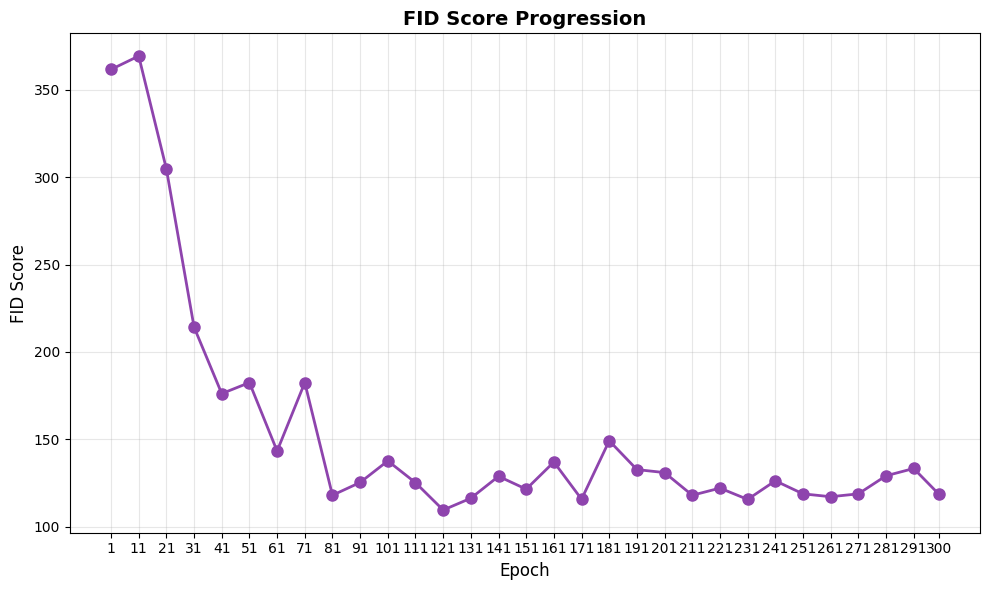

Generating examples for each class...
Examples generated and saved to output directory.
Generated examples shape: torch.Size([50, 3, 128, 128])
Min value: 0.0161, Max value: 0.9328


In [10]:
generator, discriminator, fid_scores, epochs_with_fid = train_acgan()

# Display the final FID score
print(f"Final FID score: {fid_scores[-1]:.4f}")

# Plot the FID scores
plt.figure(figsize=(10, 6))
plt.plot(epochs_with_fid, fid_scores, marker='o', linestyle='-', color='#8E44AD', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('FID Score', fontsize=12)
plt.title('FID Score Progression', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(epochs_with_fid)
plt.tight_layout()
plt.show()

# Generate examples for each class
print("Generating examples for each class...")
class_examples = generate_class_examples(generator, n_samples=10)
print("Examples generated and saved to output directory.")

# Display some statistics about the generated examples
print(f"Generated examples shape: {class_examples.shape}")
print(f"Min value: {class_examples.min().item():.4f}, Max value: {class_examples.max().item():.4f}")

## Generate Images for Augmentation

Generate synthetic images for the underrepresented classes (AKIEC, BCC, BKL, MEL) to balance the dataset.

In [11]:
# Load class names and indices
df = pd.read_csv(csv_file)
categories = df.columns[1:].tolist()
print(f"Categories: {categories}")

# Get class counts
class_counts = {}
for category in categories:
    class_counts[category] = int(df[category].sum())
print(f"Class counts: {class_counts}")

# Specific augmentation counts as requested
target_counts = {
    'NV': 0,        # No augmentation for NV (already has 6705 images)
    'MEL': 3340,    # Add 3340 images to reach ~4450 total
    'BKL': 3300,    # Add 3300 images to reach ~4400 total
    'BCC': 2000,    # Add 2000 images to reach ~2500 total
    'AKIEC': 1300   # Add 1300 images to reach ~1600 total
}
print(f"Target augmentation counts: {target_counts}")

# Create output directory
gan_augmented_dir = "/content/drive/MyDrive/ham_windsurf/results/acgan_modified/gan_augmented_images"
os.makedirs(gan_augmented_dir, exist_ok=True)

# Create class mapping dictionary (class name to index)
class_mapping = {class_name: idx for idx, class_name in enumerate(categories)}
print(f"Class mapping: {class_mapping}")

# Generate images for each class with specific counts
generator.eval()
with torch.no_grad():
    for class_name, count in target_counts.items():
        if count <= 0:
            print(f"Skipping {class_name} (no augmentation needed)")
            continue

        class_idx = class_mapping[class_name]
        class_dir = os.path.join(gan_augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        print(f"Generating {count} images for class {class_name} (index {class_idx})...")

        # Generate in batches for efficiency
        batch_size = 64
        for batch_start in tqdm(range(0, count, batch_size)):
            # Calculate actual batch size (might be smaller for the last batch)
            actual_batch_size = min(batch_size, count - batch_start)

            # Generate noise
            z = torch.randn(actual_batch_size, latent_dim).to(device)

            # Generate labels
            labels = torch.full((actual_batch_size,), class_idx, dtype=torch.long).to(device)

            # Generate images
            gen_imgs = generator(z, labels)

            # Normalize to [0, 1]
            gen_imgs = (gen_imgs + 1) / 2

            # Convert to numpy for saving
            fake_images = gen_imgs.cpu().numpy().transpose(0, 2, 3, 1) * 255

            # Save each image in the batch
            for j in range(actual_batch_size):
                img_idx = batch_start + j
                img_path = os.path.join(class_dir, f"{class_name}_gen_{img_idx:05d}.jpg")
                img = fake_images[j].astype(np.uint8)
                plt.imsave(img_path, img)

print("\nCompleted targeted augmentation:")
print(f"| Class | Current | Augmented | Total After |")
print(f"| ----- | ------- | --------- | ----------- |")
print(f"| NV    | {class_counts['NV']} | +{target_counts['NV']} | {class_counts['NV'] + target_counts['NV']} |")
print(f"| MEL   | {class_counts['MEL']} | +{target_counts['MEL']} | ~{class_counts['MEL'] + target_counts['MEL']} |")
print(f"| BKL   | {class_counts['BKL']} | +{target_counts['BKL']} | ~{class_counts['BKL'] + target_counts['BKL']} |")
print(f"| BCC   | {class_counts['BCC']} | +{target_counts['BCC']} | ~{class_counts['BCC'] + target_counts['BCC']} |")
print(f"| AKIEC | {class_counts['AKIEC']} | +{target_counts['AKIEC']} | ~{class_counts['AKIEC'] + target_counts['AKIEC']} |")

Categories: ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC']
Class counts: {'NV': 6705, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327}
Target augmentation counts: {'NV': 0, 'MEL': 3340, 'BKL': 3300, 'BCC': 2000, 'AKIEC': 1300}
Class mapping: {'NV': 0, 'MEL': 1, 'BKL': 2, 'BCC': 3, 'AKIEC': 4}
Skipping NV (no augmentation needed)
Generating 3340 images for class MEL (index 1)...


  0%|          | 0/53 [00:00<?, ?it/s]

Generating 3300 images for class BKL (index 2)...


  0%|          | 0/52 [00:00<?, ?it/s]

Generating 2000 images for class BCC (index 3)...


  0%|          | 0/32 [00:00<?, ?it/s]

Generating 1300 images for class AKIEC (index 4)...


  0%|          | 0/21 [00:00<?, ?it/s]


Completed targeted augmentation:
| Class | Current | Augmented | Total After |
| ----- | ------- | --------- | ----------- |
| NV    | 6705 | +0 | 6705 |
| MEL   | 1113 | +3340 | ~4453 |
| BKL   | 1099 | +3300 | ~4399 |
| BCC   | 514 | +2000 | ~2514 |
| AKIEC | 327 | +1300 | ~1627 |


## Create Augmented Dataset CSV

Create a CSV file for the GAN-augmented dataset.

In [12]:
os.makedirs('/content/drive/MyDrive/ham_windsurf/data', exist_ok=True)

In [13]:
# Create DataFrame for GAN-augmented images
gan_augmented_rows = []

# Use the same classes as in our targeted augmentation
augment_classes = ['MEL', 'BKL', 'BCC', 'AKIEC']  # NV is skipped as it has 0 augmentation

for cls_name in augment_classes:
    cls_dir = os.path.join(gan_augmented_dir, cls_name)
    if not os.path.exists(cls_dir):
        continue

    print(f"Processing {cls_name} directory...")

    # Count files to show progress
    files = [f for f in os.listdir(cls_dir) if f.endswith('.jpg')]
    print(f"Found {len(files)} images for {cls_name}")

    for filename in tqdm(files):
        # Extract base filename without extension
        base_filename = os.path.splitext(filename)[0]

        # Create row with one-hot encoding
        row = {'image': base_filename}
        for category in categories:
            row[category] = 1.0 if category == cls_name else 0.0

        gan_augmented_rows.append(row)

# Create DataFrame
gan_augmented_df = pd.DataFrame(gan_augmented_rows)
print(f"Created DataFrame with {len(gan_augmented_df)} GAN-augmented images")

# Combine with original training data
combined_df = pd.concat([df, gan_augmented_df], ignore_index=True)
print(f"Combined DataFrame has {len(combined_df)} total images")

# Save combined DataFrame
output_csv_path = '/content/drive/MyDrive/ham_windsurf/data/acgan_augmented_train.csv'
combined_df.to_csv(output_csv_path, index=False)
print(f"Saved combined dataset to {output_csv_path}")

# Display final class distribution after GAN augmentation
print("\nFinal class distribution after GAN augmentation:")
print(f"| Class | Original | Augmented | Total |")
print(f"| ----- | -------- | --------- | ----- |")
for category in categories:
    original_count = int(df[category].sum())
    augmented_count = int(gan_augmented_df[category].sum()) if category in augment_classes else 0
    total_count = int(combined_df[category].sum())
    print(f"| {category} | {original_count} | +{augmented_count} | {total_count} |")

# Verify the augmentation matches our targets
print("\nVerifying augmentation counts:")
for category in augment_classes:
    target = target_counts[category]
    actual = int(gan_augmented_df[category].sum())
    if target == actual:
        print(f"✓ {category}: Target {target}, Actual {actual} - MATCH")
    else:
        print(f"✗ {category}: Target {target}, Actual {actual} - MISMATCH")

Processing MEL directory...
Found 3340 images for MEL


  0%|          | 0/3340 [00:00<?, ?it/s]

Processing BKL directory...
Found 3300 images for BKL


  0%|          | 0/3300 [00:00<?, ?it/s]

Processing BCC directory...
Found 2000 images for BCC


  0%|          | 0/2000 [00:00<?, ?it/s]

Processing AKIEC directory...
Found 1300 images for AKIEC


  0%|          | 0/1300 [00:00<?, ?it/s]

Created DataFrame with 9940 GAN-augmented images
Combined DataFrame has 19698 total images
Saved combined dataset to /content/drive/MyDrive/ham_windsurf/data/acgan_augmented_train.csv

Final class distribution after GAN augmentation:
| Class | Original | Augmented | Total |
| ----- | -------- | --------- | ----- |
| NV | 6705 | +0 | 6705 |
| MEL | 1113 | +3340 | 4453 |
| BKL | 1099 | +3300 | 4399 |
| BCC | 514 | +2000 | 2514 |
| AKIEC | 327 | +1300 | 1627 |

Verifying augmentation counts:
✓ MEL: Target 3340, Actual 3340 - MATCH
✓ BKL: Target 3300, Actual 3300 - MATCH
✓ BCC: Target 2000, Actual 2000 - MATCH
✓ AKIEC: Target 1300, Actual 1300 - MATCH
